# Stage‑1 (Full) with Unified CL Conveyor  
Re‑implementation of **stage1.py** entirely inside this notebook, but with a single **WIPo_CL** conveyor (capacity 100) feeding SB1 and pause logic for CL1 & CL4.  
Generated on 2025-05-09 07:20.  

In [1]:

import simpy, sys, pathlib, pandas as pd, matplotlib.pyplot as plt
# ensure helpers & config resolve (assumes notebook sits with them or one level up)
if not pathlib.Path('helpers.py').exists():
    sys.path.append('..')
from plant_sim import helpers as h
from plant_sim import config as cfg

# clean previous runs
h.movement_log.clear(); h.wip_history.clear()
h.unit_record.clear()


In [8]:

SIM_TIME        = 20_000
CONVEYOR_CAP    = 100
PAUSE_LEVEL     = 100
RESUME_LEVEL    = 50
THROTTLE        = True
SB1_TIME        = cfg.network['SB1']['process_time'] 
FORKLIFT_COUNT  = 2
PALLET_SIZE     = 42
POLL            = 0.01


In [16]:
# ---------- fresh simulation environment ----------
env = simpy.Environment()

# reset helpers so IDs start at U1
h.global_item_counter = 0
h.movement_log.clear()
h.wip_history.clear()
h.unit_record.clear()
finished_goods = []         # local run log

def build_stage1(env):
    
    h.machine_status.clear()  
    
    for m_name, data in cfg.network.items():
        if 'OEE' in data:             # only machines, not queues
            oee  = data['OEE']
            env.process(h.downtime(env, m_name, OEE=oee))
    
    queues = h.init_queues(cfg.network)
    for q in ['WIPi_SB1', 'WIPo_SB1', 'finished_goods']:
        queues[q] = []
        
    storage_after_press = []
    conveyor = []
    queues['WIPo_CL'] = conveyor

    # expose for inspection
    env.queues, env.storage_after_press, env.conveyor = queues, storage_after_press, conveyor

    # forklift resource
    h.forklifts = simpy.Resource(env, capacity=FORKLIFT_COUNT)
    #h.forklifts = env.Resource(env, capacity=FORKLIFT_COUNT)

    def log_conveyor():
        h.log_wip(env, 'WIPo_CL', {'WIPo_CL': conveyor})

    # ---------- SAW generator (regulated) ----------
    def regulated_saw(name, pt, out_q, limit, monitor_q):
        while True:
        # -------- extra machine-up check --------
            if not h.machine_status.get(name, True):
                yield env.timeout(POLL)          # machine is down
                continue
        # ----------------------------------------
            if len(queues.get(monitor_q, [])) <= limit:
                h.global_item_counter += 1
                uid = f"U{h.global_item_counter}"
                h.unit_record[uid]['SAW'] = name
                h.unit_record[uid]['EntryTime'] = env.now
                h.log_move(env, uid, '', name, 'create')
                yield env.timeout(pt)
                queues[out_q].append(uid)
                h.log_wip(env, out_q, queues)
                h.log_move(env, uid, name, out_q, 'finish')
            else:
                yield env.timeout(POLL)

    # ---------- mover from WIPo_SAW ----------
    def move(wipo, dests, tts):
        if not isinstance(tts, list): tts = [tts]*len(dests)
        while True:
            if queues[wipo]:
                uid = queues[wipo].pop(0)
                dest = min(dests, key=lambda d: len(queues[d]))
                idx  = dests.index(dest)
                yield env.timeout(tts[idx])
                queues[dest].append(uid)
                h.log_wip(env, dest, queues)
                h.log_move(env, uid, wipo, dest, 'transport')
            else:
                yield env.timeout(POLL)

    # ---------- IH ----------
    IH_IN = {"IH1":"WIPi_IH1","IH2":"WIPi_IH2","IH3":"WIPi_IH3"}
    def ih(name, pt, out_q):
        buf = IH_IN[name]
        while True:
        # -------- extra machine-up check --------
            if not h.machine_status.get(name, True):
                yield env.timeout(POLL)          # machine is down
                continue
        # ----------------------------------------
            if queues[buf]:
                uid = queues[buf].pop(0)
                h.log_move(env, uid, buf, name, 'start')
                yield env.timeout(pt)
                queues[out_q].append(uid)
                h.log_wip(env, out_q, queues)
                h.log_move(env, uid, name, out_q, 'finish')
            else:
                yield env.timeout(POLL)

    # ---------- Press with cooldown ----------
    def press(name, pt):
        COOL = 1440
        in_q = queues[name]
        while True:
            if h.machine_status.get(name, True) and in_q:
                uid = in_q.pop(0)
                h.log_move(env, uid, f'{name}_Q', name, 'start')
                yield env.timeout(pt)
                storage_after_press.append((uid, env.now + COOL))
                h.unit_record[uid]['ExitTime'] = env.now
                h.log_move(env, uid, name, 'storage_after_press', 'finish')
            else:
                yield env.timeout(POLL)

    # ---------- CL to Conveyor ----------
    def cl_proc(name, pt):
        while True:
        # -------- extra machine-up check --------
            if not h.machine_status.get(name, True):
                yield env.timeout(POLL)          # machine is down
                continue
        # ----------------------------------------
            if THROTTLE and name in ('CL1','CL4') and len(conveyor) >= PAUSE_LEVEL:
                yield env.timeout(POLL); continue
            if storage_after_press and env.now >= storage_after_press[0][1]:
                uid,_ = storage_after_press.pop(0)
            else:
                yield env.timeout(POLL); continue
            h.log_move(env, uid, 'storage_after_press', name, 'start')
            yield env.timeout(pt)
            if len(conveyor) < CONVEYOR_CAP:
                conveyor.append(uid)
                h.log_move(env, uid, name, 'WIPo_CL', 'finish')
                log_conveyor()
            else:
                storage_after_press.insert(0,(uid,env.now))
                yield env.timeout(POLL)
                
    def cl_to_sb1_mover():
        while True:
            if queues['WIPo_CL']:
                uid = queues['WIPo_CL'].pop(0)

                # per-shell crane travel from config
                t_field = cfg.network['WIPo_CL']['transport_times']
                t_move  = t_field[0] if isinstance(t_field, (list, tuple)) else t_field
                yield env.timeout(t_move)

                queues['WIPi_SB1'].append(uid)
                h.log_wip(env, 'WIPi_SB1', queues)
                h.log_move(env, uid, 'WIPo_CL', 'WIPi_SB1', 'transport')
            else:
                yield env.timeout(POLL)

    # ---------- SB1 ----------
    def sb1():
        while True:
        # -------- extra machine-up check --------
            if not h.machine_status.get('SB1', True):
                yield env.timeout(POLL)          # machine is down
                continue
        # ----------------------------------------
            if queues['WIPi_SB1']:
                uid = queues['WIPi_SB1'].pop(0)
                h.log_move(env, uid, 'WIPi_SB1', 'SB1', 'start')
                yield env.timeout(SB1_TIME)
                h.log_move(env, uid, 'SB1', 'WIPo_SB1', 'finish')
                queues['WIPo_SB1'].append(uid)          # for palletisation
                h.log_wip(env, 'WIPo_SB1', queues)
            else:
                yield env.timeout(POLL)
                
    def sb1_pallet_transfer():
        while True:
            if len(queues['WIPo_SB1']) >= PALLET_SIZE:          # 42 shells
                # travel/setup time from config
                t_field = cfg.network['WIPo_SB1']['transport_times']
                travel  = t_field[0] if isinstance(t_field, (list, tuple)) else t_field

                with h.forklifts.request() as req:              # only forklift use
                    yield req
                    yield env.timeout(travel)

                # unload pallet
                for _ in range(PALLET_SIZE):
                    uid = queues['WIPo_SB1'].pop(0)             # was filled by SB1
                    queues['finished_goods'].append(uid)
                    h.log_wip(env, 'finished_goods', queues)
                    h.log_move(env, uid, 'WIPo_SB1', 'finished_goods', 'pallet_move')

                    # ---- stamp completion time here ----
                    h.unit_record[uid]['FinalGoodsTime'] = env.now
                    finished_goods.append({'UnitId': uid,
                                            'FinalGoodsTime': env.now})
            else:
                yield env.timeout(POLL)

    # ---------- sampler ----------
    def sampler():
        while True:
            log_conveyor()
            yield env.timeout(50)

    net = cfg.network

    # SAWs
    for s in ('SAW1','SAW2','SAW3'):
        env.process(regulated_saw(s, net[s]['process_time'], net[s]['output'], 245, 'P1'))
    for s in ('SAW4','SAW5'):
        env.process(regulated_saw(s, net[s]['process_time'], net[s]['output'], 245, 'P2'))
    # movers
    for w in ('WIPo_SAW1','WIPo_SAW2','WIPo_SAW3','WIPo_SAW4','WIPo_SAW5'):
        env.process(move(w, net[w]['next'], net[w]['transport_times']))
    # IH
    for ihm in ('IH1','IH2','IH3'):
        env.process(ih(ihm, net[ihm]['process_time'], net[ihm]['output']))
    # Presses
    for p in ('P1','P2'):
        env.process(press(p, net[p]['process_time']))
    # CLs
    for clm in ('CL1','CL2','CL3','CL4'):
        env.process(cl_proc(clm, net[clm]['process_time']))
    # SB1 + sampler
    env.process(cl_to_sb1_mover())
    env.process(sb1())
    env.process(sb1_pallet_transfer())
    env.process(sampler())

    return queues, conveyor

# build environment
env = simpy.Environment()
build_stage1(env)
env.run(until=SIM_TIME)
print(f"Run complete. Units finished: {len(finished_goods)}")


[   0.0]     U1  create                           → SAW1
[   0.0]     U2  create                           → SAW2
[   0.0]     U3  create                           → SAW3
[   0.0]     U4  create                           → SAW4
[   0.0]     U5  create                           → SAW5
[  11.4]     U1  finish                      SAW1 → WIPo_SAW1
[  11.4]     U6  create                           → SAW1
[  11.4]     U2  finish                      SAW2 → WIPo_SAW2
[  11.4]     U3  finish                      SAW3 → WIPo_SAW3
[  11.4]     U4  finish                      SAW4 → WIPo_SAW4
[  11.4]     U7  create                           → SAW4
[  11.4]     U5  finish                      SAW5 → WIPo_SAW5
[  11.4]     U8  create                           → SAW5
[  12.4]     U1  transport               WIPo_SAW1 → WIPi_IH1
[  12.4]     U2  transport               WIPo_SAW2 → WIPi_IH1
[  12.4]     U3  transport               WIPo_SAW3 → WIPi_IH1
[  12.4]     U4  transport               WIPo_SA

[  63.3]    U20  finish                       IH1 → P1
[  63.4]    U23  transport               WIPo_SAW2 → WIPi_IH1
[  63.4]    U23  start                   WIPi_IH1 → IH1
[  63.6]    U24  finish                      SAW3 → WIPo_SAW3
[  63.6]    U29  create                           → SAW3
[  64.7]    U24  transport               WIPo_SAW3 → WIPi_IH1
[  65.4]    U21  finish                        P2 → storage_after_press
[  65.5]    U22  finish                       IH3 → P2
[  65.5]    U22  start                       P2_Q → P2
[  66.3]    U18  start                       P1_Q → P1
[  67.2]    U23  finish                       IH1 → P1
[  67.2]    U24  start                   WIPi_IH1 → IH1
[  68.3]    U25  finish                      SAW4 → WIPo_SAW4
[  68.3]    U30  create                           → SAW4
[  68.3]    U26  finish                      SAW5 → WIPo_SAW5
[  68.3]    U31  create                           → SAW5
[  68.8]    U18  finish                        P1 → storage_

[ 124.1]    U47  finish                       IH1 → P1
[ 124.1]    U48  start                   WIPi_IH1 → IH1
[ 124.1]    U47  start                       P1_Q → P1
[ 125.2]    U49  finish                      SAW5 → WIPo_SAW5
[ 125.2]    U52  create                           → SAW5
[ 126.2]    U49  transport               WIPo_SAW5 → WIPi_IH3
[ 126.2]    U49  start                   WIPi_IH3 → IH3
[ 126.5]    U46  finish                        P2 → storage_after_press
[ 126.6]    U47  finish                        P1 → storage_after_press
[ 127.8]    U48  finish                       IH1 → P1
[ 127.9]    U48  start                       P1_Q → P1
[ 129.5]    U53  create                           → SAW4
[ 130.0]    U49  finish                       IH3 → P2
[ 130.0]    U49  start                       P2_Q → P2
[ 130.4]    U48  finish                        P1 → storage_after_press
[ 130.6]    U50  finish                      SAW2 → WIPo_SAW2
[ 130.6]    U54  create                   

[ 196.1]    U73  finish                       IH1 → P1
[ 196.1]    U74  start                   WIPi_IH1 → IH1
[ 196.9]    U64  finish                        P1 → storage_after_press
[ 196.9]    U67  start                       P1_Q → P1
[ 197.6]    U75  finish                       IH3 → P2
[ 197.6]    U75  start                       P2_Q → P2
[ 198.2]    U76  finish                      SAW5 → WIPo_SAW5
[ 198.2]    U80  create                           → SAW5
[ 198.9]    U77  finish                      SAW2 → WIPo_SAW2
[ 198.9]    U81  create                           → SAW2
[ 199.3]    U76  transport               WIPo_SAW5 → WIPi_IH3
[ 199.3]    U76  start                   WIPi_IH3 → IH3
[ 199.4]    U67  finish                        P1 → storage_after_press
[ 199.4]    U68  start                       P1_Q → P1
[ 199.9]    U74  finish                       IH1 → P1
[ 199.9]    U77  transport               WIPo_SAW2 → WIPi_IH1
[ 199.9]    U77  start                   WIPi_IH1 → 

[ 261.4]    U99  finish                      SAW3 → WIPo_SAW3
[ 261.4]   U104  create                           → SAW3
[ 262.1]    U98  transport               WIPo_SAW4 → WIPi_IH3
[ 262.1]    U98  start                   WIPi_IH3 → IH3
[ 262.5]    U99  transport               WIPo_SAW3 → WIPi_IH1
[ 262.9]   U100  finish                      SAW2 → WIPo_SAW2
[ 262.9]   U105  create                           → SAW2
[ 263.2]    U97  finish                       IH1 → P1
[ 263.2]    U99  start                   WIPi_IH1 → IH1
[ 263.2]    U97  start                       P1_Q → P1
[ 263.7]    U96  finish                        P2 → storage_after_press
[ 263.9]   U100  transport               WIPo_SAW2 → WIPi_IH2
[ 265.8]    U97  finish                        P1 → storage_after_press
[ 265.8]    U98  finish                       IH3 → P2
[ 265.8]    U98  start                       P2_Q → P2
[ 266.5]   U101  finish                      SAW5 → WIPo_SAW5
[ 266.5]   U106  create               

[ 337.4]   U127  finish                      SAW2 → WIPo_SAW2
[ 337.4]   U131  create                           → SAW2
[ 337.6]   U126  finish                        P1 → storage_after_press
[ 337.8]   U125  finish                        P2 → storage_after_press
[ 338.0]   U128  finish                      SAW1 → WIPo_SAW1
[ 338.0]   U132  create                           → SAW1
[ 338.5]   U127  transport               WIPo_SAW2 → WIPi_IH2
[ 338.5]   U127  start                   WIPi_IH2 → IH2
[ 339.1]   U128  transport               WIPo_SAW1 → WIPi_IH2
[ 340.7]   U129  finish                      SAW4 → WIPo_SAW4
[ 340.7]   U133  create                           → SAW4
[ 341.4]   U124  start                   WIPi_IH1 → IH1
[ 341.6]   U130  finish                      SAW3 → WIPo_SAW3
[ 341.7]   U129  transport               WIPo_SAW4 → WIPi_IH3
[ 341.7]   U129  start                   WIPi_IH3 → IH3
[ 342.2]   U127  finish                       IH2 → P1
[ 342.2]   U128  start      

[ 411.9]   U153  finish                      SAW3 → WIPo_SAW3
[ 411.9]   U157  create                           → SAW3
[ 412.0]   U154  finish                      SAW2 → WIPo_SAW2
[ 412.0]   U158  create                           → SAW2
[ 412.2]   U151  finish                        P2 → storage_after_press
[ 412.3]   U152  finish                       IH3 → P2
[ 412.3]   U152  start                       P2_Q → P2
[ 412.9]   U153  transport               WIPo_SAW3 → WIPi_IH2
[ 412.9]   U153  start                   WIPi_IH2 → IH2
[ 413.1]   U154  transport               WIPo_SAW2 → WIPi_IH2
[ 413.8]   U155  finish                      SAW1 → WIPo_SAW1
[ 413.8]   U159  create                           → SAW1
[ 414.8]   U155  transport               WIPo_SAW1 → WIPi_IH1
[ 415.5]   U156  finish                      SAW5 → WIPo_SAW5
[ 415.5]   U160  create                           → SAW5
[ 416.0]   U152  finish                        P2 → storage_after_press
[ 416.6]   U156  transport  

[ 478.7]   U178  transport               WIPo_SAW3 → WIPi_IH1
[ 478.7]   U178  start                   WIPi_IH1 → IH1
[ 479.1]   U179  finish                      SAW4 → WIPo_SAW4
[ 479.1]   U184  create                           → SAW4
[ 480.0]   U176  finish                        P1 → storage_after_press
[ 480.2]   U179  transport               WIPo_SAW4 → WIPi_IH3
[ 480.3]   U180  finish                      SAW2 → WIPo_SAW2
[ 480.3]   U185  create                           → SAW2
[ 481.2]   U177  start                   WIPi_IH3 → IH3
[ 481.4]   U180  transport               WIPo_SAW2 → WIPi_IH1
[ 482.0]   U181  finish                      SAW1 → WIPo_SAW1
[ 482.0]   U186  create                           → SAW1
[ 482.5]   U178  finish                       IH1 → P1
[ 482.5]   U180  start                   WIPi_IH1 → IH1
[ 482.5]   U178  start                       P1_Q → P1
[ 483.1]   U181  transport               WIPo_SAW1 → WIPi_IH2
[ 483.1]   U181  start                   WIPi

[ 550.3]   U211  finish                      SAW1 → WIPo_SAW1
[ 550.3]   U216  create                           → SAW1
[ 550.8]   U208  finish                       IH1 → P1
[ 550.8]   U210  start                   WIPi_IH1 → IH1
[ 550.9]   U206  finish                        P1 → storage_after_press
[ 550.9]   U208  start                       P1_Q → P1
[ 551.4]   U211  transport               WIPo_SAW1 → WIPi_IH2
[ 551.4]   U211  start                   WIPi_IH2 → IH2
[ 552.3]   U209  finish                       IH3 → P2
[ 552.3]   U209  start                       P2_Q → P2
[ 552.5]   U212  finish                      SAW5 → WIPo_SAW5
[ 552.5]   U217  create                           → SAW5
[ 553.4]   U208  finish                        P1 → storage_after_press
[ 553.5]   U212  transport               WIPo_SAW5 → WIPi_IH3
[ 553.5]   U212  start                   WIPi_IH3 → IH3
[ 554.5]   U210  finish                       IH1 → P1
[ 554.6]   U210  start                       P1_Q →

[ 628.1]   U242  transport               WIPo_SAW4 → WIPi_IH3
[ 628.1]   U242  start                   WIPi_IH3 → IH3
[ 628.4]   U243  transport               WIPo_SAW5 → WIPi_IH3
[ 628.4]   U244  finish                      SAW3 → WIPo_SAW3
[ 628.4]   U249  create                           → SAW3
[ 629.5]   U244  transport               WIPo_SAW3 → WIPi_IH1
[ 629.5]   U240  finish                        P1 → storage_after_press
[ 630.4]   U245  finish                      SAW2 → WIPo_SAW2
[ 630.4]   U250  create                           → SAW2
[ 631.5]   U245  transport               WIPo_SAW2 → WIPi_IH2
[ 631.5]   U245  start                   WIPi_IH2 → IH2
[ 631.8]   U241  finish                       IH1 → P1
[ 631.8]   U244  start                   WIPi_IH1 → IH1
[ 631.8]   U241  start                       P1_Q → P1
[ 631.9]   U242  finish                       IH3 → P2
[ 631.9]   U243  start                   WIPi_IH3 → IH3
[ 631.9]   U242  start                       P2_Q → P

[ 701.1]   U268  finish                        P1 → storage_after_press
[ 701.5]   U270  finish                       IH1 → P1
[ 701.5]   U271  start                   WIPi_IH1 → IH1
[ 701.5]   U270  start                       P1_Q → P1
[ 703.9]   U269  finish                        P2 → storage_after_press
[ 704.1]   U270  finish                        P1 → storage_after_press
[ 705.3]   U271  finish                       IH1 → P1
[ 705.3]   U271  start                       P1_Q → P1
[ 706.4]   U276  create                           → SAW2
[ 706.7]   U272  finish                      SAW4 → WIPo_SAW4
[ 706.7]   U277  create                           → SAW4
[ 707.1]   U273  finish                      SAW5 → WIPo_SAW5
[ 707.1]   U278  create                           → SAW5
[ 707.8]   U272  transport               WIPo_SAW4 → WIPi_IH3
[ 707.8]   U272  start                   WIPi_IH3 → IH3
[ 707.8]   U271  finish                        P1 → storage_after_press
[ 708.1]   U274  finish

[ 770.4]   U296  finish                       IH1 → P1
[ 771.3]   U287  finish                        P2 → storage_after_press
[ 771.3]   U288  start                       P2_Q → P2
[ 772.3]   U298  finish                        P1 → storage_after_press
[ 772.3]   U296  start                       P1_Q → P1
[ 773.1]   U299  finish                      SAW1 → WIPo_SAW1
[ 773.1]   U302  create                           → SAW1
[ 773.3]   U292  finish                       IH3 → P2
[ 773.3]   U293  start                   WIPi_IH3 → IH3
[ 774.2]   U299  transport               WIPo_SAW1 → WIPi_IH1
[ 774.2]   U299  start                   WIPi_IH1 → IH1
[ 774.9]   U296  finish                        P1 → storage_after_press
[ 775.0]   U288  finish                        P2 → storage_after_press
[ 775.0]   U292  start                       P2_Q → P2
[ 775.0]   U300  finish                      SAW4 → WIPo_SAW4
[ 775.0]   U303  create                           → SAW4
[ 776.1]   U300  transpor

[ 846.5]   U327  finish                      SAW2 → WIPo_SAW2
[ 846.5]   U332  create                           → SAW2
[ 847.1]   U326  transport               WIPo_SAW4 → WIPi_IH3
[ 847.5]   U319  finish                        P2 → storage_after_press
[ 847.6]   U327  transport               WIPo_SAW2 → WIPi_IH1
[ 847.6]   U321  finish                       IH3 → P2
[ 847.6]   U324  start                   WIPi_IH3 → IH3
[ 847.6]   U321  start                       P2_Q → P2
[ 848.8]   U323  finish                        P1 → storage_after_press
[ 850.0]   U325  finish                       IH1 → P1
[ 850.0]   U327  start                   WIPi_IH1 → IH1
[ 850.0]   U325  start                       P1_Q → P1
[ 851.3]   U321  finish                        P2 → storage_after_press
[ 851.4]   U324  finish                       IH3 → P2
[ 851.4]   U326  start                   WIPi_IH3 → IH3
[ 851.4]   U324  start                       P2_Q → P2
[ 852.6]   U325  finish                    

[ 920.9]   U352  finish                        P1 → storage_after_press
[ 921.1]   U355  finish                      SAW1 → WIPo_SAW1
[ 921.1]   U360  create                           → SAW1
[ 921.7]   U356  finish                      SAW5 → WIPo_SAW5
[ 921.7]   U361  create                           → SAW5
[ 922.1]   U354  finish                       IH1 → P1
[ 922.1]   U354  start                       P1_Q → P1
[ 922.1]   U355  transport               WIPo_SAW1 → WIPi_IH1
[ 922.1]   U355  start                   WIPi_IH1 → IH1
[ 922.6]   U353  finish                        P2 → storage_after_press
[ 922.7]   U357  finish                      SAW3 → WIPo_SAW3
[ 922.7]   U362  create                           → SAW3
[ 922.7]   U356  transport               WIPo_SAW5 → WIPi_IH3
[ 922.7]   U356  start                   WIPi_IH3 → IH3
[ 923.4]   U358  finish                      SAW4 → WIPo_SAW4
[ 923.4]   U363  create                           → SAW4
[ 923.8]   U357  transport        

[ 989.9]   U385  finish                      SAW5 → WIPo_SAW5
[ 989.9]   U390  create                           → SAW5
[ 990.0]   U383  finish                       IH1 → P1
[ 990.0]   U384  start                   WIPi_IH1 → IH1
[ 990.0]   U383  start                       P1_Q → P1
[ 991.0]   U385  transport               WIPo_SAW5 → WIPi_IH3
[ 991.0]   U385  start                   WIPi_IH3 → IH3
[ 991.2]   U386  finish                      SAW1 → WIPo_SAW1
[ 991.6]   U387  finish                      SAW4 → WIPo_SAW4
[ 991.6]   U391  create                           → SAW4
[ 992.3]   U386  transport               WIPo_SAW1 → WIPi_IH1
[ 992.5]   U383  finish                        P1 → storage_after_press
[ 992.7]   U387  transport               WIPo_SAW4 → WIPi_IH3
[ 993.2]   U377  finish                        P2 → storage_after_press
[ 993.7]   U384  finish                       IH1 → P1
[ 993.7]   U386  start                   WIPi_IH1 → IH1
[ 993.7]   U384  start               

[1063.5]   U412  finish                       IH1 → P1
[1063.5]   U412  start                       P1_Q → P1
[1064.1]   U414  transport               WIPo_SAW1 → WIPi_IH1
[1064.1]   U414  start                   WIPi_IH1 → IH1
[1064.6]   U413  finish                       IH2 → P1
[1065.5]   U410  finish                        P2 → storage_after_press
[1065.6]   U411  finish                       IH3 → P2
[1065.6]   U411  start                       P2_Q → P2
[1066.1]   U412  finish                        P1 → storage_after_press
[1066.1]   U413  start                       P1_Q → P1
[1067.9]   U414  finish                       IH1 → P1
[1068.3]   U415  finish                      SAW4 → WIPo_SAW4
[1068.3]   U419  create                           → SAW4
[1068.6]   U413  finish                        P1 → storage_after_press
[1068.6]   U414  start                       P1_Q → P1
[1069.2]   U411  finish                        P2 → storage_after_press
[1069.4]   U415  transport         

[1136.6]   U441  finish                       IH1 → P1
[1136.6]   U442  start                   WIPi_IH1 → IH1
[1136.6]   U441  start                       P1_Q → P1
[1137.9]   U443  finish                      SAW5 → WIPo_SAW5
[1137.9]   U448  create                           → SAW5
[1138.8]   U440  finish                        P2 → storage_after_press
[1138.9]   U443  transport               WIPo_SAW5 → WIPi_IH3
[1138.9]   U443  start                   WIPi_IH3 → IH3
[1139.2]   U441  finish                        P1 → storage_after_press
[1139.4]   U444  finish                      SAW3 → WIPo_SAW3
[1139.4]   U449  create                           → SAW3
[1140.4]   U442  finish                       IH1 → P1
[1140.4]   U442  start                       P1_Q → P1
[1140.4]   U444  transport               WIPo_SAW3 → WIPi_IH1
[1141.1]   U445  finish                      SAW4 → WIPo_SAW4
[1141.3]   U444  start                   WIPi_IH1 → IH1
[1142.1]   U445  transport               WIP

[1211.0]   U471  finish                       IH3 → P2
[1211.1]   U468  finish                        P1 → storage_after_press
[1211.1]   U470  start                       P1_Q → P1
[1212.3]   U472  finish                       IH1 → P1
[1212.3]   U473  start                   WIPi_IH1 → IH1
[1212.5]   U474  finish                      SAW4 → WIPo_SAW4
[1213.6]   U474  transport               WIPo_SAW4 → WIPi_IH3
[1213.6]   U474  start                   WIPi_IH3 → IH3
[1213.6]   U470  finish                        P1 → storage_after_press
[1213.6]   U472  start                       P1_Q → P1
[1214.0]   U479  create                           → SAW4
[1215.3]   U475  finish                      SAW2 → WIPo_SAW2
[1215.3]   U480  create                           → SAW2
[1216.1]   U473  finish                       IH1 → P1
[1216.1]   U472  finish                        P1 → storage_after_press
[1216.1]   U473  start                       P1_Q → P1
[1216.3]   U475  transport               W

[1286.1]   U501  finish                       IH1 → P1
[1286.1]   U504  start                   WIPi_IH1 → IH1
[1286.9]   U505  finish                      SAW1 → WIPo_SAW1
[1286.9]   U510  create                           → SAW1
[1287.3]   U506  finish                      SAW3 → WIPo_SAW3
[1287.8]   U502  finish                        P2 → storage_after_press
[1287.9]   U500  finish                        P1 → storage_after_press
[1287.9]   U501  start                       P1_Q → P1
[1287.9]   U503  finish                       IH3 → P2
[1287.9]   U505  transport               WIPo_SAW1 → WIPi_IH1
[1287.9]   U503  start                       P2_Q → P2
[1288.4]   U506  transport               WIPo_SAW3 → WIPi_IH1
[1289.9]   U504  finish                       IH1 → P1
[1289.9]   U505  start                   WIPi_IH1 → IH1
[1290.4]   U501  finish                        P1 → storage_after_press
[1290.4]   U504  start                       P1_Q → P1
[1290.7]   U507  finish              

[1352.7]   U529  finish                       IH3 → P2
[1352.7]   U530  start                   WIPi_IH3 → IH3
[1352.8]   U529  start                       P2_Q → P2
[1352.9]   U528  finish                        P1 → storage_after_press
[1352.9]   U527  start                       P1_Q → P1
[1354.1]   U531  finish                      SAW3 → WIPo_SAW3
[1354.1]   U536  create                           → SAW3
[1355.2]   U532  finish                      SAW2 → WIPo_SAW2
[1355.2]   U537  create                           → SAW2
[1355.2]   U531  transport               WIPo_SAW3 → WIPi_IH1
[1355.2]   U531  start                   WIPi_IH1 → IH1
[1355.4]   U527  finish                        P1 → storage_after_press
[1356.2]   U532  transport               WIPo_SAW2 → WIPi_IH1
[1356.4]   U529  finish                        P2 → storage_after_press
[1356.5]   U530  finish                       IH3 → P2
[1356.5]   U530  start                       P2_Q → P2
[1356.9]   U533  finish            

[1431.3]   U561  transport               WIPo_SAW4 → WIPi_IH3
[1431.3]   U561  start                   WIPi_IH3 → IH3
[1431.4]   U562  transport               WIPo_SAW3 → WIPi_IH1
[1431.8]   U566  create                           → SAW4
[1432.3]   U559  finish                        P1 → storage_after_press
[1433.5]   U560  finish                       IH1 → P1
[1433.5]   U562  start                   WIPi_IH1 → IH1
[1433.5]   U560  start                       P1_Q → P1
[1435.0]   U561  finish                       IH3 → P2
[1435.1]   U561  start                       P2_Q → P2
[1436.0]   U560  finish                        P1 → storage_after_press
[1436.2]   U563  finish                      SAW2 → WIPo_SAW2
[1436.2]   U567  create                           → SAW2
[1437.3]   U562  finish                       IH1 → P1
[1437.3]   U562  start                       P1_Q → P1
[1437.3]   U563  transport               WIPo_SAW2 → WIPi_IH1
[1437.3]   U563  start                   WIPi_IH1 → 

[1511.9]   U590  finish                        P1 → storage_after_press
[1512.0]   U594  finish                      SAW4 → WIPo_SAW4
[1512.0]   U599  create                           → SAW4
[1512.8]   U593  finish                       IH3 → P2
[1512.8]   U593  start                       P2_Q → P2
[1513.1]   U594  transport               WIPo_SAW4 → WIPi_IH3
[1513.1]   U594  start                   WIPi_IH3 → IH3
[1513.1]   U591  finish                       IH1 → P1
[1513.1]   U592  start                   WIPi_IH1 → IH1
[1513.1]   U591  start                       P1_Q → P1
[1513.6]    U21  finish                       CL1 → WIPo_CL
[1513.6]    U19  start        storage_after_press → CL1
[1514.8]    U21  transport                 WIPo_CL → WIPi_SB1
[1515.7]   U591  finish                        P1 → storage_after_press
[1515.9]   U595  finish                      SAW2 → WIPo_SAW2
[1515.9]   U600  create                           → SAW2
[1516.3]   U596  finish                      S

[1555.8]    U33  transport                 WIPo_CL → WIPi_SB1
[1555.8]    U33  start                   WIPi_SB1 → SB1
[1556.6]    U37  start        storage_after_press → CL2
[1556.6]   U609  finish                        P2 → storage_after_press
[1557.0]    U33  finish                       SB1 → WIPo_SB1
[1557.2]   U613  finish                      SAW2 → WIPo_SAW2
[1557.2]   U617  create                           → SAW2
[1557.5]   U614  finish                      SAW4 → WIPo_SAW4
[1557.5]   U618  create                           → SAW4
[1557.8]   U610  finish                        P1 → storage_after_press
[1558.0]   U619  create                           → SAW5
[1558.1]    U34  finish                       CL4 → WIPo_CL
[1558.1]    U38  start        storage_after_press → CL4
[1558.3]   U613  transport               WIPo_SAW2 → WIPi_IH1
[1558.5]    U35  finish                       CL3 → WIPo_CL
[1558.5]    U39  start        storage_after_press → CL3
[1558.6]   U614  transport      

[1597.0]   U627  finish                       IH1 → P1
[1597.0]   U628  start                   WIPi_IH1 → IH1
[1597.0]   U627  start                       P1_Q → P1
[1597.0]   U629  transport               WIPo_SAW3 → WIPi_IH2
[1597.0]   U629  start                   WIPi_IH2 → IH2
[1597.2]   U630  finish                      SAW5 → WIPo_SAW5
[1597.2]   U635  create                           → SAW5
[1597.6]    U53  finish                       CL2 → WIPo_CL
[1598.3]   U630  transport               WIPo_SAW5 → WIPi_IH3
[1598.5]   U612  finish                        P2 → storage_after_press
[1598.6]   U614  finish                       IH3 → P2
[1598.6]   U618  start                   WIPi_IH3 → IH3
[1598.6]    U54  start        storage_after_press → CL2
[1598.7]    U56  start        storage_after_press → CL4
[1598.8]    U53  transport                 WIPo_CL → WIPi_SB1
[1598.8]    U53  start                   WIPi_SB1 → SB1
[1599.1]   U614  start                       P2_Q → P2
[1599.6

[1640.2]   U641  finish                       IH3 → P2
[1640.2]   U645  start                   WIPi_IH3 → IH3
[1640.2]   U641  start                       P2_Q → P2
[1640.4]   U647  transport               WIPo_SAW1 → WIPi_IH1
[1640.4]   U647  start                   WIPi_IH1 → IH1
[1640.7]    U64  start        storage_after_press → CL4
[1641.5]   U648  finish                      SAW3 → WIPo_SAW3
[1641.5]   U652  create                           → SAW3
[1642.6]   U648  transport               WIPo_SAW3 → WIPi_IH1
[1642.8]   U649  finish                      SAW5 → WIPo_SAW5
[1642.8]   U653  create                           → SAW5
[1643.1]    U62  finish                       CL1 → WIPo_CL
[1643.1]    U67  start        storage_after_press → CL1
[1643.8]   U649  transport               WIPo_SAW5 → WIPi_IH3
[1643.9]   U641  finish                        P2 → storage_after_press
[1644.0]   U645  finish                       IH3 → P2
[1644.0]   U646  start                   WIPi_IH3 → IH3

[1688.7]    U73  start                   WIPi_SB1 → SB1
[1689.3]    U85  transport                 WIPo_CL → WIPi_SB1
[1689.3]   U667  transport               WIPo_SAW5 → WIPi_IH3
[1689.3]   U667  start                   WIPi_IH3 → IH3
[1689.7]   U664  finish                       IH1 → P1
[1689.7]   U665  start                   WIPi_IH1 → IH1
[1689.7]   U664  start                       P1_Q → P1
[1689.9]    U73  finish                       SB1 → WIPo_SB1
[1689.9]    U74  start                   WIPi_SB1 → SB1
[1690.1]    U84  finish                       CL4 → WIPo_CL
[1690.1]    U88  start        storage_after_press → CL4
[1690.3]   U663  finish                        P2 → storage_after_press
[1690.8]    U89  start        storage_after_press → CL3
[1690.8]   U668  finish                      SAW4 → WIPo_SAW4
[1690.8]   U672  create                           → SAW4
[1691.0]    U74  finish                       SB1 → WIPo_SB1
[1691.0]    U79  start                   WIPi_SB1 → SB1
[

[1732.6]   U686  create                           → SAW5
[1733.0]   U102  transport                 WIPo_CL → WIPi_SB1
[1733.0]   U102  start                   WIPi_SB1 → SB1
[1733.5]   U682  finish                      SAW1 → WIPo_SAW1
[1733.5]   U687  create                           → SAW1
[1733.8]   U106  start        storage_after_press → CL4
[1734.2]   U102  finish                       SB1 → WIPo_SB1
[1734.2]   U683  finish                      SAW3 → WIPo_SAW3
[1734.2]   U688  create                           → SAW3
[1734.3]   U681  finish                        P1 → storage_after_press
[1734.4]   U103  finish                       CL2 → WIPo_CL
[1734.4]   U107  start        storage_after_press → CL2
[1734.6]   U682  transport               WIPo_SAW1 → WIPi_IH1
[1734.6]   U682  start                   WIPi_IH1 → IH1
[1735.1]   U680  finish                       IH3 → P2
[1735.1]   U680  start                       P2_Q → P2
[1735.3]   U683  transport               WIPo_SAW3 → W

[1773.8]   U116  finish                       SB1 → WIPo_SB1
[1774.0]   U118  finish                       CL1 → WIPo_CL
[1774.0]   U123  start        storage_after_press → CL1
[1774.3]   U703  create                           → SAW3
[1774.8]   U120  finish                       CL4 → WIPo_CL
[1775.0]   U696  finish                        P1 → storage_after_press
[1775.1]   U118  transport                 WIPo_CL → WIPi_SB1
[1775.1]   U118  start                   WIPi_SB1 → SB1
[1775.3]   U698  finish                       IH3 → P2
[1776.2]   U120  transport                 WIPo_CL → WIPi_SB1
[1776.3]   U697  finish                       IH1 → P1
[1776.3]   U697  start                       P1_Q → P1
[1776.3]   U118  finish                       SB1 → WIPo_SB1
[1776.3]   U120  start                   WIPi_SB1 → SB1
[1776.7]   U689  finish                        P2 → storage_after_press
[1776.7]   U691  start                       P2_Q → P2
[1777.2]   U699  finish                      

[1811.1]   U133  finish                       SB1 → WIPo_SB1
[1811.3]   U707  finish                       IH3 → P2
[1811.4]   U708  finish                       IH2 → P1
[1811.4]   U709  start                   WIPi_IH2 → IH2
[1811.7]   U707  start                       P2_Q → P2
[1812.8]   U135  start        storage_after_press → CL3
[1814.2]   U714  create                           → SAW4
[1815.2]   U709  finish                       IH2 → P1
[1815.2]   U710  start                   WIPi_IH2 → IH2
[1815.3]   U134  finish                       CL2 → WIPo_CL
[1815.3]   U136  start        storage_after_press → CL2
[1815.4]   U707  finish                        P2 → storage_after_press
[1815.9]   U131  finish                       CL4 → WIPo_CL
[1816.5]   U134  transport                 WIPo_CL → WIPi_SB1
[1816.5]   U134  start                   WIPi_SB1 → SB1
[1817.6]   U131  transport                 WIPo_CL → WIPi_SB1
[1817.7]   U715  create                           → SAW3
[1817.7] 

[1855.4]   U145  transport                 WIPo_CL → WIPi_SB1
[1855.4]   U145  start                   WIPi_SB1 → SB1
[1856.1]   U723  start                   WIPi_IH3 → IH3
[1856.2]   U146  start        storage_after_press → CL4
[1856.6]   U145  finish                       SB1 → WIPo_SB1
[1856.6]   U724  finish                       IH1 → P1
[1856.6]   U725  start                   WIPi_IH1 → IH1
[1857.0]   U719  finish                        P1 → storage_after_press
[1857.0]   U722  start                       P1_Q → P1
[1858.0]   U727  finish                       IH2 → P1
[1859.6]   U722  finish                        P1 → storage_after_press
[1859.6]   U720  start                       P1_Q → P1
[1859.7]   U728  finish                      SAW4 → WIPo_SAW4
[1859.7]   U733  create                           → SAW4
[1859.9]   U723  finish                       IH3 → P2
[1859.9]   U726  start                   WIPi_IH3 → IH3
[1859.9]   U723  start                       P2_Q → P2
[186

[1905.9]   U746  finish                       IH2 → P1
[1905.9]   U747  start                   WIPi_IH2 → IH2
[1905.9]   U746  start                       P1_Q → P1
[1906.3]   U748  transport               WIPo_SAW4 → WIPi_IH3
[1906.3]   U748  start                   WIPi_IH3 → IH3
[1906.4]   U745  finish                        P2 → storage_after_press
[1906.6]   U161  transport                 WIPo_CL → WIPi_SB1
[1906.8]   U160  finish                       SB1 → WIPo_SB1
[1906.8]   U157  start                   WIPi_SB1 → SB1
[1907.9]   U157  finish                       SB1 → WIPo_SB1
[1907.9]   U158  start                   WIPi_SB1 → SB1
[1908.5]   U746  finish                        P1 → storage_after_press
[1908.7]   U749  finish                      SAW3 → WIPo_SAW3
[1908.7]   U754  create                           → SAW3
[1909.1]   U158  finish                       SB1 → WIPo_SB1
[1909.3]   U750  finish                      SAW5 → WIPo_SAW5
[1909.3]   U755  create           

[1948.6]   U178  transport                 WIPo_CL → WIPi_SB1
[1948.6]   U176  finish                       SB1 → WIPo_SB1
[1948.6]   U178  start                   WIPi_SB1 → SB1
[1948.8]   U764  transport               WIPo_SAW3 → WIPi_IH2
[1948.8]   U764  start                   WIPi_IH2 → IH2
[1948.9]   U177  finish                       CL2 → WIPo_CL
[1948.9]   U182  start        storage_after_press → CL2
[1949.8]   U178  finish                       SB1 → WIPo_SB1
[1950.0]   U177  transport                 WIPo_CL → WIPi_SB1
[1950.0]   U177  start                   WIPi_SB1 → SB1
[1951.2]   U177  finish                       SB1 → WIPo_SB1
[1951.4]   U180  finish                       CL3 → WIPo_CL
[1951.4]   U183  start        storage_after_press → CL3
[1952.3]   U765  finish                      SAW5 → WIPo_SAW5
[1952.3]   U769  create                           → SAW5
[1952.5]   U764  finish                       IH2 → P1
[1952.5]   U764  start                       P1_Q → P1
[1

[1989.7]   U194  finish                       SB1 → WIPo_SB1
[1989.7]   U778  finish                      SAW1 → WIPo_SAW1
[1989.7]   U783  create                           → SAW1
[1990.2]   U773  finish                       IH3 → P2
[1990.2]   U777  start                   WIPi_IH3 → IH3
[1990.2]   U773  start                       P2_Q → P2
[1990.3]   U772  start                       P1_Q → P1
[1990.8]   U778  transport               WIPo_SAW1 → WIPi_IH1
[1991.3]   U779  finish                      SAW2 → WIPo_SAW2
[1991.5]   U780  finish                      SAW4 → WIPo_SAW4
[1991.5]   U784  create                           → SAW4
[1992.4]   U779  transport               WIPo_SAW2 → WIPi_IH2
[1992.4]   U779  start                   WIPi_IH2 → IH2
[1992.5]   U195  finish                       CL3 → WIPo_CL
[1992.5]   U198  start        storage_after_press → CL3
[1992.6]   U780  transport               WIPo_SAW4 → WIPi_IH3
[1992.8]   U772  finish                        P1 → storage_

[2034.5]   U211  finish                       CL3 → WIPo_CL
[2034.5]   U216  start        storage_after_press → CL3
[2035.7]   U211  transport                 WIPo_CL → WIPi_SB1
[2035.7]   U211  start                   WIPi_SB1 → SB1
[2035.7]   U794  finish                        P1 → storage_after_press
[2036.0]   U795  finish                       IH1 → P1
[2036.0]   U795  start                       P1_Q → P1
[2036.2]   U212  finish                       CL4 → WIPo_CL
[2036.2]   U215  start        storage_after_press → CL4
[2036.5]   U213  finish                       CL1 → WIPo_CL
[2036.5]   U219  start        storage_after_press → CL1
[2036.8]   U796  finish                       IH3 → P2
[2036.9]   U211  finish                       SB1 → WIPo_SB1
[2037.0]   U797  finish                      SAW4 → WIPo_SAW4
[2037.3]   U212  transport                 WIPo_CL → WIPi_SB1
[2037.3]   U212  start                   WIPi_SB1 → SB1
[2037.5]   U214  finish                       CL2 → WIPo

[2080.5]   U232  finish                       SB1 → WIPo_SB1
[2080.5]   U231  start                   WIPi_SB1 → SB1
[2080.6]   U236  transport                 WIPo_CL → WIPi_SB1
[2080.8]   U818  create                           → SAW5
[2081.1]   U814  transport               WIPo_SAW1 → WIPi_IH1
[2081.1]   U814  start                   WIPi_IH1 → IH1
[2081.3]   U812  finish                        P1 → storage_after_press
[2081.7]   U231  finish                       SB1 → WIPo_SB1
[2081.7]   U233  start                   WIPi_SB1 → SB1
[2082.9]   U233  finish                       SB1 → WIPo_SB1
[2082.9]   U236  start                   WIPi_SB1 → SB1
[2083.7]   U811  finish                        P2 → storage_after_press
[2083.8]   U234  finish                       CL3 → WIPo_CL
[2083.8]   U238  start        storage_after_press → CL3
[2083.8]   U813  finish                       IH3 → P2
[2083.8]   U813  start                       P2_Q → P2
[2084.1]   U236  finish                   

[2128.1]   U831  finish                       IH1 → P1
[2128.1]   U832  start                   WIPi_IH1 → IH1
[2128.1]   U831  start                       P1_Q → P1
[2128.1]   U252  transport                 WIPo_CL → WIPi_SB1
[2128.2]   U833  finish                      SAW5 → WIPo_SAW5
[2128.2]   U838  create                           → SAW5
[2128.2]   U254  finish                       SB1 → WIPo_SB1
[2128.2]   U252  start                   WIPi_SB1 → SB1
[2128.9]   U828  finish                        P2 → storage_after_press
[2128.9]   U829  start                       P2_Q → P2
[2129.2]   U833  transport               WIPo_SAW5 → WIPi_IH3
[2129.2]   U833  start                   WIPi_IH3 → IH3
[2129.4]   U252  finish                       SB1 → WIPo_SB1
[2130.0]   U211  pallet_move                WIPo_SB1 → finished_goods
[2130.0]   U212  pallet_move                WIPo_SB1 → finished_goods
[2130.0]   U213  pallet_move                WIPo_SB1 → finished_goods
[2130.0]   U214  pal

[2169.3]   U270  transport                 WIPo_CL → WIPi_SB1
[2169.3]   U270  start                   WIPi_SB1 → SB1
[2169.4]   U273  start        storage_after_press → CL4
[2170.5]   U270  finish                       SB1 → WIPo_SB1
[2171.2]   U848  finish                        P1 → storage_after_press
[2172.1]   U847  finish                        P2 → storage_after_press
[2172.2]   U849  finish                       IH3 → P2
[2172.2]   U849  start                       P2_Q → P2
[2172.4]   U850  finish                       IH1 → P1
[2172.5]   U850  start                       P1_Q → P1
[2172.7]   U851  finish                       IH2 → P1
[2173.1]   U271  finish                       CL2 → WIPo_CL
[2173.1]   U275  start        storage_after_press → CL2
[2174.2]   U271  transport                 WIPo_CL → WIPi_SB1
[2174.2]   U271  start                   WIPi_SB1 → SB1
[2174.9]   U852  finish                      SAW5 → WIPo_SAW5
[2174.9]   U857  create                           

[2212.7]   U291  finish                       SB1 → WIPo_SB1
[2213.0]   U861  finish                       IH3 → P2
[2213.1]   U869  finish                      SAW1 → WIPo_SAW1
[2213.1]   U874  create                           → SAW1
[2213.5]   U282  finish                       CL1 → WIPo_CL
[2213.5]   U287  start        storage_after_press → CL1
[2214.2]   U869  transport               WIPo_SAW1 → WIPi_IH1
[2214.5]   U865  finish                        P1 → storage_after_press
[2214.6]   U282  transport                 WIPo_CL → WIPi_SB1
[2214.6]   U282  start                   WIPi_SB1 → SB1
[2215.8]   U868  finish                       IH1 → P1
[2215.8]   U869  start                   WIPi_IH1 → IH1
[2215.8]   U868  start                       P1_Q → P1
[2215.8]   U282  finish                       SB1 → WIPo_SB1
[2216.0]   U294  finish                       CL4 → WIPo_CL
[2216.0]   U298  start        storage_after_press → CL4
[2216.8]   U283  finish                       CL3 → WI

[2255.9]   U883  finish                       IH1 → P1
[2255.9]   U884  start                   WIPi_IH1 → IH1
[2255.9]   U883  start                       P1_Q → P1
[2256.0]   U887  finish                      SAW3 → WIPo_SAW3
[2256.0]   U892  create                           → SAW3
[2256.3]   U886  transport               WIPo_SAW4 → WIPi_IH3
[2256.5]   U872  finish                        P2 → storage_after_press
[2256.5]   U876  start                       P2_Q → P2
[2256.8]   U302  transport                 WIPo_CL → WIPi_SB1
[2257.1]   U887  transport               WIPo_SAW3 → WIPi_IH1
[2257.2]   U305  start                   WIPi_SB1 → SB1
[2258.3]   U305  finish                       SB1 → WIPo_SB1
[2258.3]   U306  start                   WIPi_SB1 → SB1
[2258.4]   U883  finish                        P1 → storage_after_press
[2259.0]   U881  finish                       IH3 → P2
[2259.0]   U885  start                   WIPi_IH3 → IH3
[2259.5]   U306  finish                       

[2300.5]   U904  finish                      SAW2 → WIPo_SAW2
[2300.5]   U909  create                           → SAW2
[2300.8]   U905  finish                      SAW4 → WIPo_SAW4
[2300.8]   U910  create                           → SAW4
[2301.1]   U903  transport               WIPo_SAW5 → WIPi_IH3
[2301.2]   U319  finish                       SB1 → WIPo_SB1
[2301.4]   U902  finish                       IH1 → P1
[2301.6]   U904  transport               WIPo_SAW2 → WIPi_IH1
[2301.6]   U904  start                   WIPi_IH1 → IH1
[2301.8]   U905  transport               WIPo_SAW4 → WIPi_IH3
[2302.1]   U323  finish                       CL4 → WIPo_CL
[2302.1]   U327  start        storage_after_press → CL4
[2302.4]   U901  finish                        P1 → storage_after_press
[2302.4]   U902  start                       P1_Q → P1
[2303.2]   U323  transport                 WIPo_CL → WIPi_SB1
[2303.2]   U323  start                   WIPi_SB1 → SB1
[2303.6]   U321  finish                    

[2341.9]   U919  finish                       IH1 → P1
[2341.9]   U921  transport               WIPo_SAW3 → WIPi_IH1
[2341.9]   U921  start                   WIPi_IH1 → IH1
[2342.1]   U922  finish                      SAW1 → WIPo_SAW1
[2342.1]   U926  create                           → SAW1
[2342.5]   U341  finish                       CL1 → WIPo_CL
[2342.5]   U344  start        storage_after_press → CL1
[2343.2]   U922  transport               WIPo_SAW1 → WIPi_IH1
[2343.6]   U905  finish                        P2 → storage_after_press
[2343.7]   U341  transport                 WIPo_CL → WIPi_SB1
[2343.7]   U341  start                   WIPi_SB1 → SB1
[2343.7]   U908  finish                       IH3 → P2
[2343.7]   U910  start                   WIPi_IH3 → IH3
[2343.7]   U908  start                       P2_Q → P2
[2343.9]   U336  finish                       CL2 → WIPo_CL
[2343.9]   U342  start        storage_after_press → CL2
[2344.9]   U341  finish                       SB1 → WIPo_S

[2389.0]   U929  finish                        P1 → storage_after_press
[2389.0]   U932  start                       P1_Q → P1
[2389.2]   U360  transport                 WIPo_CL → WIPi_SB1
[2389.2]   U360  start                   WIPi_SB1 → SB1
[2390.4]   U360  finish                       SB1 → WIPo_SB1
[2391.6]   U938  finish                       IH1 → P1
[2391.6]   U940  start                   WIPi_IH1 → IH1
[2391.6]   U941  finish                      SAW2 → WIPo_SAW2
[2391.6]   U946  create                           → SAW2
[2391.6]   U932  finish                        P1 → storage_after_press
[2391.6]   U931  start                       P1_Q → P1
[2391.8]   U362  finish                       CL3 → WIPo_CL
[2391.8]   U365  start        storage_after_press → CL3
[2392.2]   U939  finish                       IH3 → P2
[2392.3]   U939  start                       P2_Q → P2
[2392.6]   U361  finish                       CL4 → WIPo_CL
[2392.6]   U941  transport               WIPo_SAW2 

[2432.9]   U957  finish                      SAW5 → WIPo_SAW5
[2432.9]   U962  create                           → SAW5
[2433.1]   U379  finish                       CL1 → WIPo_CL
[2433.1]   U958  finish                      SAW1 → WIPo_SAW1
[2433.1]   U963  create                           → SAW1
[2433.3]   U956  transport               WIPo_SAW3 → WIPi_IH1
[2433.3]   U956  start                   WIPi_IH1 → IH1
[2433.7]   U959  finish                      SAW4 → WIPo_SAW4
[2433.7]   U964  create                           → SAW4
[2433.8]   U954  finish                        P2 → storage_after_press
[2434.0]   U957  transport               WIPo_SAW5 → WIPi_IH3
[2434.0]   U957  start                   WIPi_IH3 → IH3
[2434.2]   U958  transport               WIPo_SAW1 → WIPi_IH1
[2434.3]   U379  transport                 WIPo_CL → WIPi_SB1
[2434.6]   U955  finish                        P1 → storage_after_press
[2434.7]   U959  transport               WIPo_SAW4 → WIPi_IH3
[2435.7]   U380  

[2475.7]   U972  finish                       IH3 → P2
[2476.1]   U973  finish                       IH1 → P1
[2476.1]   U974  start                   WIPi_IH1 → IH1
[2477.2]   U390  finish                       CL1 → WIPo_CL
[2477.2]   U399  start        storage_after_press → CL1
[2478.2]   U397  finish                       CL3 → WIPo_CL
[2478.2]   U395  start        storage_after_press → CL3
[2478.3]   U390  transport                 WIPo_CL → WIPi_SB1
[2478.3]   U390  start                   WIPi_SB1 → SB1
[2478.4]   U975  finish                      SAW5 → WIPo_SAW5
[2478.4]   U980  create                           → SAW5
[2478.7]   U976  finish                      SAW1 → WIPo_SAW1
[2479.2]   U977  finish                      SAW4 → WIPo_SAW4
[2479.2]   U981  create                           → SAW4
[2479.5]   U397  transport                 WIPo_CL → WIPi_SB1
[2479.5]   U975  transport               WIPo_SAW5 → WIPi_IH3
[2479.5]   U975  start                   WIPi_IH3 → IH3
[247

[2519.5]   U412  transport                 WIPo_CL → WIPi_SB1
[2519.5]   U412  start                   WIPi_SB1 → SB1
[2520.2]   U992  transport               WIPo_SAW3 → WIPi_IH2
[2520.7]   U413  transport                 WIPo_CL → WIPi_SB1
[2520.7]   U993  finish                      SAW1 → WIPo_SAW1
[2520.7]   U998  create                           → SAW1
[2520.7]   U412  finish                       SB1 → WIPo_SB1
[2520.7]   U413  start                   WIPi_SB1 → SB1
[2520.7]   U985  finish                        P2 → storage_after_press
[2520.8]   U989  finish                       IH3 → P2
[2520.8]   U990  start                   WIPi_IH3 → IH3
[2520.9]   U989  start                       P2_Q → P2
[2521.6]   U991  finish                       IH2 → P1
[2521.6]   U992  start                   WIPi_IH2 → IH2
[2521.6]   U991  start                       P1_Q → P1
[2521.8]   U993  transport               WIPo_SAW1 → WIPi_IH1
[2521.9]   U413  finish                       SB1 → WIPo

[2559.7]  U1007  finish                       IH3 → P2
[2559.7]  U1008  start                   WIPi_IH3 → IH3
[2559.8]  U1007  start                       P2_Q → P2
[2560.3]   U427  transport                 WIPo_CL → WIPi_SB1
[2560.5]   U414  finish                       SB1 → WIPo_SB1
[2560.5]   U415  start                   WIPi_SB1 → SB1
[2561.7]   U415  finish                       SB1 → WIPo_SB1
[2561.7]   U417  start                   WIPi_SB1 → SB1
[2562.0]  U1006  finish                        P1 → storage_after_press
[2562.3]  U1009  finish                      SAW2 → WIPo_SAW2
[2562.3]  U1012  create                           → SAW2
[2562.7]   U431  start        storage_after_press → CL3
[2562.8]   U417  finish                       SB1 → WIPo_SB1
[2562.8]   U416  start                   WIPi_SB1 → SB1
[2563.3]  U1009  transport               WIPo_SAW2 → WIPi_IH1
[2563.4]  U1007  finish                        P2 → storage_after_press
[2563.5]  U1008  finish                 

[2607.7]  U1020  finish                        P1 → storage_after_press
[2607.7]  U1021  start                       P1_Q → P1
[2607.8]  U1025  finish                      SAW2 → WIPo_SAW2
[2607.8]  U1030  create                           → SAW2
[2608.2]   U445  finish                       SB1 → WIPo_SB1
[2608.8]  U1023  finish                       IH1 → P1
[2608.8]  U1025  transport               WIPo_SAW2 → WIPi_IH1
[2608.8]  U1025  start                   WIPi_IH1 → IH1
[2610.3]  U1021  finish                        P1 → storage_after_press
[2610.3]  U1023  start                       P1_Q → P1
[2610.3]   U446  finish                       CL1 → WIPo_CL
[2610.3]   U449  start        storage_after_press → CL1
[2610.5]   U447  finish                       CL2 → WIPo_CL
[2610.5]   U453  start        storage_after_press → CL2
[2611.0]  U1022  start                   WIPi_IH3 → IH3
[2611.1]  U1026  finish                      SAW1 → WIPo_SAW1
[2611.1]  U1031  create                    

[2649.6]  U1035  finish                        P1 → storage_after_press
[2649.6]  U1036  start                       P1_Q → P1
[2649.6]   U465  transport                 WIPo_CL → WIPi_SB1
[2649.6]   U465  start                   WIPi_SB1 → SB1
[2649.8]  U1046  create                           → SAW4
[2649.8]   U469  start        storage_after_press → CL3
[2650.1]  U1043  transport               WIPo_SAW5 → WIPi_IH3
[2650.1]  U1040  finish                       IH1 → P1
[2650.1]  U1042  start                   WIPi_IH1 → IH1
[2650.7]   U464  finish                       CL4 → WIPo_CL
[2650.8]  U1041  finish                       IH3 → P2
[2650.8]  U1043  start                   WIPi_IH3 → IH3
[2650.8]  U1041  start                       P2_Q → P2
[2650.8]   U465  finish                       SB1 → WIPo_SB1
[2651.1]   U468  start        storage_after_press → CL4
[2651.2]  U1047  create                           → SAW3
[2651.8]   U464  transport                 WIPo_CL → WIPi_SB1
[2651.9

[2691.8]  U1056  finish                       IH3 → P2
[2692.9]  U1059  finish                      SAW2 → WIPo_SAW2
[2692.9]  U1064  create                           → SAW2
[2693.5]   U483  finish                       CL2 → WIPo_CL
[2693.7]   U487  start        storage_after_press → CL2
[2693.7]  U1055  finish                        P2 → storage_after_press
[2693.7]  U1056  start                       P2_Q → P2
[2693.9]  U1059  transport               WIPo_SAW2 → WIPi_IH2
[2694.4]  U1058  finish                       IH2 → P1
[2694.4]  U1059  start                   WIPi_IH2 → IH2
[2694.5]  U1060  finish                      SAW5 → WIPo_SAW5
[2694.5]  U1065  create                           → SAW5
[2694.6]   U483  transport                 WIPo_CL → WIPi_SB1
[2694.6]   U483  start                   WIPi_SB1 → SB1
[2695.3]  U1061  finish                      SAW4 → WIPo_SAW4
[2695.3]  U1066  create                           → SAW4
[2695.6]  U1060  transport               WIPo_SAW5 → W

[2731.4]   U497  transport                 WIPo_CL → WIPi_SB1
[2731.4]   U497  start                   WIPi_SB1 → SB1
[2732.1]  U1075  transport               WIPo_SAW4 → WIPi_IH3
[2732.3]  U1076  transport               WIPo_SAW3 → WIPi_IH1
[2732.6]   U497  finish                       SB1 → WIPo_SB1
[2732.7]  U1077  finish                      SAW1 → WIPo_SAW1
[2732.7]  U1082  create                           → SAW1
[2733.1]  U1073  finish                       IH1 → P1
[2733.1]  U1076  start                   WIPi_IH1 → IH1
[2733.5]  U1074  finish                       IH3 → P2
[2733.5]  U1075  start                   WIPi_IH3 → IH3
[2733.5]  U1074  start                       P2_Q → P2
[2733.8]  U1077  transport               WIPo_SAW1 → WIPi_IH2
[2733.8]  U1077  start                   WIPi_IH2 → IH2
[2734.4]   U494  finish                       CL1 → WIPo_CL
[2734.4]   U499  start        storage_after_press → CL1
[2735.3]   U498  finish                       CL2 → WIPo_CL
[2735.5

[2772.5]   U507  transport                 WIPo_CL → WIPi_SB1
[2772.5]  U1093  finish                      SAW2 → WIPo_SAW2
[2772.5]  U1098  create                           → SAW2
[2772.8]  U1089  finish                        P2 → storage_after_press
[2772.9]  U1090  finish                       IH3 → P2
[2772.9]  U1090  start                       P2_Q → P2
[2773.4]   U510  finish                       CL2 → WIPo_CL
[2773.4]   U512  start        storage_after_press → CL2
[2773.6]  U1093  transport               WIPo_SAW2 → WIPi_IH1
[2774.0]  U1092  finish                       IH1 → P1
[2774.0]  U1093  start                   WIPi_IH1 → IH1
[2774.4]  U1071  finish                        P1 → storage_after_press
[2774.4]  U1072  start                       P1_Q → P1
[2774.5]   U510  transport                 WIPo_CL → WIPi_SB1
[2775.7]  U1094  finish                      SAW5 → WIPo_SAW5
[2775.7]  U1099  create                           → SAW5
[2775.7]   U508  finish                 

[2818.3]  U1109  finish                        P2 → storage_after_press
[2818.4]  U1110  finish                       IH3 → P2
[2818.4]  U1110  start                       P2_Q → P2
[2819.1]  U1113  transport               WIPo_SAW2 → WIPi_IH2
[2819.1]  U1113  start                   WIPi_IH2 → IH2
[2820.3]   U526  finish                       CL2 → WIPo_CL
[2820.3]   U530  start        storage_after_press → CL2
[2820.6]   U528  finish                       CL4 → WIPo_CL
[2820.6]   U531  start        storage_after_press → CL4
[2821.0]   U527  finish                       CL1 → WIPo_CL
[2821.0]   U533  start        storage_after_press → CL1
[2821.2]  U1114  finish                      SAW5 → WIPo_SAW5
[2821.2]  U1119  create                           → SAW5
[2821.5]   U526  transport                 WIPo_CL → WIPi_SB1
[2821.5]   U526  start                   WIPi_SB1 → SB1
[2822.1]  U1110  finish                        P2 → storage_after_press
[2822.1]  U1115  finish                    

[2862.0]  U1121  finish                        P1 → storage_after_press
[2862.0]  U1122  start                       P1_Q → P1
[2862.1]   U547  finish                       CL1 → WIPo_CL
[2862.1]   U549  start        storage_after_press → CL1
[2862.4]  U1130  finish                       IH1 → P1
[2862.4]  U1131  start                   WIPi_IH1 → IH1
[2862.5]   U545  transport                 WIPo_CL → WIPi_SB1
[2862.5]   U545  start                   WIPi_SB1 → SB1
[2863.6]  U1132  finish                      SAW2 → WIPo_SAW2
[2863.6]  U1137  create                           → SAW2
[2863.6]   U547  transport                 WIPo_CL → WIPi_SB1
[2863.7]   U545  finish                       SB1 → WIPo_SB1
[2863.7]   U547  start                   WIPi_SB1 → SB1
[2864.6]  U1122  finish                        P1 → storage_after_press
[2864.6]  U1123  start                       P1_Q → P1
[2864.6]  U1132  transport               WIPo_SAW2 → WIPi_IH1
[2864.7]  U1129  finish                  

[2903.1]   U564  finish                       CL1 → WIPo_CL
[2903.1]   U568  start        storage_after_press → CL1
[2903.4]  U1139  finish                        P2 → storage_after_press
[2903.5]  U1143  finish                       IH3 → P2
[2903.5]  U1144  start                   WIPi_IH3 → IH3
[2903.5]  U1143  start                       P2_Q → P2
[2903.5]  U1149  transport               WIPo_SAW5 → WIPi_IH3
[2903.5]  U1147  finish                       IH2 → P1
[2903.6]   U563  transport                 WIPo_CL → WIPi_SB1
[2903.6]   U563  start                   WIPi_SB1 → SB1
[2904.5]  U1135  start                   WIPi_IH1 → IH1
[2904.5]  U1136  finish                        P1 → storage_after_press
[2904.5]  U1137  start                       P1_Q → P1
[2904.7]   U564  transport                 WIPo_CL → WIPi_SB1
[2904.7]   U563  finish                       SB1 → WIPo_SB1
[2904.7]   U564  start                   WIPi_SB1 → SB1
[2905.9]  U1150  finish                      SAW3

[2946.3]   U573  finish                       SB1 → WIPo_SB1
[2946.3]   U574  start                   WIPi_SB1 → SB1
[2946.6]   U588  start        storage_after_press → CL1
[2946.9]  U1135  finish                        P1 → storage_after_press
[2946.9]  U1150  start                       P1_Q → P1
[2947.5]   U574  finish                       SB1 → WIPo_SB1
[2947.5]   U575  start                   WIPi_SB1 → SB1
[2947.9]  U1166  finish                      SAW5 → WIPo_SAW5
[2947.9]  U1171  create                           → SAW5
[2948.0]  U1165  finish                       IH2 → P1
[2948.2]   U584  finish                       CL3 → WIPo_CL
[2948.2]   U587  start        storage_after_press → CL3
[2948.7]   U575  finish                       SB1 → WIPo_SB1
[2948.7]   U576  start                   WIPi_SB1 → SB1
[2948.9]   U585  finish                       CL4 → WIPo_CL
[2949.0]  U1166  transport               WIPo_SAW5 → WIPi_IH3
[2949.3]   U584  transport                 WIPo_CL → W

[2993.3]   U606  start        storage_after_press → CL3
[2993.6]  U1183  finish                       IH1 → P1
[2993.6]  U1184  start                   WIPi_IH1 → IH1
[2994.3]  U1176  finish                       IH3 → P2
[2994.3]  U1177  start                   WIPi_IH3 → IH3
[2994.5]   U603  transport                 WIPo_CL → WIPi_SB1
[2994.5]   U603  start                   WIPi_SB1 → SB1
[2995.2]  U1179  finish                        P1 → storage_after_press
[2995.2]  U1175  start                       P1_Q → P1
[2995.7]   U603  finish                       SB1 → WIPo_SB1
[2996.5]  U1185  finish                      SAW4 → WIPo_SAW4
[2996.5]  U1189  create                           → SAW4
[2997.0]  U1171  finish                        P2 → storage_after_press
[2997.0]  U1172  start                       P2_Q → P2
[2997.4]  U1184  finish                       IH1 → P1
[2997.5]  U1185  transport               WIPo_SAW4 → WIPi_IH3
[2997.7]  U1175  finish                        P1 → s

[3037.1]  U1197  finish                       IH1 → P1
[3037.1]  U1197  start                       P1_Q → P1
[3037.1]  U1200  transport               WIPo_SAW2 → WIPi_IH1
[3037.1]  U1200  start                   WIPi_IH1 → IH1
[3037.2]   U622  transport                 WIPo_CL → WIPi_SB1
[3037.2]   U622  start                   WIPi_SB1 → SB1
[3038.4]   U622  finish                       SB1 → WIPo_SB1
[3038.5]   U612  start        storage_after_press → CL2
[3038.8]  U1194  finish                        P2 → storage_after_press
[3038.8]  U1198  start                       P2_Q → P2
[3039.3]  U1199  finish                       IH3 → P2
[3039.3]  U1201  finish                      SAW1 → WIPo_SAW1
[3039.3]  U1206  create                           → SAW1
[3039.5]  U1202  finish                      SAW3 → WIPo_SAW3
[3039.5]  U1207  create                           → SAW3
[3039.6]   U627  start        storage_after_press → CL3
[3039.6]  U1197  finish                        P1 → storage_a

[3081.7]   U633  finish                       CL3 → WIPo_CL
[3081.7]   U642  start        storage_after_press → CL3
[3082.0]   U625  finish                       SB1 → WIPo_SB1
[3082.0]   U626  start                   WIPi_SB1 → SB1
[3082.2]  U1217  finish                      SAW1 → WIPo_SAW1
[3082.2]  U1222  create                           → SAW1
[3082.8]   U633  transport                 WIPo_CL → WIPi_SB1
[3083.2]   U626  finish                       SB1 → WIPo_SB1
[3083.2]   U637  start                   WIPi_SB1 → SB1
[3083.3]  U1217  transport               WIPo_SAW1 → WIPi_IH1
[3083.3]  U1217  start                   WIPi_IH1 → IH1
[3083.4]   U631  finish                       CL2 → WIPo_CL
[3083.4]   U636  start        storage_after_press → CL2
[3083.4]  U1213  finish                        P2 → storage_after_press
[3083.4]  U1215  start                       P2_Q → P2
[3083.8]   U639  finish                       CL1 → WIPo_CL
[3083.8]   U644  start        storage_after_pres

[3121.0]   U653  finish                       SB1 → WIPo_SB1
[3121.2]  U1232  finish                       IH1 → P1
[3121.2]  U1233  start                   WIPi_IH1 → IH1
[3121.5]  U1234  finish                      SAW2 → WIPo_SAW2
[3121.5]  U1239  create                           → SAW2
[3121.7]  U1235  finish                      SAW4 → WIPo_SAW4
[3121.7]  U1240  create                           → SAW4
[3122.0]  U1229  finish                        P1 → storage_after_press
[3122.0]  U1232  start                       P1_Q → P1
[3122.5]  U1234  transport               WIPo_SAW2 → WIPi_IH1
[3122.6]  U1231  finish                        P2 → storage_after_press
[3122.7]  U1235  transport               WIPo_SAW4 → WIPi_IH3
[3122.7]  U1235  start                   WIPi_IH3 → IH3
[3122.8]   U654  finish                       CL3 → WIPo_CL
[3122.8]   U660  start        storage_after_press → CL3
[3122.9]   U655  finish                       CL1 → WIPo_CL
[3123.0]   U658  start        stora

[3155.4]  U1245  finish                       IH1 → P1
[3155.4]  U1246  start                   WIPi_IH1 → IH1
[3155.4]  U1245  start                       P1_Q → P1
[3155.6]  U1247  finish                      SAW2 → WIPo_SAW2
[3155.6]  U1250  create                           → SAW2
[3155.6]   U668  finish                       CL3 → WIPo_CL
[3155.6]   U669  start        storage_after_press → CL3
[3156.4]   U671  finish                       CL1 → WIPo_CL
[3156.4]   U672  start        storage_after_press → CL1
[3156.6]  U1247  transport               WIPo_SAW2 → WIPi_IH1
[3156.7]   U668  transport                 WIPo_CL → WIPi_SB1
[3157.9]   U671  transport                 WIPo_CL → WIPi_SB1
[3157.9]  U1245  finish                        P1 → storage_after_press
[3159.1]   U666  finish                       CL4 → WIPo_CL
[3159.1]   U670  start        storage_after_press → CL4
[3159.1]  U1246  finish                       IH1 → P1
[3159.1]  U1247  start                   WIPi_IH1 → IH

[3190.8]   U679  finish                       SB1 → WIPo_SB1
[3190.8]  U1257  transport               WIPo_SAW2 → WIPi_IH1
[3191.2]  U1261  create                           → SAW1
[3191.3]  U1258  finish                      SAW4 → WIPo_SAW4
[3191.3]  U1262  create                           → SAW4
[3191.6]  U1255  finish                        P1 → storage_after_press
[3191.7]   U681  finish                       CL2 → WIPo_CL
[3191.7]   U683  start        storage_after_press → CL2
[3191.7]   U680  finish                       CL1 → WIPo_CL
[3191.7]   U685  start        storage_after_press → CL1
[3192.3]  U1254  finish                        P2 → storage_after_press
[3192.4]  U1258  transport               WIPo_SAW4 → WIPi_IH3
[3192.4]  U1258  start                   WIPi_IH3 → IH3
[3192.8]  U1256  finish                       IH1 → P1
[3192.8]  U1257  start                   WIPi_IH1 → IH1
[3192.8]  U1256  start                       P1_Q → P1
[3192.8]   U681  transport               

[3227.0]   U697  finish                       CL2 → WIPo_CL
[3227.2]   U689  finish                       SB1 → WIPo_SB1
[3227.7]   U698  start        storage_after_press → CL2
[3228.2]   U697  transport                 WIPo_CL → WIPi_SB1
[3228.2]   U697  start                   WIPi_SB1 → SB1
[3228.6]   U691  finish                       CL3 → WIPo_CL
[3229.3]  U1271  finish                      SAW5 → WIPo_SAW5
[3229.3]  U1276  create                           → SAW5
[3229.3]   U697  finish                       SB1 → WIPo_SB1
[3229.7]   U691  transport                 WIPo_CL → WIPi_SB1
[3229.7]  U1272  finish                      SAW3 → WIPo_SAW3
[3229.7]  U1277  create                           → SAW3
[3229.7]   U691  start                   WIPi_SB1 → SB1
[3230.2]  U1273  finish                      SAW2 → WIPo_SAW2
[3230.2]  U1269  finish                       IH1 → P1
[3230.2]  U1269  start                       P1_Q → P1
[3230.3]  U1270  finish                       IH3 → P2
[

[3264.4]  U1284  finish                       IH3 → P2
[3264.4]  U1284  start                       P2_Q → P2
[3264.5]  U1286  transport               WIPo_SAW5 → WIPi_IH3
[3264.5]  U1286  start                   WIPi_IH3 → IH3
[3264.8]   U707  transport                 WIPo_CL → WIPi_SB1
[3264.8]   U707  start                   WIPi_SB1 → SB1
[3264.9]  U1287  transport               WIPo_SAW3 → WIPi_IH2
[3264.9]  U1287  start                   WIPi_IH2 → IH2
[3266.0]   U707  finish                       SB1 → WIPo_SB1
[3266.0]  U1283  finish                        P1 → storage_after_press
[3266.2]  U1285  start                   WIPi_IH1 → IH1
[3266.4]   U711  start        storage_after_press → CL2
[3266.6]  U1288  finish                      SAW2 → WIPo_SAW2
[3266.6]  U1293  create                           → SAW2
[3267.7]  U1288  transport               WIPo_SAW2 → WIPi_IH1
[3268.1]  U1284  finish                        P2 → storage_after_press
[3268.3]  U1286  finish               

[3301.5]  U1300  finish                       IH1 → P1
[3301.5]  U1302  start                   WIPi_IH1 → IH1
[3301.5]  U1300  start                       P1_Q → P1
[3301.6]   U706  finish                       SB1 → WIPo_SB1
[3301.8]  U1303  transport               WIPo_SAW2 → WIPi_IH2
[3301.8]  U1303  start                   WIPi_IH2 → IH2
[3302.0]   U715  finish                       CL1 → WIPo_CL
[3302.0]   U716  start        storage_after_press → CL1
[3302.2]   U721  finish                       CL4 → WIPo_CL
[3302.2]   U719  start        storage_after_press → CL4
[3302.5]  U1301  finish                       IH3 → P2
[3302.9]   U722  start        storage_after_press → CL3
[3303.1]   U715  transport                 WIPo_CL → WIPi_SB1
[3303.1]   U715  start                   WIPi_SB1 → SB1
[3304.0]  U1300  finish                        P1 → storage_after_press
[3304.2]   U721  transport                 WIPo_CL → WIPi_SB1
[3304.3]   U715  finish                       SB1 → WIPo_SB1

[3342.1]  U1320  finish                      SAW1 → WIPo_SAW1
[3342.1]  U1325  create                           → SAW1
[3342.3]  U1318  finish                        P1 → storage_after_press
[3343.1]  U1321  finish                      SAW5 → WIPo_SAW5
[3343.1]  U1326  create                           → SAW5
[3343.2]  U1320  transport               WIPo_SAW1 → WIPi_IH1
[3343.5]  U1322  finish                      SAW3 → WIPo_SAW3
[3344.0]   U731  finish                       CL4 → WIPo_CL
[3344.0]   U733  start        storage_after_press → CL4
[3344.2]  U1321  transport               WIPo_SAW5 → WIPi_IH3
[3344.3]  U1306  finish                        P2 → storage_after_press
[3344.3]  U1309  start                       P2_Q → P2
[3344.5]  U1322  transport               WIPo_SAW3 → WIPi_IH2
[3344.6]  U1322  start                   WIPi_IH2 → IH2
[3344.6]   U730  finish                       CL1 → WIPo_CL
[3344.6]   U734  start        storage_after_press → CL1
[3344.8]  U1317  finish    

[3381.0]  U1339  create                           → SAW4
[3381.4]   U747  finish                       CL2 → WIPo_CL
[3381.4]   U737  start        storage_after_press → CL2
[3381.5]  U1321  finish                       IH3 → P2
[3381.5]  U1324  start                   WIPi_IH3 → IH3
[3381.5]  U1321  start                       P2_Q → P2
[3382.5]   U747  transport                 WIPo_CL → WIPi_SB1
[3383.4]  U1332  finish                        P1 → storage_after_press
[3384.6]  U1333  finish                       IH1 → P1
[3384.6]  U1333  start                       P1_Q → P1
[3385.1]   U748  finish                       CL4 → WIPo_CL
[3385.1]   U751  start        storage_after_press → CL4
[3385.1]  U1321  finish                        P2 → storage_after_press
[3385.3]  U1324  finish                       IH3 → P2
[3385.3]  U1324  start                       P2_Q → P2
[3385.7]   U749  finish                       CL1 → WIPo_CL
[3385.7]   U752  start        storage_after_press → CL1
[33

[3426.3]  U1350  finish                       IH1 → P1
[3426.3]  U1351  start                   WIPi_IH1 → IH1
[3426.5]  U1354  finish                      SAW4 → WIPo_SAW4
[3426.5]  U1359  create                           → SAW4
[3426.7]   U770  finish                       CL1 → WIPo_CL
[3427.3]   U768  transport                 WIPo_CL → WIPi_SB1
[3427.6]  U1354  transport               WIPo_SAW4 → WIPi_IH3
[3428.4]  U1342  finish                        P2 → storage_after_press
[3428.5]   U770  transport                 WIPo_CL → WIPi_SB1
[3428.5]  U1344  finish                       IH3 → P2
[3428.5]  U1347  start                   WIPi_IH3 → IH3
[3428.5]  U1344  start                       P2_Q → P2
[3428.7]  U1348  finish                        P1 → storage_after_press
[3428.7]  U1346  start                       P1_Q → P1
[3429.0]  U1353  finish                       IH2 → P1
[3430.1]  U1351  finish                       IH1 → P1
[3430.6]   U765  finish                       CL2

[3471.9]  U1370  finish                       IH1 → P1
[3471.9]  U1371  start                   WIPi_IH1 → IH1
[3471.9]  U1370  start                       P1_Q → P1
[3472.1]  U1374  finish                      SAW4 → WIPo_SAW4
[3472.1]  U1378  create                           → SAW4
[3472.7]   U783  finish                       CL2 → WIPo_CL
[3473.1]  U1374  transport               WIPo_SAW4 → WIPi_IH3
[3473.9]   U784  finish                       CL1 → WIPo_CL
[3473.9]   U787  start        storage_after_press → CL1
[3473.9]   U783  transport                 WIPo_CL → WIPi_SB1
[3474.1]  U1372  finish                       IH3 → P2
[3474.1]  U1374  start                   WIPi_IH3 → IH3
[3474.1]  U1372  start                       P2_Q → P2
[3474.4]  U1370  finish                        P1 → storage_after_press
[3474.6]  U1373  finish                       IH2 → P1
[3474.6]  U1373  start                       P1_Q → P1
[3474.9]   U778  finish                       CL3 → WIPo_CL
[3474.9

[3517.6]  U1392  finish                      SAW4 → WIPo_SAW4
[3517.6]  U1396  create                           → SAW4
[3517.9]   U755  finish                       SB1 → WIPo_SB1
[3517.9]   U763  start                   WIPi_SB1 → SB1
[3518.3]   U797  transport                 WIPo_CL → WIPi_SB1
[3518.6]  U1392  transport               WIPo_SAW4 → WIPi_IH3
[3518.6]  U1392  start                   WIPi_IH3 → IH3
[3519.1]   U763  finish                       SB1 → WIPo_SB1
[3519.1]   U758  start                   WIPi_SB1 → SB1
[3519.4]   U805  transport                 WIPo_CL → WIPi_SB1
[3520.3]  U1397  create                           → SAW5
[3520.3]   U758  finish                       SB1 → WIPo_SB1
[3520.3]   U767  start                   WIPi_SB1 → SB1
[3521.2]  U1390  finish                       IH2 → P1
[3521.4]   U767  finish                       SB1 → WIPo_SB1
[3521.4]   U768  start                   WIPi_SB1 → SB1
[3521.9]  U1386  start                   WIPi_IH1 → IH1
[35

[3561.0]   U794  pallet_move                WIPo_SB1 → finished_goods
[3561.0]   U795  pallet_move                WIPo_SB1 → finished_goods
[3561.0]   U798  pallet_move                WIPo_SB1 → finished_goods
[3561.0]   U792  pallet_move                WIPo_SB1 → finished_goods
[3561.0]   U799  pallet_move                WIPo_SB1 → finished_goods
[3561.0]   U793  pallet_move                WIPo_SB1 → finished_goods
[3561.0]   U800  pallet_move                WIPo_SB1 → finished_goods
[3561.1]  U1408  transport               WIPo_SAW3 → WIPi_IH2
[3562.9]   U819  finish                       CL3 → WIPo_CL
[3562.9]   U824  start        storage_after_press → CL3
[3563.1]  U1399  finish                        P1 → storage_after_press
[3563.1]  U1403  start                       P1_Q → P1
[3563.1]  U1409  finish                      SAW4 → WIPo_SAW4
[3563.1]  U1414  create                           → SAW4
[3563.2]  U1407  finish                       IH2 → P1
[3563.2]  U1408  start         

[3608.7]  U1427  finish                       IH1 → P1
[3608.7]  U1428  start                   WIPi_IH1 → IH1
[3608.7]  U1427  start                       P1_Q → P1
[3608.8]   U834  finish                       SB1 → WIPo_SB1
[3608.8]   U836  start                   WIPi_SB1 → SB1
[3608.9]   U843  finish                       CL1 → WIPo_CL
[3609.2]   U845  finish                       CL2 → WIPo_CL
[3609.5]  U1426  finish                        P2 → storage_after_press
[3609.7]  U1429  transport               WIPo_SAW4 → WIPi_IH3
[3610.0]   U836  finish                       SB1 → WIPo_SB1
[3610.0]   U837  start                   WIPi_SB1 → SB1
[3610.0]   U843  transport                 WIPo_CL → WIPi_SB1
[3611.1]   U837  finish                       SB1 → WIPo_SB1
[3611.1]   U838  start                   WIPi_SB1 → SB1
[3611.1]   U845  transport                 WIPo_CL → WIPi_SB1
[3611.2]   U848  start        storage_after_press → CL1
[3611.3]  U1427  finish                        P1

[3648.0]   U856  finish                       SB1 → WIPo_SB1
[3648.0]   U859  start                   WIPi_SB1 → SB1
[3648.8]   U860  finish                       CL2 → WIPo_CL
[3649.1]  U1445  finish                      SAW2 → WIPo_SAW2
[3649.1]  U1449  create                           → SAW2
[3649.2]   U859  finish                       SB1 → WIPo_SB1
[3650.0]   U860  transport                 WIPo_CL → WIPi_SB1
[3650.0]   U860  start                   WIPi_SB1 → SB1
[3650.0]  U1441  finish                        P1 → storage_after_press
[3650.2]  U1445  transport               WIPo_SAW2 → WIPi_IH1
[3650.7]  U1437  finish                        P2 → storage_after_press
[3650.7]  U1444  finish                       IH1 → P1
[3650.7]  U1445  start                   WIPi_IH1 → IH1
[3650.7]  U1444  start                       P1_Q → P1
[3650.8]  U1438  finish                       IH3 → P2
[3650.8]  U1442  start                   WIPi_IH3 → IH3
[3650.8]  U1438  start                    

[3686.4]  U1453  finish                        P1 → storage_after_press
[3687.0]  U1448  finish                       IH3 → P2
[3687.0]  U1451  start                   WIPi_IH3 → IH3
[3687.0]  U1448  start                       P2_Q → P2
[3687.2]   U858  transport                 WIPo_CL → WIPi_SB1
[3687.2]   U858  start                   WIPi_SB1 → SB1
[3687.2]   U861  finish                       CL1 → WIPo_CL
[3687.2]   U866  start        storage_after_press → CL1
[3687.6]  U1455  finish                       IH1 → P1
[3687.6]  U1455  start                       P1_Q → P1
[3688.1]  U1456  finish                       IH2 → P1
[3688.4]   U861  transport                 WIPo_CL → WIPi_SB1
[3688.4]   U858  finish                       SB1 → WIPo_SB1
[3688.4]   U861  start                   WIPi_SB1 → SB1
[3689.1]   U875  finish                       CL4 → WIPo_CL
[3689.6]   U861  finish                       SB1 → WIPo_SB1
[3689.9]   U878  finish                       CL3 → WIPo_CL
[36

[3731.7]  U1472  finish                      SAW2 → WIPo_SAW2
[3731.7]  U1476  create                           → SAW2
[3732.3]  U1469  finish                        P1 → storage_after_press
[3732.7]  U1472  transport               WIPo_SAW2 → WIPi_IH1
[3733.2]  U1471  finish                       IH1 → P1
[3733.2]  U1472  start                   WIPi_IH1 → IH1
[3733.2]  U1471  start                       P1_Q → P1
[3733.6]  U1470  finish                        P2 → storage_after_press
[3734.9]   U885  finish                       CL3 → WIPo_CL
[3734.9]   U893  start        storage_after_press → CL3
[3735.4]   U892  finish                       CL2 → WIPo_CL
[3735.4]   U890  start        storage_after_press → CL2
[3735.7]  U1471  finish                        P1 → storage_after_press
[3735.9]  U1473  finish                      SAW3 → WIPo_SAW3
[3735.9]  U1477  create                           → SAW3
[3736.0]   U885  transport                 WIPo_CL → WIPi_SB1
[3736.0]   U885  start  

[3777.1]   U906  transport                 WIPo_CL → WIPi_SB1
[3777.4]  U1486  finish                        P1 → storage_after_press
[3777.4]  U1485  start                       P1_Q → P1
[3777.4]  U1488  transport               WIPo_SAW4 → WIPi_IH3
[3777.5]  U1488  start                   WIPi_IH3 → IH3
[3777.7]  U1489  finish                      SAW1 → WIPo_SAW1
[3777.9]  U1490  finish                      SAW2 → WIPo_SAW2
[3777.9]  U1494  create                           → SAW2
[3778.2]   U907  transport                 WIPo_CL → WIPi_SB1
[3778.4]   U909  finish                       CL4 → WIPo_CL
[3778.8]  U1489  transport               WIPo_SAW1 → WIPi_IH1
[3778.8]  U1489  start                   WIPi_IH1 → IH1
[3778.9]   U906  start                   WIPi_SB1 → SB1
[3779.0]  U1490  transport               WIPo_SAW2 → WIPi_IH1
[3779.1]  U1487  finish                        P2 → storage_after_press
[3779.2]   U911  finish                       CL1 → WIPo_CL
[3779.5]   U909  trans

[3815.4]  U1501  finish                       IH3 → P2
[3815.4]  U1501  start                       P2_Q → P2
[3815.5]  U1503  finish                      SAW1 → WIPo_SAW1
[3815.5]  U1508  create                           → SAW1
[3815.6]   U914  transport                 WIPo_CL → WIPi_SB1
[3815.6]  U1504  finish                      SAW3 → WIPo_SAW3
[3815.6]  U1509  create                           → SAW3
[3815.6]   U918  finish                       SB1 → WIPo_SB1
[3815.6]   U914  start                   WIPi_SB1 → SB1
[3815.8]   U916  finish                       CL2 → WIPo_CL
[3815.8]   U924  start        storage_after_press → CL2
[3816.5]  U1503  transport               WIPo_SAW1 → WIPi_IH1
[3816.6]  U1504  transport               WIPo_SAW3 → WIPi_IH1
[3816.8]   U914  finish                       SB1 → WIPo_SB1
[3816.9]  U1502  finish                       IH1 → P1
[3816.9]  U1502  start                       P1_Q → P1
[3816.9]   U916  transport                 WIPo_CL → WIPi_SB1


[3858.6]  U1521  transport               WIPo_SAW2 → WIPi_IH1
[3859.1]   U931  transport                 WIPo_CL → WIPi_SB1
[3859.3]  U1517  finish                        P1 → storage_after_press
[3860.6]  U1518  finish                       IH1 → P1
[3860.6]  U1521  start                   WIPi_IH1 → IH1
[3860.6]  U1518  start                       P1_Q → P1
[3860.9]   U939  finish                       CL3 → WIPo_CL
[3860.9]   U938  start        storage_after_press → CL3
[3860.9]  U1519  finish                       IH3 → P2
[3860.9]  U1520  start                   WIPi_IH3 → IH3
[3860.9]  U1519  start                       P2_Q → P2
[3861.0]  U1522  finish                      SAW1 → WIPo_SAW1
[3861.0]  U1527  create                           → SAW1
[3861.1]  U1523  finish                      SAW3 → WIPo_SAW3
[3861.1]  U1528  create                           → SAW3
[3862.0]   U939  transport                 WIPo_CL → WIPi_SB1
[3862.0]  U1522  transport               WIPo_SAW1 → WIP

[3905.4]  U1528  finish                        P1 → storage_after_press
[3905.4]  U1538  start                       P1_Q → P1
[3905.9]   U954  finish                       SB1 → WIPo_SB1
[3906.2]   U955  transport                 WIPo_CL → WIPi_SB1
[3906.2]   U955  start                   WIPi_SB1 → SB1
[3906.4]  U1539  finish                       IH3 → P2
[3906.6]  U1542  finish                      SAW3 → WIPo_SAW3
[3906.6]  U1546  create                           → SAW3
[3906.8]   U956  finish                       CL4 → WIPo_CL
[3906.8]   U960  start        storage_after_press → CL4
[3907.1]  U1535  finish                        P2 → storage_after_press
[3907.4]   U955  finish                       SB1 → WIPo_SB1
[3907.7]  U1542  transport               WIPo_SAW3 → WIPi_IH1
[3907.9]   U956  transport                 WIPo_CL → WIPi_SB1
[3908.0]  U1541  finish                       IH1 → P1
[3908.0]   U956  start                   WIPi_SB1 → SB1
[3908.0]  U1538  finish             

[3947.3]   U970  finish                       SB1 → WIPo_SB1
[3947.3]   U972  start                   WIPi_SB1 → SB1
[3947.9]   U973  finish                       CL4 → WIPo_CL
[3947.9]   U976  start        storage_after_press → CL4
[3948.0]  U1555  transport               WIPo_SAW1 → WIPi_IH1
[3948.0]   U975  transport                 WIPo_CL → WIPi_SB1
[3948.1]  U1553  finish                        P1 → storage_after_press
[3948.1]  U1542  start                       P1_Q → P1
[3948.3]  U1556  finish                      SAW5 → WIPo_SAW5
[3948.4]  U1543  finish                        P2 → storage_after_press
[3948.4]  U1544  start                       P2_Q → P2
[3948.5]   U972  finish                       SB1 → WIPo_SB1
[3948.5]   U975  start                   WIPi_SB1 → SB1
[3949.2]   U973  transport                 WIPo_CL → WIPi_SB1
[3949.2]  U1560  create                           → SAW2
[3949.3]  U1556  transport               WIPo_SAW5 → WIPi_IH3
[3949.5]  U1554  finish      

[3991.6]   U996  transport                 WIPo_CL → WIPi_SB1
[3991.7]  U1571  finish                       IH3 → P2
[3991.7]  U1571  start                       P2_Q → P2
[3991.7]   U994  finish                       SB1 → WIPo_SB1
[3991.7]   U996  start                   WIPi_SB1 → SB1
[3992.5]  U1572  finish                      SAW1 → WIPo_SAW1
[3992.9]   U996  finish                       SB1 → WIPo_SB1
[3993.5]  U1570  finish                       IH2 → P1
[3993.5]  U1572  transport               WIPo_SAW1 → WIPi_IH1
[3993.6]  U1577  create                           → SAW1
[3994.2]  U1565  finish                       IH1 → P1
[3994.2]  U1572  start                   WIPi_IH1 → IH1
[3994.3]   U987  finish                       CL3 → WIPo_CL
[3994.3]   U993  start        storage_after_press → CL3
[3994.7]  U1573  finish                      SAW2 → WIPo_SAW2
[3994.7]  U1578  create                           → SAW2
[3995.3]  U1571  finish                        P2 → storage_after_pr

[4033.4]  U1009  finish                       SB1 → WIPo_SB1
[4033.4]  U1590  transport               WIPo_SAW5 → WIPi_IH3
[4033.4]  U1590  start                   WIPi_IH3 → IH3
[4033.4]   U966  pallet_move                WIPo_SB1 → finished_goods
[4033.4]   U969  pallet_move                WIPo_SB1 → finished_goods
[4033.4]   U968  pallet_move                WIPo_SB1 → finished_goods
[4033.4]   U971  pallet_move                WIPo_SB1 → finished_goods
[4033.4]   U970  pallet_move                WIPo_SB1 → finished_goods
[4033.4]   U972  pallet_move                WIPo_SB1 → finished_goods
[4033.4]   U975  pallet_move                WIPo_SB1 → finished_goods
[4033.4]   U973  pallet_move                WIPo_SB1 → finished_goods
[4033.4]   U977  pallet_move                WIPo_SB1 → finished_goods
[4033.4]   U974  pallet_move                WIPo_SB1 → finished_goods
[4033.4]   U976  pallet_move                WIPo_SB1 → finished_goods
[4033.4]   U980  pallet_move                WIPo_SB

[4071.3]  U1605  finish                      SAW3 → WIPo_SAW3
[4071.3]  U1610  create                           → SAW3
[4071.3]  U1603  finish                       IH3 → P2
[4071.3]  U1604  start                   WIPi_IH3 → IH3
[4071.3]  U1603  start                       P2_Q → P2
[4071.4]  U1026  transport                 WIPo_CL → WIPi_SB1
[4072.1]  U1024  finish                       CL1 → WIPo_CL
[4072.1]  U1029  start        storage_after_press → CL1
[4072.2]  U1602  finish                        P1 → storage_after_press
[4072.2]  U1601  start                       P1_Q → P1
[4072.3]  U1605  transport               WIPo_SAW3 → WIPi_IH1
[4072.3]  U1605  start                   WIPi_IH1 → IH1
[4073.2]  U1024  transport                 WIPo_CL → WIPi_SB1
[4073.3]  U1606  finish                      SAW1 → WIPo_SAW1
[4073.3]  U1611  create                           → SAW1
[4074.3]  U1606  transport               WIPo_SAW1 → WIPi_IH1
[4074.4]  U1607  finish                      SAW2

[4118.1]  U1047  finish                       CL3 → WIPo_CL
[4118.3]  U1045  transport                 WIPo_CL → WIPi_SB1
[4118.3]  U1045  start                   WIPi_SB1 → SB1
[4118.4]  U1624  finish                       IH1 → P1
[4118.4]  U1625  start                   WIPi_IH1 → IH1
[4118.8]  U1626  finish                      SAW1 → WIPo_SAW1
[4119.4]  U1047  transport                 WIPo_CL → WIPi_SB1
[4119.4]  U1045  finish                       SB1 → WIPo_SB1
[4119.4]  U1047  start                   WIPi_SB1 → SB1
[4119.7]  U1614  finish                        P2 → storage_after_press
[4119.8]  U1617  finish                       IH3 → P2
[4119.8]  U1618  start                   WIPi_IH3 → IH3
[4119.8]  U1617  start                       P2_Q → P2
[4119.8]  U1626  transport               WIPo_SAW1 → WIPi_IH1
[4120.6]  U1047  finish                       SB1 → WIPo_SB1
[4120.7]  U1631  create                           → SAW1
[4121.3]  U1052  start        storage_after_press → 

[4192.7]  U1650  finish                       IH1 → P1
[4192.7]  U1653  start                   WIPi_IH1 → IH1
[4192.7]  U1650  start                       P1_Q → P1
[4192.7]  U1656  transport               WIPo_SAW5 → WIPi_IH3
[4192.7]  U1656  start                   WIPi_IH3 → IH3
[4193.0]  U1657  finish                      SAW4 → WIPo_SAW4
[4193.0]  U1660  create                           → SAW4
[4193.0]  U1647  finish                        P2 → storage_after_press
[4193.0]  U1651  start                       P2_Q → P2
[4193.8]  U1080  start        storage_after_press → CL4
[4194.0]  U1657  transport               WIPo_SAW4 → WIPi_IH3
[4194.1]  U1058  start        storage_after_press → CL3
[4195.2]  U1650  finish                        P1 → storage_after_press
[4195.3]  U1654  finish                       IH2 → P1
[4195.3]  U1655  start                   WIPi_IH2 → IH2
[4195.3]  U1654  start                       P1_Q → P1
[4195.8]  U1661  create                           → SAW5
[

[4236.8]  U1670  finish                        P1 → storage_after_press
[4236.9]  U1676  create                           → SAW4
[4236.9]  U1672  finish                      SAW2 → WIPo_SAW2
[4236.9]  U1677  create                           → SAW2
[4237.0]  U1073  transport                 WIPo_CL → WIPi_SB1
[4237.1]  U1067  finish                       SB1 → WIPo_SB1
[4237.1]  U1073  start                   WIPi_SB1 → SB1
[4237.9]  U1094  finish                       CL3 → WIPo_CL
[4237.9]  U1095  start        storage_after_press → CL3
[4237.9]  U1672  transport               WIPo_SAW2 → WIPi_IH1
[4237.9]  U1672  start                   WIPi_IH1 → IH1
[4238.2]  U1073  finish                       SB1 → WIPo_SB1
[4238.3]  U1078  start        storage_after_press → CL4
[4238.9]  U1673  finish                      SAW3 → WIPo_SAW3
[4238.9]  U1678  create                           → SAW3
[4239.0]  U1094  transport                 WIPo_CL → WIPi_SB1
[4239.0]  U1094  start                   

[4276.9]  U1096  transport                 WIPo_CL → WIPi_SB1
[4277.3]  U1688  transport               WIPo_SAW3 → WIPi_IH1
[4277.9]  U1689  finish                      SAW5 → WIPo_SAW5
[4278.4]  U1686  finish                        P1 → storage_after_press
[4278.9]  U1097  finish                       CL3 → WIPo_CL
[4278.9]  U1098  start        storage_after_press → CL3
[4279.0]  U1689  transport               WIPo_SAW5 → WIPi_IH3
[4279.0]  U1689  start                   WIPi_IH3 → IH3
[4279.3]  U1092  start                   WIPi_SB1 → SB1
[4279.4]  U1109  finish                       CL4 → WIPo_CL
[4279.4]  U1114  start        storage_after_press → CL4
[4279.6]  U1687  finish                       IH1 → P1
[4279.6]  U1688  start                   WIPi_IH1 → IH1
[4279.6]  U1687  start                       P1_Q → P1
[4280.0]  U1097  transport                 WIPo_CL → WIPi_SB1
[4280.2]  U1685  finish                        P2 → storage_after_press
[4280.5]  U1092  finish             

[4322.8]  U1708  transport               WIPo_SAW3 → WIPi_IH1
[4323.1]  U1700  finish                        P2 → storage_after_press
[4323.1]  U1704  start                       P2_Q → P2
[4323.6]  U1113  finish                       SB1 → WIPo_SB1
[4323.6]  U1116  start                   WIPi_SB1 → SB1
[4323.9]  U1705  finish                        P1 → storage_after_press
[4324.8]  U1116  finish                       SB1 → WIPo_SB1
[4324.8]  U1124  start                   WIPi_SB1 → SB1
[4325.2]  U1706  finish                       IH1 → P1
[4325.2]  U1708  start                   WIPi_IH1 → IH1
[4325.2]  U1706  start                       P1_Q → P1
[4325.3]  U1112  finish                       CL2 → WIPo_CL
[4325.3]  U1129  start        storage_after_press → CL2
[4325.9]  U1124  finish                       SB1 → WIPo_SB1
[4325.9]  U1117  start                   WIPi_SB1 → SB1
[4326.2]  U1707  finish                       IH3 → P2
[4326.4]  U1112  transport                 WIPo_CL 

[4370.3]  U1726  finish                       IH3 → P2
[4370.3]  U1728  start                   WIPi_IH3 → IH3
[4370.3]  U1726  start                       P2_Q → P2
[4370.4]  U1142  finish                       CL3 → WIPo_CL
[4370.7]  U1725  finish                       IH1 → P1
[4370.7]  U1727  start                   WIPi_IH1 → IH1
[4370.8]  U1141  transport                 WIPo_CL → WIPi_SB1
[4370.8]  U1141  start                   WIPi_SB1 → SB1
[4371.8]  U1722  finish                        P1 → storage_after_press
[4371.8]  U1724  start                       P1_Q → P1
[4371.9]  U1142  transport                 WIPo_CL → WIPi_SB1
[4372.0]  U1148  finish                       CL1 → WIPo_CL
[4372.0]  U1146  start        storage_after_press → CL1
[4372.0]  U1141  finish                       SB1 → WIPo_SB1
[4372.0]  U1142  start                   WIPi_SB1 → SB1
[4373.1]  U1148  transport                 WIPo_CL → WIPi_SB1
[4373.2]  U1142  finish                       SB1 → WIPo_SB1


[4415.4]  U1160  finish                       CL1 → WIPo_CL
[4415.4]  U1168  start        storage_after_press → CL1
[4415.8]  U1745  finish                       IH3 → P2
[4415.8]  U1747  start                   WIPi_IH3 → IH3
[4415.8]  U1745  start                       P2_Q → P2
[4416.6]  U1160  transport                 WIPo_CL → WIPi_SB1
[4417.6]  U1746  finish                       IH2 → P1
[4417.6]  U1746  start                       P1_Q → P1
[4418.0]  U1159  finish                       CL4 → WIPo_CL
[4418.0]  U1169  start        storage_after_press → CL4
[4419.0]  U1748  finish                      SAW2 → WIPo_SAW2
[4419.0]  U1752  create                           → SAW2
[4419.1]  U1159  transport                 WIPo_CL → WIPi_SB1
[4419.5]  U1745  finish                        P2 → storage_after_press
[4419.6]  U1747  finish                       IH3 → P2
[4419.6]  U1747  start                       P2_Q → P2
[4420.0]  U1748  transport               WIPo_SAW2 → WIPi_IH2
[4420

[4461.7]  U1759  finish                        P2 → storage_after_press
[4461.7]  U1760  start                       P2_Q → P2
[4461.8]  U1762  finish                       IH1 → P1
[4461.8]  U1762  start                       P1_Q → P1
[4462.2]  U1175  finish                       CL2 → WIPo_CL
[4462.2]  U1183  start        storage_after_press → CL2
[4462.2]  U1167  finish                       SB1 → WIPo_SB1
[4462.2]  U1179  start                   WIPi_SB1 → SB1
[4462.4]  U1764  transport               WIPo_SAW4 → WIPi_IH3
[4462.4]  U1763  finish                       IH3 → P2
[4463.0]  U1180  finish                       CL3 → WIPo_CL
[4463.0]  U1176  start        storage_after_press → CL3
[4463.3]  U1175  transport                 WIPo_CL → WIPi_SB1
[4463.4]  U1179  finish                       SB1 → WIPo_SB1
[4463.4]  U1171  start                   WIPi_SB1 → SB1
[4464.3]  U1762  finish                        P1 → storage_after_press
[4464.4]  U1180  transport                 WIP

[4505.7]  U1779  finish                       IH2 → P1
[4505.7]  U1779  start                       P1_Q → P1
[4505.7]  U1189  finish                       CL1 → WIPo_CL
[4505.7]  U1195  start        storage_after_press → CL1
[4506.0]  U1776  finish                        P2 → storage_after_press
[4506.1]  U1780  transport               WIPo_SAW5 → WIPi_IH3
[4506.1]  U1780  start                   WIPi_IH3 → IH3
[4506.4]  U1192  finish                       SB1 → WIPo_SB1
[4506.9]  U1189  transport                 WIPo_CL → WIPi_SB1
[4506.9]  U1189  start                   WIPi_SB1 → SB1
[4507.3]  U1785  create                           → SAW5
[4507.5]  U1781  finish                      SAW4 → WIPo_SAW4
[4507.5]  U1786  create                           → SAW4
[4507.9]  U1193  start        storage_after_press → CL4
[4508.1]  U1189  finish                       SB1 → WIPo_SB1
[4508.2]  U1779  finish                        P1 → storage_after_press
[4508.6]  U1781  transport              

[4551.6]  U1797  finish                        P1 → storage_after_press
[4552.3]  U1204  transport                 WIPo_CL → WIPi_SB1
[4552.4]  U1202  finish                       SB1 → WIPo_SB1
[4552.4]  U1204  start                   WIPi_SB1 → SB1
[4552.8]  U1800  finish                      SAW5 → WIPo_SAW5
[4552.8]  U1805  create                           → SAW5
[4552.8]  U1798  finish                       IH1 → P1
[4552.8]  U1799  start                   WIPi_IH1 → IH1
[4552.8]  U1798  start                       P1_Q → P1
[4553.4]  U1801  finish                      SAW4 → WIPo_SAW4
[4553.4]  U1806  create                           → SAW4
[4553.6]  U1204  finish                       SB1 → WIPo_SB1
[4553.7]  U1796  finish                        P2 → storage_after_press
[4553.8]  U1800  transport               WIPo_SAW5 → WIPi_IH3
[4553.8]  U1800  start                   WIPi_IH3 → IH3
[4554.0]  U1794  start                   WIPi_IH2 → IH2
[4554.4]  U1801  transport            

[4595.1]  U1814  finish                        P1 → storage_after_press
[4595.4]  U1815  finish                        P2 → storage_after_press
[4595.5]  U1816  finish                       IH3 → P2
[4595.5]  U1816  start                       P2_Q → P2
[4596.7]  U1817  finish                       IH1 → P1
[4596.7]  U1818  start                   WIPi_IH1 → IH1
[4596.7]  U1817  start                       P1_Q → P1
[4597.1]  U1223  finish                       CL3 → WIPo_CL
[4597.1]  U1227  start        storage_after_press → CL3
[4597.2]  U1221  finish                       CL4 → WIPo_CL
[4597.2]  U1226  start        storage_after_press → CL4
[4597.3]  U1224  finish                       CL2 → WIPo_CL
[4597.3]  U1228  start        storage_after_press → CL2
[4597.9]  U1225  finish                       CL1 → WIPo_CL
[4598.3]  U1223  transport                 WIPo_CL → WIPi_SB1
[4598.3]  U1223  start                   WIPi_SB1 → SB1
[4598.3]  U1819  finish                      SAW5 → WI

[4638.4]  U1833  start                   WIPi_IH2 → IH2
[4639.2]  U1835  finish                      SAW3 → WIPo_SAW3
[4639.2]  U1839  create                           → SAW3
[4639.2]  U1834  transport               WIPo_SAW2 → WIPi_IH2
[4639.3]  U1241  transport                 WIPo_CL → WIPi_SB1
[4639.3]  U1241  start                   WIPi_SB1 → SB1
[4639.9]  U1245  finish                       CL1 → WIPo_CL
[4639.9]  U1248  start        storage_after_press → CL1
[4640.2]  U1835  transport               WIPo_SAW3 → WIPi_IH2
[4640.5]  U1243  transport                 WIPo_CL → WIPi_SB1
[4640.5]  U1241  finish                       SB1 → WIPo_SB1
[4640.5]  U1243  start                   WIPi_SB1 → SB1
[4640.7]  U1829  start                   WIPi_IH1 → IH1
[4641.0]  U1832  finish                        P2 → storage_after_press
[4641.6]  U1244  transport                 WIPo_CL → WIPi_SB1
[4641.7]  U1243  finish                       SB1 → WIPo_SB1
[4641.7]  U1244  start               

[4684.7]  U1851  transport               WIPo_SAW2 → WIPi_IH1
[4685.6]  U1843  finish                        P1 → storage_after_press
[4685.6]  U1846  start                       P1_Q → P1
[4685.6]  U1265  finish                       SB1 → WIPo_SB1
[4685.7]  U1853  transport               WIPo_SAW4 → WIPi_IH3
[4685.7]  U1853  start                   WIPi_IH3 → IH3
[4685.7]  U1852  transport               WIPo_SAW3 → WIPi_IH1
[4686.5]  U1849  finish                        P2 → storage_after_press
[4687.5]  U1266  finish                       CL4 → WIPo_CL
[4687.5]  U1269  start        storage_after_press → CL4
[4687.7]  U1850  finish                       IH1 → P1
[4688.0]  U1268  finish                       CL2 → WIPo_CL
[4688.0]  U1270  start        storage_after_press → CL2
[4688.0]  U1858  create                           → SAW4
[4688.1]  U1846  finish                        P1 → storage_after_press
[4688.1]  U1847  start                       P1_Q → P1
[4688.6]  U1266  transport 

[4727.8]  U1856  start                       P1_Q → P1
[4728.5]  U1281  finish                       CL4 → WIPo_CL
[4728.5]  U1284  start        storage_after_press → CL4
[4728.9]  U1273  transport                 WIPo_CL → WIPi_SB1
[4728.9]  U1273  start                   WIPi_SB1 → SB1
[4729.0]  U1867  start                   WIPi_IH1 → IH1
[4729.1]  U1282  finish                       CL2 → WIPo_CL
[4729.1]  U1287  start        storage_after_press → CL2
[4730.0]  U1868  finish                      SAW2 → WIPo_SAW2
[4730.0]  U1873  create                           → SAW2
[4730.0]  U1281  transport                 WIPo_CL → WIPi_SB1
[4730.1]  U1273  finish                       SB1 → WIPo_SB1
[4730.1]  U1281  start                   WIPi_SB1 → SB1
[4730.2]  U1869  finish                      SAW3 → WIPo_SAW3
[4730.2]  U1874  create                           → SAW3
[4730.3]  U1856  finish                        P1 → storage_after_press
[4730.3]  U1857  start                       P1_Q 

[4771.1]  U1883  start                       P1_Q → P1
[4771.8]  U1305  transport                 WIPo_CL → WIPi_SB1
[4771.9]  U1303  finish                       SB1 → WIPo_SB1
[4771.9]  U1305  start                   WIPi_SB1 → SB1
[4772.2]  U1887  finish                      SAW5 → WIPo_SAW5
[4772.2]  U1892  create                           → SAW5
[4772.5]  U1885  finish                       IH3 → P2
[4772.5]  U1885  start                       P2_Q → P2
[4772.7]  U1291  finish                       CL1 → WIPo_CL
[4772.7]  U1296  start        storage_after_press → CL1
[4772.8]  U1884  finish                       IH1 → P1
[4773.1]  U1305  finish                       SB1 → WIPo_SB1
[4773.3]  U1887  transport               WIPo_SAW5 → WIPi_IH3
[4773.7]  U1883  finish                        P1 → storage_after_press
[4773.7]  U1884  start                       P1_Q → P1
[4773.8]  U1291  transport                 WIPo_CL → WIPi_SB1
[4774.6]  U1307  finish                       CL3 → WI

[4813.7]  U1323  finish                       CL1 → WIPo_CL
[4813.7]  U1328  start        storage_after_press → CL1
[4814.0]  U1892  finish                        P2 → storage_after_press
[4814.1]  U1895  finish                       IH3 → P2
[4814.1]  U1899  start                   WIPi_IH3 → IH3
[4814.1]  U1895  start                       P2_Q → P2
[4814.1]  U1314  finish                       SB1 → WIPo_SB1
[4814.3]  U1905  transport               WIPo_SAW4 → WIPi_IH3
[4814.5]  U1902  finish                       IH1 → P1
[4814.5]  U1903  start                   WIPi_IH1 → IH1
[4814.5]  U1902  start                       P1_Q → P1
[4814.9]  U1323  transport                 WIPo_CL → WIPi_SB1
[4814.9]  U1323  start                   WIPi_SB1 → SB1
[4815.5]  U1906  finish                      SAW1 → WIPo_SAW1
[4815.5]  U1911  create                           → SAW1
[4815.7]  U1316  finish                       CL3 → WIPo_CL
[4815.7]  U1331  start        storage_after_press → CL3
[481

[4852.9]  U1338  finish                       SB1 → WIPo_SB1
[4853.7]  U1918  finish                        P2 → storage_after_press
[4853.8]  U1919  finish                       IH3 → P2
[4853.8]  U1919  start                       P2_Q → P2
[4854.0]  U1917  finish                        P1 → storage_after_press
[4854.3]  U1340  finish                       CL3 → WIPo_CL
[4854.3]  U1327  start        storage_after_press → CL3
[4855.1]  U1921  finish                      SAW2 → WIPo_SAW2
[4855.1]  U1926  create                           → SAW2
[4855.3]  U1920  finish                       IH1 → P1
[4855.3]  U1920  start                       P1_Q → P1
[4855.4]  U1922  finish                      SAW3 → WIPo_SAW3
[4855.4]  U1927  create                           → SAW3
[4855.5]  U1340  transport                 WIPo_CL → WIPi_SB1
[4855.5]  U1340  start                   WIPi_SB1 → SB1
[4856.2]  U1921  transport               WIPo_SAW2 → WIPi_IH1
[4856.2]  U1921  start                   

[4895.3]  U1349  transport                 WIPo_CL → WIPi_SB1
[4895.4]  U1351  finish                       SB1 → WIPo_SB1
[4895.4]  U1349  start                   WIPi_SB1 → SB1
[4896.2]  U1939  transport               WIPo_SAW1 → WIPi_IH1
[4896.2]  U1939  start                   WIPi_IH1 → IH1
[4896.6]  U1349  finish                       SB1 → WIPo_SB1
[4896.7]  U1937  finish                       IH3 → P2
[4896.7]  U1938  start                   WIPi_IH3 → IH3
[4897.5]  U1355  finish                       CL3 → WIPo_CL
[4897.5]  U1356  start        storage_after_press → CL3
[4898.6]  U1355  transport                 WIPo_CL → WIPi_SB1
[4898.6]  U1355  start                   WIPi_SB1 → SB1
[4898.8]  U1940  finish                      SAW3 → WIPo_SAW3
[4898.8]  U1945  create                           → SAW3
[4899.0]  U1352  finish                       CL2 → WIPo_CL
[4899.0]  U1354  start        storage_after_press → CL2
[4899.8]  U1355  finish                       SB1 → WIPo_SB1
[

[4937.1]  U1953  finish                       IH1 → P1
[4937.1]  U1955  start                   WIPi_IH1 → IH1
[4937.1]  U1953  start                       P1_Q → P1
[4937.3]  U1954  finish                       IH3 → P2
[4938.4]  U1956  finish                      SAW4 → WIPo_SAW4
[4938.4]  U1961  create                           → SAW4
[4938.5]  U1369  finish                       CL3 → WIPo_CL
[4938.5]  U1371  start        storage_after_press → CL3
[4939.4]  U1956  transport               WIPo_SAW4 → WIPi_IH3
[4939.4]  U1956  start                   WIPi_IH3 → IH3
[4939.7]  U1369  transport                 WIPo_CL → WIPi_SB1
[4939.7]  U1369  start                   WIPi_SB1 → SB1
[4939.7]  U1953  finish                        P1 → storage_after_press
[4939.9]  U1957  finish                      SAW3 → WIPo_SAW3
[4939.9]  U1962  create                           → SAW3
[4940.0]  U1370  finish                       CL2 → WIPo_CL
[4940.0]  U1374  start        storage_after_press → CL2
[

[4976.7]  U1973  transport               WIPo_SAW1 → WIPi_IH1
[4977.1]  U1383  finish                       SB1 → WIPo_SB1
[4977.1]  U1385  start                   WIPi_SB1 → SB1
[4977.4]  U1967  finish                       IH2 → P1
[4977.4]  U1970  start                   WIPi_IH2 → IH2
[4977.5]  U1396  start        storage_after_press → CL2
[4978.0]  U1974  finish                      SAW5 → WIPo_SAW5
[4978.0]  U1979  create                           → SAW5
[4978.2]  U1965  finish                       IH1 → P1
[4978.2]  U1968  start                   WIPi_IH1 → IH1
[4978.2]  U1385  finish                       SB1 → WIPo_SB1
[4978.2]  U1384  start                   WIPi_SB1 → SB1
[4979.0]  U1960  start                       P1_Q → P1
[4979.1]  U1974  transport               WIPo_SAW5 → WIPi_IH3
[4979.4]  U1384  finish                       SB1 → WIPo_SB1
[4979.4]  U1388  start                   WIPi_SB1 → SB1
[4980.2]  U1387  start        storage_after_press → CL1
[4980.4]  U1975  

[5015.6]  U1989  transport               WIPo_SAW2 → WIPi_IH1
[5015.6]  U1406  finish                       CL3 → WIPo_CL
[5015.6]  U1407  start        storage_after_press → CL3
[5016.2]  U1985  finish                        P2 → storage_after_press
[5016.6]  U1399  finish                       SB1 → WIPo_SB1
[5016.7]  U1406  transport                 WIPo_CL → WIPi_SB1
[5016.7]  U1406  start                   WIPi_SB1 → SB1
[5016.8]  U1987  finish                       IH1 → P1
[5016.8]  U1989  start                   WIPi_IH1 → IH1
[5017.1]  U1983  finish                        P1 → storage_after_press
[5017.1]  U1984  start                       P1_Q → P1
[5017.9]  U1406  finish                       SB1 → WIPo_SB1
[5018.5]  U1988  finish                       IH3 → P2
[5019.1]  U1990  finish                      SAW4 → WIPo_SAW4
[5019.1]  U1995  create                           → SAW4
[5019.6]  U1991  finish                      SAW3 → WIPo_SAW3
[5019.6]  U1996  create             

[5057.3]  U2004  finish                       IH1 → P1
[5057.3]  U2006  start                   WIPi_IH1 → IH1
[5057.3]  U2004  start                       P1_Q → P1
[5057.4]  U1420  finish                       CL2 → WIPo_CL
[5057.4]  U1424  start        storage_after_press → CL2
[5057.9]  U1419  finish                       SB1 → WIPo_SB1
[5058.3]  U1421  finish                       CL1 → WIPo_CL
[5058.5]  U1420  transport                 WIPo_CL → WIPi_SB1
[5058.6]  U1420  start                   WIPi_SB1 → SB1
[5059.2]  U2007  finish                      SAW5 → WIPo_SAW5
[5059.2]  U2012  create                           → SAW5
[5059.7]  U1421  transport                 WIPo_CL → WIPi_SB1
[5059.7]  U1420  finish                       SB1 → WIPo_SB1
[5059.7]  U1421  start                   WIPi_SB1 → SB1
[5059.8]  U2004  finish                        P1 → storage_after_press
[5060.0]  U2008  finish                      SAW2 → WIPo_SAW2
[5060.2]  U2007  transport               WIPo_S

[5095.0]  U2018  finish                        P1 → storage_after_press
[5095.0]  U2019  start                       P1_Q → P1
[5095.2]  U2021  finish                      SAW1 → WIPo_SAW1
[5095.2]  U2026  create                           → SAW1
[5096.2]  U1430  finish                       CL4 → WIPo_CL
[5096.2]  U1439  start        storage_after_press → CL4
[5096.3]  U2021  transport               WIPo_SAW1 → WIPi_IH1
[5097.3]  U1430  transport                 WIPo_CL → WIPi_SB1
[5097.3]  U1430  start                   WIPi_SB1 → SB1
[5097.5]  U2019  finish                        P1 → storage_after_press
[5098.5]  U1435  finish                       CL2 → WIPo_CL
[5098.5]  U1434  start        storage_after_press → CL2
[5098.5]  U1430  finish                       SB1 → WIPo_SB1
[5098.9]  U2022  finish                      SAW5 → WIPo_SAW5
[5098.9]  U2027  create                           → SAW5
[5099.2]  U2023  finish                      SAW3 → WIPo_SAW3
[5099.2]  U2028  create     

[5142.8]  U2041  start                   WIPi_IH1 → IH1
[5142.9]  U2022  finish                        P2 → storage_after_press
[5143.0]  U2025  finish                       IH3 → P2
[5143.0]  U2027  start                   WIPi_IH3 → IH3
[5143.0]  U2025  start                       P2_Q → P2
[5143.5]  U1455  finish                       CL3 → WIPo_CL
[5143.5]  U1457  start        storage_after_press → CL3
[5144.4]  U2042  finish                      SAW5 → WIPo_SAW5
[5144.4]  U2047  create                           → SAW5
[5144.6]  U1455  transport                 WIPo_CL → WIPi_SB1
[5144.7]  U2043  finish                      SAW3 → WIPo_SAW3
[5144.7]  U2048  create                           → SAW3
[5145.4]  U2042  transport               WIPo_SAW5 → WIPi_IH3
[5145.5]  U1448  finish                       CL4 → WIPo_CL
[5145.5]  U1454  start        storage_after_press → CL4
[5145.6]  U1456  finish                       CL2 → WIPo_CL
[5145.6]  U1459  start        storage_after_press → 

[5189.3]  U1449  pallet_move                WIPo_SB1 → finished_goods
[5189.3]  U1450  pallet_move                WIPo_SB1 → finished_goods
[5189.3]  U1452  pallet_move                WIPo_SB1 → finished_goods
[5189.3]  U1443  pallet_move                WIPo_SB1 → finished_goods
[5189.3]  U1447  pallet_move                WIPo_SB1 → finished_goods
[5189.3]  U1453  pallet_move                WIPo_SB1 → finished_goods
[5189.3]  U1455  pallet_move                WIPo_SB1 → finished_goods
[5189.3]  U1448  pallet_move                WIPo_SB1 → finished_goods
[5189.3]  U1456  pallet_move                WIPo_SB1 → finished_goods
[5189.3]  U1451  pallet_move                WIPo_SB1 → finished_goods
[5189.3]  U1457  pallet_move                WIPo_SB1 → finished_goods
[5189.3]  U1454  pallet_move                WIPo_SB1 → finished_goods
[5189.3]  U1459  pallet_move                WIPo_SB1 → finished_goods
[5189.3]  U1458  pallet_move                WIPo_SB1 → finished_goods
[5189.3]  U1460  pal

[5221.3]  U1482  finish                       SB1 → WIPo_SB1
[5222.1]  U1483  finish                       CL3 → WIPo_CL
[5222.1]  U1485  start        storage_after_press → CL3
[5222.6]  U2069  finish                        P1 → storage_after_press
[5223.2]  U1483  transport                 WIPo_CL → WIPi_SB1
[5223.2]  U1483  start                   WIPi_SB1 → SB1
[5223.8]  U2071  finish                       IH1 → P1
[5223.8]  U2072  start                   WIPi_IH1 → IH1
[5223.8]  U2071  start                       P1_Q → P1
[5224.1]  U2073  finish                      SAW5 → WIPo_SAW5
[5224.1]  U2078  create                           → SAW5
[5224.1]  U1484  finish                       CL2 → WIPo_CL
[5224.1]  U2060  start                   WIPi_IH3 → IH3
[5224.4]  U1483  finish                       SB1 → WIPo_SB1
[5224.9]  U1488  start        storage_after_press → CL2
[5225.1]  U2073  transport               WIPo_SAW5 → WIPi_IH3
[5225.2]  U1484  transport                 WIPo_CL → 

[5263.2]  U2088  start                   WIPi_IH1 → IH1
[5263.8]  U1500  finish                       SB1 → WIPo_SB1
[5263.9]  U2089  finish                      SAW5 → WIPo_SAW5
[5263.9]  U2093  create                           → SAW5
[5263.9]  U2070  start                   WIPi_IH3 → IH3
[5263.9]  U2090  finish                      SAW1 → WIPo_SAW1
[5265.0]  U2089  transport               WIPo_SAW5 → WIPi_IH3
[5265.0]  U2090  transport               WIPo_SAW1 → WIPi_IH1
[5265.2]  U2087  finish                        P1 → storage_after_press
[5265.3]  U2094  create                           → SAW1
[5265.3]  U1503  start        storage_after_press → CL3
[5267.0]  U2088  finish                       IH1 → P1
[5267.0]  U2090  start                   WIPi_IH1 → IH1
[5267.0]  U2088  start                       P1_Q → P1
[5267.3]  U1501  finish                       CL4 → WIPo_CL
[5267.7]  U2070  finish                       IH3 → P2
[5267.7]  U2073  start                   WIPi_IH3 → IH3


[5300.4]  U1475  pallet_move                WIPo_SB1 → finished_goods
[5300.4]  U1473  pallet_move                WIPo_SB1 → finished_goods
[5300.4]  U1476  pallet_move                WIPo_SB1 → finished_goods
[5300.4]  U1477  pallet_move                WIPo_SB1 → finished_goods
[5300.4]  U1479  pallet_move                WIPo_SB1 → finished_goods
[5300.4]  U1480  pallet_move                WIPo_SB1 → finished_goods
[5300.4]  U1478  pallet_move                WIPo_SB1 → finished_goods
[5300.4]  U1481  pallet_move                WIPo_SB1 → finished_goods
[5300.4]  U1482  pallet_move                WIPo_SB1 → finished_goods
[5300.4]  U1483  pallet_move                WIPo_SB1 → finished_goods
[5300.4]  U1484  pallet_move                WIPo_SB1 → finished_goods
[5300.4]  U1486  pallet_move                WIPo_SB1 → finished_goods
[5300.4]  U1487  pallet_move                WIPo_SB1 → finished_goods
[5300.4]  U1485  pallet_move                WIPo_SB1 → finished_goods
[5300.4]  U1488  pal

[5341.1]  U2123  create                           → SAW2
[5341.3]  U1531  finish                       SB1 → WIPo_SB1
[5341.8]  U2117  transport               WIPo_SAW1 → WIPi_IH1
[5341.8]  U2117  start                   WIPi_IH1 → IH1
[5341.9]  U1532  finish                       CL1 → WIPo_CL
[5341.9]  U1536  start        storage_after_press → CL1
[5342.2]  U2118  transport               WIPo_SAW2 → WIPi_IH1
[5342.5]  U1525  finish                       CL3 → WIPo_CL
[5342.5]  U1530  start        storage_after_press → CL3
[5342.7]  U2111  finish                        P1 → storage_after_press
[5342.7]  U2113  start                       P1_Q → P1
[5343.0]  U2108  finish                        P2 → storage_after_press
[5343.0]  U1532  transport                 WIPo_CL → WIPi_SB1
[5343.0]  U1532  start                   WIPi_SB1 → SB1
[5343.1]  U2110  finish                       IH3 → P2
[5343.1]  U2112  start                   WIPi_IH3 → IH3
[5343.1]  U2110  start                    

[5378.8]  U2115  finish                        P2 → storage_after_press
[5378.8]  U2116  start                       P2_Q → P2
[5379.8]  U1547  finish                       CL1 → WIPo_CL
[5380.6]  U1550  start        storage_after_press → CL1
[5380.7]  U2134  finish                      SAW5 → WIPo_SAW5
[5380.7]  U2138  create                           → SAW5
[5380.9]  U1547  transport                 WIPo_CL → WIPi_SB1
[5381.1]  U1539  start        storage_after_press → CL3
[5381.6]  U2135  finish                      SAW3 → WIPo_SAW3
[5381.6]  U2139  create                           → SAW3
[5381.7]  U2134  transport               WIPo_SAW5 → WIPi_IH3
[5381.7]  U2134  start                   WIPi_IH3 → IH3
[5382.4]  U2116  finish                        P2 → storage_after_press
[5382.4]  U2120  start                       P2_Q → P2
[5382.7]  U2135  transport               WIPo_SAW3 → WIPi_IH2
[5382.7]  U2135  start                   WIPi_IH2 → IH2
[5385.0]  U1549  finish               

[5421.6]  U1559  finish                       CL1 → WIPo_CL
[5421.6]  U1562  start        storage_after_press → CL1
[5421.8]  U2150  transport               WIPo_SAW2 → WIPi_IH1
[5421.9]  U2145  finish                        P1 → storage_after_press
[5421.9]  U2146  start                       P1_Q → P1
[5422.1]  U1557  finish                       CL3 → WIPo_CL
[5422.1]  U1563  start        storage_after_press → CL3
[5422.6]  U2148  finish                       IH1 → P1
[5422.6]  U2150  start                   WIPi_IH1 → IH1
[5422.7]  U1559  transport                 WIPo_CL → WIPi_SB1
[5422.7]  U1559  start                   WIPi_SB1 → SB1
[5422.8]  U2144  finish                        P2 → storage_after_press
[5422.8]  U2147  start                       P2_Q → P2
[5423.9]  U1557  transport                 WIPo_CL → WIPi_SB1
[5423.9]  U1559  finish                       SB1 → WIPo_SB1
[5423.9]  U1557  start                   WIPi_SB1 → SB1
[5424.3]  U2149  finish                     

[5463.1]  U2162  finish                       IH1 → P1
[5463.1]  U2164  start                   WIPi_IH1 → IH1
[5463.1]  U2162  start                       P1_Q → P1
[5463.1]  U1570  finish                       CL2 → WIPo_CL
[5463.1]  U1572  start        storage_after_press → CL2
[5463.2]  U2166  transport               WIPo_SAW1 → WIPi_IH2
[5463.3]  U2166  start                   WIPi_IH2 → IH2
[5463.3]  U2167  transport               WIPo_SAW2 → WIPi_IH2
[5463.9]  U1573  start        storage_after_press → CL1
[5464.3]  U1570  transport                 WIPo_CL → WIPi_SB1
[5464.3]  U1570  start                   WIPi_SB1 → SB1
[5465.2]  U2165  finish                       IH3 → P2
[5465.2]  U2165  start                       P2_Q → P2
[5465.3]  U1565  finish                       CL3 → WIPo_CL
[5465.3]  U1576  start        storage_after_press → CL3
[5465.5]  U1570  finish                       SB1 → WIPo_SB1
[5465.7]  U2162  finish                        P1 → storage_after_press
[5466

[5508.0]  U2188  create                           → SAW4
[5508.5]  U1589  transport                 WIPo_CL → WIPi_SB1
[5508.5]  U1588  finish                       SB1 → WIPo_SB1
[5508.5]  U1589  start                   WIPi_SB1 → SB1
[5508.5]  U2181  finish                        P1 → storage_after_press
[5508.8]  U2183  transport               WIPo_SAW1 → WIPi_IH1
[5508.8]  U2184  transport               WIPo_SAW2 → WIPi_IH1
[5509.6]  U1591  transport                 WIPo_CL → WIPi_SB1
[5509.7]  U1589  finish                       SB1 → WIPo_SB1
[5509.7]  U1591  start                   WIPi_SB1 → SB1
[5509.8]  U2182  finish                       IH1 → P1
[5509.8]  U2183  start                   WIPi_IH1 → IH1
[5509.8]  U2182  start                       P1_Q → P1
[5510.9]  U1591  finish                       SB1 → WIPo_SB1
[5512.4]  U2182  finish                        P1 → storage_after_press
[5512.4]  U1592  finish                       CL2 → WIPo_CL
[5512.4]  U1596  start        

[5551.1]  U2194  finish                        P1 → storage_after_press
[5551.1]  U1610  finish                       SB1 → WIPo_SB1
[5551.5]  U2198  transport               WIPo_SAW3 → WIPi_IH1
[5552.3]  U2195  finish                       IH1 → P1
[5552.3]  U2198  start                   WIPi_IH1 → IH1
[5552.3]  U2195  start                       P1_Q → P1
[5553.3]  U2199  finish                      SAW2 → WIPo_SAW2
[5553.3]  U2204  create                           → SAW2
[5553.5]  U1612  finish                       CL2 → WIPo_CL
[5554.1]  U1611  finish                       CL1 → WIPo_CL
[5554.1]  U1608  start        storage_after_press → CL1
[5554.4]  U2199  transport               WIPo_SAW2 → WIPi_IH1
[5554.5]  U2200  finish                      SAW4 → WIPo_SAW4
[5554.5]  U2205  create                           → SAW4
[5554.6]  U1612  transport                 WIPo_CL → WIPi_SB1
[5554.6]  U1612  start                   WIPi_SB1 → SB1
[5554.6]  U2201  finish                      

[5589.4]  U1627  start        storage_after_press → CL4
[5589.5]  U2212  finish                       IH1 → P1
[5589.5]  U2214  start                   WIPi_IH1 → IH1
[5589.5]  U2212  start                       P1_Q → P1
[5589.6]  U1629  transport                 WIPo_CL → WIPi_SB1
[5589.8]  U2215  transport               WIPo_SAW1 → WIPi_IH2
[5590.2]  U1625  start                   WIPi_SB1 → SB1
[5590.7]  U1618  transport                 WIPo_CL → WIPi_SB1
[5591.4]  U1625  finish                       SB1 → WIPo_SB1
[5591.4]  U1626  start                   WIPi_SB1 → SB1
[5591.8]  U1630  start        storage_after_press → CL3
[5592.0]  U2211  finish                        P2 → storage_after_press
[5592.0]  U2212  finish                        P1 → storage_after_press
[5592.1]  U2213  finish                       IH3 → P2
[5592.1]  U2213  start                       P2_Q → P2
[5592.2]  U2216  finish                      SAW5 → WIPo_SAW5
[5592.5]  U1626  finish                       S

[5636.8]  U1642  finish                       SB1 → WIPo_SB1
[5637.0]  U2231  finish                        P2 → storage_after_press
[5637.1]  U2227  finish                        P1 → storage_after_press
[5637.1]  U2232  start                       P1_Q → P1
[5637.1]  U2233  finish                       IH3 → P2
[5637.1]  U2233  start                       P2_Q → P2
[5637.8]  U1646  finish                       CL1 → WIPo_CL
[5637.8]  U1650  start        storage_after_press → CL1
[5638.1]  U2239  create                           → SAW5
[5638.9]  U1646  transport                 WIPo_CL → WIPi_SB1
[5638.9]  U1646  start                   WIPi_SB1 → SB1
[5639.6]  U2232  finish                        P1 → storage_after_press
[5640.1]  U1646  finish                       SB1 → WIPo_SB1
[5640.8]  U2233  finish                        P2 → storage_after_press
[5641.5]  U1649  finish                       CL3 → WIPo_CL
[5641.5]  U1651  start        storage_after_press → CL3
[5641.5]  U2235  f

[5683.1]  U2249  finish                        P1 → storage_after_press
[5683.4]  U1667  finish                       CL2 → WIPo_CL
[5683.4]  U1670  start        storage_after_press → CL2
[5683.6]  U2252  finish                      SAW5 → WIPo_SAW5
[5683.6]  U2256  create                           → SAW5
[5683.7]  U1666  transport                 WIPo_CL → WIPi_SB1
[5683.7]  U1666  start                   WIPi_SB1 → SB1
[5684.3]  U2251  finish                       IH1 → P1
[5684.3]  U2251  start                       P1_Q → P1
[5684.7]  U2252  transport               WIPo_SAW5 → WIPi_IH3
[5684.8]  U1667  transport                 WIPo_CL → WIPi_SB1
[5684.9]  U1666  finish                       SB1 → WIPo_SB1
[5684.9]  U1667  start                   WIPi_SB1 → SB1
[5685.8]  U1668  finish                       CL1 → WIPo_CL
[5685.8]  U1671  start        storage_after_press → CL1
[5686.1]  U1667  finish                       SB1 → WIPo_SB1
[5686.6]  U2250  finish                       I

[5728.9]  U1684  transport                 WIPo_CL → WIPi_SB1
[5728.9]  U1683  finish                       SB1 → WIPo_SB1
[5728.9]  U1684  start                   WIPi_SB1 → SB1
[5729.1]  U2271  finish                      SAW5 → WIPo_SAW5
[5729.1]  U2276  create                           → SAW5
[5729.8]  U2269  finish                       IH1 → P1
[5730.1]  U1684  finish                       SB1 → WIPo_SB1
[5730.2]  U2271  transport               WIPo_SAW5 → WIPi_IH3
[5730.2]  U2271  start                   WIPi_IH3 → IH3
[5731.1]  U2270  finish                        P1 → storage_after_press
[5731.1]  U2269  start                       P1_Q → P1
[5731.8]  U1686  finish                       CL3 → WIPo_CL
[5731.8]  U1689  start        storage_after_press → CL3
[5732.6]  U2272  finish                      SAW3 → WIPo_SAW3
[5732.6]  U2277  create                           → SAW3
[5732.7]  U1685  finish                       CL2 → WIPo_CL
[5732.7]  U1691  start        storage_after_pr

[5771.5]  U2293  create                           → SAW2
[5771.6]  U1703  transport                 WIPo_CL → WIPi_SB1
[5771.6]  U1703  start                   WIPi_SB1 → SB1
[5772.1]  U1700  finish                       CL1 → WIPo_CL
[5772.1]  U1707  start        storage_after_press → CL1
[5772.5]  U2286  finish                        P2 → storage_after_press
[5772.8]  U1703  finish                       SB1 → WIPo_SB1
[5772.9]  U2287  finish                       IH3 → P2
[5772.9]  U2287  start                       P2_Q → P2
[5772.9]  U1705  finish                       CL3 → WIPo_CL
[5772.9]  U1708  start        storage_after_press → CL3
[5773.2]  U2288  finish                       IH1 → P1
[5773.2]  U1700  transport                 WIPo_CL → WIPi_SB1
[5773.2]  U1700  start                   WIPi_SB1 → SB1
[5774.3]  U2277  start                       P1_Q → P1
[5774.3]  U1705  transport                 WIPo_CL → WIPi_SB1
[5774.4]  U1700  finish                       SB1 → WIPo_SB1

[5807.2]  U2284  finish                        P1 → storage_after_press
[5807.2]  U2288  start                       P1_Q → P1
[5808.9]  U2302  finish                       IH2 → P1
[5808.9]  U2303  start                   WIPi_IH2 → IH2
[5809.2]  U1720  start        storage_after_press → CL4
[5809.7]  U2301  finish                        P2 → storage_after_press
[5809.8]  U2288  finish                        P1 → storage_after_press
[5809.8]  U2290  start                       P1_Q → P1
[5810.8]  U1721  finish                       CL2 → WIPo_CL
[5811.7]  U2304  finish                      SAW3 → WIPo_SAW3
[5811.7]  U2308  create                           → SAW3
[5811.8]  U1722  start        storage_after_press → CL2
[5812.0]  U1721  transport                 WIPo_CL → WIPi_SB1
[5812.2]  U2298  start                   WIPi_IH1 → IH1
[5812.3]  U2290  finish                        P1 → storage_after_press
[5812.3]  U2292  start                       P1_Q → P1
[5812.6]  U2305  finish    

[5845.3]  U2311  finish                        P1 → storage_after_press
[5845.3]  U2312  start                       P1_Q → P1
[5845.4]  U1733  finish                       SB1 → WIPo_SB1
[5845.7]  U1734  transport                 WIPo_CL → WIPi_SB1
[5845.7]  U1734  start                   WIPi_SB1 → SB1
[5845.8]  U2317  finish                      SAW3 → WIPo_SAW3
[5845.8]  U2322  create                           → SAW3
[5846.7]  U2318  finish                      SAW4 → WIPo_SAW4
[5846.7]  U2323  create                           → SAW4
[5846.8]  U2315  finish                       IH1 → P1
[5846.9]  U2317  transport               WIPo_SAW3 → WIPi_IH1
[5846.9]  U2317  start                   WIPi_IH1 → IH1
[5846.9]  U1734  finish                       SB1 → WIPo_SB1
[5847.0]  U2319  finish                      SAW1 → WIPo_SAW1
[5847.0]  U2324  create                           → SAW1
[5847.6]  U2316  finish                        P2 → storage_after_press
[5847.7]  U1735  finish        

[5880.6]  U1749  start        storage_after_press → CL3
[5880.9]  U2329  finish                        P1 → storage_after_press
[5881.1]  U2331  finish                      SAW1 → WIPo_SAW1
[5881.1]  U2336  create                           → SAW1
[5881.5]  U1747  transport                 WIPo_CL → WIPi_SB1
[5881.5]  U1747  start                   WIPi_SB1 → SB1
[5882.1]  U2330  finish                       IH1 → P1
[5882.1]  U2330  start                       P1_Q → P1
[5882.2]  U2331  transport               WIPo_SAW1 → WIPi_IH1
[5882.2]  U2331  start                   WIPi_IH1 → IH1
[5882.3]  U2332  finish                      SAW4 → WIPo_SAW4
[5882.3]  U2337  create                           → SAW4
[5882.3]  U2333  finish                      SAW2 → WIPo_SAW2
[5882.3]  U2338  create                           → SAW2
[5882.7]  U1748  transport                 WIPo_CL → WIPi_SB1
[5882.7]  U1747  finish                       SB1 → WIPo_SB1
[5882.7]  U1748  start                   WIPi_

[5926.1]  U2350  transport               WIPo_SAW4 → WIPi_IH3
[5926.1]  U2350  start                   WIPi_IH3 → IH3
[5926.5]  U1766  transport                 WIPo_CL → WIPi_SB1
[5926.6]  U1766  start                   WIPi_SB1 → SB1
[5927.0]  U1722  pallet_move                WIPo_SB1 → finished_goods
[5927.0]  U1726  pallet_move                WIPo_SB1 → finished_goods
[5927.0]  U1724  pallet_move                WIPo_SB1 → finished_goods
[5927.0]  U1725  pallet_move                WIPo_SB1 → finished_goods
[5927.0]  U1728  pallet_move                WIPo_SB1 → finished_goods
[5927.0]  U1727  pallet_move                WIPo_SB1 → finished_goods
[5927.0]  U1729  pallet_move                WIPo_SB1 → finished_goods
[5927.0]  U1730  pallet_move                WIPo_SB1 → finished_goods
[5927.0]  U1731  pallet_move                WIPo_SB1 → finished_goods
[5927.0]  U1732  pallet_move                WIPo_SB1 → finished_goods
[5927.0]  U1733  pallet_move                WIPo_SB1 → finished_

[5967.1]  U2364  transport               WIPo_SAW3 → WIPi_IH1
[5967.1]  U2364  start                   WIPi_IH1 → IH1
[5967.3]  U1780  transport                 WIPo_CL → WIPi_SB1
[5967.3]  U1780  start                   WIPi_SB1 → SB1
[5968.2]  U2365  finish                      SAW2 → WIPo_SAW2
[5968.5]  U1780  finish                       SB1 → WIPo_SB1
[5968.6]  U1785  start        storage_after_press → CL2
[5969.2]  U2365  transport               WIPo_SAW2 → WIPi_IH1
[5969.3]  U2366  finish                      SAW1 → WIPo_SAW1
[5969.3]  U2370  create                           → SAW1
[5970.3]  U2366  transport               WIPo_SAW1 → WIPi_IH2
[5970.3]  U2366  start                   WIPi_IH2 → IH2
[5970.9]  U2364  finish                       IH1 → P1
[5970.9]  U2365  start                   WIPi_IH1 → IH1
[5970.9]  U2364  start                       P1_Q → P1
[5972.2]  U1782  finish                       CL3 → WIPo_CL
[5972.2]  U1786  start        storage_after_press → CL3
[597

[6017.4]  U2380  finish                        P1 → storage_after_press
[6017.9]  U1802  finish                       CL2 → WIPo_CL
[6017.9]  U1794  finish                       SB1 → WIPo_SB1
[6018.7]  U2382  finish                       IH1 → P1
[6018.7]  U2382  start                       P1_Q → P1
[6019.0]  U1802  transport                 WIPo_CL → WIPi_SB1
[6019.0]  U1802  start                   WIPi_SB1 → SB1
[6019.3]  U2381  finish                        P2 → storage_after_press
[6019.4]  U2383  finish                       IH3 → P2
[6019.4]  U2383  start                       P2_Q → P2
[6019.8]  U2384  finish                       IH2 → P1
[6020.2]  U1802  finish                       SB1 → WIPo_SB1
[6021.2]  U2382  finish                        P1 → storage_after_press
[6021.4]  U2385  finish                      SAW2 → WIPo_SAW2
[6021.4]  U2390  create                           → SAW2
[6021.5]  U1801  finish                       CL3 → WIPo_CL
[6021.5]  U1805  start        

[6061.2]  U2401  finish                       IH3 → P2
[6061.2]  U2403  start                   WIPi_IH3 → IH3
[6061.2]  U2401  start                       P2_Q → P2
[6061.4]  U2404  transport               WIPo_SAW1 → WIPi_IH2
[6061.4]  U2404  start                   WIPi_IH2 → IH2
[6061.9]  U1818  finish                       SB1 → WIPo_SB1
[6062.3]  U2409  create                           → SAW2
[6062.9]  U2400  finish                        P1 → storage_after_press
[6062.9]  U1819  finish                       CL1 → WIPo_CL
[6062.9]  U1825  start        storage_after_press → CL1
[6064.1]  U1819  transport                 WIPo_CL → WIPi_SB1
[6064.1]  U1819  start                   WIPi_SB1 → SB1
[6064.1]  U1820  finish                       CL4 → WIPo_CL
[6064.2]  U2402  finish                       IH1 → P1
[6064.2]  U2402  start                       P1_Q → P1
[6064.9]  U2401  finish                        P2 → storage_after_press
[6065.0]  U2403  finish                       IH3 

[6104.4]  U2417  finish                        P2 → storage_after_press
[6104.5]  U2421  finish                      SAW4 → WIPo_SAW4
[6104.5]  U2426  create                           → SAW4
[6104.8]  U1831  transport                 WIPo_CL → WIPi_SB1
[6104.8]  U1831  start                   WIPi_SB1 → SB1
[6104.9]  U2420  transport               WIPo_SAW5 → WIPi_IH3
[6104.9]  U2420  start                   WIPi_IH3 → IH3
[6105.6]  U2421  transport               WIPo_SAW4 → WIPi_IH3
[6105.8]  U2422  finish                      SAW1 → WIPo_SAW1
[6105.8]  U2427  create                           → SAW1
[6106.0]  U1831  finish                       SB1 → WIPo_SB1
[6106.1]  U1832  finish                       CL4 → WIPo_CL
[6106.1]  U1834  start        storage_after_press → CL4
[6106.2]  U1833  finish                       CL2 → WIPo_CL
[6106.2]  U1836  start        storage_after_press → CL2
[6106.9]  U2422  transport               WIPo_SAW1 → WIPi_IH1
[6107.2]  U1832  transport           

[6149.7]  U1858  start        storage_after_press → CL1
[6150.4]  U2437  transport               WIPo_SAW5 → WIPi_IH3
[6150.9]  U2434  finish                        P1 → storage_after_press
[6150.9]  U2435  start                       P1_Q → P1
[6151.0]  U1847  start                   WIPi_SB1 → SB1
[6151.4]  U2438  finish                      SAW1 → WIPo_SAW1
[6151.8]  U2442  create                           → SAW1
[6152.2]  U1847  finish                       SB1 → WIPo_SB1
[6152.2]  U1853  start                   WIPi_SB1 → SB1
[6152.4]  U2436  finish                       IH1 → P1
[6152.4]  U2438  transport               WIPo_SAW1 → WIPi_IH1
[6152.4]  U2438  start                   WIPi_IH1 → IH1
[6152.9]  U1850  finish                       CL3 → WIPo_CL
[6153.3]  U1854  finish                       CL2 → WIPo_CL
[6153.3]  U2439  finish                      SAW2 → WIPo_SAW2
[6153.3]  U2443  create                           → SAW2
[6153.3]  U1853  finish                       SB1 →

[6191.9]  U1861  transport                 WIPo_CL → WIPi_SB1
[6191.9]  U1861  start                   WIPi_SB1 → SB1
[6192.4]  U1870  finish                       CL3 → WIPo_CL
[6192.4]  U1868  start        storage_after_press → CL3
[6192.6]  U2453  finish                      SAW4 → WIPo_SAW4
[6192.6]  U2458  create                           → SAW4
[6193.1]  U1861  finish                       SB1 → WIPo_SB1
[6193.5]  U2451  finish                        P1 → storage_after_press
[6193.6]  U1870  transport                 WIPo_CL → WIPi_SB1
[6193.6]  U1870  start                   WIPi_SB1 → SB1
[6193.6]  U2453  transport               WIPo_SAW4 → WIPi_IH3
[6193.7]  U2454  finish                      SAW3 → WIPo_SAW3
[6193.7]  U2459  create                           → SAW3
[6194.3]  U2433  finish                       IH3 → P2
[6194.3]  U2437  start                   WIPi_IH3 → IH3
[6194.3]  U2433  start                       P2_Q → P2
[6194.7]  U2452  finish                       IH1

[6240.0]  U1889  start        storage_after_press → CL3
[6240.3]  U2472  finish                       IH1 → P1
[6240.3]  U2472  start                       P1_Q → P1
[6240.3]  U2474  transport               WIPo_SAW3 → WIPi_IH1
[6240.3]  U2474  start                   WIPi_IH1 → IH1
[6240.4]  U2475  finish                      SAW5 → WIPo_SAW5
[6240.4]  U2480  create                           → SAW5
[6240.9]  U1888  finish                       CL1 → WIPo_CL
[6240.9]  U1886  start        storage_after_press → CL1
[6241.4]  U2475  transport               WIPo_SAW5 → WIPi_IH3
[6242.1]  U1888  transport                 WIPo_CL → WIPi_SB1
[6242.1]  U1888  start                   WIPi_SB1 → SB1
[6242.2]  U2445  finish                        P2 → storage_after_press
[6242.3]  U2448  finish                       IH3 → P2
[6242.3]  U2450  start                   WIPi_IH3 → IH3
[6242.3]  U2448  start                       P2_Q → P2
[6242.8]  U2472  finish                        P1 → storage_aft

[6286.4]  U2492  finish                       IH1 → P1
[6286.4]  U2494  start                   WIPi_IH1 → IH1
[6286.6]  U1906  finish                       SB1 → WIPo_SB1
[6286.6]  U1900  finish                       CL1 → WIPo_CL
[6286.6]  U1905  start        storage_after_press → CL1
[6286.9]  U2495  transport               WIPo_SAW5 → WIPi_IH3
[6287.7]  U1900  transport                 WIPo_CL → WIPi_SB1
[6287.7]  U1900  start                   WIPi_SB1 → SB1
[6288.3]  U2465  finish                        P2 → storage_after_press
[6288.3]  U2468  start                       P2_Q → P2
[6288.5]  U2473  finish                       IH3 → P2
[6288.5]  U2475  start                   WIPi_IH3 → IH3
[6288.5]  U2486  finish                        P1 → storage_after_press
[6288.5]  U2487  start                       P1_Q → P1
[6288.9]  U1900  finish                       SB1 → WIPo_SB1
[6289.2]  U2496  finish                      SAW1 → WIPo_SAW1
[6289.2]  U2500  create                     

[6336.0]  U2515  finish                      SAW5 → WIPo_SAW5
[6336.2]  U1928  transport                 WIPo_CL → WIPi_SB1
[6336.4]  U1926  finish                       SB1 → WIPo_SB1
[6336.4]  U1928  start                   WIPi_SB1 → SB1
[6336.4]  U2516  finish                      SAW3 → WIPo_SAW3
[6336.4]  U2520  create                           → SAW3
[6336.5]  U2514  transport               WIPo_SAW2 → WIPi_IH1
[6337.0]  U2490  finish                        P2 → storage_after_press
[6337.0]  U2493  start                       P2_Q → P2
[6337.1]  U2515  transport               WIPo_SAW5 → WIPi_IH3
[6337.2]  U2503  finish                        P1 → storage_after_press
[6337.2]  U2506  start                       P1_Q → P1
[6337.3]  U1927  transport                 WIPo_CL → WIPi_SB1
[6337.4]  U2516  transport               WIPo_SAW3 → WIPi_IH2
[6337.4]  U2516  start                   WIPi_IH2 → IH2
[6337.5]  U1928  finish                       SB1 → WIPo_SB1
[6337.5]  U1927  star

[6380.0]  U2528  finish                       IH3 → P2
[6380.0]  U2529  start                   WIPi_IH3 → IH3
[6380.1]  U2527  finish                        P1 → storage_after_press
[6380.3]  U2530  finish                      SAW1 → WIPo_SAW1
[6380.3]  U2534  create                           → SAW1
[6380.4]  U2535  create                           → SAW3
[6380.5]  U1944  transport                 WIPo_CL → WIPi_SB1
[6380.6]  U1941  finish                       SB1 → WIPo_SB1
[6380.6]  U1944  start                   WIPi_SB1 → SB1
[6380.9]  U2531  finish                      SAW2 → WIPo_SAW2
[6380.9]  U2536  create                           → SAW2
[6381.3]  U2530  transport               WIPo_SAW1 → WIPi_IH2
[6381.8]  U1944  finish                       SB1 → WIPo_SB1
[6382.0]  U2531  transport               WIPo_SAW2 → WIPi_IH2
[6383.8]  U2529  finish                       IH3 → P2
[6384.0]  U2530  start                   WIPi_IH2 → IH2
[6385.3]  U1945  finish                       C

[6422.4]  U1958  finish                       CL1 → WIPo_CL
[6422.4]  U1964  start        storage_after_press → CL1
[6422.5]  U2544  finish                       IH1 → P1
[6422.5]  U2545  start                   WIPi_IH1 → IH1
[6422.5]  U2544  start                       P1_Q → P1
[6422.5]  U2537  finish                        P2 → storage_after_press
[6422.5]  U2538  start                       P2_Q → P2
[6422.6]  U1959  finish                       CL4 → WIPo_CL
[6422.6]  U1966  start        storage_after_press → CL4
[6423.5]  U1958  transport                 WIPo_CL → WIPi_SB1
[6423.5]  U1958  start                   WIPi_SB1 → SB1
[6424.0]  U2546  finish                      SAW5 → WIPo_SAW5
[6424.0]  U2551  create                           → SAW5
[6424.7]  U1959  transport                 WIPo_CL → WIPi_SB1
[6424.7]  U1958  finish                       SB1 → WIPo_SB1
[6424.7]  U1959  start                   WIPi_SB1 → SB1
[6425.0]  U2546  transport               WIPo_SAW5 → WIPi_I

[6467.0]  U1976  transport                 WIPo_CL → WIPi_SB1
[6467.1]  U1973  finish                       SB1 → WIPo_SB1
[6467.1]  U1976  start                   WIPi_SB1 → SB1
[6467.4]  U2565  transport               WIPo_SAW3 → WIPi_IH1
[6468.0]  U2564  finish                       IH1 → P1
[6468.0]  U2565  start                   WIPi_IH1 → IH1
[6468.0]  U2564  start                       P1_Q → P1
[6468.3]  U1976  finish                       SB1 → WIPo_SB1
[6468.3]  U1975  finish                       CL2 → WIPo_CL
[6468.3]  U1978  start        storage_after_press → CL2
[6468.9]  U1937  pallet_move                WIPo_SB1 → finished_goods
[6468.9]  U1931  pallet_move                WIPo_SB1 → finished_goods
[6468.9]  U1932  pallet_move                WIPo_SB1 → finished_goods
[6468.9]  U1938  pallet_move                WIPo_SB1 → finished_goods
[6468.9]  U1935  pallet_move                WIPo_SB1 → finished_goods
[6468.9]  U1942  pallet_move                WIPo_SB1 → finished_go

[6506.9]  U1996  transport                 WIPo_CL → WIPi_SB1
[6507.0]  U1996  start                   WIPi_SB1 → SB1
[6507.3]  U2584  finish                      SAW5 → WIPo_SAW5
[6507.3]  U2589  create                           → SAW5
[6507.4]  U2583  transport               WIPo_SAW2 → WIPi_IH1
[6508.1]  U1996  finish                       SB1 → WIPo_SB1
[6508.4]  U2584  transport               WIPo_SAW5 → WIPi_IH3
[6508.5]  U2580  finish                        P1 → storage_after_press
[6509.8]  U2581  finish                       IH1 → P1
[6509.8]  U2583  start                   WIPi_IH1 → IH1
[6509.8]  U2581  start                       P1_Q → P1
[6510.3]  U2582  finish                       IH3 → P2
[6510.3]  U2584  start                   WIPi_IH3 → IH3
[6510.3]  U2582  start                       P2_Q → P2
[6510.6]  U1990  finish                       CL4 → WIPo_CL
[6511.4]  U1997  finish                       CL1 → WIPo_CL
[6511.4]  U1995  start        storage_after_press → CL

[6543.9]  U2591  start                       P1_Q → P1
[6544.2]  U2014  finish                       CL1 → WIPo_CL
[6544.2]  U2019  start        storage_after_press → CL1
[6544.4]  U2000  start                   WIPi_SB1 → SB1
[6545.0]  U2592  finish                       IH3 → P2
[6545.0]  U2594  start                   WIPi_IH3 → IH3
[6545.4]  U2014  transport                 WIPo_CL → WIPi_SB1
[6545.4]  U2597  finish                       IH1 → P1
[6545.6]  U2599  finish                      SAW1 → WIPo_SAW1
[6545.6]  U2604  create                           → SAW1
[6545.6]  U2000  finish                       SB1 → WIPo_SB1
[6545.6]  U2003  start                   WIPi_SB1 → SB1
[6546.1]  U2600  finish                      SAW3 → WIPo_SAW3
[6546.1]  U2605  create                           → SAW3
[6546.2]  U2016  finish                       CL2 → WIPo_CL
[6546.4]  U2591  finish                        P1 → storage_after_press
[6546.4]  U2593  start                       P1_Q → P1
[65

[6578.0]  U2014  finish                       SB1 → WIPo_SB1
[6578.0]  U2016  start                   WIPi_SB1 → SB1
[6578.8]  U2618  create                           → SAW4
[6579.2]  U2016  finish                       SB1 → WIPo_SB1
[6579.2]  U2017  start                   WIPi_SB1 → SB1
[6579.7]  U2614  finish                      SAW1 → WIPo_SAW1
[6579.7]  U2619  create                           → SAW1
[6579.7]  U2012  finish                       CL4 → WIPo_CL
[6579.7]  U2031  start        storage_after_press → CL4
[6579.9]  U2606  finish                        P2 → storage_after_press
[6580.2]  U2615  finish                      SAW3 → WIPo_SAW3
[6580.2]  U2620  create                           → SAW3
[6580.2]  U2608  start                       P2_Q → P2
[6580.4]  U2017  finish                       SB1 → WIPo_SB1
[6580.4]  U2018  start                   WIPi_SB1 → SB1
[6580.7]  U2614  transport               WIPo_SAW1 → WIPi_IH1
[6580.9]  U2026  finish                       CL2

[6618.2]  U2627  finish                        P2 → storage_after_press
[6618.2]  U2030  finish                       SB1 → WIPo_SB1
[6618.2]  U2032  start                   WIPi_SB1 → SB1
[6618.3]  U2628  finish                       IH3 → P2
[6618.3]  U2628  start                       P2_Q → P2
[6618.4]  U2042  start        storage_after_press → CL3
[6618.8]  U2629  finish                       IH1 → P1
[6618.8]  U2630  start                   WIPi_IH1 → IH1
[6619.4]  U2032  finish                       SB1 → WIPo_SB1
[6619.4]  U2035  start                   WIPi_SB1 → SB1
[6620.1]  U2624  finish                        P1 → storage_after_press
[6620.1]  U2625  start                       P1_Q → P1
[6620.2]  U2631  finish                      SAW2 → WIPo_SAW2
[6620.2]  U2636  create                           → SAW2
[6620.6]  U2035  finish                       SB1 → WIPo_SB1
[6620.6]  U2037  start                   WIPi_SB1 → SB1
[6620.8]  U2038  finish                       CL4 → WI

[6655.4]  U2640  start                       P2_Q → P2
[6655.7]  U2645  finish                       IH3 → P2
[6655.9]  U2054  transport                 WIPo_CL → WIPi_SB1
[6655.9]  U2052  finish                       SB1 → WIPo_SB1
[6655.9]  U2054  start                   WIPi_SB1 → SB1
[6656.6]  U2644  finish                       IH1 → P1
[6656.6]  U2646  start                   WIPi_IH1 → IH1
[6657.0]  U2055  transport                 WIPo_CL → WIPi_SB1
[6657.1]  U2054  finish                       SB1 → WIPo_SB1
[6657.1]  U2055  start                   WIPi_SB1 → SB1
[6657.7]  U2643  finish                        P1 → storage_after_press
[6657.7]  U2644  start                       P1_Q → P1
[6658.3]  U2055  finish                       SB1 → WIPo_SB1
[6658.4]  U2647  finish                      SAW4 → WIPo_SAW4
[6658.4]  U2652  create                           → SAW4
[6659.1]  U2640  finish                        P2 → storage_after_press
[6659.1]  U2642  start                    

[6692.6]  U2662  finish                      SAW4 → WIPo_SAW4
[6692.6]  U2667  create                           → SAW4
[6692.9]  U2077  transport                 WIPo_CL → WIPi_SB1
[6692.9]  U2077  start                   WIPi_SB1 → SB1
[6693.2]  U2654  finish                        P1 → storage_after_press
[6693.2]  U2656  start                       P1_Q → P1
[6693.6]  U2066  finish                       CL3 → WIPo_CL
[6693.6]  U2067  start        storage_after_press → CL3
[6693.6]  U2662  transport               WIPo_SAW4 → WIPi_IH3
[6693.6]  U2662  start                   WIPi_IH3 → IH3
[6694.0]  U2663  finish                      SAW3 → WIPo_SAW3
[6694.0]  U2668  create                           → SAW3
[6694.1]  U2077  finish                       SB1 → WIPo_SB1
[6694.3]  U2660  finish                        P2 → storage_after_press
[6694.5]  U2661  finish                       IH1 → P1
[6694.7]  U2066  transport                 WIPo_CL → WIPi_SB1
[6694.8]  U2066  start           

[6731.6]  U2677  finish                       IH3 → P2
[6731.6]  U2679  start                   WIPi_IH3 → IH3
[6731.6]  U2677  start                       P2_Q → P2
[6731.7]  U2676  finish                        P1 → storage_after_press
[6731.7]  U2090  start                   WIPi_SB1 → SB1
[6732.6]  U2094  finish                       CL1 → WIPo_CL
[6732.9]  U2090  finish                       SB1 → WIPo_SB1
[6732.9]  U2073  start                   WIPi_SB1 → SB1
[6733.7]  U2094  transport                 WIPo_CL → WIPi_SB1
[6733.7]  U2678  finish                       IH1 → P1
[6733.7]  U2680  start                   WIPi_IH1 → IH1
[6733.7]  U2678  start                       P1_Q → P1
[6734.0]  U2080  start        storage_after_press → CL1
[6734.0]  U2681  finish                      SAW2 → WIPo_SAW2
[6734.0]  U2686  create                           → SAW2
[6734.1]  U2073  finish                       SB1 → WIPo_SB1
[6734.1]  U2075  start                   WIPi_SB1 → SB1
[6734.3] 

[6771.8]  U2693  finish                        P2 → storage_after_press
[6772.3]  U2097  finish                       CL1 → WIPo_CL
[6772.6]  U2694  finish                       IH1 → P1
[6772.6]  U2694  start                       P1_Q → P1
[6772.6]  U2103  start        storage_after_press → CL1
[6773.0]  U2695  finish                       IH2 → P1
[6773.5]  U2097  transport                 WIPo_CL → WIPi_SB1
[6773.5]  U2097  start                   WIPi_SB1 → SB1
[6774.4]  U2696  finish                      SAW3 → WIPo_SAW3
[6774.4]  U2701  create                           → SAW3
[6774.7]  U2697  finish                      SAW5 → WIPo_SAW5
[6774.7]  U2702  create                           → SAW5
[6774.7]  U2097  finish                       SB1 → WIPo_SB1
[6775.1]  U2694  finish                        P1 → storage_after_press
[6775.1]  U2695  start                       P1_Q → P1
[6775.1]  U2105  start        storage_after_press → CL4
[6775.5]  U2698  finish                      SA

[6814.4]  U2711  finish                       IH2 → P1
[6814.4]  U2712  start                   WIPi_IH2 → IH2
[6814.8]  U2706  finish                        P1 → storage_after_press
[6814.8]  U2711  start                       P1_Q → P1
[6815.0]  U2124  transport                 WIPo_CL → WIPi_SB1
[6815.1]  U2122  finish                       SB1 → WIPo_SB1
[6816.0]  U2708  finish                       IH1 → P1
[6816.2]  U2123  finish                       CL4 → WIPo_CL
[6816.2]  U2128  start        storage_after_press → CL1
[6816.6]  U2713  finish                      SAW4 → WIPo_SAW4
[6816.6]  U2717  create                           → SAW4
[6816.8]  U2718  create                           → SAW2
[6817.3]  U2711  finish                        P1 → storage_after_press
[6817.3]  U2708  start                       P1_Q → P1
[6817.3]  U2123  transport                 WIPo_CL → WIPi_SB1
[6817.6]  U2710  finish                        P2 → storage_after_press
[6817.7]  U2713  transport     

[6854.6]  U2131  transport                 WIPo_CL → WIPi_SB1
[6854.6]  U2136  finish                       SB1 → WIPo_SB1
[6854.6]  U2131  start                   WIPi_SB1 → SB1
[6854.8]  U2132  finish                       CL1 → WIPo_CL
[6854.8]  U2133  start        storage_after_press → CL1
[6854.9]  U2138  start        storage_after_press → CL2
[6854.9]  U2724  finish                        P1 → storage_after_press
[6854.9]  U2727  transport               WIPo_SAW5 → WIPi_IH3
[6855.2]  U2728  finish                      SAW1 → WIPo_SAW1
[6855.2]  U2733  create                           → SAW1
[6855.6]  U2725  finish                       IH3 → P2
[6855.6]  U2727  start                   WIPi_IH3 → IH3
[6855.8]  U2131  finish                       SB1 → WIPo_SB1
[6856.0]  U2132  transport                 WIPo_CL → WIPi_SB1
[6856.0]  U2132  start                   WIPi_SB1 → SB1
[6856.2]  U2726  finish                       IH1 → P1
[6856.2]  U2726  start                       P1_Q →

[6902.6]  U2749  finish                      SAW3 → WIPo_SAW3
[6902.6]  U2754  create                           → SAW3
[6902.8]  U2151  start                   WIPi_SB1 → SB1
[6903.6]  U2749  transport               WIPo_SAW3 → WIPi_IH1
[6904.0]  U2151  finish                       SB1 → WIPo_SB1
[6904.0]  U2152  start                   WIPi_SB1 → SB1
[6904.2]  U2746  finish                       IH3 → P2
[6904.2]  U2747  start                   WIPi_IH3 → IH3
[6904.2]  U2746  start                       P2_Q → P2
[6904.3]  U2745  finish                        P1 → storage_after_press
[6904.5]  U2155  start        storage_after_press → CL1
[6905.1]  U2152  finish                       SB1 → WIPo_SB1
[6905.1]  U2153  start                   WIPi_SB1 → SB1
[6905.5]  U2748  finish                       IH1 → P1
[6905.5]  U2748  start                       P1_Q → P1
[6905.9]  U2154  finish                       CL3 → WIPo_CL
[6905.9]  U2157  start        storage_after_press → CL3
[6906.3] 

[6938.4]  U2758  finish                       IH3 → P2
[6938.4]  U2759  start                   WIPi_IH3 → IH3
[6938.4]  U2758  start                       P2_Q → P2
[6938.5]  U2167  finish                       CL1 → WIPo_CL
[6938.5]  U2171  start        storage_after_press → CL1
[6938.5]  U2762  finish                      SAW3 → WIPo_SAW3
[6938.5]  U2767  create                           → SAW3
[6938.7]  U2168  finish                       CL3 → WIPo_CL
[6938.7]  U2760  finish                       IH1 → P1
[6938.7]  U2761  start                   WIPi_IH1 → IH1
[6939.6]  U2167  transport                 WIPo_CL → WIPi_SB1
[6939.6]  U2762  transport               WIPo_SAW3 → WIPi_IH2
[6939.6]  U2762  start                   WIPi_IH2 → IH2
[6940.5]  U2760  start                       P1_Q → P1
[6940.7]  U2168  transport                 WIPo_CL → WIPi_SB1
[6942.1]  U2758  finish                        P2 → storage_after_press
[6942.2]  U2759  finish                       IH3 → P2
[694

[6980.7]  U2157  pallet_move                WIPo_SB1 → finished_goods
[6980.7]  U2158  pallet_move                WIPo_SB1 → finished_goods
[6980.7]  U2159  pallet_move                WIPo_SB1 → finished_goods
[6980.7]  U2160  pallet_move                WIPo_SB1 → finished_goods
[6980.7]  U2161  pallet_move                WIPo_SB1 → finished_goods
[6980.7]  U2163  pallet_move                WIPo_SB1 → finished_goods
[6980.7]  U2162  pallet_move                WIPo_SB1 → finished_goods
[6980.7]  U2165  pallet_move                WIPo_SB1 → finished_goods
[6980.7]  U2164  pallet_move                WIPo_SB1 → finished_goods
[6980.7]  U2166  pallet_move                WIPo_SB1 → finished_goods
[6980.7]  U2167  pallet_move                WIPo_SB1 → finished_goods
[6980.7]  U2168  pallet_move                WIPo_SB1 → finished_goods
[6980.7]  U2169  pallet_move                WIPo_SB1 → finished_goods
[6980.7]  U2170  pallet_move                WIPo_SB1 → finished_goods
[6980.7]  U2171  pal

[7018.0]  U2201  finish                       SB1 → WIPo_SB1
[7018.2]  U2791  finish                      SAW3 → WIPo_SAW3
[7018.2]  U2795  create                           → SAW3
[7018.7]  U2196  transport                 WIPo_CL → WIPi_SB1
[7018.7]  U2196  start                   WIPi_SB1 → SB1
[7019.2]  U2788  finish                       IH3 → P2
[7019.2]  U2789  start                   WIPi_IH3 → IH3
[7019.2]  U2788  start                       P2_Q → P2
[7019.2]  U2791  transport               WIPo_SAW3 → WIPi_IH1
[7019.3]  U2792  finish                      SAW2 → WIPo_SAW2
[7019.3]  U2796  create                           → SAW2
[7019.3]  U2790  finish                       IH1 → P1
[7019.3]  U2791  start                   WIPi_IH1 → IH1
[7019.5]  U2778  finish                        P1 → storage_after_press
[7019.5]  U2779  start                       P1_Q → P1
[7019.9]  U2196  finish                       SB1 → WIPo_SB1
[7020.4]  U2792  transport               WIPo_SAW2 → WIP

[7059.7]  U2215  transport                 WIPo_CL → WIPi_SB1
[7059.9]  U2805  finish                      SAW4 → WIPo_SAW4
[7059.9]  U2809  create                           → SAW4
[7060.0]  U2806  finish                      SAW1 → WIPo_SAW1
[7060.0]  U2810  create                           → SAW1
[7060.1]  U2795  finish                        P1 → storage_after_press
[7060.1]  U2796  start                       P1_Q → P1
[7061.0]  U2805  transport               WIPo_SAW4 → WIPi_IH3
[7061.0]  U2805  start                   WIPi_IH3 → IH3
[7061.1]  U2806  transport               WIPo_SAW1 → WIPi_IH1
[7061.1]  U2806  start                   WIPi_IH1 → IH1
[7061.8]  U2216  finish                       CL4 → WIPo_CL
[7061.8]  U2220  start        storage_after_press → CL4
[7062.0]  U2215  start                   WIPi_SB1 → SB1
[7062.7]  U2796  finish                        P1 → storage_after_press
[7062.7]  U2798  start                       P1_Q → P1
[7062.9]  U2216  transport            

[7104.9]  U2242  start        storage_after_press → CL4
[7105.4]  U2824  finish                      SAW4 → WIPo_SAW4
[7105.4]  U2828  create                           → SAW4
[7105.5]  U2825  finish                      SAW1 → WIPo_SAW1
[7105.5]  U2829  create                           → SAW1
[7105.8]  U2238  transport                 WIPo_CL → WIPi_SB1
[7105.9]  U2238  start                   WIPi_SB1 → SB1
[7106.1]  U2236  start        storage_after_press → CL3
[7106.4]  U2817  finish                        P1 → storage_after_press
[7106.4]  U2820  start                       P1_Q → P1
[7106.5]  U2824  transport               WIPo_SAW4 → WIPi_IH3
[7106.6]  U2825  transport               WIPo_SAW1 → WIPi_IH1
[7106.6]  U2825  start                   WIPi_IH1 → IH1
[7107.0]  U2238  finish                       SB1 → WIPo_SB1
[7108.0]  U2234  finish                       CL2 → WIPo_CL
[7108.0]  U2243  start        storage_after_press → CL2
[7109.0]  U2820  finish                        P

[7153.8]  U2254  finish                       CL4 → WIPo_CL
[7154.7]  U2257  finish                       CL3 → WIPo_CL
[7154.7]  U2259  start        storage_after_press → CL3
[7154.8]  U2844  finish                      SAW3 → WIPo_SAW3
[7154.8]  U2849  create                           → SAW3
[7154.8]  U2841  finish                        P1 → storage_after_press
[7155.0]  U2254  transport                 WIPo_CL → WIPi_SB1
[7155.0]  U2254  start                   WIPi_SB1 → SB1
[7155.8]  U2844  transport               WIPo_SAW3 → WIPi_IH1
[7155.9]  U2843  finish                       IH1 → P1
[7155.9]  U2844  start                   WIPi_IH1 → IH1
[7155.9]  U2843  start                       P1_Q → P1
[7156.1]  U2257  transport                 WIPo_CL → WIPi_SB1
[7156.2]  U2254  finish                       SB1 → WIPo_SB1
[7156.2]  U2257  start                   WIPi_SB1 → SB1
[7156.7]  U2845  finish                      SAW2 → WIPo_SAW2
[7156.7]  U2850  create                       

[7195.6]  U2857  finish                       IH2 → P1
[7195.6]  U2858  start                   WIPi_IH2 → IH2
[7195.7]  U2857  start                       P1_Q → P1
[7195.9]  U2268  finish                       CL4 → WIPo_CL
[7197.1]  U2268  transport                 WIPo_CL → WIPi_SB1
[7197.2]  U2859  finish                       IH3 → P2
[7197.2]  U2860  start                   WIPi_IH3 → IH3
[7197.9]  U2276  start        storage_after_press → CL4
[7198.2]  U2857  finish                        P1 → storage_after_press
[7198.3]  U2856  finish                       IH1 → P1
[7198.3]  U2856  start                       P1_Q → P1
[7199.4]  U2858  finish                       IH2 → P1
[7199.6]  U2271  finish                       CL2 → WIPo_CL
[7200.3]  U2861  finish                      SAW3 → WIPo_SAW3
[7200.3]  U2866  create                           → SAW3
[7200.7]  U2271  transport                 WIPo_CL → WIPi_SB1
[7200.8]  U2856  finish                        P1 → storage_after_p

[7238.3]  U2296  start        storage_after_press → CL1
[7238.4]  U2867  finish                        P1 → storage_after_press
[7238.4]  U2871  start                       P1_Q → P1
[7238.7]  U2876  transport               WIPo_SAW1 → WIPi_IH2
[7238.8]  U2877  finish                      SAW4 → WIPo_SAW4
[7238.8]  U2882  create                           → SAW4
[7239.1]  U2289  finish                       SB1 → WIPo_SB1
[7239.1]  U2291  start                   WIPi_SB1 → SB1
[7239.3]  U2875  finish                       IH2 → P1
[7239.3]  U2876  start                   WIPi_IH2 → IH2
[7239.5]  U2878  finish                      SAW5 → WIPo_SAW5
[7239.5]  U2883  create                           → SAW5
[7239.6]  U2280  start        storage_after_press → CL4
[7239.7]  U2874  finish                        P2 → storage_after_press
[7239.8]  U2879  finish                      SAW2 → WIPo_SAW2
[7239.8]  U2884  create                           → SAW2
[7239.8]  U2877  transport               W

[7284.8]  U2300  transport                 WIPo_CL → WIPi_SB1
[7285.2]  U2893  finish                        P2 → storage_after_press
[7285.3]  U2896  finish                      SAW2 → WIPo_SAW2
[7285.3]  U2901  create                           → SAW2
[7286.3]  U2896  transport               WIPo_SAW2 → WIPi_IH1
[7286.3]  U2897  finish                      SAW3 → WIPo_SAW3
[7286.3]  U2902  create                           → SAW3
[7286.4]  U2898  finish                      SAW4 → WIPo_SAW4
[7286.6]  U2899  finish                      SAW5 → WIPo_SAW5
[7286.6]  U2903  create                           → SAW5
[7287.1]  U2302  finish                       CL3 → WIPo_CL
[7287.4]  U2897  transport               WIPo_SAW3 → WIPi_IH2
[7287.4]  U2897  start                   WIPi_IH2 → IH2
[7287.5]  U2898  transport               WIPo_SAW4 → WIPi_IH3
[7287.5]  U2898  start                   WIPi_IH3 → IH3
[7287.6]  U2303  finish                       CL1 → WIPo_CL
[7287.6]  U2309  start       

[7331.6]  U2320  transport                 WIPo_CL → WIPi_SB1
[7331.7]  U2298  finish                       SB1 → WIPo_SB1
[7331.7]  U2304  start                   WIPi_SB1 → SB1
[7331.7]  U2904  start                       P1_Q → P1
[7331.8]  U2913  transport               WIPo_SAW2 → WIPi_IH1
[7331.9]  U2914  finish                      SAW3 → WIPo_SAW3
[7331.9]  U2918  create                           → SAW3
[7332.1]  U2915  finish                      SAW5 → WIPo_SAW5
[7332.1]  U2919  create                           → SAW5
[7332.8]  U2321  transport                 WIPo_CL → WIPi_SB1
[7332.9]  U2304  finish                       SB1 → WIPo_SB1
[7332.9]  U2306  start                   WIPi_SB1 → SB1
[7332.9]  U2914  transport               WIPo_SAW3 → WIPi_IH2
[7332.9]  U2914  start                   WIPi_IH2 → IH2
[7333.1]  U2912  finish                        P2 → storage_after_press
[7333.2]  U2915  transport               WIPo_SAW5 → WIPi_IH3
[7333.2]  U2915  start             

[7373.4]  U2928  finish                        P1 → storage_after_press
[7373.4]  U2926  start                       P1_Q → P1
[7373.6]  U2930  finish                      SAW1 → WIPo_SAW1
[7373.6]  U2935  create                           → SAW1
[7374.0]  U2332  finish                       SB1 → WIPo_SB1
[7374.0]  U2333  start                   WIPi_SB1 → SB1
[7374.4]  U2337  finish                       CL4 → WIPo_CL
[7374.7]  U2930  transport               WIPo_SAW1 → WIPi_IH1
[7374.7]  U2930  start                   WIPi_IH1 → IH1
[7375.1]  U2931  finish                      SAW2 → WIPo_SAW2
[7375.1]  U2936  create                           → SAW2
[7375.1]  U2932  finish                      SAW4 → WIPo_SAW4
[7375.1]  U2937  create                           → SAW4
[7375.1]  U2341  start        storage_after_press → CL4
[7375.2]  U2333  finish                       SB1 → WIPo_SB1
[7375.2]  U2334  start                   WIPi_SB1 → SB1
[7375.5]  U2337  transport                 WIPo_

[7418.5]  U2355  start                   WIPi_SB1 → SB1
[7418.9]  U2946  finish                        P1 → storage_after_press
[7419.0]  U2360  finish                       CL1 → WIPo_CL
[7419.0]  U2366  start        storage_after_press → CL1
[7419.1]  U2950  finish                      SAW1 → WIPo_SAW1
[7419.1]  U2955  create                           → SAW1
[7419.7]  U2355  finish                       SB1 → WIPo_SB1
[7419.7]  U2358  start                   WIPi_SB1 → SB1
[7420.0]  U2359  finish                       CL2 → WIPo_CL
[7420.0]  U2365  start        storage_after_press → CL2
[7420.1]  U2360  transport                 WIPo_CL → WIPi_SB1
[7420.2]  U2950  transport               WIPo_SAW1 → WIPi_IH2
[7420.2]  U2950  start                   WIPi_IH2 → IH2
[7420.6]  U2951  finish                      SAW2 → WIPo_SAW2
[7420.6]  U2956  create                           → SAW2
[7420.6]  U2952  finish                      SAW4 → WIPo_SAW4
[7420.6]  U2957  create                    

[7464.0]  U2377  finish                       SB1 → WIPo_SB1
[7464.2]  U2379  finish                       CL4 → WIPo_CL
[7464.2]  U2382  start        storage_after_press → CL4
[7464.6]  U2969  finish                      SAW1 → WIPo_SAW1
[7464.6]  U2971  create                           → SAW1
[7464.9]  U2966  finish                       IH1 → P1
[7465.0]  U2958  finish                        P1 → storage_after_press
[7465.0]  U2965  start                       P1_Q → P1
[7465.4]  U2379  transport                 WIPo_CL → WIPi_SB1
[7465.4]  U2379  start                   WIPi_SB1 → SB1
[7465.4]  U2968  finish                       IH3 → P2
[7465.4]  U2968  start                       P2_Q → P2
[7465.7]  U2972  create                           → SAW5
[7465.7]  U2969  transport               WIPo_SAW1 → WIPi_IH1
[7465.7]  U2969  start                   WIPi_IH1 → IH1
[7465.8]  U2973  create                           → SAW4
[7466.6]  U2379  finish                       SB1 → WIPo_SB1
[

[7505.7]  U2387  pallet_move                WIPo_SB1 → finished_goods
[7505.7]  U2388  pallet_move                WIPo_SB1 → finished_goods
[7505.7]  U2389  pallet_move                WIPo_SB1 → finished_goods
[7505.7]  U2390  pallet_move                WIPo_SB1 → finished_goods
[7505.7]  U2391  pallet_move                WIPo_SB1 → finished_goods
[7505.7]  U2392  pallet_move                WIPo_SB1 → finished_goods
[7505.7]  U2393  pallet_move                WIPo_SB1 → finished_goods
[7505.7]  U2394  pallet_move                WIPo_SB1 → finished_goods
[7505.8]  U2984  transport               WIPo_SAW2 → WIPi_IH2
[7505.8]  U2984  start                   WIPi_IH2 → IH2
[7506.2]  U2396  finish                       SB1 → WIPo_SB1
[7506.3]  U2981  finish                       IH1 → P1
[7506.3]  U2983  start                   WIPi_IH1 → IH1
[7506.4]  U2397  transport                 WIPo_CL → WIPi_SB1
[7506.4]  U2397  start                   WIPi_SB1 → SB1
[7507.6]  U2397  finish         

[7551.3]  U2996  start                   WIPi_IH1 → IH1
[7551.4]  U3002  transport               WIPo_SAW2 → WIPi_IH2
[7552.3]  U2420  start        storage_after_press → CL2
[7552.6]  U2417  finish                       CL4 → WIPo_CL
[7552.9]  U3003  finish                      SAW4 → WIPo_SAW4
[7552.9]  U3008  create                           → SAW4
[7553.5]  U3001  finish                       IH2 → P1
[7553.5]  U3002  start                   WIPi_IH2 → IH2
[7553.7]  U2417  transport                 WIPo_CL → WIPi_SB1
[7553.8]  U2417  start                   WIPi_SB1 → SB1
[7553.8]  U3000  finish                        P2 → storage_after_press
[7553.9]  U3003  transport               WIPo_SAW4 → WIPi_IH3
[7554.9]  U2417  finish                       SB1 → WIPo_SB1
[7555.1]  U2996  finish                       IH1 → P1
[7555.7]  U3004  finish                      SAW1 → WIPo_SAW1
[7555.7]  U3009  create                           → SAW1
[7556.1]  U2421  start        storage_after_press

[7591.9]  U3017  finish                       IH3 → P2
[7591.9]  U3019  start                   WIPi_IH3 → IH3
[7592.7]  U3007  finish                        P1 → storage_after_press
[7592.7]  U3009  start                       P1_Q → P1
[7593.3]  U3012  finish                        P2 → storage_after_press
[7593.3]  U3014  start                       P2_Q → P2
[7593.6]  U3023  create                           → SAW4
[7594.2]  U3020  finish                      SAW3 → WIPo_SAW3
[7594.2]  U3024  create                           → SAW3
[7594.2]  U3018  start                   WIPi_IH1 → IH1
[7595.2]  U3009  finish                        P1 → storage_after_press
[7595.2]  U3010  start                       P1_Q → P1
[7595.3]  U3020  transport               WIPo_SAW3 → WIPi_IH2
[7595.3]  U3020  start                   WIPi_IH2 → IH2
[7595.6]  U3019  finish                       IH3 → P2
[7595.8]  U2427  finish                       CL2 → WIPo_CL
[7595.8]  U2432  start        storage_after

[7628.3]  U3032  finish                      SAW3 → WIPo_SAW3
[7628.3]  U3036  create                           → SAW3
[7628.4]  U2443  transport                 WIPo_CL → WIPi_SB1
[7628.4]  U2443  start                   WIPi_SB1 → SB1
[7629.4]  U3032  transport               WIPo_SAW3 → WIPi_IH1
[7629.5]  U3030  finish                       IH3 → P2
[7629.5]  U3031  start                   WIPi_IH3 → IH3
[7629.5]  U3030  start                       P2_Q → P2
[7629.6]  U2443  finish                       SB1 → WIPo_SB1
[7629.7]  U2449  start        storage_after_press → CL1
[7630.1]  U2446  finish                       CL4 → WIPo_CL
[7630.5]  U3033  finish                      SAW2 → WIPo_SAW2
[7630.5]  U3037  create                           → SAW2
[7631.3]  U2446  transport                 WIPo_CL → WIPi_SB1
[7631.3]  U2446  start                   WIPi_SB1 → SB1
[7631.6]  U3033  transport               WIPo_SAW2 → WIPi_IH2
[7632.0]  U3021  start                   WIPi_IH1 → IH1
[76

[7678.9]  U3053  finish                      SAW5 → WIPo_SAW5
[7678.9]  U3058  create                           → SAW5
[7679.0]  U2471  start        storage_after_press → CL4
[7679.2]  U3050  finish                       IH3 → P2
[7679.2]  U3050  start                       P2_Q → P2
[7679.8]  U2466  transport                 WIPo_CL → WIPi_SB1
[7679.8]  U2466  start                   WIPi_SB1 → SB1
[7680.0]  U3053  transport               WIPo_SAW5 → WIPi_IH3
[7680.0]  U3049  finish                        P1 → storage_after_press
[7680.0]  U3051  start                       P1_Q → P1
[7680.0]  U3053  start                   WIPi_IH3 → IH3
[7680.9]  U3054  finish                      SAW1 → WIPo_SAW1
[7681.0]  U2466  finish                       SB1 → WIPo_SB1
[7681.2]  U2444  finish                       CL3 → WIPo_CL
[7681.9]  U3054  transport               WIPo_SAW1 → WIPi_IH1
[7682.2]  U2445  start        storage_after_press → CL3
[7682.4]  U2444  transport                 WIPo_CL 

[7720.9]  U2481  start        storage_after_press → CL2
[7721.6]  U3071  finish                      SAW2 → WIPo_SAW2
[7721.6]  U3076  create                           → SAW2
[7721.6]  U3067  finish                        P2 → storage_after_press
[7721.8]  U2455  finish                       CL1 → WIPo_CL
[7721.9]  U3068  finish                       IH3 → P2
[7721.9]  U3068  start                       P2_Q → P2
[7722.6]  U3071  transport               WIPo_SAW2 → WIPi_IH2
[7722.9]  U2455  transport                 WIPo_CL → WIPi_SB1
[7722.9]  U2455  start                   WIPi_SB1 → SB1
[7723.9]  U3069  finish                       IH1 → P1
[7723.9]  U3070  start                   WIPi_IH1 → IH1
[7724.1]  U2455  finish                       SB1 → WIPo_SB1
[7724.5]  U3072  finish                      SAW5 → WIPo_SAW5
[7724.5]  U3077  create                           → SAW5
[7724.7]  U3064  start                       P1_Q → P1
[7725.5]  U2458  finish                       CL4 → WIPo_

[7767.4]  U3086  finish                       IH3 → P2
[7767.4]  U3086  start                       P2_Q → P2
[7767.6]  U2494  transport                 WIPo_CL → WIPi_SB1
[7768.1]  U3089  transport               WIPo_SAW2 → WIPi_IH2
[7768.1]  U3089  start                   WIPi_IH2 → IH2
[7768.4]  U2473  start        storage_after_press → CL1
[7768.8]  U2496  transport                 WIPo_CL → WIPi_SB1
[7769.4]  U3087  finish                       IH1 → P1
[7769.4]  U3088  start                   WIPi_IH1 → IH1
[7770.1]  U2497  finish                       CL2 → WIPo_CL
[7770.1]  U2500  start        storage_after_press → CL2
[7771.1]  U3086  finish                        P2 → storage_after_press
[7771.2]  U2470  finish                       CL3 → WIPo_CL
[7771.2]  U2501  start        storage_after_press → CL3
[7771.3]  U2497  transport                 WIPo_CL → WIPi_SB1
[7771.4]  U3094  create                           → SAW5
[7771.9]  U3089  finish                       IH2 → P1
[77

[7812.6]  U3106  finish                      SAW2 → WIPo_SAW2
[7812.6]  U3111  create                           → SAW2
[7812.9]  U3107  finish                      SAW1 → WIPo_SAW1
[7812.9]  U3112  create                           → SAW1
[7813.0]  U2508  finish                       SB1 → WIPo_SB1
[7813.4]  U2498  transport                 WIPo_CL → WIPi_SB1
[7813.7]  U3106  transport               WIPo_SAW2 → WIPi_IH1
[7813.9]  U3107  transport               WIPo_SAW1 → WIPi_IH1
[7814.0]  U3102  finish                        P1 → storage_after_press
[7814.4]  U2498  start                   WIPi_SB1 → SB1
[7815.3]  U3105  finish                       IH1 → P1
[7815.3]  U3106  start                   WIPi_IH1 → IH1
[7815.3]  U3105  start                       P1_Q → P1
[7815.4]  U3103  finish                       IH3 → P2
[7815.4]  U3104  start                   WIPi_IH3 → IH3
[7815.6]  U2498  finish                       SB1 → WIPo_SB1
[7816.9]  U3108  finish                      SAW5

[7855.5]  U2521  transport                 WIPo_CL → WIPi_SB1
[7855.5]  U2527  finish                       SB1 → WIPo_SB1
[7855.5]  U2521  start                   WIPi_SB1 → SB1
[7855.9]  U3122  finish                      SAW3 → WIPo_SAW3
[7855.9]  U3126  create                           → SAW3
[7856.7]  U2521  finish                       SB1 → WIPo_SB1
[7856.8]  U3127  create                           → SAW2
[7856.9]  U3120  finish                        P1 → storage_after_press
[7856.9]  U3121  start                       P1_Q → P1
[7857.0]  U3122  transport               WIPo_SAW3 → WIPi_IH1
[7857.0]  U3122  start                   WIPi_IH1 → IH1
[7858.4]  U3123  finish                      SAW1 → WIPo_SAW1
[7858.4]  U3128  create                           → SAW1
[7858.7]  U2530  finish                       CL1 → WIPo_CL
[7858.7]  U2522  start        storage_after_press → CL1
[7859.4]  U3123  transport               WIPo_SAW1 → WIPi_IH1
[7859.4]  U3121  finish                   

[7898.7]  U3136  finish                       IH1 → P1
[7898.9]  U2541  finish                       CL1 → WIPo_CL
[7898.9]  U2537  start        storage_after_press → CL1
[7899.2]  U3138  finish                      SAW4 → WIPo_SAW4
[7899.2]  U3143  create                           → SAW4
[7900.0]  U3137  finish                        P1 → storage_after_press
[7900.0]  U3136  start                       P1_Q → P1
[7900.1]  U2541  transport                 WIPo_CL → WIPi_SB1
[7900.1]  U2541  start                   WIPi_SB1 → SB1
[7900.2]  U3138  transport               WIPo_SAW4 → WIPi_IH3
[7900.2]  U3138  start                   WIPi_IH3 → IH3
[7900.3]  U2533  finish                       CL3 → WIPo_CL
[7900.4]  U3135  finish                        P2 → storage_after_press
[7901.2]  U2541  finish                       SB1 → WIPo_SB1
[7901.4]  U2533  transport                 WIPo_CL → WIPi_SB1
[7901.4]  U2533  start                   WIPi_SB1 → SB1
[7901.5]  U3139  finish             

[7942.9]  U3156  finish                       IH2 → P1
[7943.0]  U3154  finish                        P1 → storage_after_press
[7943.0]  U3156  start                       P1_Q → P1
[7943.5]  U2554  finish                       SB1 → WIPo_SB1
[7944.2]  U3155  finish                       IH1 → P1
[7944.7]  U3157  finish                      SAW4 → WIPo_SAW4
[7944.7]  U3162  create                           → SAW4
[7945.5]  U3156  finish                        P1 → storage_after_press
[7945.5]  U3155  start                       P1_Q → P1
[7945.7]  U3157  transport               WIPo_SAW4 → WIPi_IH3
[7945.7]  U3157  start                   WIPi_IH3 → IH3
[7946.9]  U3153  start                       P2_Q → P2
[7947.0]  U3158  finish                      SAW3 → WIPo_SAW3
[7947.0]  U3163  create                           → SAW3
[7947.8]  U3159  finish                      SAW2 → WIPo_SAW2
[7947.8]  U3164  create                           → SAW2
[7948.0]  U3158  transport               WIPo

[7991.3]  U3177  transport               WIPo_SAW4 → WIPi_IH3
[7992.1]  U2571  finish                       SB1 → WIPo_SB1
[7992.5]  U3178  finish                      SAW3 → WIPo_SAW3
[7992.5]  U3183  create                           → SAW3
[7993.3]  U3179  finish                      SAW2 → WIPo_SAW2
[7993.3]  U3184  create                           → SAW2
[7993.6]  U3178  transport               WIPo_SAW3 → WIPi_IH1
[7993.6]  U3178  start                   WIPi_IH1 → IH1
[7993.6]  U3174  finish                        P1 → storage_after_press
[7993.6]  U2569  finish                       CL1 → WIPo_CL
[7994.4]  U3179  transport               WIPo_SAW2 → WIPi_IH1
[7994.8]  U2569  transport                 WIPo_CL → WIPi_SB1
[7994.8]  U2569  start                   WIPi_SB1 → SB1
[7994.9]  U3180  finish                      SAW1 → WIPo_SAW1
[7994.9]  U3185  create                           → SAW1
[7995.5]  U2573  finish                       CL2 → WIPo_CL
[7995.5]  U2575  start        

[8036.6]  U2591  finish                       CL2 → WIPo_CL
[8036.6]  U2592  start        storage_after_press → CL2
[8036.8]  U2590  transport                 WIPo_CL → WIPi_SB1
[8036.8]  U2590  start                   WIPi_SB1 → SB1
[8036.8]  U3195  transport               WIPo_SAW4 → WIPi_IH3
[8036.8]  U3195  start                   WIPi_IH3 → IH3
[8037.9]  U2591  transport                 WIPo_CL → WIPi_SB1
[8038.0]  U2590  finish                       SB1 → WIPo_SB1
[8038.0]  U2591  start                   WIPi_SB1 → SB1
[8038.0]  U3196  finish                      SAW3 → WIPo_SAW3
[8038.0]  U3200  create                           → SAW3
[8038.5]  U3194  start                       P1_Q → P1
[8039.1]  U3196  transport               WIPo_SAW3 → WIPi_IH1
[8039.1]  U3196  start                   WIPi_IH1 → IH1
[8039.1]  U2591  finish                       SB1 → WIPo_SB1
[8039.5]  U2587  finish                       CL3 → WIPo_CL
[8039.5]  U2595  start        storage_after_press → CL3


[8083.3]  U3210  finish                        P1 → storage_after_press
[8083.5]  U3214  finish                      SAW3 → WIPo_SAW3
[8083.5]  U3219  create                           → SAW3
[8083.6]  U2610  finish                       CL4 → WIPo_CL
[8083.6]  U2612  start        storage_after_press → CL4
[8084.6]  U3211  finish                       IH1 → P1
[8084.6]  U3211  start                       P1_Q → P1
[8084.6]  U3214  transport               WIPo_SAW3 → WIPi_IH1
[8084.6]  U3214  start                   WIPi_IH1 → IH1
[8084.7]  U2610  transport                 WIPo_CL → WIPi_SB1
[8084.7]  U2610  start                   WIPi_SB1 → SB1
[8084.9]  U2613  finish                       CL1 → WIPo_CL
[8084.9]  U2614  start        storage_after_press → CL1
[8085.4]  U3213  finish                       IH3 → P2
[8085.5]  U3215  finish                      SAW2 → WIPo_SAW2
[8085.5]  U3220  create                           → SAW2
[8085.9]  U2610  finish                       SB1 → WIPo_

[8127.3]  U2635  start        storage_after_press → CL4
[8127.4]  U3232  finish                       IH3 → P2
[8127.4]  U3233  start                   WIPi_IH3 → IH3
[8128.3]  U2631  finish                       SB1 → WIPo_SB1
[8128.3]  U3204  finish                        P2 → storage_after_press
[8128.3]  U3208  start                       P2_Q → P2
[8128.9]  U3230  finish                        P1 → storage_after_press
[8129.1]  U3234  finish                      SAW3 → WIPo_SAW3
[8129.1]  U3238  create                           → SAW3
[8129.8]  U2632  finish                       CL3 → WIPo_CL
[8130.1]  U3231  finish                       IH2 → P1
[8130.1]  U3231  start                       P1_Q → P1
[8130.1]  U3234  transport               WIPo_SAW3 → WIPi_IH2
[8130.1]  U3234  start                   WIPi_IH2 → IH2
[8130.4]  U3221  start                   WIPi_IH1 → IH1
[8130.5]  U2634  finish                       CL2 → WIPo_CL
[8130.5]  U2636  start        storage_after_press 

[8170.2]  U3248  finish                       IH3 → P2
[8170.5]  U2648  finish                       CL4 → WIPo_CL
[8170.5]  U2649  start        storage_after_press → CL4
[8170.7]  U3250  transport               WIPo_SAW2 → WIPi_IH1
[8171.2]  U3242  finish                        P1 → storage_after_press
[8171.2]  U3247  start                       P1_Q → P1
[8171.4]  U3249  finish                       IH1 → P1
[8171.4]  U3250  start                   WIPi_IH1 → IH1
[8171.4]  U2608  pallet_move                WIPo_SB1 → finished_goods
[8171.4]  U2604  pallet_move                WIPo_SB1 → finished_goods
[8171.4]  U2611  pallet_move                WIPo_SB1 → finished_goods
[8171.4]  U2607  pallet_move                WIPo_SB1 → finished_goods
[8171.4]  U2609  pallet_move                WIPo_SB1 → finished_goods
[8171.4]  U2610  pallet_move                WIPo_SB1 → finished_goods
[8171.4]  U2613  pallet_move                WIPo_SB1 → finished_goods
[8171.4]  U2605  pallet_move           

[8215.1]  U3267  finish                      SAW2 → WIPo_SAW2
[8215.1]  U3272  create                           → SAW2
[8215.4]  U2662  finish                       SB1 → WIPo_SB1
[8215.4]  U2661  start                   WIPi_SB1 → SB1
[8215.9]  U2664  transport                 WIPo_CL → WIPi_SB1
[8216.0]  U3266  finish                       IH3 → P2
[8216.2]  U3267  transport               WIPo_SAW2 → WIPi_IH2
[8216.2]  U3267  start                   WIPi_IH2 → IH2
[8216.5]  U2661  finish                       SB1 → WIPo_SB1
[8216.5]  U2664  start                   WIPi_SB1 → SB1
[8217.4]  U3262  finish                        P2 → storage_after_press
[8217.4]  U3264  start                       P2_Q → P2
[8217.7]  U2664  finish                       SB1 → WIPo_SB1
[8218.8]  U3268  finish                      SAW5 → WIPo_SAW5
[8218.8]  U3273  create                           → SAW5
[8219.2]  U3269  finish                      SAW1 → WIPo_SAW1
[8219.2]  U3274  create                    

[8260.6]  U3286  finish                      SAW2 → WIPo_SAW2
[8260.6]  U3291  create                           → SAW2
[8260.8]  U3285  transport               WIPo_SAW5 → WIPi_IH3
[8260.8]  U2680  finish                       CL4 → WIPo_CL
[8260.8]  U2682  start        storage_after_press → CL4
[8261.7]  U3286  transport               WIPo_SAW2 → WIPi_IH2
[8261.7]  U3286  start                   WIPi_IH2 → IH2
[8262.0]  U2680  transport                 WIPo_CL → WIPi_SB1
[8262.0]  U2680  start                   WIPi_SB1 → SB1
[8262.2]  U3282  start                   WIPi_IH1 → IH1
[8263.0]  U3283  finish                        P1 → storage_after_press
[8263.2]  U2680  finish                       SB1 → WIPo_SB1
[8264.6]  U3284  start                   WIPi_IH3 → IH3
[8265.5]  U3286  finish                       IH2 → P1
[8265.5]  U3286  start                       P1_Q → P1
[8265.5]  U2681  finish                       CL2 → WIPo_CL
[8265.5]  U2683  start        storage_after_press → 

[8299.7]  U3294  finish                        P2 → storage_after_press
[8299.7]  U3298  start                       P2_Q → P2
[8300.5]  U3300  finish                      SAW3 → WIPo_SAW3
[8300.5]  U3305  create                           → SAW3
[8301.1]  U3301  finish                      SAW1 → WIPo_SAW1
[8301.1]  U3306  create                           → SAW1
[8301.2]  U3302  finish                      SAW5 → WIPo_SAW5
[8301.2]  U3307  create                           → SAW5
[8301.5]  U3299  finish                       IH1 → P1
[8301.6]  U3300  transport               WIPo_SAW3 → WIPi_IH1
[8301.6]  U3300  start                   WIPi_IH1 → IH1
[8301.7]  U2690  finish                       CL4 → WIPo_CL
[8301.7]  U2693  start        storage_after_press → CL4
[8302.0]  U3303  finish                      SAW4 → WIPo_SAW4
[8302.0]  U3308  create                           → SAW4
[8302.2]  U3301  transport               WIPo_SAW1 → WIPi_IH1
[8302.2]  U3302  transport               WIPo_

[8348.5]  U3323  transport               WIPo_SAW4 → WIPi_IH3
[8348.7]  U3319  finish                       IH1 → P1
[8348.7]  U3320  start                   WIPi_IH1 → IH1
[8349.3]  U2712  transport                 WIPo_CL → WIPi_SB1
[8349.4]  U2708  finish                       SB1 → WIPo_SB1
[8349.4]  U2712  start                   WIPi_SB1 → SB1
[8349.8]  U3316  finish                        P1 → storage_after_press
[8349.8]  U3319  start                       P1_Q → P1
[8350.6]  U2712  finish                       SB1 → WIPo_SB1
[8350.9]  U2715  finish                       CL4 → WIPo_CL
[8350.9]  U2714  start        storage_after_press → CL4
[8351.5]  U3322  finish                       IH3 → P2
[8351.5]  U3323  start                   WIPi_IH3 → IH3
[8351.5]  U3322  start                       P2_Q → P2
[8352.0]  U2715  transport                 WIPo_CL → WIPi_SB1
[8352.1]  U2715  start                   WIPi_SB1 → SB1
[8352.3]  U3319  finish                        P1 → storage_

[8390.2]  U2721  finish                       SB1 → WIPo_SB1
[8390.2]  U2726  start                   WIPi_SB1 → SB1
[8390.4]  U3336  transport               WIPo_SAW2 → WIPi_IH1
[8390.7]  U3337  transport               WIPo_SAW5 → WIPi_IH3
[8390.7]  U3337  start                   WIPi_IH3 → IH3
[8391.0]  U3335  finish                       IH1 → P1
[8391.0]  U3336  start                   WIPi_IH1 → IH1
[8391.0]  U3335  start                       P1_Q → P1
[8391.2]  U2725  transport                 WIPo_CL → WIPi_SB1
[8391.3]  U2726  finish                       SB1 → WIPo_SB1
[8391.3]  U2725  start                   WIPi_SB1 → SB1
[8391.6]  U3338  finish                      SAW3 → WIPo_SAW3
[8391.6]  U3343  create                           → SAW3
[8392.0]  U2728  finish                       CL4 → WIPo_CL
[8392.0]  U2733  start        storage_after_press → CL4
[8392.5]  U2725  finish                       SB1 → WIPo_SB1
[8392.6]  U2727  finish                       CL1 → WIPo_CL
[8

[8437.1]  U3358  finish                      SAW3 → WIPo_SAW3
[8437.1]  U3362  create                           → SAW3
[8437.9]  U2747  finish                       SB1 → WIPo_SB1
[8438.2]  U3358  transport               WIPo_SAW3 → WIPi_IH1
[8438.5]  U3359  finish                      SAW4 → WIPo_SAW4
[8438.5]  U3363  create                           → SAW4
[8438.7]  U2750  finish                       CL2 → WIPo_CL
[8438.7]  U2752  start        storage_after_press → CL2
[8438.9]  U3355  finish                        P1 → storage_after_press
[8439.0]  U3349  finish                       IH3 → P2
[8439.0]  U3352  start                   WIPi_IH3 → IH3
[8439.3]  U2749  finish                       CL3 → WIPo_CL
[8439.6]  U3359  transport               WIPo_SAW4 → WIPi_IH3
[8439.8]  U2750  transport                 WIPo_CL → WIPi_SB1
[8439.8]  U2750  start                   WIPi_SB1 → SB1
[8440.1]  U3356  finish                       IH1 → P1
[8440.1]  U3358  start                   WIPi

[8481.2]  U3372  finish                        P2 → storage_after_press
[8481.3]  U3373  finish                       IH3 → P2
[8481.3]  U3373  start                       P2_Q → P2
[8481.5]  U3375  transport               WIPo_SAW2 → WIPi_IH1
[8482.1]  U2766  finish                       SB1 → WIPo_SB1
[8482.2]  U3374  finish                       IH1 → P1
[8482.2]  U3375  start                   WIPi_IH1 → IH1
[8482.4]  U2769  start        storage_after_press → CL1
[8482.6]  U3376  finish                      SAW3 → WIPo_SAW3
[8482.6]  U3381  create                           → SAW3
[8483.1]  U3365  finish                        P1 → storage_after_press
[8483.1]  U3366  start                       P1_Q → P1
[8483.2]  U2764  finish                       CL4 → WIPo_CL
[8483.2]  U2773  start        storage_after_press → CL4
[8483.7]  U3376  transport               WIPo_SAW3 → WIPi_IH1
[8484.0]  U3377  finish                      SAW4 → WIPo_SAW4
[8484.0]  U3382  create                   

[8530.8]  U3392  finish                       IH1 → P1
[8530.8]  U3393  start                   WIPi_IH1 → IH1
[8530.8]  U3392  start                       P1_Q → P1
[8531.4]  U2793  finish                       SB1 → WIPo_SB1
[8531.6]  U2786  finish                       CL1 → WIPo_CL
[8531.6]  U2791  start        storage_after_press → CL1
[8532.5]  U3391  finish                        P2 → storage_after_press
[8532.8]  U2786  transport                 WIPo_CL → WIPi_SB1
[8532.8]  U2786  start                   WIPi_SB1 → SB1
[8533.3]  U3392  finish                        P1 → storage_after_press
[8534.0]  U2786  finish                       SB1 → WIPo_SB1
[8534.4]  U3394  finish                       IH3 → P2
[8534.6]  U3393  finish                       IH1 → P1
[8534.6]  U3393  start                       P1_Q → P1
[8535.4]  U3395  finish                      SAW5 → WIPo_SAW5
[8535.4]  U3399  create                           → SAW5
[8536.1]  U2797  finish                       CL3 

[8572.2]  U3403  finish                        P1 → storage_after_press
[8572.2]  U3404  start                       P1_Q → P1
[8572.2]  U3405  finish                        P2 → storage_after_press
[8572.3]  U2804  finish                       SB1 → WIPo_SB1
[8572.5]  U3407  transport               WIPo_SAW2 → WIPi_IH1
[8572.5]  U3407  start                   WIPi_IH1 → IH1
[8573.7]  U3408  finish                      SAW3 → WIPo_SAW3
[8573.7]  U3412  create                           → SAW3
[8574.6]  U2806  finish                       CL4 → WIPo_CL
[8574.7]  U3408  transport               WIPo_SAW3 → WIPi_IH1
[8574.7]  U3404  finish                        P1 → storage_after_press
[8575.0]  U3406  finish                       IH3 → P2
[8575.0]  U3406  start                       P2_Q → P2
[8575.1]  U3409  finish                      SAW4 → WIPo_SAW4
[8575.1]  U3413  create                           → SAW4
[8575.7]  U2806  transport                 WIPo_CL → WIPi_SB1
[8575.7]  U2806  s

[8617.4]  U2814  finish                       CL2 → WIPo_CL
[8617.4]  U2819  start        storage_after_press → CL2
[8618.0]  U3426  transport               WIPo_SAW2 → WIPi_IH1
[8618.2]  U2831  finish                       CL4 → WIPo_CL
[8618.2]  U2836  start        storage_after_press → CL4
[8618.3]  U2830  transport                 WIPo_CL → WIPi_SB1
[8618.3]  U3425  finish                       IH1 → P1
[8618.3]  U3426  start                   WIPi_IH1 → IH1
[8619.2]  U3427  finish                      SAW3 → WIPo_SAW3
[8619.2]  U3432  create                           → SAW3
[8619.4]  U2814  transport                 WIPo_CL → WIPi_SB1
[8619.6]  U3423  finish                        P2 → storage_after_press
[8619.7]  U3424  finish                       IH3 → P2
[8619.7]  U3424  start                       P2_Q → P2
[8620.2]  U3427  transport               WIPo_SAW3 → WIPi_IH1
[8620.5]  U2831  transport                 WIPo_CL → WIPi_SB1
[8622.1]  U3426  finish                       

[8667.0]  U3444  finish                       IH3 → P2
[8667.2]  U2842  transport                 WIPo_CL → WIPi_SB1
[8667.3]  U3447  finish                      SAW3 → WIPo_SAW3
[8667.3]  U3452  create                           → SAW3
[8667.4]  U2850  finish                       CL4 → WIPo_CL
[8667.4]  U2853  start        storage_after_press → CL4
[8667.8]  U2837  finish                       SB1 → WIPo_SB1
[8667.8]  U2845  start                   WIPi_SB1 → SB1
[8668.0]  U3448  finish                      SAW4 → WIPo_SAW4
[8668.0]  U3453  create                           → SAW4
[8668.3]  U2849  transport                 WIPo_CL → WIPi_SB1
[8668.3]  U3446  finish                       IH1 → P1
[8668.4]  U3447  transport               WIPo_SAW3 → WIPi_IH1
[8668.4]  U3447  start                   WIPi_IH1 → IH1
[8668.5]  U3442  finish                        P1 → storage_after_press
[8669.0]  U2845  finish                       SB1 → WIPo_SB1
[8669.0]  U2838  start                   WIP

[8712.3]  U2864  finish                       SB1 → WIPo_SB1
[8712.3]  U2868  start                   WIPi_SB1 → SB1
[8712.5]  U3470  create                           → SAW5
[8712.9]  U3466  finish                      SAW3 → WIPo_SAW3
[8712.9]  U3471  create                           → SAW3
[8713.5]  U2868  finish                       SB1 → WIPo_SB1
[8713.5]  U3464  finish                        P1 → storage_after_press
[8713.5]  U3467  finish                      SAW4 → WIPo_SAW4
[8713.5]  U3472  create                           → SAW4
[8713.9]  U3466  transport               WIPo_SAW3 → WIPi_IH1
[8714.6]  U3467  transport               WIPo_SAW4 → WIPi_IH3
[8714.6]  U3467  start                   WIPi_IH3 → IH3
[8714.8]  U3465  finish                       IH1 → P1
[8714.8]  U3466  start                   WIPi_IH1 → IH1
[8714.8]  U3465  start                       P1_Q → P1
[8715.3]  U2869  finish                       CL3 → WIPo_CL
[8715.3]  U2873  start        storage_after_press

[8759.0]  U3490  create                           → SAW4
[8759.4]  U3484  transport               WIPo_SAW3 → WIPi_IH1
[8759.9]  U2883  finish                       SB1 → WIPo_SB1
[8760.1]  U3485  transport               WIPo_SAW4 → WIPi_IH3
[8760.1]  U3485  start                   WIPi_IH3 → IH3
[8760.3]  U3483  finish                       IH1 → P1
[8760.3]  U3484  start                   WIPi_IH1 → IH1
[8760.3]  U3483  start                       P1_Q → P1
[8761.4]  U3486  finish                      SAW1 → WIPo_SAW1
[8761.4]  U3491  create                           → SAW1
[8762.0]  U2885  finish                       CL4 → WIPo_CL
[8762.0]  U2888  start        storage_after_press → CL4
[8762.3]  U2886  finish                       CL2 → WIPo_CL
[8762.3]  U2890  start        storage_after_press → CL2
[8762.4]  U3486  transport               WIPo_SAW1 → WIPi_IH1
[8762.8]  U3483  finish                        P1 → storage_after_press
[8763.1]  U2885  transport                 WIPo_CL 

[8800.4]  U2906  transport                 WIPo_CL → WIPi_SB1
[8800.4]  U3500  finish                       IH1 → P1
[8800.4]  U3500  start                       P1_Q → P1
[8800.4]  U2901  finish                       SB1 → WIPo_SB1
[8800.4]  U2906  start                   WIPi_SB1 → SB1
[8801.0]  U3502  finish                      SAW2 → WIPo_SAW2
[8801.3]  U3503  finish                      SAW5 → WIPo_SAW5
[8801.3]  U3506  create                           → SAW5
[8801.6]  U2906  finish                       SB1 → WIPo_SB1
[8802.0]  U3502  transport               WIPo_SAW2 → WIPi_IH2
[8802.0]  U3502  start                   WIPi_IH2 → IH2
[8802.2]  U3499  finish                        P2 → storage_after_press
[8802.3]  U3503  transport               WIPo_SAW5 → WIPi_IH3
[8802.3]  U3503  start                   WIPi_IH3 → IH3
[8802.9]  U3500  finish                        P1 → storage_after_press
[8803.0]  U2907  finish                       CL4 → WIPo_CL
[8803.0]  U2904  start       

[8837.8]  U2920  transport                 WIPo_CL → WIPi_SB1
[8838.3]  U2918  finish                       SB1 → WIPo_SB1
[8838.3]  U2920  start                   WIPi_SB1 → SB1
[8839.0]  U2921  transport                 WIPo_CL → WIPi_SB1
[8839.1]  U2913  finish                       CL1 → WIPo_CL
[8839.1]  U2923  start        storage_after_press → CL1
[8839.3]  U3513  finish                      SAW4 → WIPo_SAW4
[8839.3]  U3517  create                           → SAW4
[8839.5]  U2920  finish                       SB1 → WIPo_SB1
[8839.5]  U2921  start                   WIPi_SB1 → SB1
[8840.3]  U3512  finish                       IH3 → P2
[8840.3]  U3512  start                       P2_Q → P2
[8840.3]  U2913  transport                 WIPo_CL → WIPi_SB1
[8840.4]  U3513  transport               WIPo_SAW4 → WIPi_IH3
[8840.4]  U3513  start                   WIPi_IH3 → IH3
[8840.7]  U2921  finish                       SB1 → WIPo_SB1
[8840.7]  U2913  start                   WIPi_SB1 → SB1


[8886.3]  U2943  transport                 WIPo_CL → WIPi_SB1
[8886.5]  U3531  finish                      SAW2 → WIPo_SAW2
[8886.5]  U3536  create                           → SAW2
[8886.6]  U3532  finish                      SAW1 → WIPo_SAW1
[8886.6]  U3537  create                           → SAW1
[8886.8]  U3528  finish                        P1 → storage_after_press
[8887.0]  U3529  finish                       IH3 → P2
[8887.0]  U3530  start                   WIPi_IH3 → IH3
[8887.3]  U2942  finish                       SB1 → WIPo_SB1
[8887.3]  U2943  start                   WIPi_SB1 → SB1
[8887.6]  U3531  transport               WIPo_SAW2 → WIPi_IH1
[8887.6]  U3532  transport               WIPo_SAW1 → WIPi_IH1
[8887.9]  U2899  pallet_move                WIPo_SB1 → finished_goods
[8887.9]  U2900  pallet_move                WIPo_SB1 → finished_goods
[8887.9]  U2902  pallet_move                WIPo_SB1 → finished_goods
[8887.9]  U2903  pallet_move                WIPo_SB1 → finished_go

[8933.0]  U2958  finish                       SB1 → WIPo_SB1
[8933.1]  U3549  transport               WIPo_SAW1 → WIPi_IH1
[8933.1]  U3549  start                   WIPi_IH1 → IH1
[8933.2]  U2965  transport                 WIPo_CL → WIPi_SB1
[8933.2]  U2965  start                   WIPi_SB1 → SB1
[8933.9]  U3541  finish                        P1 → storage_after_press
[8933.9]  U3545  start                       P1_Q → P1
[8934.4]  U2965  finish                       SB1 → WIPo_SB1
[8934.4]  U2968  finish                       CL4 → WIPo_CL
[8934.4]  U2969  start        storage_after_press → CL4
[8935.4]  U3550  finish                      SAW2 → WIPo_SAW2
[8935.4]  U3554  create                           → SAW2
[8935.5]  U2968  transport                 WIPo_CL → WIPi_SB1
[8935.5]  U2968  start                   WIPi_SB1 → SB1
[8936.3]  U3547  finish                        P2 → storage_after_press
[8936.4]  U3545  finish                        P1 → storage_after_press
[8936.4]  U3546  s

[8975.8]  U2941  pallet_move                WIPo_SB1 → finished_goods
[8975.8]  U2957  pallet_move                WIPo_SB1 → finished_goods
[8975.8]  U2948  pallet_move                WIPo_SB1 → finished_goods
[8975.8]  U2955  pallet_move                WIPo_SB1 → finished_goods
[8975.8]  U2956  pallet_move                WIPo_SB1 → finished_goods
[8975.8]  U2959  pallet_move                WIPo_SB1 → finished_goods
[8975.8]  U2960  pallet_move                WIPo_SB1 → finished_goods
[8975.8]  U2962  pallet_move                WIPo_SB1 → finished_goods
[8975.8]  U2951  pallet_move                WIPo_SB1 → finished_goods
[8975.8]  U2964  pallet_move                WIPo_SB1 → finished_goods
[8975.8]  U2961  pallet_move                WIPo_SB1 → finished_goods
[8975.8]  U2953  pallet_move                WIPo_SB1 → finished_goods
[8975.8]  U2963  pallet_move                WIPo_SB1 → finished_goods
[8975.8]  U2958  pallet_move                WIPo_SB1 → finished_goods
[8975.8]  U2965  pal

[9013.0]  U2987  finish                       CL2 → WIPo_CL
[9013.3]  U3579  transport               WIPo_SAW1 → WIPi_IH1
[9013.4]  U3005  start        storage_after_press → CL2
[9013.6]  U3577  finish                       IH3 → P2
[9014.1]  U3003  finish                       CL1 → WIPo_CL
[9014.1]  U2991  start        storage_after_press → CL1
[9014.1]  U2987  transport                 WIPo_CL → WIPi_SB1
[9015.2]  U3003  transport                 WIPo_CL → WIPi_SB1
[9015.3]  U3578  finish                       IH1 → P1
[9015.3]  U3579  start                   WIPi_IH1 → IH1
[9015.3]  U3578  start                       P1_Q → P1
[9015.5]  U2992  finish                       CL4 → WIPo_CL
[9015.5]  U2994  start        storage_after_press → CL4
[9016.4]  U3580  finish                      SAW4 → WIPo_SAW4
[9016.7]  U2992  transport                 WIPo_CL → WIPi_SB1
[9017.5]  U3580  transport               WIPo_SAW4 → WIPi_IH3
[9017.5]  U3580  start                   WIPi_IH3 → IH3
[90

[9063.1]  U3003  finish                       SB1 → WIPo_SB1
[9063.1]  U2992  start                   WIPi_SB1 → SB1
[9063.2]  U3596  finish                       IH1 → P1
[9063.2]  U3597  start                   WIPi_IH1 → IH1
[9063.2]  U3596  start                       P1_Q → P1
[9063.4]  U3598  finish                      SAW4 → WIPo_SAW4
[9063.4]  U3603  create                           → SAW4
[9063.7]  U3019  finish                       CL3 → WIPo_CL
[9063.7]  U3018  start        storage_after_press → CL3
[9063.8]  U3013  transport                 WIPo_CL → WIPi_SB1
[9064.3]  U2992  finish                       SB1 → WIPo_SB1
[9064.3]  U3005  start                   WIPi_SB1 → SB1
[9064.3]  U3594  finish                        P2 → storage_after_press
[9064.5]  U3598  transport               WIPo_SAW4 → WIPi_IH3
[9064.5]  U3598  start                   WIPi_IH3 → IH3
[9064.5]  U3599  finish                      SAW5 → WIPo_SAW5
[9064.5]  U3604  create                           →

[9108.3]  U3023  finish                       SB1 → WIPo_SB1
[9108.3]  U3025  start                   WIPi_SB1 → SB1
[9108.9]  U3617  finish                      SAW4 → WIPo_SAW4
[9108.9]  U3621  create                           → SAW4
[9109.5]  U3025  finish                       SB1 → WIPo_SB1
[9109.5]  U3026  start                   WIPi_SB1 → SB1
[9109.5]  U3615  finish                        P1 → storage_after_press
[9109.8]  U3614  finish                        P2 → storage_after_press
[9110.0]  U3617  transport               WIPo_SAW4 → WIPi_IH3
[9110.0]  U3617  start                   WIPi_IH3 → IH3
[9110.0]  U3618  finish                      SAW5 → WIPo_SAW5
[9110.0]  U3622  create                           → SAW5
[9110.6]  U3026  finish                       SB1 → WIPo_SB1
[9110.6]  U3030  start                   WIPi_SB1 → SB1
[9111.1]  U3618  transport               WIPo_SAW5 → WIPi_IH3
[9111.3]  U2986  pallet_move                WIPo_SB1 → finished_goods
[9111.3]  U2984  

[9153.0]  U3052  finish                       CL2 → WIPo_CL
[9153.0]  U3056  start        storage_after_press → CL2
[9154.0]  U3053  finish                       CL3 → WIPo_CL
[9154.0]  U3057  start        storage_after_press → CL3
[9154.1]  U3052  transport                 WIPo_CL → WIPi_SB1
[9154.1]  U3052  start                   WIPi_SB1 → SB1
[9154.3]  U3054  finish                       CL1 → WIPo_CL
[9154.3]  U3058  start        storage_after_press → CL1
[9154.4]  U3632  finish                        P1 → storage_after_press
[9154.4]  U3631  start                       P1_Q → P1
[9154.5]  U3633  finish                       IH3 → P2
[9154.5]  U3633  start                       P2_Q → P2
[9154.8]  U3634  finish                      SAW4 → WIPo_SAW4
[9154.8]  U3638  create                           → SAW4
[9154.9]  U3635  finish                      SAW2 → WIPo_SAW2
[9154.9]  U3639  create                           → SAW2
[9155.2]  U3053  transport                 WIPo_CL → WIPi_S

[9196.1]  U3071  transport                 WIPo_CL → WIPi_SB1
[9196.2]  U3071  start                   WIPi_SB1 → SB1
[9196.3]  U3654  create                           → SAW4
[9196.4]  U3074  finish                       CL4 → WIPo_CL
[9196.5]  U3648  finish                        P1 → storage_after_press
[9197.3]  U3073  transport                 WIPo_CL → WIPi_SB1
[9197.3]  U3071  finish                       SB1 → WIPo_SB1
[9197.3]  U3073  start                   WIPi_SB1 → SB1
[9197.3]  U3650  finish                       IH2 → P1
[9197.4]  U3650  start                       P1_Q → P1
[9197.7]  U3649  finish                       IH1 → P1
[9197.9]  U3078  start        storage_after_press → CL2
[9198.4]  U3074  transport                 WIPo_CL → WIPi_SB1
[9198.5]  U3073  finish                       SB1 → WIPo_SB1
[9198.5]  U3074  start                   WIPi_SB1 → SB1
[9198.5]  U3638  finish                       IH3 → P2
[9198.5]  U3642  start                   WIPi_IH3 → IH3
[91

[9244.5]  U3091  finish                       SB1 → WIPo_SB1
[9244.6]  U3093  finish                       CL1 → WIPo_CL
[9244.6]  U3096  start        storage_after_press → CL1
[9244.9]  U3090  finish                       CL2 → WIPo_CL
[9245.7]  U3093  transport                 WIPo_CL → WIPi_SB1
[9245.8]  U3665  finish                        P1 → storage_after_press
[9246.0]  U3669  finish                      SAW2 → WIPo_SAW2
[9246.0]  U3674  create                           → SAW2
[9246.1]  U3666  finish                        P2 → storage_after_press
[9246.7]  U3668  finish                       IH3 → P2
[9246.7]  U3668  start                       P2_Q → P2
[9246.8]  U3090  transport                 WIPo_CL → WIPi_SB1
[9247.0]  U3667  finish                       IH1 → P1
[9247.0]  U3667  start                       P1_Q → P1
[9247.0]  U3669  transport               WIPo_SAW2 → WIPi_IH1
[9247.0]  U3669  start                   WIPi_IH1 → IH1
[9248.6]  U3670  finish               

[9283.6]  U3686  finish                      SAW3 → WIPo_SAW3
[9283.6]  U3691  create                           → SAW3
[9283.7]  U3107  transport                 WIPo_CL → WIPi_SB1
[9283.7]  U3107  start                   WIPi_SB1 → SB1
[9283.8]  U3685  transport               WIPo_SAW1 → WIPi_IH1
[9284.1]  U3103  finish                       CL2 → WIPo_CL
[9284.1]  U3111  start        storage_after_press → CL2
[9284.1]  U3687  finish                      SAW5 → WIPo_SAW5
[9284.1]  U3692  create                           → SAW5
[9284.6]  U3686  transport               WIPo_SAW3 → WIPi_IH1
[9284.9]  U3107  finish                       SB1 → WIPo_SB1
[9285.0]  U3684  finish                       IH1 → P1
[9285.0]  U3685  start                   WIPi_IH1 → IH1
[9285.0]  U3683  finish                        P2 → storage_after_press
[9285.2]  U3687  transport               WIPo_SAW5 → WIPi_IH3
[9285.2]  U3687  start                   WIPi_IH3 → IH3
[9285.2]  U3103  transport                

[9324.8]  U3124  transport                 WIPo_CL → WIPi_SB1
[9324.8]  U3124  start                   WIPi_SB1 → SB1
[9325.2]  U3125  finish                       CL2 → WIPo_CL
[9325.2]  U3127  start        storage_after_press → CL2
[9325.6]  U3700  finish                      SAW2 → WIPo_SAW2
[9325.6]  U3705  create                           → SAW2
[9326.0]  U3124  finish                       SB1 → WIPo_SB1
[9326.3]  U3125  transport                 WIPo_CL → WIPi_SB1
[9326.3]  U3125  start                   WIPi_SB1 → SB1
[9326.5]  U3701  finish                      SAW4 → WIPo_SAW4
[9326.5]  U3706  create                           → SAW4
[9326.7]  U3700  transport               WIPo_SAW2 → WIPi_IH1
[9326.7]  U3700  start                   WIPi_IH1 → IH1
[9327.2]  U3129  start        storage_after_press → CL4
[9327.5]  U3125  finish                       SB1 → WIPo_SB1
[9327.6]  U3701  transport               WIPo_SAW4 → WIPi_IH3
[9327.6]  U3701  start                   WIPi_IH3 → 

[9371.3]  U3719  finish                      SAW5 → WIPo_SAW5
[9371.3]  U3724  create                           → SAW5
[9371.5]  U3716  finish                        P1 → storage_after_press
[9371.6]  U3144  finish                       CL2 → WIPo_CL
[9371.8]  U3147  finish                       CL1 → WIPo_CL
[9371.8]  U3148  start        storage_after_press → CL1
[9372.0]  U3720  finish                      SAW4 → WIPo_SAW4
[9372.0]  U3725  create                           → SAW4
[9372.2]  U3718  transport               WIPo_SAW2 → WIPi_IH1
[9372.3]  U3719  transport               WIPo_SAW5 → WIPi_IH3
[9372.3]  U3719  start                   WIPi_IH3 → IH3
[9372.7]  U3144  transport                 WIPo_CL → WIPi_SB1
[9373.1]  U3720  transport               WIPo_SAW4 → WIPi_IH3
[9373.5]  U3145  finish                       CL3 → WIPo_CL
[9373.5]  U3149  start        storage_after_press → CL3
[9373.8]  U3721  finish                      SAW1 → WIPo_SAW1
[9373.8]  U3726  create         

[9413.3]  U3161  finish                       SB1 → WIPo_SB1
[9413.8]  U3164  start        storage_after_press → CL1
[9414.0]  U3162  transport                 WIPo_CL → WIPi_SB1
[9414.0]  U3162  start                   WIPi_SB1 → SB1
[9414.0]  U3734  finish                       IH3 → P2
[9414.5]  U3732  finish                        P1 → storage_after_press
[9414.7]  U3736  finish                      SAW3 → WIPo_SAW3
[9414.7]  U3740  create                           → SAW3
[9415.2]  U3162  finish                       SB1 → WIPo_SB1
[9415.8]  U3736  transport               WIPo_SAW3 → WIPi_IH1
[9416.0]  U3733  finish                        P2 → storage_after_press
[9416.0]  U3734  start                       P2_Q → P2
[9416.0]  U3735  finish                       IH1 → P1
[9416.0]  U3736  start                   WIPi_IH1 → IH1
[9416.0]  U3735  start                       P1_Q → P1
[9416.4]  U3165  finish                       CL3 → WIPo_CL
[9416.4]  U3167  start        storage_after

[9455.9]  U3176  finish                       SB1 → WIPo_SB1
[9456.5]  U3750  finish                        P1 → storage_after_press
[9456.5]  U3746  start                       P1_Q → P1
[9456.5]  U3752  finish                       IH3 → P2
[9456.5]  U3752  start                       P2_Q → P2
[9456.6]  U3177  finish                       CL1 → WIPo_CL
[9457.1]  U3179  finish                       CL3 → WIPo_CL
[9457.7]  U3177  transport                 WIPo_CL → WIPi_SB1
[9457.7]  U3177  start                   WIPi_SB1 → SB1
[9457.9]  U3757  create                           → SAW4
[9457.9]  U3753  finish                      SAW5 → WIPo_SAW5
[9457.9]  U3758  create                           → SAW5
[9458.9]  U3179  transport                 WIPo_CL → WIPi_SB1
[9458.9]  U3177  finish                       SB1 → WIPo_SB1
[9458.9]  U3179  start                   WIPi_SB1 → SB1
[9459.0]  U3753  transport               WIPo_SAW5 → WIPi_IH3
[9459.0]  U3753  start                   WIPi_I

[9498.0]  U3765  finish                       IH2 → P1
[9498.0]  U3765  start                       P1_Q → P1
[9498.9]  U3196  finish                       CL2 → WIPo_CL
[9498.9]  U3198  start        storage_after_press → CL2
[9499.1]  U3768  finish                       IH1 → P1
[9499.1]  U3769  start                   WIPi_IH1 → IH1
[9500.0]  U3196  transport                 WIPo_CL → WIPi_SB1
[9500.1]  U3196  start                   WIPi_SB1 → SB1
[9500.1]  U3763  finish                        P2 → storage_after_press
[9500.6]  U3765  finish                        P1 → storage_after_press
[9500.6]  U3768  start                       P1_Q → P1
[9501.2]  U3196  finish                       SB1 → WIPo_SB1
[9501.5]  U3197  finish                       CL4 → WIPo_CL
[9501.5]  U3200  start        storage_after_press → CL4
[9502.6]  U3197  transport                 WIPo_CL → WIPi_SB1
[9502.6]  U3197  start                   WIPi_SB1 → SB1
[9502.8]  U3769  finish                       IH1 →

[9540.6]  U3192  finish                       SB1 → WIPo_SB1
[9540.8]  U3785  finish                       IH1 → P1
[9540.8]  U3785  start                       P1_Q → P1
[9540.8]  U3787  transport               WIPo_SAW3 → WIPi_IH1
[9540.8]  U3787  start                   WIPi_IH1 → IH1
[9541.4]  U3788  transport               WIPo_SAW4 → WIPi_IH3
[9541.6]  U3789  finish                      SAW1 → WIPo_SAW1
[9541.6]  U3794  create                           → SAW1
[9542.5]  U3209  finish                       CL4 → WIPo_CL
[9542.5]  U3211  start        storage_after_press → CL4
[9542.6]  U3789  transport               WIPo_SAW1 → WIPi_IH1
[9543.3]  U3785  finish                        P1 → storage_after_press
[9543.6]  U3209  transport                 WIPo_CL → WIPi_SB1
[9543.6]  U3209  start                   WIPi_SB1 → SB1
[9543.7]  U3783  finish                        P2 → storage_after_press
[9543.8]  U3786  finish                       IH3 → P2
[9543.8]  U3788  start             

[9583.6]  U3231  finish                       CL4 → WIPo_CL
[9583.6]  U3213  start        storage_after_press → CL4
[9583.7]  U3806  finish                      SAW2 → WIPo_SAW2
[9583.7]  U3811  create                           → SAW2
[9584.0]  U3803  finish                        P2 → storage_after_press
[9584.1]  U3805  transport               WIPo_SAW5 → WIPi_IH3
[9584.2]  U3805  start                   WIPi_IH3 → IH3
[9584.7]  U3231  transport                 WIPo_CL → WIPi_SB1
[9584.7]  U3806  transport               WIPo_SAW2 → WIPi_IH1
[9584.7]  U3806  start                   WIPi_IH1 → IH1
[9584.8]  U3224  start                   WIPi_SB1 → SB1
[9585.3]  U3807  finish                      SAW3 → WIPo_SAW3
[9585.3]  U3812  create                           → SAW3
[9585.4]  U3212  finish                       CL1 → WIPo_CL
[9585.4]  U3235  start        storage_after_press → CL1
[9585.8]  U3799  finish                        P1 → storage_after_press
[9586.0]  U3224  finish         

[9621.3]  U3820  finish                      SAW1 → WIPo_SAW1
[9621.4]  U3244  start        storage_after_press → CL2
[9622.0]  U3819  transport               WIPo_SAW2 → WIPi_IH1
[9622.1]  U3817  finish                       IH3 → P2
[9622.1]  U3817  start                       P2_Q → P2
[9622.3]  U3820  transport               WIPo_SAW1 → WIPi_IH1
[9623.0]  U3232  start        storage_after_press → CL3
[9623.7]  U3806  finish                        P1 → storage_after_press
[9623.7]  U3808  start                       P1_Q → P1
[9624.2]  U3818  finish                       IH1 → P1
[9624.2]  U3819  start                   WIPi_IH1 → IH1
[9625.1]  U3821  finish                      SAW4 → WIPo_SAW4
[9625.1]  U3825  create                           → SAW4
[9625.7]  U3817  finish                        P2 → storage_after_press
[9625.8]  U3245  start        storage_after_press → CL4
[9626.1]  U3821  transport               WIPo_SAW4 → WIPi_IH3
[9626.2]  U3821  start                   WIPi

[9663.8]  U3835  transport               WIPo_SAW5 → WIPi_IH3
[9663.9]  U3832  finish                       IH1 → P1
[9664.1]  U3256  finish                       CL3 → WIPo_CL
[9664.1]  U3254  start        storage_after_press → CL3
[9664.8]  U3253  finish                       SB1 → WIPo_SB1
[9665.2]  U3833  finish                        P1 → storage_after_press
[9665.2]  U3832  start                       P1_Q → P1
[9665.2]  U3256  transport                 WIPo_CL → WIPi_SB1
[9665.2]  U3256  start                   WIPi_SB1 → SB1
[9666.4]  U3256  finish                       SB1 → WIPo_SB1
[9666.6]  U3836  finish                      SAW2 → WIPo_SAW2
[9666.6]  U3841  create                           → SAW2
[9666.9]  U3255  finish                       CL4 → WIPo_CL
[9666.9]  U3260  start        storage_after_press → CL4
[9667.1]  U3837  finish                      SAW3 → WIPo_SAW3
[9667.1]  U3842  create                           → SAW3
[9667.7]  U3836  transport               WIPo_

[9707.1]  U3268  start        storage_after_press → CL1
[9707.6]  U3852  finish                       IH2 → P1
[9707.9]  U3267  finish                       CL4 → WIPo_CL
[9707.9]  U3270  start        storage_after_press → CL4
[9708.3]  U3854  finish                      SAW5 → WIPo_SAW5
[9708.3]  U3859  create                           → SAW5
[9708.3]  U3850  finish                        P1 → storage_after_press
[9708.3]  U3852  start                       P1_Q → P1
[9709.1]  U3267  transport                 WIPo_CL → WIPi_SB1
[9709.3]  U3854  transport               WIPo_SAW5 → WIPi_IH3
[9709.5]  U3851  finish                       IH1 → P1
[9710.4]  U3840  finish                        P2 → storage_after_press
[9710.5]  U3266  finish                       CL3 → WIPo_CL
[9710.5]  U3271  start        storage_after_press → CL3
[9710.8]  U3852  finish                        P1 → storage_after_press
[9710.8]  U3851  start                       P1_Q → P1
[9711.6]  U3269  finish          

[9752.6]  U3281  finish                       CL2 → WIPo_CL
[9752.6]  U3293  start        storage_after_press → CL2
[9752.7]  U3291  transport                 WIPo_CL → WIPi_SB1
[9753.2]  U3872  finish                       IH2 → P1
[9753.4]  U3274  finish                       SB1 → WIPo_SB1
[9753.4]  U3273  start                   WIPi_SB1 → SB1
[9753.8]  U3281  transport                 WIPo_CL → WIPi_SB1
[9753.8]  U3873  finish                      SAW5 → WIPo_SAW5
[9753.8]  U3878  create                           → SAW5
[9753.8]  U3870  finish                        P1 → storage_after_press
[9753.8]  U3872  start                       P1_Q → P1
[9754.6]  U3273  finish                       SB1 → WIPo_SB1
[9754.6]  U3275  start                   WIPi_SB1 → SB1
[9754.8]  U3873  transport               WIPo_SAW5 → WIPi_IH3
[9754.9]  U3863  finish                        P2 → storage_after_press
[9755.0]  U3864  finish                       IH3 → P2
[9755.0]  U3864  start              

[9793.7]  U3307  finish                       CL2 → WIPo_CL
[9793.7]  U3312  start        storage_after_press → CL2
[9793.8]  U3889  finish                      SAW1 → WIPo_SAW1
[9793.8]  U3894  create                           → SAW1
[9794.0]  U3887  finish                       IH2 → P1
[9794.0]  U3888  start                   WIPi_IH2 → IH2
[9794.0]  U3887  start                       P1_Q → P1
[9794.3]  U3884  start                   WIPi_IH1 → IH1
[9794.8]  U3307  transport                 WIPo_CL → WIPi_SB1
[9794.8]  U3307  start                   WIPi_SB1 → SB1
[9794.9]  U3889  transport               WIPo_SAW1 → WIPi_IH1
[9795.7]  U3890  finish                      SAW4 → WIPo_SAW4
[9795.7]  U3895  create                           → SAW4
[9796.0]  U3307  finish                       SB1 → WIPo_SB1
[9796.5]  U3887  finish                        P1 → storage_after_press
[9796.6]  U3873  finish                        P2 → storage_after_press
[9796.7]  U3877  finish                

[9837.7]  U3902  finish                       IH1 → P1
[9837.7]  U3904  start                   WIPi_IH1 → IH1
[9837.9]  U3903  finish                        P1 → storage_after_press
[9837.9]  U3902  start                       P1_Q → P1
[9838.2]  U3900  finish                        P2 → storage_after_press
[9838.3]  U3901  finish                       IH3 → P2
[9838.3]  U3905  start                   WIPi_IH3 → IH3
[9838.3]  U3901  start                       P2_Q → P2
[9838.6]  U3907  transport               WIPo_SAW4 → WIPi_IH3
[9838.8]  U3323  finish                       CL4 → WIPo_CL
[9838.8]  U3326  start        storage_after_press → CL4
[9839.4]  U3908  finish                      SAW1 → WIPo_SAW1
[9839.4]  U3913  create                           → SAW1
[9839.4]  U3324  finish                       CL3 → WIPo_CL
[9839.7]  U3906  finish                       IH2 → P1
[9840.0]  U3323  transport                 WIPo_CL → WIPi_SB1
[9840.0]  U3323  start                   WIPi_SB1 

[9886.3]  U3345  finish                       SB1 → WIPo_SB1
[9887.5]  U3923  finish                       IH1 → P1
[9887.5]  U3924  start                   WIPi_IH1 → IH1
[9887.5]  U3923  start                       P1_Q → P1
[9888.0]  U3925  finish                       IH3 → P2
[9888.0]  U3925  start                       P2_Q → P2
[9888.1]  U3346  finish                       CL4 → WIPo_CL
[9888.1]  U3351  start        storage_after_press → CL4
[9889.2]  U3346  transport                 WIPo_CL → WIPi_SB1
[9889.2]  U3346  start                   WIPi_SB1 → SB1
[9889.8]  U3348  finish                       CL3 → WIPo_CL
[9889.8]  U3353  start        storage_after_press → CL3
[9890.0]  U3927  finish                      SAW5 → WIPo_SAW5
[9890.0]  U3932  create                           → SAW5
[9890.1]  U3923  finish                        P1 → storage_after_press
[9890.4]  U3346  finish                       SB1 → WIPo_SB1
[9890.9]  U3348  transport                 WIPo_CL → WIPi_SB1

[9928.9]  U3357  transport                 WIPo_CL → WIPi_SB1
[9929.0]  U3942  finish                       IH3 → P2
[9929.0]  U3942  start                       P2_Q → P2
[9929.1]  U3359  finish                       CL4 → WIPo_CL
[9929.1]  U3361  start        storage_after_press → CL4
[9929.6]  U3943  transport               WIPo_SAW3 → WIPi_IH2
[9929.6]  U3943  start                   WIPi_IH2 → IH2
[9929.7]  U3944  transport               WIPo_SAW4 → WIPi_IH3
[9929.7]  U3944  start                   WIPi_IH3 → IH3
[9930.3]  U3359  transport                 WIPo_CL → WIPi_SB1
[9930.4]  U3945  finish                      SAW1 → WIPo_SAW1
[9930.4]  U3949  create                           → SAW1
[9931.1]  U3950  create                           → SAW5
[9931.4]  U3945  transport               WIPo_SAW1 → WIPi_IH2
[9932.6]  U3942  finish                        P2 → storage_after_press
[9933.4]  U3943  finish                       IH2 → P1
[9933.4]  U3945  start                   WIPi_IH2

[9972.4]  U3958  finish                        P2 → storage_after_press
[9972.5]  U3366  transport                 WIPo_CL → WIPi_SB1
[9972.5]  U3961  transport               WIPo_SAW5 → WIPi_IH3
[9972.5]  U3961  start                   WIPi_IH3 → IH3
[9973.9]  U3959  finish                        P1 → storage_after_press
[9974.1]  U3962  finish                      SAW3 → WIPo_SAW3
[9974.1]  U3967  create                           → SAW3
[9974.2]  U3963  finish                      SAW4 → WIPo_SAW4
[9974.2]  U3968  create                           → SAW4
[9975.1]  U3960  finish                       IH1 → P1
[9975.1]  U3960  start                       P1_Q → P1
[9975.2]  U3962  transport               WIPo_SAW3 → WIPi_IH1
[9975.2]  U3962  start                   WIPi_IH1 → IH1
[9975.2]  U3963  transport               WIPo_SAW4 → WIPi_IH3
[9975.3]  U3369  finish                       CL1 → WIPo_CL
[9975.3]  U3371  start        storage_after_press → CL1
[9975.9]  U3964  finish         

[10016.4]  U3390  finish                       CL1 → WIPo_CL
[10016.4]  U3392  start        storage_after_press → CL1
[10016.4]  U3389  finish                       SB1 → WIPo_SB1
[10016.8]  U3978  finish                       IH3 → P2
[10016.8]  U3978  start                       P2_Q → P2
[10017.0]  U3980  finish                      SAW5 → WIPo_SAW5
[10017.0]  U3985  create                           → SAW5
[10017.5]  U3390  transport                 WIPo_CL → WIPi_SB1
[10017.5]  U3390  start                   WIPi_SB1 → SB1
[10017.8]  U3979  finish                       IH2 → P1
[10017.8]  U3979  start                       P1_Q → P1
[10018.0]  U3980  transport               WIPo_SAW5 → WIPi_IH3
[10018.1]  U3980  start                   WIPi_IH3 → IH3
[10018.7]  U3390  finish                       SB1 → WIPo_SB1
[10019.5]  U3385  finish                       CL4 → WIPo_CL
[10019.5]  U3393  start        storage_after_press → CL4
[10019.6]  U3981  finish                      SAW3 → WI

[10061.8]  U3995  finish                        P2 → storage_after_press
[10062.3]  U3998  finish                       IH3 → P2
[10062.3]  U3998  start                       P2_Q → P2
[10062.4]  U3997  finish                       IH1 → P1
[10062.4]  U3997  start                       P1_Q → P1
[10062.6]  U3401  finish                       CL4 → WIPo_CL
[10062.6]  U3404  start        storage_after_press → CL4
[10062.8]  U4004  create                           → SAW1
[10063.3]  U3999  finish                       IH2 → P1
[10063.7]  U3401  transport                 WIPo_CL → WIPi_SB1
[10063.7]  U3401  start                   WIPi_SB1 → SB1
[10064.7]  U4000  finish                      SAW5 → WIPo_SAW5
[10064.7]  U4005  create                           → SAW5
[10064.8]  U3403  finish                       CL3 → WIPo_CL
[10064.8]  U3406  start        storage_after_press → CL3
[10064.9]  U3401  finish                       SB1 → WIPo_SB1
[10064.9]  U3997  finish                        P1

[10100.8]  U4013  finish                        P1 → storage_after_press
[10100.9]  U4016  transport               WIPo_SAW3 → WIPi_IH1
[10101.0]  U3419  transport                 WIPo_CL → WIPi_SB1
[10101.1]  U3420  finish                       SB1 → WIPo_SB1
[10101.1]  U3419  start                   WIPi_SB1 → SB1
[10101.7]  U4014  finish                       IH1 → P1
[10101.7]  U4016  start                   WIPi_IH1 → IH1
[10101.7]  U4014  start                       P1_Q → P1
[10102.3]  U3419  finish                       SB1 → WIPo_SB1
[10103.0]  U4017  finish                      SAW4 → WIPo_SAW4
[10103.0]  U4022  create                           → SAW4
[10103.7]  U4015  finish                       IH3 → P2
[10103.7]  U4015  start                       P2_Q → P2
[10103.8]  U3423  finish                       CL4 → WIPo_CL
[10104.0]  U4017  transport               WIPo_SAW4 → WIPi_IH3
[10104.0]  U4017  start                   WIPi_IH3 → IH3
[10104.3]  U4014  finish             

[10135.2]  U4028  finish                       IH1 → P1
[10135.2]  U4029  start                   WIPi_IH1 → IH1
[10135.4]  U3435  finish                       SB1 → WIPo_SB1
[10136.5]  U4025  start                       P2_Q → P2
[10136.5]  U4024  finish                        P1 → storage_after_press
[10136.5]  U4026  start                       P1_Q → P1
[10138.2]  U3429  finish                       CL4 → WIPo_CL
[10138.2]  U3434  start        storage_after_press → CL4
[10139.0]  U4029  finish                       IH1 → P1
[10139.1]  U4026  finish                        P1 → storage_after_press
[10139.1]  U4028  start                       P1_Q → P1
[10139.4]  U3429  transport                 WIPo_CL → WIPi_SB1
[10139.4]  U3429  start                   WIPi_SB1 → SB1
[10139.8]  U4031  finish                      SAW3 → WIPo_SAW3
[10139.9]  U4035  create                           → SAW4
[10140.1]  U3433  finish                       CL1 → WIPo_CL
[10140.1]  U3437  start        stor

[10173.5]  U3445  finish                       SB1 → WIPo_SB1
[10173.7]  U4042  finish                        P1 → storage_after_press
[10173.7]  U4041  start                       P1_Q → P1
[10174.1]  U4044  finish                      SAW4 → WIPo_SAW4
[10174.1]  U4049  create                           → SAW4
[10174.1]  U3403  pallet_move                WIPo_SB1 → finished_goods
[10174.1]  U3405  pallet_move                WIPo_SB1 → finished_goods
[10174.1]  U3404  pallet_move                WIPo_SB1 → finished_goods
[10174.1]  U3406  pallet_move                WIPo_SB1 → finished_goods
[10174.1]  U3407  pallet_move                WIPo_SB1 → finished_goods
[10174.1]  U3409  pallet_move                WIPo_SB1 → finished_goods
[10174.1]  U3408  pallet_move                WIPo_SB1 → finished_goods
[10174.1]  U3410  pallet_move                WIPo_SB1 → finished_goods
[10174.1]  U3411  pallet_move                WIPo_SB1 → finished_goods
[10174.1]  U3412  pallet_move                WIPo

[10206.0]  U4063  create                           → SAW2
[10206.2]  U4056  finish                       IH1 → P1
[10206.8]  U3456  transport                 WIPo_CL → WIPi_SB1
[10206.8]  U3456  start                   WIPi_SB1 → SB1
[10207.8]  U4057  finish                        P1 → storage_after_press
[10207.8]  U4056  start                       P1_Q → P1
[10208.0]  U3456  finish                       SB1 → WIPo_SB1
[10208.2]  U4059  finish                      SAW4 → WIPo_SAW4
[10208.2]  U4064  create                           → SAW4
[10208.4]  U3459  start        storage_after_press → CL1
[10208.5]  U4053  finish                        P2 → storage_after_press
[10208.6]  U4054  finish                       IH3 → P2
[10208.6]  U4058  start                   WIPi_IH3 → IH3
[10208.6]  U4054  start                       P2_Q → P2
[10209.3]  U4059  transport               WIPo_SAW4 → WIPi_IH3
[10210.4]  U4056  finish                        P1 → storage_after_press
[10210.7]  U4060  f

[10242.3]  U3471  transport                 WIPo_CL → WIPi_SB1
[10243.1]  U3472  finish                       CL4 → WIPo_CL
[10243.1]  U3476  start        storage_after_press → CL4
[10243.5]  U3469  finish                       SB1 → WIPo_SB1
[10243.5]  U3470  start                   WIPi_SB1 → SB1
[10243.9]  U3473  finish                       CL2 → WIPo_CL
[10243.9]  U3478  start        storage_after_press → CL2
[10243.9]  U4070  finish                        P2 → storage_after_press
[10244.0]  U4071  finish                        P1 → storage_after_press
[10244.2]  U3472  transport                 WIPo_CL → WIPi_SB1
[10244.6]  U3470  finish                       SB1 → WIPo_SB1
[10244.6]  U3471  start                   WIPi_SB1 → SB1
[10245.2]  U4072  finish                       IH1 → P1
[10245.2]  U4073  start                   WIPi_IH1 → IH1
[10245.2]  U4072  start                       P1_Q → P1
[10245.4]  U3473  transport                 WIPo_CL → WIPi_SB1
[10245.8]  U3471  fini

[10278.8]  U3468  pallet_move                WIPo_SB1 → finished_goods
[10278.8]  U3469  pallet_move                WIPo_SB1 → finished_goods
[10278.8]  U3470  pallet_move                WIPo_SB1 → finished_goods
[10278.8]  U3471  pallet_move                WIPo_SB1 → finished_goods
[10278.8]  U3472  pallet_move                WIPo_SB1 → finished_goods
[10278.8]  U3473  pallet_move                WIPo_SB1 → finished_goods
[10278.8]  U3474  pallet_move                WIPo_SB1 → finished_goods
[10278.8]  U3475  pallet_move                WIPo_SB1 → finished_goods
[10278.8]  U3476  pallet_move                WIPo_SB1 → finished_goods
[10278.8]  U3478  pallet_move                WIPo_SB1 → finished_goods
[10278.8]  U3477  pallet_move                WIPo_SB1 → finished_goods
[10278.8]  U3479  pallet_move                WIPo_SB1 → finished_goods
[10278.8]  U3480  pallet_move                WIPo_SB1 → finished_goods
[10278.8]  U3481  pallet_move                WIPo_SB1 → finished_goods
[10278

[10320.6]  U3501  finish                       CL3 → WIPo_CL
[10320.6]  U3509  start        storage_after_press → CL3
[10320.8]  U3506  finish                       CL1 → WIPo_CL
[10320.8]  U3510  start        storage_after_press → CL1
[10320.9]  U4096  finish                        P1 → storage_after_press
[10320.9]  U4098  start                       P1_Q → P1
[10321.0]  U3504  finish                       SB1 → WIPo_SB1
[10321.0]  U3505  start                   WIPi_SB1 → SB1
[10321.1]  U4103  finish                       IH2 → P1
[10321.2]  U4105  finish                      SAW1 → WIPo_SAW1
[10321.2]  U4110  create                           → SAW1
[10321.7]  U3501  transport                 WIPo_CL → WIPi_SB1
[10322.2]  U3505  finish                       SB1 → WIPo_SB1
[10322.2]  U3501  start                   WIPi_SB1 → SB1
[10322.2]  U4105  transport               WIPo_SAW1 → WIPi_IH2
[10322.2]  U4105  start                   WIPi_IH2 → IH2
[10322.2]  U3508  finish             

[10360.2]  U4124  create                           → SAW5
[10361.0]  U4121  finish                      SAW4 → WIPo_SAW4
[10361.0]  U4125  create                           → SAW4
[10361.4]  U4126  create                           → SAW3
[10361.6]  U3523  finish                       CL3 → WIPo_CL
[10361.6]  U3526  start        storage_after_press → CL3
[10361.8]  U3524  finish                       CL1 → WIPo_CL
[10361.8]  U3527  start        storage_after_press → CL1
[10361.9]  U4118  finish                        P2 → storage_after_press
[10362.1]  U4121  transport               WIPo_SAW4 → WIPi_IH3
[10362.1]  U4121  start                   WIPi_IH3 → IH3
[10362.7]  U4119  finish                        P1 → storage_after_press
[10362.8]  U3523  transport                 WIPo_CL → WIPi_SB1
[10363.9]  U3524  transport                 WIPo_CL → WIPi_SB1
[10363.9]  U4120  finish                       IH1 → P1
[10363.9]  U4120  start                       P1_Q → P1
[10365.8]  U4121  finis

[10403.8]  U3543  transport                 WIPo_CL → WIPi_SB1
[10403.8]  U3543  start                   WIPi_SB1 → SB1
[10404.9]  U3532  transport                 WIPo_CL → WIPi_SB1
[10405.0]  U3543  finish                       SB1 → WIPo_SB1
[10405.0]  U3532  start                   WIPi_SB1 → SB1
[10405.3]  U4135  finish                        P1 → storage_after_press
[10405.7]  U4137  finish                      SAW5 → WIPo_SAW5
[10405.7]  U4142  create                           → SAW5
[10406.1]  U3544  transport                 WIPo_CL → WIPi_SB1
[10406.2]  U3532  finish                       SB1 → WIPo_SB1
[10406.2]  U3544  start                   WIPi_SB1 → SB1
[10406.8]  U4137  transport               WIPo_SAW5 → WIPi_IH3
[10406.8]  U4137  start                   WIPi_IH3 → IH3
[10406.8]  U4136  finish                       IH1 → P1
[10406.8]  U4136  start                       P1_Q → P1
[10406.8]  U3538  finish                       CL4 → WIPo_CL
[10406.8]  U3547  start      

[10448.9]  U4153  finish                      SAW1 → WIPo_SAW1
[10448.9]  U4158  create                           → SAW1
[10450.0]  U4153  transport               WIPo_SAW1 → WIPi_IH1
[10450.0]  U4153  start                   WIPi_IH1 → IH1
[10450.3]  U3558  finish                       CL4 → WIPo_CL
[10450.3]  U3560  start        storage_after_press → CL4
[10451.0]  U4150  finish                        P2 → storage_after_press
[10451.2]  U4152  finish                       IH3 → P2
[10451.2]  U4152  start                       P2_Q → P2
[10451.5]  U3558  transport                 WIPo_CL → WIPi_SB1
[10451.5]  U3558  start                   WIPi_SB1 → SB1
[10451.9]  U4154  finish                      SAW5 → WIPo_SAW5
[10452.0]  U3556  finish                       CL2 → WIPo_CL
[10452.0]  U3562  start        storage_after_press → CL2
[10452.1]  U4155  finish                      SAW2 → WIPo_SAW2
[10452.1]  U4159  create                           → SAW2
[10452.6]  U3558  finish          

[10491.9]  U3575  finish                       CL1 → WIPo_CL
[10491.9]  U3582  start        storage_after_press → CL1
[10492.5]  U3573  transport                 WIPo_CL → WIPi_SB1
[10492.5]  U3573  start                   WIPi_SB1 → SB1
[10493.0]  U3574  finish                       CL2 → WIPo_CL
[10493.0]  U3576  start        storage_after_press → CL2
[10493.4]  U4167  finish                        P1 → storage_after_press
[10493.5]  U3578  finish                       CL3 → WIPo_CL
[10493.5]  U3584  start        storage_after_press → CL3
[10493.6]  U4171  finish                      SAW3 → WIPo_SAW3
[10493.6]  U4176  create                           → SAW3
[10493.6]  U3575  transport                 WIPo_CL → WIPi_SB1
[10493.7]  U3573  finish                       SB1 → WIPo_SB1
[10493.7]  U3575  start                   WIPi_SB1 → SB1
[10493.9]  U4168  finish                       IH2 → P1
[10493.9]  U4168  start                       P1_Q → P1
[10494.4]  U4169  finish              

[10538.6]  U4181  finish                       IH1 → P1
[10539.3]  U4187  finish                        P1 → storage_after_press
[10539.3]  U4181  start                       P1_Q → P1
[10540.5]  U4188  finish                       IH2 → P1
[10540.6]  U3595  finish                       CL4 → WIPo_CL
[10540.6]  U3597  start        storage_after_press → CL4
[10541.2]  U4189  finish                       IH3 → P2
[10541.2]  U4190  start                   WIPi_IH3 → IH3
[10541.2]  U4189  start                       P2_Q → P2
[10541.2]  U3594  finish                       CL1 → WIPo_CL
[10541.6]  U3587  start                   WIPi_SB1 → SB1
[10541.8]  U3595  transport                 WIPo_CL → WIPi_SB1
[10541.9]  U4181  finish                        P1 → storage_after_press
[10541.9]  U4188  start                       P1_Q → P1
[10542.3]  U3596  finish                       CL2 → WIPo_CL
[10542.3]  U3598  start        storage_after_press → CL2
[10542.8]  U3587  finish                    

[10580.4]  U4207  finish                      SAW5 → WIPo_SAW5
[10580.4]  U4212  create                           → SAW5
[10581.0]  U4204  finish                        P1 → storage_after_press
[10581.1]  U4208  finish                      SAW4 → WIPo_SAW4
[10581.1]  U4213  create                           → SAW4
[10581.5]  U4207  transport               WIPo_SAW5 → WIPi_IH3
[10581.7]  U3608  finish                       CL4 → WIPo_CL
[10581.7]  U3613  start        storage_after_press → CL4
[10582.1]  U4208  transport               WIPo_SAW4 → WIPi_IH3
[10582.2]  U4202  start                   WIPi_IH3 → IH3
[10582.3]  U4205  finish                       IH1 → P1
[10582.3]  U4206  start                   WIPi_IH1 → IH1
[10582.3]  U4205  start                       P1_Q → P1
[10582.8]  U3608  transport                 WIPo_CL → WIPi_SB1
[10582.8]  U3608  start                   WIPi_SB1 → SB1
[10583.3]  U3610  finish                       CL2 → WIPo_CL
[10583.3]  U3612  start        sto

[10622.5]  U4223  finish                       IH1 → P1
[10622.5]  U4223  start                       P1_Q → P1
[10622.7]  U3625  finish                       CL4 → WIPo_CL
[10622.7]  U3628  start        storage_after_press → CL4
[10623.2]  U4217  finish                        P2 → storage_after_press
[10623.3]  U4218  finish                       IH3 → P2
[10623.3]  U4221  start                   WIPi_IH3 → IH3
[10623.3]  U4218  start                       P2_Q → P2
[10623.9]  U3625  transport                 WIPo_CL → WIPi_SB1
[10623.9]  U3625  start                   WIPi_SB1 → SB1
[10625.1]  U4223  finish                        P1 → storage_after_press
[10625.1]  U3625  finish                       SB1 → WIPo_SB1
[10625.2]  U4224  finish                      SAW2 → WIPo_SAW2
[10625.3]  U3627  finish                       CL3 → WIPo_CL
[10625.3]  U3630  start        storage_after_press → CL3
[10625.9]  U4225  finish                      SAW5 → WIPo_SAW5
[10625.9]  U4229  create     

[10663.2]  U4240  finish                      SAW1 → WIPo_SAW1
[10663.2]  U4244  create                           → SAW1
[10663.4]  U4239  transport               WIPo_SAW4 → WIPi_IH3
[10664.2]  U4240  transport               WIPo_SAW1 → WIPi_IH1
[10664.5]  U4235  finish                        P2 → storage_after_press
[10664.9]  U4237  finish                       IH3 → P2
[10664.9]  U4239  start                   WIPi_IH3 → IH3
[10664.9]  U4237  start                       P2_Q → P2
[10665.1]  U3640  finish                       CL4 → WIPo_CL
[10665.1]  U3646  start        storage_after_press → CL4
[10665.3]  U3637  finish                       CL2 → WIPo_CL
[10665.5]  U4238  finish                       IH1 → P1
[10665.5]  U4240  start                   WIPi_IH1 → IH1
[10665.5]  U4238  start                       P1_Q → P1
[10666.2]  U3640  transport                 WIPo_CL → WIPi_SB1
[10666.3]  U3644  finish                       CL3 → WIPo_CL
[10667.4]  U3637  transport            

[10708.9]  U4258  transport               WIPo_SAW4 → WIPi_IH3
[10708.9]  U3658  finish                       CL1 → WIPo_CL
[10708.9]  U3663  start        storage_after_press → CL1
[10710.1]  U3658  transport                 WIPo_CL → WIPi_SB1
[10710.1]  U3658  start                   WIPi_SB1 → SB1
[10710.4]  U4256  finish                       IH3 → P2
[10710.4]  U4258  start                   WIPi_IH3 → IH3
[10710.4]  U4256  start                       P2_Q → P2
[10710.8]  U4255  finish                        P1 → storage_after_press
[10711.2]  U4259  finish                      SAW1 → WIPo_SAW1
[10711.2]  U4264  create                           → SAW1
[10711.2]  U3660  finish                       CL3 → WIPo_CL
[10711.2]  U3664  start        storage_after_press → CL3
[10711.3]  U3658  finish                       SB1 → WIPo_SB1
[10712.1]  U4257  finish                       IH1 → P1
[10712.1]  U4257  start                       P1_Q → P1
[10712.2]  U4259  transport               WI

[10755.0]  U4283  create                           → SAW1
[10755.2]  U3683  transport                 WIPo_CL → WIPi_SB1
[10755.2]  U3683  start                   WIPi_SB1 → SB1
[10755.4]  U3687  finish                       CL4 → WIPo_CL
[10755.4]  U3681  start        storage_after_press → CL4
[10756.0]  U4276  finish                       IH3 → P2
[10756.0]  U4278  start                   WIPi_IH3 → IH3
[10756.0]  U4276  start                       P2_Q → P2
[10756.4]  U3683  finish                       SB1 → WIPo_SB1
[10756.5]  U3687  transport                 WIPo_CL → WIPi_SB1
[10756.6]  U3687  start                   WIPi_SB1 → SB1
[10757.7]  U4277  finish                       IH1 → P1
[10757.7]  U3687  finish                       SB1 → WIPo_SB1
[10758.2]  U3688  finish                       CL1 → WIPo_CL
[10758.2]  U3693  start        storage_after_press → CL1
[10758.9]  U4264  start                       P1_Q → P1
[10759.3]  U3688  transport                 WIPo_CL → WIPi_SB

[10799.6]  U4288  finish                        P1 → storage_after_press
[10799.6]  U4290  start                       P1_Q → P1
[10799.8]  U3701  transport                 WIPo_CL → WIPi_SB1
[10799.8]  U3701  start                   WIPi_SB1 → SB1
[10800.3]  U4296  finish                      SAW4 → WIPo_SAW4
[10800.3]  U4301  create                           → SAW4
[10800.3]  U3706  start        storage_after_press → CL4
[10801.0]  U3704  transport                 WIPo_CL → WIPi_SB1
[10801.0]  U3701  finish                       SB1 → WIPo_SB1
[10801.0]  U3704  start                   WIPi_SB1 → SB1
[10801.3]  U4296  transport               WIPo_SAW4 → WIPi_IH3
[10801.5]  U4294  finish                       IH3 → P2
[10801.5]  U4296  start                   WIPi_IH3 → IH3
[10801.5]  U4294  start                       P2_Q → P2
[10801.5]  U3703  finish                       CL3 → WIPo_CL
[10802.1]  U4290  finish                        P1 → storage_after_press
[10802.1]  U4292  start  

[10842.8]  U4312  finish                      SAW3 → WIPo_SAW3
[10842.9]  U4308  finish                        P1 → storage_after_press
[10842.9]  U4309  start                       P1_Q → P1
[10843.2]  U4311  transport               WIPo_SAW5 → WIPi_IH3
[10843.2]  U4311  start                   WIPi_IH3 → IH3
[10843.3]  U3722  finish                       SB1 → WIPo_SB1
[10843.3]  U3726  start        storage_after_press → CL3
[10843.7]  U4316  create                           → SAW3
[10843.8]  U4310  finish                       IH1 → P1
[10843.8]  U4312  transport               WIPo_SAW3 → WIPi_IH1
[10843.8]  U4312  start                   WIPi_IH1 → IH1
[10844.5]  U3720  finish                       CL4 → WIPo_CL
[10844.6]  U4317  create                           → SAW5
[10845.0]  U3725  start        storage_after_press → CL4
[10845.4]  U4309  finish                        P1 → storage_after_press
[10845.4]  U4310  start                       P1_Q → P1
[10845.6]  U3720  transport   

[10891.9]  U4334  finish                      SAW2 → WIPo_SAW2
[10891.9]  U4338  create                           → SAW2
[10892.3]  U3744  finish                       CL4 → WIPo_CL
[10892.6]  U4333  transport               WIPo_SAW4 → WIPi_IH3
[10892.7]  U3749  start        storage_after_press → CL1
[10892.8]  U3743  finish                       SB1 → WIPo_SB1
[10892.9]  U4334  transport               WIPo_SAW2 → WIPi_IH2
[10892.9]  U4334  start                   WIPi_IH2 → IH2
[10893.0]  U4330  finish                        P1 → storage_after_press
[10893.1]  U4327  finish                        P2 → storage_after_press
[10893.2]  U4328  finish                       IH3 → P2
[10893.2]  U4328  start                       P2_Q → P2
[10893.3]  U4331  start                   WIPi_IH1 → IH1
[10893.5]  U3744  transport                 WIPo_CL → WIPi_SB1
[10893.5]  U3744  start                   WIPi_SB1 → SB1
[10893.6]  U4332  start                   WIPi_IH3 → IH3
[10894.3]  U3748  start 

[10935.6]  U4354  create                           → SAW3
[10935.6]  U4350  finish                      SAW5 → WIPo_SAW5
[10935.6]  U4355  create                           → SAW5
[10935.9]  U3761  transport                 WIPo_CL → WIPi_SB1
[10935.9]  U3761  start                   WIPi_SB1 → SB1
[10936.7]  U4350  transport               WIPo_SAW5 → WIPi_IH3
[10937.1]  U3761  finish                       SB1 → WIPo_SB1
[10937.4]  U4351  finish                      SAW2 → WIPo_SAW2
[10937.4]  U4356  create                           → SAW2
[10938.2]  U4349  finish                       IH1 → P1
[10938.2]  U4349  start                       P1_Q → P1
[10938.4]  U4351  transport               WIPo_SAW2 → WIPi_IH1
[10938.5]  U4351  start                   WIPi_IH1 → IH1
[10938.9]  U4347  finish                       IH3 → P2
[10938.9]  U4350  start                   WIPi_IH3 → IH3
[10938.9]  U4347  start                       P2_Q → P2
[10940.3]  U3764  finish                       CL3 → W

[10968.8]  U3770  transport                 WIPo_CL → WIPi_SB1
[10968.8]  U3770  start                   WIPi_SB1 → SB1
[10968.8]  U3773  finish                       CL4 → WIPo_CL
[10969.0]  U3767  start        storage_after_press → CL4
[10969.5]  U4362  finish                       IH3 → P2
[10969.5]  U4360  finish                        P1 → storage_after_press
[10969.8]  U4363  finish                      SAW3 → WIPo_SAW3
[10969.8]  U4364  finish                      SAW5 → WIPo_SAW5
[10969.8]  U4368  create                           → SAW5
[10970.0]  U3773  transport                 WIPo_CL → WIPi_SB1
[10970.0]  U3770  finish                       SB1 → WIPo_SB1
[10970.0]  U3773  start                   WIPi_SB1 → SB1
[10970.8]  U4361  finish                       IH1 → P1
[10970.8]  U4361  start                       P1_Q → P1
[10970.8]  U4363  transport               WIPo_SAW3 → WIPi_IH1
[10970.8]  U4363  start                   WIPi_IH1 → IH1
[10970.8]  U4364  transport        

[11014.2]  U3791  finish                       CL3 → WIPo_CL
[11014.2]  U3792  start        storage_after_press → CL3
[11014.3]  U4377  finish                        P1 → storage_after_press
[11014.3]  U4379  start                       P1_Q → P1
[11015.0]  U4382  transport               WIPo_SAW1 → WIPi_IH1
[11015.0]  U3789  finish                       SB1 → WIPo_SB1
[11015.0]  U3788  start                   WIPi_SB1 → SB1
[11015.0]  U4380  finish                       IH1 → P1
[11015.0]  U4382  start                   WIPi_IH1 → IH1
[11015.3]  U4383  finish                      SAW5 → WIPo_SAW5
[11015.3]  U4388  create                           → SAW5
[11015.3]  U3791  transport                 WIPo_CL → WIPi_SB1
[11015.6]  U4376  start                       P2_Q → P2
[11016.2]  U3788  finish                       SB1 → WIPo_SB1
[11016.2]  U3791  start                   WIPi_SB1 → SB1
[11016.4]  U4383  transport               WIPo_SAW5 → WIPi_IH3
[11016.9]  U4379  finish            

[11055.3]  U4400  finish                      SAW2 → WIPo_SAW2
[11055.3]  U4404  create                           → SAW2
[11055.3]  U4393  finish                        P2 → storage_after_press
[11055.4]  U4396  finish                       IH3 → P2
[11055.4]  U4398  start                   WIPi_IH3 → IH3
[11055.7]  U4401  finish                      SAW4 → WIPo_SAW4
[11055.7]  U4405  create                           → SAW4
[11056.1]  U3801  start        storage_after_press → CL3
[11056.2]  U4392  finish                        P1 → storage_after_press
[11056.2]  U4394  start                       P1_Q → P1
[11056.4]  U4400  transport               WIPo_SAW2 → WIPi_IH1
[11056.7]  U4401  transport               WIPo_SAW4 → WIPi_IH3
[11058.0]  U4396  start                       P2_Q → P2
[11058.3]  U4399  finish                       IH1 → P1
[11058.3]  U4400  start                   WIPi_IH1 → IH1
[11058.7]  U3804  start        storage_after_press → CL4
[11058.8]  U4394  finish          

[11108.2]  U4417  finish                        P1 → storage_after_press
[11108.2]  U4419  start                       P1_Q → P1
[11108.5]  U3819  finish                       SB1 → WIPo_SB1
[11108.6]  U3820  finish                       CL1 → WIPo_CL
[11108.6]  U3828  start        storage_after_press → CL1
[11108.9]  U4421  finish                      SAW3 → WIPo_SAW3
[11108.9]  U4426  create                           → SAW3
[11109.0]  U4422  finish                      SAW5 → WIPo_SAW5
[11109.0]  U4427  create                           → SAW5
[11109.2]  U4408  finish                        P2 → storage_after_press
[11109.2]  U4410  start                       P2_Q → P2
[11109.7]  U3820  transport                 WIPo_CL → WIPi_SB1
[11109.7]  U3820  start                   WIPi_SB1 → SB1
[11110.0]  U4421  transport               WIPo_SAW3 → WIPi_IH1
[11110.0]  U4421  start                   WIPi_IH1 → IH1
[11110.0]  U4422  transport               WIPo_SAW5 → WIPi_IH3
[11110.0]  U4422 

[11153.3]  U3846  transport                 WIPo_CL → WIPi_SB1
[11153.3]  U3846  start                   WIPi_SB1 → SB1
[11154.1]  U4439  finish                      SAW1 → WIPo_SAW1
[11154.1]  U4443  create                           → SAW1
[11154.2]  U4438  finish                        P1 → storage_after_press
[11154.4]  U3835  transport                 WIPo_CL → WIPi_SB1
[11154.4]  U4440  finish                      SAW3 → WIPo_SAW3
[11154.4]  U4444  create                           → SAW3
[11154.5]  U4441  finish                      SAW5 → WIPo_SAW5
[11154.5]  U4445  create                           → SAW5
[11154.5]  U3846  finish                       SB1 → WIPo_SB1
[11154.5]  U3835  start                   WIPi_SB1 → SB1
[11155.2]  U4439  transport               WIPo_SAW1 → WIPi_IH1
[11155.2]  U4439  start                   WIPi_IH1 → IH1
[11155.5]  U4440  transport               WIPo_SAW3 → WIPi_IH1
[11155.5]  U4441  transport               WIPo_SAW5 → WIPi_IH3
[11155.5]  U4441

[11195.0]  U3854  transport                 WIPo_CL → WIPi_SB1
[11195.0]  U3865  finish                       SB1 → WIPo_SB1
[11195.0]  U3854  start                   WIPi_SB1 → SB1
[11195.1]  U4457  transport               WIPo_SAW4 → WIPi_IH3
[11195.1]  U4457  start                   WIPi_IH3 → IH3
[11195.7]  U3867  finish                       CL1 → WIPo_CL
[11195.7]  U3859  start        storage_after_press → CL1
[11196.2]  U3854  finish                       SB1 → WIPo_SB1
[11196.3]  U4449  finish                       IH1 → P1
[11196.3]  U4456  start                   WIPi_IH1 → IH1
[11196.3]  U4449  start                       P1_Q → P1
[11196.8]  U3867  transport                 WIPo_CL → WIPi_SB1
[11196.8]  U3867  start                   WIPi_SB1 → SB1
[11198.0]  U3867  finish                       SB1 → WIPo_SB1
[11198.9]  U4449  finish                        P1 → storage_after_press
[11198.9]  U4457  finish                       IH3 → P2
[11199.6]  U4458  finish              

[11242.4]  U4475  finish                       IH1 → P1
[11242.4]  U4476  start                   WIPi_IH1 → IH1
[11242.4]  U4475  start                       P1_Q → P1
[11242.6]  U4473  finish                        P2 → storage_after_press
[11242.8]  U4474  finish                       IH3 → P2
[11242.8]  U4474  start                       P2_Q → P2
[11244.7]  U3869  finish                       CL4 → WIPo_CL
[11244.7]  U3877  start        storage_after_press → CL4
[11244.9]  U4475  finish                        P1 → storage_after_press
[11245.1]  U4477  finish                      SAW1 → WIPo_SAW1
[11245.1]  U4482  create                           → SAW1
[11245.5]  U3887  finish                       CL1 → WIPo_CL
[11245.5]  U3884  start        storage_after_press → CL1
[11245.5]  U4478  finish                      SAW5 → WIPo_SAW5
[11245.5]  U4483  create                           → SAW5
[11245.8]  U3869  transport                 WIPo_CL → WIPi_SB1
[11245.9]  U3869  start         

[11288.3]  U4490  finish                        P1 → storage_after_press
[11288.5]  U4493  finish                      SAW3 → WIPo_SAW3
[11288.5]  U4497  create                           → SAW3
[11288.8]  U3899  finish                       SB1 → WIPo_SB1
[11289.6]  U4492  finish                       IH1 → P1
[11289.6]  U4492  start                       P1_Q → P1
[11289.6]  U4493  transport               WIPo_SAW3 → WIPi_IH1
[11289.6]  U4493  start                   WIPi_IH1 → IH1
[11289.6]  U3895  finish                       CL2 → WIPo_CL
[11289.6]  U3902  start        storage_after_press → CL2
[11290.4]  U3896  finish                       CL3 → WIPo_CL
[11290.4]  U3901  start        storage_after_press → CL3
[11290.7]  U4494  finish                      SAW1 → WIPo_SAW1
[11290.7]  U4498  create                           → SAW1
[11290.7]  U3895  transport                 WIPo_CL → WIPi_SB1
[11290.8]  U3895  start                   WIPi_SB1 → SB1
[11291.7]  U4494  transport        

[11327.9]  U3912  finish                       SB1 → WIPo_SB1
[11328.0]  U4508  finish                      SAW4 → WIPo_SAW4
[11328.0]  U4513  create                           → SAW4
[11328.4]  U4509  finish                      SAW2 → WIPo_SAW2
[11328.4]  U4514  create                           → SAW2
[11328.6]  U4505  start                       P1_Q → P1
[11328.7]  U4510  finish                      SAW1 → WIPo_SAW1
[11328.9]  U3917  start        storage_after_press → CL1
[11328.9]  U4507  finish                       IH3 → P2
[11328.9]  U4507  start                       P2_Q → P2
[11329.0]  U4508  transport               WIPo_SAW4 → WIPi_IH3
[11329.0]  U4508  start                   WIPi_IH3 → IH3
[11329.5]  U4509  transport               WIPo_SAW2 → WIPi_IH1
[11329.5]  U4509  start                   WIPi_IH1 → IH1
[11329.8]  U4510  transport               WIPo_SAW1 → WIPi_IH1
[11329.9]  U3913  finish                       CL4 → WIPo_CL
[11329.9]  U3918  start        storage_after

[11371.3]  U3931  finish                       SB1 → WIPo_SB1
[11373.5]  U4527  finish                      SAW4 → WIPo_SAW4
[11373.9]  U4528  finish                      SAW2 → WIPo_SAW2
[11373.9]  U4532  create                           → SAW2
[11374.4]  U4526  finish                       IH3 → P2
[11374.5]  U4520  start                       P1_Q → P1
[11374.6]  U4527  transport               WIPo_SAW4 → WIPi_IH3
[11374.6]  U4527  start                   WIPi_IH3 → IH3
[11375.0]  U4525  finish                       IH1 → P1
[11375.0]  U4528  transport               WIPo_SAW2 → WIPi_IH1
[11375.0]  U4528  start                   WIPi_IH1 → IH1
[11375.3]  U4533  create                           → SAW4
[11376.5]  U4529  finish                      SAW1 → WIPo_SAW1
[11376.5]  U4534  create                           → SAW1
[11376.6]  U4512  start                       P2_Q → P2
[11377.1]  U4520  finish                        P1 → storage_after_press
[11377.1]  U4523  start               

[11416.9]  U3943  finish                       CL4 → WIPo_CL
[11417.0]  U3946  start        storage_after_press → CL4
[11417.4]  U4545  transport               WIPo_SAW1 → WIPi_IH1
[11418.0]  U3943  transport                 WIPo_CL → WIPi_SB1
[11418.0]  U3943  start                   WIPi_SB1 → SB1
[11418.2]  U3944  finish                       CL3 → WIPo_CL
[11418.2]  U3947  start        storage_after_press → CL3
[11418.3]  U4536  finish                        P2 → storage_after_press
[11418.3]  U4538  start                       P2_Q → P2
[11418.6]  U4543  finish                       IH1 → P1
[11418.6]  U4545  start                   WIPi_IH1 → IH1
[11418.6]  U4543  start                       P1_Q → P1
[11419.2]  U3943  finish                       SB1 → WIPo_SB1
[11419.4]  U3944  transport                 WIPo_CL → WIPi_SB1
[11419.4]  U3944  start                   WIPi_SB1 → SB1
[11419.5]  U4546  finish                      SAW2 → WIPo_SAW2
[11420.0]  U4544  finish              

[11464.1]  U4561  finish                       IH1 → P1
[11464.1]  U4563  start                   WIPi_IH1 → IH1
[11464.1]  U4561  start                       P1_Q → P1
[11464.2]  U3964  transport                 WIPo_CL → WIPi_SB1
[11464.6]  U3960  finish                       SB1 → WIPo_SB1
[11464.6]  U3961  start                   WIPi_SB1 → SB1
[11465.8]  U4560  finish                        P2 → storage_after_press
[11465.8]  U3961  finish                       SB1 → WIPo_SB1
[11465.8]  U3962  start                   WIPi_SB1 → SB1
[11465.9]  U4562  finish                       IH3 → P2
[11465.9]  U4562  start                       P2_Q → P2
[11466.3]  U3965  finish                       CL4 → WIPo_CL
[11466.3]  U3969  start        storage_after_press → CL4
[11466.3]  U4565  finish                      SAW4 → WIPo_SAW4
[11466.3]  U4570  create                           → SAW4
[11466.6]  U4561  finish                        P1 → storage_after_press
[11467.0]  U3962  finish         

[11508.7]  U3986  finish                       CL2 → WIPo_CL
[11509.0]  U4580  finish                        P2 → storage_after_press
[11509.4]  U4579  finish                        P1 → storage_after_press
[11509.6]  U3984  transport                 WIPo_CL → WIPi_SB1
[11509.6]  U3982  finish                       SB1 → WIPo_SB1
[11509.6]  U3984  start                   WIPi_SB1 → SB1
[11509.9]  U4581  finish                       IH3 → P2
[11509.9]  U4581  start                       P2_Q → P2
[11510.1]  U3987  start        storage_after_press → CL1
[11510.7]  U3986  transport                 WIPo_CL → WIPi_SB1
[11510.8]  U3984  finish                       SB1 → WIPo_SB1
[11510.8]  U3986  start                   WIPi_SB1 → SB1
[11511.6]  U4584  finish                      SAW3 → WIPo_SAW3
[11511.6]  U4589  create                           → SAW3
[11511.9]  U4585  finish                      SAW4 → WIPo_SAW4
[11511.9]  U4590  create                           → SAW4
[11511.9]  U4582  

[11548.9]  U4595  start                       P2_Q → P2
[11550.1]  U4597  finish                       IH1 → P1
[11550.1]  U4598  start                   WIPi_IH1 → IH1
[11550.1]  U4597  start                       P1_Q → P1
[11550.5]  U3993  finish                       CL3 → WIPo_CL
[11550.5]  U3997  start        storage_after_press → CL3
[11550.5]  U3994  finish                       CL4 → WIPo_CL
[11550.5]  U3998  start        storage_after_press → CL4
[11551.2]  U3996  finish                       CL1 → WIPo_CL
[11551.2]  U3999  start        storage_after_press → CL1
[11551.6]  U3993  transport                 WIPo_CL → WIPi_SB1
[11551.6]  U3993  start                   WIPi_SB1 → SB1
[11552.6]  U4595  finish                        P2 → storage_after_press
[11552.7]  U4597  finish                        P1 → storage_after_press
[11552.7]  U3994  transport                 WIPo_CL → WIPi_SB1
[11552.8]  U3993  finish                       SB1 → WIPo_SB1
[11552.8]  U3994  start       

[11592.3]  U4614  transport               WIPo_SAW3 → WIPi_IH1
[11592.3]  U4614  start                   WIPi_IH1 → IH1
[11592.6]  U4010  transport                 WIPo_CL → WIPi_SB1
[11592.8]  U4611  finish                        P2 → storage_after_press
[11592.9]  U4612  finish                       IH3 → P2
[11592.9]  U4612  start                       P2_Q → P2
[11593.8]  U4011  transport                 WIPo_CL → WIPi_SB1
[11593.9]  U4003  start                   WIPi_SB1 → SB1
[11594.4]  U4613  finish                        P1 → storage_after_press
[11594.9]  U4012  finish                       CL1 → WIPo_CL
[11594.9]  U4016  start        storage_after_press → CL1
[11594.9]  U4615  finish                      SAW5 → WIPo_SAW5
[11595.1]  U4003  finish                       SB1 → WIPo_SB1
[11595.1]  U4002  start                   WIPi_SB1 → SB1
[11596.0]  U4615  transport               WIPo_SAW5 → WIPi_IH3
[11596.0]  U4012  transport                 WIPo_CL → WIPi_SB1
[11596.1]  U4

[11639.2]  U4627  start                       P1_Q → P1
[11639.8]  U4032  finish                       SB1 → WIPo_SB1
[11639.8]  U4624  finish                        P2 → storage_after_press
[11639.9]  U4626  finish                       IH3 → P2
[11639.9]  U4628  start                   WIPi_IH3 → IH3
[11639.9]  U4626  start                       P2_Q → P2
[11640.2]  U4030  finish                       CL3 → WIPo_CL
[11640.2]  U4036  start        storage_after_press → CL3
[11640.8]  U4033  finish                       CL4 → WIPo_CL
[11640.8]  U4035  start        storage_after_press → CL4
[11641.2]  U4037  start        storage_after_press → CL2
[11641.3]  U4030  transport                 WIPo_CL → WIPi_SB1
[11641.6]  U4630  finish                       IH2 → P1
[11641.7]  U4629  finish                       IH1 → P1
[11641.7]  U4627  finish                        P1 → storage_after_press
[11641.7]  U4630  start                       P1_Q → P1
[11642.0]  U4631  finish                   

[11683.1]  U4047  transport                 WIPo_CL → WIPi_SB1
[11683.2]  U4044  finish                       SB1 → WIPo_SB1
[11683.2]  U4047  start                   WIPi_SB1 → SB1
[11683.3]  U4650  transport               WIPo_SAW3 → WIPi_IH2
[11683.3]  U4650  start                   WIPi_IH2 → IH2
[11683.5]  U4647  finish                       IH1 → P1
[11683.5]  U4649  start                   WIPi_IH1 → IH1
[11683.5]  U4647  start                       P1_Q → P1
[11684.4]  U4047  finish                       SB1 → WIPo_SB1
[11684.7]  U4646  finish                        P2 → storage_after_press
[11684.8]  U4648  finish                       IH3 → P2
[11684.8]  U4648  start                       P2_Q → P2
[11686.0]  U4647  finish                        P1 → storage_after_press
[11686.4]  U4052  start        storage_after_press → CL2
[11687.1]  U4650  finish                       IH2 → P1
[11687.1]  U4650  start                       P1_Q → P1
[11687.3]  U4649  finish                

[11725.5]  U4663  finish                        P1 → storage_after_press
[11725.6]  U4661  start                   WIPi_IH2 → IH2
[11725.7]  U4061  finish                       SB1 → WIPo_SB1
[11725.8]  U4667  transport               WIPo_SAW5 → WIPi_IH3
[11726.5]  U4664  finish                       IH3 → P2
[11727.1]  U4665  start                   WIPi_IH1 → IH1
[11727.4]  U4063  finish                       CL2 → WIPo_CL
[11727.4]  U4067  start        storage_after_press → CL2
[11728.6]  U4063  transport                 WIPo_CL → WIPi_SB1
[11728.6]  U4063  start                   WIPi_SB1 → SB1
[11729.0]  U4662  finish                        P2 → storage_after_press
[11729.0]  U4664  start                       P2_Q → P2
[11729.2]  U4064  finish                       CL1 → WIPo_CL
[11729.2]  U4068  start        storage_after_press → CL1
[11729.4]  U4661  finish                       IH2 → P1
[11729.4]  U4661  start                       P1_Q → P1
[11729.5]  U4668  finish           

[11773.0]  U4682  finish                       IH3 → P2
[11773.0]  U4685  start                   WIPi_IH3 → IH3
[11773.0]  U4682  start                       P2_Q → P2
[11773.2]  U4681  finish                        P1 → storage_after_press
[11773.3]  U4085  transport                 WIPo_CL → WIPi_SB1
[11773.9]  U4082  finish                       SB1 → WIPo_SB1
[11773.9]  U4080  start                   WIPi_SB1 → SB1
[11774.2]  U4084  finish                       CL3 → WIPo_CL
[11774.2]  U4090  start        storage_after_press → CL3
[11774.5]  U4683  finish                       IH1 → P1
[11774.5]  U4684  start                   WIPi_IH1 → IH1
[11774.5]  U4683  start                       P1_Q → P1
[11775.1]  U4080  finish                       SB1 → WIPo_SB1
[11775.1]  U4083  start                   WIPi_SB1 → SB1
[11775.3]  U4084  transport                 WIPo_CL → WIPi_SB1
[11776.2]  U4686  finish                      SAW3 → WIPo_SAW3
[11776.2]  U4691  create                    

[11822.2]  U4700  finish                        P2 → storage_after_press
[11822.3]  U4704  finish                       IH3 → P2
[11822.3]  U4704  start                       P2_Q → P2
[11822.6]  U4701  finish                        P1 → storage_after_press
[11823.5]  U4106  finish                       CL1 → WIPo_CL
[11823.5]  U4109  start        storage_after_press → CL1
[11823.5]  U4107  finish                       CL3 → WIPo_CL
[11823.5]  U4111  start        storage_after_press → CL3
[11823.8]  U4702  finish                       IH1 → P1
[11823.8]  U4703  start                   WIPi_IH1 → IH1
[11823.8]  U4702  start                       P1_Q → P1
[11824.6]  U4106  transport                 WIPo_CL → WIPi_SB1
[11824.6]  U4106  start                   WIPi_SB1 → SB1
[11825.1]  U4705  finish                      SAW4 → WIPo_SAW4
[11825.1]  U4710  create                           → SAW4
[11825.1]  U4108  finish                       CL4 → WIPo_CL
[11825.1]  U4112  start        stor

[11864.5]  U4124  finish                       CL1 → WIPo_CL
[11864.5]  U4127  start        storage_after_press → CL1
[11864.5]  U4123  finish                       CL3 → WIPo_CL
[11864.5]  U4128  start        storage_after_press → CL3
[11865.6]  U4717  finish                       IH1 → P1
[11865.6]  U4718  start                   WIPi_IH1 → IH1
[11865.6]  U4717  start                       P1_Q → P1
[11865.7]  U4124  transport                 WIPo_CL → WIPi_SB1
[11866.2]  U4125  finish                       CL4 → WIPo_CL
[11866.3]  U4719  finish                       IH3 → P2
[11866.3]  U4719  start                       P2_Q → P2
[11866.8]  U4123  transport                 WIPo_CL → WIPi_SB1
[11867.9]  U4125  transport                 WIPo_CL → WIPi_SB1
[11868.1]  U4717  finish                        P1 → storage_after_press
[11869.3]  U4718  finish                       IH1 → P1
[11869.3]  U4718  start                       P1_Q → P1
[11869.5]  U4720  finish                      SA

[11907.8]  U4145  transport                 WIPo_CL → WIPi_SB1
[11908.0]  U4739  transport               WIPo_SAW5 → WIPi_IH3
[11908.5]  U4735  finish                       IH3 → P2
[11908.5]  U4739  start                   WIPi_IH3 → IH3
[11908.5]  U4735  start                       P2_Q → P2
[11908.9]  U4142  transport                 WIPo_CL → WIPi_SB1
[11909.7]  U4733  finish                        P1 → storage_after_press
[11911.0]  U4736  finish                       IH1 → P1
[11911.0]  U4737  start                   WIPi_IH1 → IH1
[11911.0]  U4736  start                       P1_Q → P1
[11912.2]  U4735  finish                        P2 → storage_after_press
[11912.3]  U4739  finish                       IH3 → P2
[11912.3]  U4739  start                       P2_Q → P2
[11912.5]  U4147  finish                       CL2 → WIPo_CL
[11912.5]  U4148  start        storage_after_press → CL2
[11913.5]  U4736  finish                        P1 → storage_after_press
[11913.7]  U4147  transp

[11953.5]  U4146  finish                       SB1 → WIPo_SB1
[11953.5]  U4149  start                   WIPi_SB1 → SB1
[11953.5]  U4759  transport               WIPo_SAW5 → WIPi_IH3
[11953.6]  U4162  finish                       CL2 → WIPo_CL
[11953.6]  U4163  start        storage_after_press → CL2
[11953.7]  U4161  transport                 WIPo_CL → WIPi_SB1
[11954.0]  U4755  finish                       IH3 → P2
[11954.0]  U4759  start                   WIPi_IH3 → IH3
[11954.0]  U4755  start                       P2_Q → P2
[11954.7]  U4149  finish                       SB1 → WIPo_SB1
[11954.7]  U4148  start                   WIPi_SB1 → SB1
[11954.8]  U4162  transport                 WIPo_CL → WIPi_SB1
[11955.6]  U4751  finish                        P1 → storage_after_press
[11955.6]  U4752  start                       P1_Q → P1
[11955.9]  U4148  finish                       SB1 → WIPo_SB1
[11955.9]  U4151  start                   WIPi_SB1 → SB1
[11956.5]  U4756  finish              

[12001.8]  U4182  finish                       CL4 → WIPo_CL
[12001.8]  U4186  start        storage_after_press → CL4
[12001.9]  U4180  finish                       SB1 → WIPo_SB1
[12002.0]  U4776  finish                       IH1 → P1
[12002.0]  U4777  start                   WIPi_IH1 → IH1
[12003.0]  U4182  transport                 WIPo_CL → WIPi_SB1
[12003.0]  U4182  start                   WIPi_SB1 → SB1
[12003.1]  U4771  finish                        P1 → storage_after_press
[12003.1]  U4772  start                       P1_Q → P1
[12003.3]  U4779  finish                       IH3 → P2
[12004.2]  U4182  finish                       SB1 → WIPo_SB1
[12004.6]  U4775  finish                        P2 → storage_after_press
[12004.6]  U4779  start                       P2_Q → P2
[12005.6]  U4772  finish                        P1 → storage_after_press
[12005.6]  U4773  start                       P1_Q → P1
[12005.8]  U4777  finish                       IH1 → P1
[12005.8]  U4778  start   

[12044.6]  U4797  transport               WIPo_SAW5 → WIPi_IH3
[12044.6]  U4792  finish                        P1 → storage_after_press
[12044.9]  U4193  finish                       SB1 → WIPo_SB1
[12044.9]  U4195  start                   WIPi_SB1 → SB1
[12044.9]  U4801  create                           → SAW1
[12045.0]  U4795  finish                       IH3 → P2
[12045.0]  U4797  start                   WIPi_IH3 → IH3
[12045.1]  U4796  start                   WIPi_IH1 → IH1
[12046.0]  U4195  finish                       SB1 → WIPo_SB1
[12046.0]  U4194  start                   WIPi_SB1 → SB1
[12046.1]  U4798  finish                      SAW3 → WIPo_SAW3
[12046.1]  U4802  create                           → SAW3
[12046.1]  U4197  finish                       CL2 → WIPo_CL
[12046.1]  U4201  start        storage_after_press → CL2
[12047.1]  U4798  transport               WIPo_SAW3 → WIPi_IH1
[12047.2]  U4197  transport                 WIPo_CL → WIPi_SB1
[12047.2]  U4194  finish         

[12086.9]  U4811  transport               WIPo_SAW1 → WIPi_IH1
[12086.9]  U4811  start                   WIPi_IH1 → IH1
[12088.2]  U4212  finish                       CL2 → WIPo_CL
[12089.0]  U4812  finish                      SAW5 → WIPo_SAW5
[12089.0]  U4816  create                           → SAW5
[12089.2]  U4817  create                           → SAW4
[12089.2]  U4808  finish                        P2 → storage_after_press
[12089.4]  U4212  transport                 WIPo_CL → WIPi_SB1
[12090.1]  U4812  transport               WIPo_SAW5 → WIPi_IH3
[12090.6]  U4810  finish                       IH3 → P2
[12090.6]  U4810  start                       P2_Q → P2
[12090.7]  U4811  finish                       IH1 → P1
[12091.0]  U4215  finish                       CL1 → WIPo_CL
[12091.0]  U4219  start        storage_after_press → CL1
[12091.7]  U4813  finish                      SAW2 → WIPo_SAW2
[12091.7]  U4818  create                           → SAW2
[12092.1]  U4215  transport       

[12127.5]  U4825  finish                      SAW4 → WIPo_SAW4
[12127.5]  U4830  create                           → SAW4
[12127.6]  U4826  finish                      SAW5 → WIPo_SAW5
[12127.6]  U4831  create                           → SAW5
[12128.5]  U4234  start        storage_after_press → CL2
[12128.5]  U4232  finish                       SB1 → WIPo_SB1
[12128.5]  U4825  transport               WIPo_SAW4 → WIPi_IH3
[12128.5]  U4825  start                   WIPi_IH3 → IH3
[12128.6]  U4826  transport               WIPo_SAW5 → WIPi_IH3
[12129.4]  U4827  finish                      SAW3 → WIPo_SAW3
[12129.4]  U4832  create                           → SAW3
[12130.4]  U4827  transport               WIPo_SAW3 → WIPi_IH1
[12130.7]  U4824  finish                       IH1 → P1
[12130.7]  U4827  start                   WIPi_IH1 → IH1
[12130.7]  U4824  start                       P1_Q → P1
[12131.4]  U4828  finish                      SAW1 → WIPo_SAW1
[12131.4]  U4833  create                

[12170.2]  U4208  pallet_move                WIPo_SB1 → finished_goods
[12170.2]  U4214  pallet_move                WIPo_SB1 → finished_goods
[12170.2]  U4212  pallet_move                WIPo_SB1 → finished_goods
[12170.2]  U4215  pallet_move                WIPo_SB1 → finished_goods
[12170.2]  U4216  pallet_move                WIPo_SB1 → finished_goods
[12170.2]  U4219  pallet_move                WIPo_SB1 → finished_goods
[12170.2]  U4213  pallet_move                WIPo_SB1 → finished_goods
[12170.2]  U4220  pallet_move                WIPo_SB1 → finished_goods
[12170.2]  U4217  pallet_move                WIPo_SB1 → finished_goods
[12170.2]  U4223  pallet_move                WIPo_SB1 → finished_goods
[12170.2]  U4218  pallet_move                WIPo_SB1 → finished_goods
[12170.2]  U4221  pallet_move                WIPo_SB1 → finished_goods
[12170.2]  U4224  pallet_move                WIPo_SB1 → finished_goods
[12170.2]  U4222  pallet_move                WIPo_SB1 → finished_goods
[12170

[12213.3]  U4859  start                   WIPi_IH1 → IH1
[12213.3]  U4858  start                       P1_Q → P1
[12213.9]  U4262  transport                 WIPo_CL → WIPi_SB1
[12214.0]  U4853  start                       P2_Q → P2
[12214.1]  U4263  finish                       CL4 → WIPo_CL
[12214.1]  U4271  start        storage_after_press → CL4
[12214.8]  U4266  finish                       CL3 → WIPo_CL
[12214.8]  U4273  start        storage_after_press → CL3
[12215.3]  U4263  transport                 WIPo_CL → WIPi_SB1
[12215.8]  U4857  finish                       IH3 → P2
[12215.9]  U4858  finish                        P1 → storage_after_press
[12216.4]  U4266  transport                 WIPo_CL → WIPi_SB1
[12216.7]  U4860  finish                       IH2 → P1
[12216.7]  U4860  start                       P1_Q → P1
[12217.1]  U4859  finish                       IH1 → P1
[12217.7]  U4276  start        storage_after_press → CL1
[12217.7]  U4853  finish                        P2 →

[12257.8]  U4877  finish                      SAW5 → WIPo_SAW5
[12257.8]  U4881  create                           → SAW5
[12258.2]  U4280  finish                       SB1 → WIPo_SB1
[12258.2]  U4270  start                   WIPi_SB1 → SB1
[12258.4]  U4876  transport               WIPo_SAW2 → WIPi_IH1
[12258.7]  U4283  finish                       CL1 → WIPo_CL
[12258.7]  U4287  start        storage_after_press → CL1
[12258.8]  U4874  finish                        P2 → storage_after_press
[12258.9]  U4877  transport               WIPo_SAW5 → WIPi_IH3
[12258.9]  U4877  start                   WIPi_IH3 → IH3
[12259.4]  U4270  finish                       SB1 → WIPo_SB1
[12259.4]  U4272  start                   WIPi_SB1 → SB1
[12259.4]  U4875  finish                       IH1 → P1
[12259.4]  U4876  start                   WIPi_IH1 → IH1
[12259.4]  U4875  start                       P1_Q → P1
[12259.9]  U4283  transport                 WIPo_CL → WIPi_SB1
[12260.0]  U4872  start            

[12300.3]  U4299  finish                       SB1 → WIPo_SB1
[12300.6]  U4891  finish                       IH3 → P2
[12300.9]  U4300  finish                       CL1 → WIPo_CL
[12300.9]  U4305  start        storage_after_press → CL1
[12301.3]  U4301  finish                       CL3 → WIPo_CL
[12301.3]  U4304  start        storage_after_press → CL3
[12301.7]  U4889  finish                        P1 → storage_after_press
[12301.9]  U4893  finish                      SAW3 → WIPo_SAW3
[12301.9]  U4898  create                           → SAW3
[12302.0]  U4300  transport                 WIPo_CL → WIPi_SB1
[12302.0]  U4300  start                   WIPi_SB1 → SB1
[12302.7]  U4890  finish                        P2 → storage_after_press
[12302.7]  U4891  start                       P2_Q → P2
[12302.9]  U4894  finish                      SAW2 → WIPo_SAW2
[12302.9]  U4899  create                           → SAW2
[12302.9]  U4892  finish                       IH1 → P1
[12302.9]  U4892  start   

[12348.4]  U4324  transport                 WIPo_CL → WIPi_SB1
[12348.4]  U4322  finish                       SB1 → WIPo_SB1
[12348.4]  U4324  start                   WIPi_SB1 → SB1
[12348.4]  U4910  finish                       IH1 → P1
[12348.4]  U4910  start                       P1_Q → P1
[12348.5]  U4912  transport               WIPo_SAW3 → WIPi_IH1
[12348.5]  U4912  start                   WIPi_IH1 → IH1
[12349.4]  U4913  finish                      SAW2 → WIPo_SAW2
[12349.4]  U4917  create                           → SAW2
[12349.5]  U4911  finish                       IH3 → P2
[12349.6]  U4324  finish                       SB1 → WIPo_SB1
[12350.0]  U4900  start                       P2_Q → P2
[12350.2]  U4323  finish                       CL1 → WIPo_CL
[12350.2]  U4330  start        storage_after_press → CL1
[12350.4]  U4913  transport               WIPo_SAW2 → WIPi_IH1
[12350.6]  U4325  finish                       CL3 → WIPo_CL
[12350.6]  U4327  start        storage_after_pres

[12392.6]  U4339  finish                       SB1 → WIPo_SB1
[12392.6]  U4929  transport               WIPo_SAW3 → WIPi_IH1
[12393.2]  U4930  finish                      SAW5 → WIPo_SAW5
[12393.4]  U4926  finish                        P1 → storage_after_press
[12393.9]  U4928  finish                       IH1 → P1
[12393.9]  U4929  start                   WIPi_IH1 → IH1
[12393.9]  U4928  start                       P1_Q → P1
[12394.2]  U4930  transport               WIPo_SAW5 → WIPi_IH3
[12394.2]  U4930  start                   WIPi_IH3 → IH3
[12394.9]  U4927  finish                        P2 → storage_after_press
[12394.9]  U4931  finish                      SAW2 → WIPo_SAW2
[12394.9]  U4935  create                           → SAW2
[12395.9]  U4340  finish                       CL4 → WIPo_CL
[12395.9]  U4344  start        storage_after_press → CL4
[12396.0]  U4931  transport               WIPo_SAW2 → WIPi_IH1
[12396.5]  U4928  finish                        P1 → storage_after_press
[1

[12443.3]  U4950  finish                      SAW4 → WIPo_SAW4
[12443.3]  U4948  start                       P1_Q → P1
[12444.2]  U4367  start        storage_after_press → CL2
[12444.3]  U4950  transport               WIPo_SAW4 → WIPi_IH3
[12444.3]  U4950  start                   WIPi_IH3 → IH3
[12444.4]  U4363  finish                       SB1 → WIPo_SB1
[12445.8]  U4948  finish                        P1 → storage_after_press
[12446.0]  U4951  finish                      SAW1 → WIPo_SAW1
[12446.0]  U4954  create                           → SAW1
[12446.2]  U4949  finish                        P2 → storage_after_press
[12446.8]  U4364  finish                       CL1 → WIPo_CL
[12447.0]  U4951  transport               WIPo_SAW1 → WIPi_IH1
[12447.0]  U4951  start                   WIPi_IH1 → IH1
[12447.7]  U4365  finish                       CL4 → WIPo_CL
[12447.7]  U4368  start        storage_after_press → CL4
[12448.0]  U4364  transport                 WIPo_CL → WIPi_SB1
[12448.0]  U4

[12489.4]  U4376  finish                       SB1 → WIPo_SB1
[12489.4]  U4380  start                   WIPi_SB1 → SB1
[12489.6]  U4383  finish                       CL4 → WIPo_CL
[12489.6]  U4388  start        storage_after_press → CL4
[12490.2]  U4387  start        storage_after_press → CL2
[12490.6]  U4380  finish                       SB1 → WIPo_SB1
[12490.6]  U4382  start                   WIPi_SB1 → SB1
[12490.8]  U4383  transport                 WIPo_CL → WIPi_SB1
[12490.9]  U4962  finish                        P1 → storage_after_press
[12490.9]  U4964  start                       P1_Q → P1
[12491.1]  U4963  finish                       IH3 → P2
[12491.1]  U4963  start                       P2_Q → P2
[12491.1]  U4965  finish                      SAW2 → WIPo_SAW2
[12491.1]  U4970  create                           → SAW2
[12491.8]  U4382  finish                       SB1 → WIPo_SB1
[12491.8]  U4378  start                   WIPi_SB1 → SB1
[12492.1]  U4965  transport               W

[12536.0]  U4387  finish                       SB1 → WIPo_SB1
[12536.0]  U4389  start                   WIPi_SB1 → SB1
[12536.4]  U4981  finish                        P1 → storage_after_press
[12536.6]  U4985  finish                      SAW2 → WIPo_SAW2
[12536.9]  U4402  transport                 WIPo_CL → WIPi_SB1
[12537.2]  U4389  finish                       SB1 → WIPo_SB1
[12537.2]  U4391  start                   WIPi_SB1 → SB1
[12537.6]  U4983  finish                       IH1 → P1
[12537.6]  U4983  start                       P1_Q → P1
[12537.7]  U4985  transport               WIPo_SAW2 → WIPi_IH1
[12537.7]  U4985  start                   WIPi_IH1 → IH1
[12538.4]  U4391  finish                       SB1 → WIPo_SB1
[12538.4]  U4390  start                   WIPi_SB1 → SB1
[12539.2]  U4979  finish                        P2 → storage_after_press
[12539.2]  U4982  start                       P2_Q → P2
[12539.3]  U4984  start                   WIPi_IH3 → IH3
[12539.5]  U4403  finish  

[12574.6]  U4410  transport                 WIPo_CL → WIPi_SB1
[12574.6]  U4421  finish                       CL3 → WIPo_CL
[12574.6]  U4425  start        storage_after_press → CL3
[12574.6]  U4419  finish                       SB1 → WIPo_SB1
[12574.6]  U4410  start                   WIPi_SB1 → SB1
[12574.8]  U4996  finish                       IH2 → P1
[12574.8]  U4997  start                   WIPi_IH2 → IH2
[12574.8]  U4996  start                       P1_Q → P1
[12575.0]  U5000  finish                      SAW1 → WIPo_SAW1
[12575.0]  U5004  create                           → SAW1
[12575.3]  U4999  transport               WIPo_SAW5 → WIPi_IH3
[12575.6]  U5001  finish                      SAW2 → WIPo_SAW2
[12575.6]  U5005  create                           → SAW2
[12575.8]  U4421  transport                 WIPo_CL → WIPi_SB1
[12575.8]  U4410  finish                       SB1 → WIPo_SB1
[12575.8]  U4421  start                   WIPi_SB1 → SB1
[12576.0]  U5000  transport               WI

[12622.2]  U5018  transport               WIPo_SAW2 → WIPi_IH1
[12622.2]  U5018  start                   WIPi_IH1 → IH1
[12622.5]  U4434  finish                       CL4 → WIPo_CL
[12622.5]  U4442  start        storage_after_press → CL4
[12622.5]  U4437  finish                       CL1 → WIPo_CL
[12622.5]  U4440  start        storage_after_press → CL1
[12622.6]  U5019  transport               WIPo_SAW3 → WIPi_IH1
[12623.6]  U4434  transport                 WIPo_CL → WIPi_SB1
[12623.7]  U4434  start                   WIPi_SB1 → SB1
[12623.9]  U4439  finish                       CL3 → WIPo_CL
[12623.9]  U4446  start        storage_after_press → CL3
[12624.3]  U5015  finish                        P1 → storage_after_press
[12624.8]  U4437  transport                 WIPo_CL → WIPi_SB1
[12624.8]  U4434  finish                       SB1 → WIPo_SB1
[12624.8]  U4437  start                   WIPi_SB1 → SB1
[12625.1]  U5016  finish                        P2 → storage_after_press
[12625.2]  U501

[12665.7]  U4460  finish                       CL2 → WIPo_CL
[12665.7]  U4457  start        storage_after_press → CL2
[12665.8]  U4453  transport                 WIPo_CL → WIPi_SB1
[12667.0]  U4452  transport                 WIPo_CL → WIPi_SB1
[12667.0]  U5035  finish                       IH3 → P2
[12667.0]  U5035  start                       P2_Q → P2
[12667.1]  U5036  finish                      SAW3 → WIPo_SAW3
[12667.1]  U5040  create                           → SAW3
[12667.1]  U5041  create                           → SAW2
[12667.4]  U5034  finish                       IH1 → P1
[12667.8]  U5037  finish                      SAW5 → WIPo_SAW5
[12667.8]  U5042  create                           → SAW5
[12668.1]  U4460  transport                 WIPo_CL → WIPi_SB1
[12668.1]  U5023  start                       P1_Q → P1
[12668.1]  U5036  transport               WIPo_SAW3 → WIPi_IH1
[12668.2]  U5036  start                   WIPi_IH1 → IH1
[12668.9]  U5037  transport               WIPo_SA

[12712.6]  U5053  finish                      SAW3 → WIPo_SAW3
[12712.6]  U5058  create                           → SAW3
[12712.9]  U5054  finish                      SAW4 → WIPo_SAW4
[12712.9]  U5059  create                           → SAW4
[12713.3]  U5052  transport               WIPo_SAW1 → WIPi_IH1
[12713.3]  U5052  start                   WIPi_IH1 → IH1
[12713.4]  U4465  finish                       SB1 → WIPo_SB1
[12713.4]  U4462  start                   WIPi_SB1 → SB1
[12713.7]  U5053  transport               WIPo_SAW3 → WIPi_IH1
[12713.7]  U5055  finish                      SAW2 → WIPo_SAW2
[12713.7]  U5060  create                           → SAW2
[12713.8]  U5045  finish                        P1 → storage_after_press
[12713.8]  U5047  start                       P1_Q → P1
[12714.0]  U5054  transport               WIPo_SAW4 → WIPi_IH3
[12714.0]  U5054  start                   WIPi_IH3 → IH3
[12714.2]  U4475  finish                       CL3 → WIPo_CL
[12714.2]  U4477  start  

[12759.9]  U4494  finish                       SB1 → WIPo_SB1
[12760.3]  U5074  transport               WIPo_SAW2 → WIPi_IH1
[12760.4]  U5075  finish                      SAW5 → WIPo_SAW5
[12760.4]  U5079  create                           → SAW5
[12761.4]  U5071  finish                        P1 → storage_after_press
[12761.4]  U5075  transport               WIPo_SAW5 → WIPi_IH3
[12761.7]  U4491  finish                       CL1 → WIPo_CL
[12761.7]  U4499  start        storage_after_press → CL1
[12762.0]  U5080  create                           → SAW2
[12762.3]  U5070  finish                        P2 → storage_after_press
[12762.6]  U5072  finish                       IH1 → P1
[12762.6]  U5074  start                   WIPi_IH1 → IH1
[12762.6]  U5072  start                       P1_Q → P1
[12762.9]  U4491  transport                 WIPo_CL → WIPi_SB1
[12762.9]  U4491  start                   WIPi_SB1 → SB1
[12763.3]  U5076  finish                      SAW3 → WIPo_SAW3
[12763.3]  U5073 

[12805.0]  U5093  transport               WIPo_SAW4 → WIPi_IH3
[12805.0]  U5093  start                   WIPi_IH3 → IH3
[12805.1]  U4510  transport                 WIPo_CL → WIPi_SB1
[12805.1]  U4508  finish                       SB1 → WIPo_SB1
[12805.1]  U4510  start                   WIPi_SB1 → SB1
[12805.7]  U4514  finish                       CL4 → WIPo_CL
[12805.9]  U5094  finish                      SAW5 → WIPo_SAW5
[12805.9]  U5099  create                           → SAW5
[12806.1]  U5091  finish                       IH1 → P1
[12806.1]  U5092  start                   WIPi_IH1 → IH1
[12806.1]  U5090  finish                        P1 → storage_after_press
[12806.1]  U5091  start                       P1_Q → P1
[12806.2]  U4511  transport                 WIPo_CL → WIPi_SB1
[12806.3]  U4510  finish                       SB1 → WIPo_SB1
[12806.3]  U4511  start                   WIPi_SB1 → SB1
[12807.0]  U5094  transport               WIPo_SAW5 → WIPi_IH3
[12807.3]  U4514  transport  

[12845.4]  U4517  transport                 WIPo_CL → WIPi_SB1
[12845.4]  U4517  start                   WIPi_SB1 → SB1
[12845.6]  U5110  finish                      SAW5 → WIPo_SAW5
[12845.6]  U5115  create                           → SAW5
[12846.2]  U5109  transport               WIPo_SAW3 → WIPi_IH2
[12846.2]  U5109  start                   WIPi_IH2 → IH2
[12846.5]  U4530  transport                 WIPo_CL → WIPi_SB1
[12846.6]  U4517  finish                       SB1 → WIPo_SB1
[12846.6]  U4530  start                   WIPi_SB1 → SB1
[12846.6]  U5111  finish                      SAW4 → WIPo_SAW4
[12846.6]  U5116  create                           → SAW4
[12846.7]  U5110  transport               WIPo_SAW5 → WIPi_IH3
[12846.8]  U4532  finish                       CL3 → WIPo_CL
[12846.8]  U4535  start        storage_after_press → CL3
[12847.7]  U5111  transport               WIPo_SAW4 → WIPi_IH3
[12847.7]  U5107  finish                        P1 → storage_after_press
[12847.8]  U4530  f

[12887.2]  U5127  finish                      SAW2 → WIPo_SAW2
[12887.2]  U5131  create                           → SAW2
[12887.3]  U4545  finish                       CL1 → WIPo_CL
[12887.6]  U5124  start                   WIPi_IH2 → IH2
[12887.9]  U4540  finish                       CL3 → WIPo_CL
[12887.9]  U4548  start        storage_after_press → CL3
[12888.3]  U5127  transport               WIPo_SAW2 → WIPi_IH1
[12888.5]  U4545  transport                 WIPo_CL → WIPi_SB1
[12888.5]  U4545  start                   WIPi_SB1 → SB1
[12889.0]  U5123  finish                        P2 → storage_after_press
[12889.0]  U5125  start                       P2_Q → P2
[12889.4]  U5128  finish                      SAW4 → WIPo_SAW4
[12889.4]  U5132  create                           → SAW4
[12889.6]  U4540  transport                 WIPo_CL → WIPi_SB1
[12889.7]  U4545  finish                       SB1 → WIPo_SB1
[12889.7]  U4540  start                   WIPi_SB1 → SB1
[12890.4]  U5128  transport 

[12935.0]  U4564  finish                       CL1 → WIPo_CL
[12935.0]  U4568  start        storage_after_press → CL1
[12935.2]  U5127  start                       P1_Q → P1
[12935.5]  U4565  finish                       CL2 → WIPo_CL
[12935.5]  U4570  start        storage_after_press → CL2
[12936.1]  U4564  transport                 WIPo_CL → WIPi_SB1
[12936.1]  U4564  start                   WIPi_SB1 → SB1
[12936.2]  U5144  finish                       IH1 → P1
[12936.5]  U5146  finish                      SAW3 → WIPo_SAW3
[12936.5]  U5151  create                           → SAW3
[12936.7]  U5147  finish                      SAW5 → WIPo_SAW5
[12936.7]  U5152  create                           → SAW5
[12937.1]  U4566  finish                       CL3 → WIPo_CL
[12937.1]  U4569  start        storage_after_press → CL3
[12937.2]  U4565  transport                 WIPo_CL → WIPi_SB1
[12937.3]  U4564  finish                       SB1 → WIPo_SB1
[12937.3]  U4565  start                   WIPi_

[12975.2]  U4580  transport                 WIPo_CL → WIPi_SB1
[12975.2]  U4580  start                   WIPi_SB1 → SB1
[12975.7]  U5160  finish                       IH3 → P2
[12976.1]  U4579  finish                       CL2 → WIPo_CL
[12976.1]  U4582  start        storage_after_press → CL2
[12976.4]  U4580  finish                       SB1 → WIPo_SB1
[12976.6]  U5154  finish                       IH1 → P1
[12976.6]  U5156  start                   WIPi_IH1 → IH1
[12976.6]  U5154  start                       P1_Q → P1
[12977.3]  U4579  transport                 WIPo_CL → WIPi_SB1
[12977.3]  U4579  start                   WIPi_SB1 → SB1
[12977.5]  U5162  finish                      SAW4 → WIPo_SAW4
[12977.5]  U5167  create                           → SAW4
[12978.1]  U5163  finish                      SAW3 → WIPo_SAW3
[12978.1]  U5168  create                           → SAW3
[12978.2]  U5164  finish                      SAW2 → WIPo_SAW2
[12978.2]  U5169  create                          

[13014.0]  U4591  finish                       SB1 → WIPo_SB1
[13014.1]  U4592  transport                 WIPo_CL → WIPi_SB1
[13014.1]  U4592  start                   WIPi_SB1 → SB1
[13014.4]  U5176  finish                       IH1 → P1
[13014.4]  U5178  start                   WIPi_IH1 → IH1
[13015.3]  U4592  finish                       SB1 → WIPo_SB1
[13015.6]  U4595  start        storage_after_press → CL1
[13016.3]  U5179  finish                      SAW5 → WIPo_SAW5
[13016.3]  U5184  create                           → SAW5
[13016.5]  U5177  finish                       IH3 → P2
[13016.5]  U5177  start                       P2_Q → P2
[13016.6]  U5180  finish                      SAW1 → WIPo_SAW1
[13016.6]  U5185  create                           → SAW1
[13016.7]  U4593  finish                       CL3 → WIPo_CL
[13016.7]  U4597  start        storage_after_press → CL3
[13017.4]  U5179  transport               WIPo_SAW5 → WIPi_IH3
[13017.4]  U5179  start                   WIPi_IH3 

[13062.1]  U5197  finish                      SAW1 → WIPo_SAW1
[13062.1]  U5201  create                           → SAW1
[13062.2]  U4614  finish                       CL4 → WIPo_CL
[13062.2]  U4621  start        storage_after_press → CL4
[13062.4]  U5193  finish                        P1 → storage_after_press
[13062.4]  U5194  start                       P1_Q → P1
[13062.6]  U4612  finish                       SB1 → WIPo_SB1
[13063.1]  U5195  finish                       IH2 → P1
[13063.2]  U5197  transport               WIPo_SAW1 → WIPi_IH1
[13063.4]  U4614  transport                 WIPo_CL → WIPi_SB1
[13063.4]  U4614  start                   WIPi_SB1 → SB1
[13063.9]  U5187  finish                       IH1 → P1
[13063.9]  U5197  start                   WIPi_IH1 → IH1
[13064.6]  U4614  finish                       SB1 → WIPo_SB1
[13064.9]  U5198  finish                      SAW2 → WIPo_SAW2
[13064.9]  U4617  finish                       CL1 → WIPo_CL
[13064.9]  U4615  start        s

[13105.5]  U5209  finish                       IH3 → P2
[13105.5]  U5212  start                   WIPi_IH3 → IH3
[13105.5]  U5209  start                       P2_Q → P2
[13105.6]  U4631  transport                 WIPo_CL → WIPi_SB1
[13105.6]  U4631  start                   WIPi_SB1 → SB1
[13106.7]  U4631  finish                       SB1 → WIPo_SB1
[13107.6]  U5215  finish                      SAW1 → WIPo_SAW1
[13107.6]  U5219  create                           → SAW1
[13108.1]  U5213  finish                       IH1 → P1
[13108.2]  U5220  create                           → SAW2
[13108.7]  U5215  transport               WIPo_SAW1 → WIPi_IH1
[13108.7]  U5215  start                   WIPi_IH1 → IH1
[13109.2]  U5209  finish                        P2 → storage_after_press
[13109.3]  U5212  finish                       IH3 → P2
[13109.3]  U5214  start                   WIPi_IH3 → IH3
[13109.3]  U5212  start                       P2_Q → P2
[13109.4]  U5211  start                       P1_Q →

[13153.4]  U5230  finish                       IH3 → P2
[13153.4]  U5232  start                   WIPi_IH3 → IH3
[13153.4]  U5230  start                       P2_Q → P2
[13153.4]  U5237  create                           → SAW1
[13153.4]  U4649  finish                       CL4 → WIPo_CL
[13153.4]  U4654  start        storage_after_press → CL4
[13153.6]  U5231  finish                       IH1 → P1
[13153.6]  U5231  start                       P1_Q → P1
[13153.7]  U4651  finish                       CL3 → WIPo_CL
[13153.7]  U4655  start        storage_after_press → CL3
[13154.5]  U4649  transport                 WIPo_CL → WIPi_SB1
[13154.6]  U4649  start                   WIPi_SB1 → SB1
[13155.7]  U4651  transport                 WIPo_CL → WIPi_SB1
[13155.7]  U4649  finish                       SB1 → WIPo_SB1
[13155.7]  U4651  start                   WIPi_SB1 → SB1
[13156.1]  U5231  finish                        P1 → storage_after_press
[13156.4]  U4652  finish                       CL1

[13193.4]  U5247  transport               WIPo_SAW2 → WIPi_IH1
[13193.4]  U5247  start                   WIPi_IH1 → IH1
[13193.4]  U4665  finish                       SB1 → WIPo_SB1
[13193.4]  U4668  start                   WIPi_SB1 → SB1
[13194.3]  U4674  start        storage_after_press → CL2
[13194.5]  U4667  finish                       CL4 → WIPo_CL
[13194.6]  U4668  finish                       SB1 → WIPo_SB1
[13194.6]  U4666  start                   WIPi_SB1 → SB1
[13194.6]  U5248  finish                      SAW3 → WIPo_SAW3
[13194.6]  U5253  create                           → SAW3
[13195.6]  U4667  transport                 WIPo_CL → WIPi_SB1
[13195.7]  U5248  transport               WIPo_SAW3 → WIPi_IH1
[13195.8]  U4666  finish                       SB1 → WIPo_SB1
[13195.8]  U4670  start                   WIPi_SB1 → SB1
[13195.9]  U4672  start        storage_after_press → CL4
[13195.9]  U5246  finish                        P1 → storage_after_press
[13196.1]  U5249  finish    

[13231.4]  U5261  finish                      SAW2 → WIPo_SAW2
[13231.4]  U5263  create                           → SAW2
[13232.1]  U4683  transport                 WIPo_CL → WIPi_SB1
[13232.2]  U4682  finish                       SB1 → WIPo_SB1
[13232.2]  U4683  start                   WIPi_SB1 → SB1
[13232.4]  U5261  transport               WIPo_SAW2 → WIPi_IH1
[13232.5]  U5255  finish                        P2 → storage_after_press
[13232.6]  U5258  finish                       IH3 → P2
[13232.6]  U5259  start                   WIPi_IH3 → IH3
[13232.6]  U5258  start                       P2_Q → P2
[13233.4]  U5256  start                   WIPi_IH2 → IH2
[13233.4]  U4683  finish                       SB1 → WIPo_SB1
[13233.7]  U5264  create                           → SAW3
[13234.0]  U5251  finish                       IH1 → P1
[13234.0]  U5257  start                   WIPi_IH1 → IH1
[13234.0]  U5251  start                       P1_Q → P1
[13236.2]  U5258  finish                      

[13271.9]  U4689  transport                 WIPo_CL → WIPi_SB1
[13272.6]  U5268  start                       P1_Q → P1
[13272.7]  U4697  finish                       CL4 → WIPo_CL
[13272.9]  U5271  finish                      SAW5 → WIPo_SAW5
[13272.9]  U5276  create                           → SAW5
[13273.1]  U4696  transport                 WIPo_CL → WIPi_SB1
[13273.1]  U5270  finish                       IH1 → P1
[13273.3]  U5272  finish                      SAW2 → WIPo_SAW2
[13273.3]  U5277  create                           → SAW2
[13273.7]  U4700  start        storage_after_press → CL3
[13274.0]  U5271  transport               WIPo_SAW5 → WIPi_IH3
[13274.0]  U5271  start                   WIPi_IH3 → IH3
[13274.2]  U4697  transport                 WIPo_CL → WIPi_SB1
[13274.4]  U5272  transport               WIPo_SAW2 → WIPi_IH1
[13274.4]  U5272  start                   WIPi_IH1 → IH1
[13275.2]  U5268  finish                        P1 → storage_after_press
[13275.2]  U5270  start   

[13314.4]  U4708  start                   WIPi_SB1 → SB1
[13314.8]  U4716  finish                       CL3 → WIPo_CL
[13314.8]  U4718  start        storage_after_press → CL3
[13314.8]  U5286  finish                        P1 → storage_after_press
[13315.5]  U4708  finish                       SB1 → WIPo_SB1
[13315.5]  U4710  start                   WIPi_SB1 → SB1
[13315.6]  U5285  finish                        P2 → storage_after_press
[13315.9]  U4716  transport                 WIPo_CL → WIPi_SB1
[13316.0]  U4715  finish                       CL2 → WIPo_CL
[13316.1]  U5287  finish                       IH1 → P1
[13316.1]  U5288  start                   WIPi_IH1 → IH1
[13316.1]  U5287  start                       P1_Q → P1
[13316.7]  U4710  finish                       SB1 → WIPo_SB1
[13316.7]  U4711  start                   WIPi_SB1 → SB1
[13317.1]  U4715  transport                 WIPo_CL → WIPi_SB1
[13317.9]  U4711  finish                       SB1 → WIPo_SB1
[13317.9]  U4712  start

[13360.3]  U5310  create                           → SAW5
[13360.4]  U5307  finish                      SAW4 → WIPo_SAW4
[13360.4]  U5311  create                           → SAW4
[13360.4]  U4735  finish                       CL4 → WIPo_CL
[13360.9]  U4733  finish                       SB1 → WIPo_SB1
[13361.2]  U5302  finish                        P2 → storage_after_press
[13361.3]  U5306  transport               WIPo_SAW5 → WIPi_IH3
[13361.3]  U5306  start                   WIPi_IH3 → IH3
[13361.4]  U5307  transport               WIPo_SAW4 → WIPi_IH3
[13361.5]  U4735  transport                 WIPo_CL → WIPi_SB1
[13361.5]  U4735  start                   WIPi_SB1 → SB1
[13361.6]  U5304  finish                       IH1 → P1
[13361.6]  U5305  start                   WIPi_IH1 → IH1
[13362.3]  U4736  finish                       CL2 → WIPo_CL
[13362.7]  U4735  finish                       SB1 → WIPo_SB1
[13363.4]  U4736  transport                 WIPo_CL → WIPi_SB1
[13363.4]  U4736  start

[13402.2]  U4742  finish                       SB1 → WIPo_SB1
[13402.2]  U4743  start                   WIPi_SB1 → SB1
[13403.2]  U4750  transport                 WIPo_CL → WIPi_SB1
[13403.3]  U5317  finish                       IH3 → P2
[13403.3]  U5318  finish                       IH1 → P1
[13403.3]  U5319  start                   WIPi_IH1 → IH1
[13403.3]  U5318  start                       P1_Q → P1
[13403.4]  U4743  finish                       SB1 → WIPo_SB1
[13403.4]  U4750  start                   WIPi_SB1 → SB1
[13403.4]  U5317  start                       P2_Q → P2
[13404.5]  U4750  finish                       SB1 → WIPo_SB1
[13405.2]  U4705  pallet_move                WIPo_SB1 → finished_goods
[13405.2]  U4706  pallet_move                WIPo_SB1 → finished_goods
[13405.2]  U4709  pallet_move                WIPo_SB1 → finished_goods
[13405.2]  U4707  pallet_move                WIPo_SB1 → finished_goods
[13405.2]  U4708  pallet_move                WIPo_SB1 → finished_goods
[

[13439.3]  U4757  finish                       CL2 → WIPo_CL
[13439.3]  U4761  start        storage_after_press → CL2
[13440.0]  U5332  finish                        P1 → storage_after_press
[13440.4]  U5328  start                   WIPi_IH1 → IH1
[13440.5]  U4764  start        storage_after_press → CL1
[13440.5]  U4757  transport                 WIPo_CL → WIPi_SB1
[13440.5]  U4757  start                   WIPi_SB1 → SB1
[13440.8]  U5335  finish                      SAW4 → WIPo_SAW4
[13440.8]  U5340  create                           → SAW4
[13441.3]  U5333  finish                       IH2 → P1
[13441.3]  U5334  start                   WIPi_IH2 → IH2
[13441.6]  U4757  finish                       SB1 → WIPo_SB1
[13441.7]  U5331  finish                        P2 → storage_after_press
[13441.9]  U5335  transport               WIPo_SAW4 → WIPi_IH3
[13441.9]  U5335  start                   WIPi_IH3 → IH3
[13444.0]  U5336  finish                      SAW5 → WIPo_SAW5
[13444.0]  U5341  creat

[13502.5]  U5359  finish                       IH3 → P2
[13502.5]  U5360  start                   WIPi_IH3 → IH3
[13502.5]  U5359  start                       P2_Q → P2
[13502.7]  U4780  finish                       SB1 → WIPo_SB1
[13502.7]  U4778  start                   WIPi_SB1 → SB1
[13502.9]  U4784  finish                       CL3 → WIPo_CL
[13502.9]  U4786  start        storage_after_press → CL3
[13503.0]  U4782  finish                       CL4 → WIPo_CL
[13503.0]  U4789  start        storage_after_press → CL4
[13503.5]  U5364  create                           → SAW5
[13503.9]  U5361  finish                      SAW1 → WIPo_SAW1
[13503.9]  U5365  create                           → SAW1
[13503.9]  U4778  finish                       SB1 → WIPo_SB1
[13503.9]  U4781  start                   WIPi_SB1 → SB1
[13504.0]  U4784  transport                 WIPo_CL → WIPi_SB1
[13504.9]  U5361  transport               WIPo_SAW1 → WIPi_IH1
[13504.9]  U5361  start                   WIPi_IH1 →

[13553.3]  U4804  transport                 WIPo_CL → WIPi_SB1
[13554.0]  U5352  finish                        P1 → storage_after_press
[13554.0]  U5353  start                       P1_Q → P1
[13554.2]  U5378  finish                       IH2 → P1
[13554.4]  U4806  transport                 WIPo_CL → WIPi_SB1
[13554.8]  U5380  finish                      SAW2 → WIPo_SAW2
[13554.8]  U5385  create                           → SAW2
[13555.2]  U4808  finish                       CL1 → WIPo_CL
[13555.3]  U4810  finish                       CL2 → WIPo_CL
[13555.3]  U4812  start        storage_after_press → CL2
[13555.3]  U5377  finish                       IH1 → P1
[13555.3]  U5379  finish                       IH3 → P2
[13555.9]  U5380  transport               WIPo_SAW2 → WIPi_IH1
[13555.9]  U5380  start                   WIPi_IH1 → IH1
[13556.2]  U4813  start        storage_after_press → CL1
[13556.3]  U4808  transport                 WIPo_CL → WIPi_SB1
[13556.5]  U5353  finish             

[13602.3]  U5394  finish                        P2 → storage_after_press
[13602.3]  U5397  start                       P2_Q → P2
[13602.6]  U4829  transport                 WIPo_CL → WIPi_SB1
[13603.2]  U5372  finish                        P1 → storage_after_press
[13603.2]  U5373  start                       P1_Q → P1
[13603.4]  U5399  finish                       IH3 → P2
[13603.5]  U5401  finish                      SAW3 → WIPo_SAW3
[13603.5]  U5405  create                           → SAW3
[13604.1]  U4830  finish                       CL4 → WIPo_CL
[13604.1]  U4834  start        storage_after_press → CL4
[13604.5]  U4832  finish                       CL2 → WIPo_CL
[13604.5]  U4835  start        storage_after_press → CL2
[13604.6]  U5401  transport               WIPo_SAW3 → WIPi_IH1
[13604.7]  U4810  start                   WIPi_SB1 → SB1
[13605.2]  U4830  transport                 WIPo_CL → WIPi_SB1
[13605.2]  U5400  finish                       IH1 → P1
[13605.2]  U5401  start    

[13642.5]  U4841  finish                       SB1 → WIPo_SB1
[13642.5]  U4843  start                   WIPi_SB1 → SB1
[13642.5]  U5414  finish                       IH2 → P1
[13642.6]  U5416  transport               WIPo_SAW5 → WIPi_IH3
[13643.0]  U4850  transport                 WIPo_CL → WIPi_SB1
[13643.7]  U4843  finish                       SB1 → WIPo_SB1
[13643.7]  U4840  start                   WIPi_SB1 → SB1
[13643.8]  U5396  finish                        P1 → storage_after_press
[13643.8]  U5398  start                       P1_Q → P1
[13644.3]  U5415  finish                       IH3 → P2
[13644.3]  U5416  start                   WIPi_IH3 → IH3
[13644.3]  U5415  start                       P2_Q → P2
[13644.6]  U5421  create                           → SAW2
[13644.8]  U4840  finish                       SB1 → WIPo_SB1
[13644.8]  U4842  start                   WIPi_SB1 → SB1
[13645.1]  U4854  start        storage_after_press → CL2
[13645.7]  U4851  finish                       C

[13677.9]  U5427  finish                       IH1 → P1
[13677.9]  U5429  start                   WIPi_IH1 → IH1
[13678.0]  U4862  finish                       SB1 → WIPo_SB1
[13678.4]  U5428  finish                       IH3 → P2
[13678.4]  U5428  start                       P2_Q → P2
[13678.6]  U4865  start        storage_after_press → CL3
[13678.7]  U5430  finish                      SAW2 → WIPo_SAW2
[13679.0]  U4861  transport                 WIPo_CL → WIPi_SB1
[13679.0]  U4861  start                   WIPi_SB1 → SB1
[13679.4]  U5422  finish                        P1 → storage_after_press
[13679.4]  U5424  start                       P1_Q → P1
[13679.8]  U5430  transport               WIPo_SAW2 → WIPi_IH1
[13680.2]  U4861  finish                       SB1 → WIPo_SB1
[13680.5]  U4864  finish                       CL4 → WIPo_CL
[13681.2]  U5434  create                           → SAW1
[13681.6]  U4864  transport                 WIPo_CL → WIPi_SB1
[13681.7]  U4864  start              

[13712.5]  U4875  finish                       SB1 → WIPo_SB1
[13712.6]  U5440  finish                       IH1 → P1
[13712.6]  U5443  start                   WIPi_IH1 → IH1
[13712.6]  U5440  start                       P1_Q → P1
[13713.8]  U5442  finish                       IH3 → P2
[13713.9]  U4876  finish                       CL1 → WIPo_CL
[13713.9]  U4879  start        storage_after_press → CL1
[13713.9]  U5432  finish                        P2 → storage_after_press
[13714.6]  U4877  finish                       CL3 → WIPo_CL
[13715.1]  U4876  transport                 WIPo_CL → WIPi_SB1
[13715.1]  U4876  start                   WIPi_SB1 → SB1
[13715.1]  U5440  finish                        P1 → storage_after_press
[13715.3]  U5444  finish                      SAW1 → WIPo_SAW1
[13715.3]  U5448  create                           → SAW1
[13716.0]  U5445  finish                      SAW2 → WIPo_SAW2
[13716.0]  U5449  create                           → SAW2
[13716.0]  U5436  start   

[13749.7]  U5458  finish                      SAW1 → WIPo_SAW1
[13749.7]  U5463  create                           → SAW1
[13749.7]  U4886  finish                       SB1 → WIPo_SB1
[13749.9]  U4888  finish                       CL2 → WIPo_CL
[13749.9]  U4891  start        storage_after_press → CL2
[13750.1]  U5459  finish                      SAW2 → WIPo_SAW2
[13750.1]  U5464  create                           → SAW2
[13750.5]  U5457  finish                       IH1 → P1
[13750.5]  U5457  start                       P1_Q → P1
[13750.7]  U5460  finish                      SAW5 → WIPo_SAW5
[13750.7]  U5465  create                           → SAW5
[13750.7]  U5458  transport               WIPo_SAW1 → WIPi_IH1
[13750.8]  U5458  start                   WIPi_IH1 → IH1
[13751.0]  U4888  transport                 WIPo_CL → WIPi_SB1
[13751.0]  U4888  start                   WIPi_SB1 → SB1
[13751.2]  U5459  transport               WIPo_SAW2 → WIPi_IH1
[13751.7]  U5460  transport               

[13788.4]  U4906  start                   WIPi_SB1 → SB1
[13788.4]  U5474  transport               WIPo_SAW4 → WIPi_IH3
[13788.5]  U5475  transport               WIPo_SAW1 → WIPi_IH1
[13789.1]  U5472  finish                       IH1 → P1
[13789.1]  U5475  start                   WIPi_IH1 → IH1
[13789.1]  U5472  start                       P1_Q → P1
[13789.6]  U4906  finish                       SB1 → WIPo_SB1
[13789.6]  U5473  finish                       IH3 → P2
[13789.6]  U5474  start                   WIPi_IH3 → IH3
[13790.2]  U5476  finish                      SAW3 → WIPo_SAW3
[13790.2]  U5480  create                           → SAW3
[13790.6]  U5469  finish                        P2 → storage_after_press
[13790.6]  U5470  start                       P2_Q → P2
[13791.0]  U4910  start        storage_after_press → CL1
[13791.2]  U5476  transport               WIPo_SAW3 → WIPi_IH1
[13791.6]  U4907  finish                       CL4 → WIPo_CL
[13791.7]  U5472  finish                  

[13823.2]  U4874  pallet_move                WIPo_SB1 → finished_goods
[13823.2]  U4875  pallet_move                WIPo_SB1 → finished_goods
[13823.2]  U4876  pallet_move                WIPo_SB1 → finished_goods
[13823.2]  U4877  pallet_move                WIPo_SB1 → finished_goods
[13823.2]  U4872  pallet_move                WIPo_SB1 → finished_goods
[13823.2]  U4878  pallet_move                WIPo_SB1 → finished_goods
[13823.2]  U4879  pallet_move                WIPo_SB1 → finished_goods
[13823.2]  U4880  pallet_move                WIPo_SB1 → finished_goods
[13823.2]  U4881  pallet_move                WIPo_SB1 → finished_goods
[13823.2]  U4883  pallet_move                WIPo_SB1 → finished_goods
[13823.2]  U4882  pallet_move                WIPo_SB1 → finished_goods
[13823.2]  U4884  pallet_move                WIPo_SB1 → finished_goods
[13823.2]  U4885  pallet_move                WIPo_SB1 → finished_goods
[13823.2]  U4887  pallet_move                WIPo_SB1 → finished_goods
[13823

[13859.3]  U5498  start                   WIPi_IH2 → IH2
[13860.0]  U4931  finish                       SB1 → WIPo_SB1
[13860.1]  U4933  finish                       CL4 → WIPo_CL
[13860.4]  U5496  finish                       IH1 → P1
[13861.1]  U5493  finish                        P1 → storage_after_press
[13861.1]  U5495  start                       P1_Q → P1
[13861.2]  U4933  transport                 WIPo_CL → WIPi_SB1
[13861.2]  U4933  start                   WIPi_SB1 → SB1
[13861.7]  U5499  finish                       IH3 → P2
[13862.4]  U4933  finish                       SB1 → WIPo_SB1
[13862.9]  U4935  start        storage_after_press → CL4
[13863.1]  U5498  finish                       IH2 → P1
[13863.2]  U5500  finish                      SAW3 → WIPo_SAW3
[13863.2]  U5505  create                           → SAW3
[13863.6]  U4936  start        storage_after_press → CL2
[13863.7]  U5495  finish                        P1 → storage_after_press
[13863.7]  U5496  start          

[13907.4]  U4953  transport                 WIPo_CL → WIPi_SB1
[13907.5]  U4951  finish                       SB1 → WIPo_SB1
[13907.5]  U4953  start                   WIPi_SB1 → SB1
[13907.7]  U5517  finish                        P1 → storage_after_press
[13907.7]  U5516  start                       P1_Q → P1
[13908.7]  U4953  finish                       SB1 → WIPo_SB1
[13908.7]  U5520  finish                      SAW3 → WIPo_SAW3
[13908.8]  U4955  start        storage_after_press → CL2
[13908.9]  U5518  finish                        P2 → storage_after_press
[13908.9]  U4956  start        storage_after_press → CL1
[13909.6]  U5524  create                           → SAW4
[13909.8]  U5520  transport               WIPo_SAW3 → WIPi_IH1
[13909.8]  U5520  start                   WIPi_IH1 → IH1
[13909.8]  U5521  finish                      SAW1 → WIPo_SAW1
[13909.8]  U5525  create                           → SAW1
[13910.0]  U5519  finish                       IH3 → P2
[13910.0]  U5519  star

[13942.8]  U4964  transport                 WIPo_CL → WIPi_SB1
[13942.8]  U4964  start                   WIPi_SB1 → SB1
[13943.0]  U4963  finish                       CL3 → WIPo_CL
[13943.9]  U5532  finish                      SAW1 → WIPo_SAW1
[13943.9]  U5537  create                           → SAW1
[13943.9]  U4964  finish                       SB1 → WIPo_SB1
[13944.1]  U4963  transport                 WIPo_CL → WIPi_SB1
[13944.1]  U4963  start                   WIPi_SB1 → SB1
[13944.2]  U5533  finish                      SAW3 → WIPo_SAW3
[13944.2]  U5538  create                           → SAW3
[13944.4]  U5528  finish                        P1 → storage_after_press
[13944.5]  U4968  start        storage_after_press → CL2
[13945.0]  U5532  transport               WIPo_SAW1 → WIPi_IH1
[13945.0]  U5532  start                   WIPi_IH1 → IH1
[13945.3]  U4963  finish                       SB1 → WIPo_SB1
[13945.3]  U5533  transport               WIPo_SAW3 → WIPi_IH1
[13945.8]  U5531  fi

[13989.2]  U4979  finish                       CL2 → WIPo_CL
[13989.2]  U4987  start        storage_after_press → CL2
[13989.2]  U5548  finish                        P1 → storage_after_press
[13989.2]  U5549  start                       P1_Q → P1
[13989.4]  U5551  transport               WIPo_SAW5 → WIPi_IH3
[13989.4]  U5551  start                   WIPi_IH3 → IH3
[13989.4]  U5552  finish                      SAW1 → WIPo_SAW1
[13989.4]  U5556  create                           → SAW1
[13989.6]  U4983  finish                       CL1 → WIPo_CL
[13989.6]  U4984  start        storage_after_press → CL1
[13990.3]  U4979  transport                 WIPo_CL → WIPi_SB1
[13990.3]  U4979  start                   WIPi_SB1 → SB1
[13990.5]  U5552  transport               WIPo_SAW1 → WIPi_IH1
[13990.5]  U5552  start                   WIPi_IH1 → IH1
[13990.8]  U5557  create                           → SAW2
[13991.2]  U5550  finish                        P2 → storage_after_press
[13991.4]  U4983  trans

[14033.4]  U5567  finish                       IH1 → P1
[14033.4]  U5567  start                       P1_Q → P1
[14033.7]  U5565  finish                        P2 → storage_after_press
[14033.9]  U5569  finish                      SAW5 → WIPo_SAW5
[14033.9]  U5573  create                           → SAW5
[14034.2]  U5000  finish                       SB1 → WIPo_SB1
[14034.6]  U5001  finish                       CL4 → WIPo_CL
[14034.9]  U5569  transport               WIPo_SAW5 → WIPi_IH3
[14035.0]  U5570  finish                      SAW1 → WIPo_SAW1
[14035.0]  U5574  create                           → SAW1
[14035.7]  U5001  transport                 WIPo_CL → WIPi_SB1
[14035.7]  U5001  start                   WIPi_SB1 → SB1
[14035.9]  U4994  start        storage_after_press → CL4
[14035.9]  U5567  finish                        P1 → storage_after_press
[14036.0]  U5570  transport               WIPo_SAW1 → WIPi_IH1
[14036.0]  U5570  start                   WIPi_IH1 → IH1
[14036.1]  U5564 

[14077.3]  U5586  finish                      SAW3 → WIPo_SAW3
[14077.3]  U5591  create                           → SAW3
[14077.4]  U5012  transport                 WIPo_CL → WIPi_SB1
[14077.4]  U5012  start                   WIPi_SB1 → SB1
[14078.2]  U5580  finish                       IH3 → P2
[14078.2]  U5584  start                   WIPi_IH3 → IH3
[14078.2]  U5580  start                       P2_Q → P2
[14078.3]  U5586  transport               WIPo_SAW3 → WIPi_IH2
[14078.3]  U5586  start                   WIPi_IH2 → IH2
[14078.6]  U5013  transport                 WIPo_CL → WIPi_SB1
[14078.6]  U5012  finish                       SB1 → WIPo_SB1
[14078.6]  U5013  start                   WIPi_SB1 → SB1
[14079.8]  U5013  finish                       SB1 → WIPo_SB1
[14080.5]  U5587  finish                      SAW1 → WIPo_SAW1
[14080.5]  U5592  create                           → SAW1
[14081.5]  U5587  transport               WIPo_SAW1 → WIPi_IH2
[14081.9]  U5580  finish                  

[14120.6]  U5603  finish                      SAW2 → WIPo_SAW2
[14120.6]  U5608  create                           → SAW2
[14121.0]  U5594  start                       P2_Q → P2
[14121.1]  U5023  transport                 WIPo_CL → WIPi_SB1
[14121.2]  U5035  finish                       SB1 → WIPo_SB1
[14121.2]  U5023  start                   WIPi_SB1 → SB1
[14121.4]  U5028  finish                       CL1 → WIPo_CL
[14121.4]  U5032  start        storage_after_press → CL1
[14121.6]  U5602  finish                       IH1 → P1
[14121.6]  U5602  start                       P1_Q → P1
[14121.7]  U5603  transport               WIPo_SAW2 → WIPi_IH1
[14121.7]  U5603  start                   WIPi_IH1 → IH1
[14122.4]  U5023  finish                       SB1 → WIPo_SB1
[14122.5]  U5028  transport                 WIPo_CL → WIPi_SB1
[14122.5]  U5028  start                   WIPi_SB1 → SB1
[14123.7]  U5604  finish                      SAW3 → WIPo_SAW3
[14123.7]  U5609  create                      

[14163.2]  U5619  start                       P2_Q → P2
[14163.6]  U5051  transport                 WIPo_CL → WIPi_SB1
[14163.7]  U5045  finish                       CL1 → WIPo_CL
[14163.7]  U5050  start        storage_after_press → CL1
[14164.9]  U5045  transport                 WIPo_CL → WIPi_SB1
[14165.0]  U5617  finish                        P1 → storage_after_press
[14166.0]  U5618  start                   WIPi_IH2 → IH2
[14166.9]  U5619  finish                        P2 → storage_after_press
[14167.0]  U5620  finish                       IH3 → P2
[14167.0]  U5620  start                       P2_Q → P2
[14167.6]  U5047  finish                       CL3 → WIPo_CL
[14167.6]  U5054  start        storage_after_press → CL3
[14167.7]  U5621  finish                      SAW2 → WIPo_SAW2
[14167.7]  U5625  create                           → SAW2
[14168.7]  U5047  transport                 WIPo_CL → WIPi_SB1
[14168.8]  U5621  transport               WIPo_SAW2 → WIPi_IH1
[14168.8]  U5621  st

[14205.9]  U5065  transport                 WIPo_CL → WIPi_SB1
[14205.9]  U5065  start                   WIPi_SB1 → SB1
[14206.5]  U5636  transport               WIPo_SAW5 → WIPi_IH3
[14207.1]  U5065  finish                       SB1 → WIPo_SB1
[14207.2]  U5633  finish                        P1 → storage_after_press
[14207.8]  U5063  finish                       CL4 → WIPo_CL
[14207.8]  U5069  start        storage_after_press → CL4
[14208.4]  U5634  finish                       IH1 → P1
[14208.4]  U5634  start                       P1_Q → P1
[14208.6]  U5064  finish                       CL3 → WIPo_CL
[14208.6]  U5068  start        storage_after_press → CL3
[14208.7]  U5627  finish                        P2 → storage_after_press
[14208.8]  U5628  finish                       IH3 → P2
[14208.8]  U5631  start                   WIPi_IH3 → IH3
[14208.8]  U5628  start                       P2_Q → P2
[14208.9]  U5063  transport                 WIPo_CL → WIPi_SB1
[14208.9]  U5063  start      

[14248.4]  U5651  transport               WIPo_SAW2 → WIPi_IH1
[14248.6]  U5643  finish                        P2 → storage_after_press
[14248.7]  U5647  finish                       IH3 → P2
[14248.7]  U5648  start                   WIPi_IH3 → IH3
[14248.8]  U5081  finish                       CL4 → WIPo_CL
[14248.8]  U5083  start        storage_after_press → CL4
[14249.4]  U5652  finish                      SAW4 → WIPo_SAW4
[14249.4]  U5657  create                           → SAW4
[14249.7]  U5082  finish                       CL3 → WIPo_CL
[14249.7]  U5086  start        storage_after_press → CL3
[14249.9]  U5081  transport                 WIPo_CL → WIPi_SB1
[14249.9]  U5081  start                   WIPi_SB1 → SB1
[14250.1]  U5649  start                       P1_Q → P1
[14250.5]  U5652  transport               WIPo_SAW4 → WIPi_IH3
[14251.1]  U5079  finish                       CL2 → WIPo_CL
[14251.1]  U5084  start        storage_after_press → CL2
[14251.1]  U5082  transport          

[14293.1]  U5665  finish                        P1 → storage_after_press
[14293.1]  U5666  start                       P1_Q → P1
[14293.2]  U5094  transport                 WIPo_CL → WIPi_SB1
[14293.5]  U5669  transport               WIPo_SAW3 → WIPi_IH1
[14293.9]  U5670  transport               WIPo_SAW2 → WIPi_IH1
[14294.1]  U5667  finish                       IH3 → P2
[14294.1]  U5667  start                       P2_Q → P2
[14294.4]  U5097  transport                 WIPo_CL → WIPi_SB1
[14295.3]  U5671  finish                      SAW4 → WIPo_SAW4
[14295.3]  U5676  create                           → SAW4
[14295.6]  U5666  finish                        P1 → storage_after_press
[14295.7]  U5668  finish                       IH1 → P1
[14295.7]  U5669  start                   WIPi_IH1 → IH1
[14295.7]  U5668  start                       P1_Q → P1
[14295.8]  U5098  finish                       CL4 → WIPo_CL
[14295.8]  U5102  start        storage_after_press → CL4
[14296.3]  U5671  transpor

[14335.9]  U5678  finish                       IH1 → P1
[14335.9]  U5679  start                   WIPi_IH1 → IH1
[14336.6]  U5682  finish                        P1 → storage_after_press
[14336.6]  U5683  start                       P1_Q → P1
[14336.7]  U5118  transport                 WIPo_CL → WIPi_SB1
[14336.7]  U5118  start                   WIPi_SB1 → SB1
[14336.8]  U5685  finish                        P2 → storage_after_press
[14336.8]  U5116  finish                       CL4 → WIPo_CL
[14336.8]  U5121  start        storage_after_press → CL4
[14336.9]  U5686  finish                       IH3 → P2
[14337.9]  U5118  finish                       SB1 → WIPo_SB1
[14337.9]  U5687  finish                      SAW3 → WIPo_SAW3
[14338.0]  U5116  transport                 WIPo_CL → WIPi_SB1
[14338.0]  U5116  start                   WIPi_SB1 → SB1
[14338.4]  U5688  finish                      SAW2 → WIPo_SAW2
[14338.4]  U5692  create                           → SAW2
[14338.9]  U5684  finish 

[14377.8]  U5127  start        storage_after_press → CL1
[14378.0]  U5699  finish                        P1 → storage_after_press
[14378.0]  U5701  start                       P1_Q → P1
[14379.4]  U5703  finish                      SAW4 → WIPo_SAW4
[14379.4]  U5708  create                           → SAW4
[14380.3]  U5130  start        storage_after_press → CL3
[14380.4]  U5703  transport               WIPo_SAW4 → WIPi_IH3
[14380.5]  U5703  start                   WIPi_IH3 → IH3
[14380.6]  U5701  finish                        P1 → storage_after_press
[14381.2]  U5702  finish                       IH1 → P1
[14381.2]  U5702  start                       P1_Q → P1
[14382.0]  U5143  finish                       CL4 → WIPo_CL
[14382.8]  U5704  finish                      SAW3 → WIPo_SAW3
[14382.8]  U5709  create                           → SAW3
[14382.9]  U5131  start        storage_after_press → CL4
[14383.2]  U5143  transport                 WIPo_CL → WIPi_SB1
[14383.7]  U5702  finish     

[14415.8]  U5140  transport                 WIPo_CL → WIPi_SB1
[14415.9]  U5140  start                   WIPi_SB1 → SB1
[14416.4]  U5717  finish                       IH3 → P2
[14416.4]  U5718  start                   WIPi_IH3 → IH3
[14416.4]  U5717  start                       P2_Q → P2
[14416.9]  U5719  finish                      SAW3 → WIPo_SAW3
[14417.0]  U5140  finish                       SB1 → WIPo_SB1
[14417.7]  U5706  start                       P1_Q → P1
[14418.0]  U5719  transport               WIPo_SAW3 → WIPi_IH1
[14418.1]  U5720  finish                      SAW2 → WIPo_SAW2
[14418.1]  U5724  create                           → SAW2
[14418.1]  U5716  finish                       IH1 → P1
[14418.1]  U5719  start                   WIPi_IH1 → IH1
[14418.7]  U5721  finish                      SAW1 → WIPo_SAW1
[14418.7]  U5725  create                           → SAW1
[14418.8]  U5142  start        storage_after_press → CL1
[14419.1]  U5720  transport               WIPo_SAW2 → W

[14462.5]  U5151  finish                       SB1 → WIPo_SB1
[14462.5]  U5157  start                   WIPi_SB1 → SB1
[14462.5]  U5733  finish                        P1 → storage_after_press
[14462.8]  U5736  finish                      SAW3 → WIPo_SAW3
[14462.8]  U5741  create                           → SAW3
[14463.5]  U5737  finish                      SAW5 → WIPo_SAW5
[14463.5]  U5742  create                           → SAW5
[14463.7]  U5157  finish                       SB1 → WIPo_SB1
[14463.7]  U5154  start                   WIPi_SB1 → SB1
[14463.8]  U5734  finish                       IH1 → P1
[14463.8]  U5734  start                       P1_Q → P1
[14463.8]  U5736  transport               WIPo_SAW3 → WIPi_IH1
[14463.8]  U5736  start                   WIPi_IH1 → IH1
[14463.9]  U5735  finish                       IH3 → P2
[14463.9]  U5735  start                       P2_Q → P2
[14464.0]  U5165  finish                       CL2 → WIPo_CL
[14464.2]  U5738  finish                  

[14496.9]  U5750  finish                      SAW3 → WIPo_SAW3
[14496.9]  U5754  create                           → SAW3
[14497.3]  U5174  finish                       SB1 → WIPo_SB1
[14497.6]  U5751  finish                      SAW5 → WIPo_SAW5
[14497.6]  U5755  create                           → SAW5
[14497.9]  U5750  transport               WIPo_SAW3 → WIPi_IH1
[14498.2]  U5177  finish                       CL1 → WIPo_CL
[14498.2]  U5168  start        storage_after_press → CL1
[14498.3]  U5752  finish                      SAW1 → WIPo_SAW1
[14498.3]  U5756  create                           → SAW1
[14498.6]  U5751  transport               WIPo_SAW5 → WIPi_IH3
[14498.6]  U5751  start                   WIPi_IH3 → IH3
[14499.4]  U5752  transport               WIPo_SAW1 → WIPi_IH2
[14499.4]  U5752  start                   WIPi_IH2 → IH2
[14499.4]  U5177  transport                 WIPo_CL → WIPi_SB1
[14499.4]  U5177  start                   WIPi_SB1 → SB1
[14500.0]  U5749  finish          

[14539.3]  U5183  finish                       CL1 → WIPo_CL
[14539.3]  U5186  start        storage_after_press → CL1
[14539.4]  U5189  finish                       SB1 → WIPo_SB1
[14540.0]  U5185  finish                       CL3 → WIPo_CL
[14540.0]  U5192  start        storage_after_press → CL3
[14540.2]  U5763  finish                        P2 → storage_after_press
[14540.4]  U5183  transport                 WIPo_CL → WIPi_SB1
[14540.4]  U5183  start                   WIPi_SB1 → SB1
[14540.5]  U5762  finish                        P1 → storage_after_press
[14540.7]  U5764  finish                      SAW2 → WIPo_SAW2
[14541.6]  U5185  transport                 WIPo_CL → WIPi_SB1
[14541.6]  U5183  finish                       SB1 → WIPo_SB1
[14541.6]  U5185  start                   WIPi_SB1 → SB1
[14541.8]  U5764  transport               WIPo_SAW2 → WIPi_IH1
[14542.7]  U5765  finish                      SAW3 → WIPo_SAW3
[14542.7]  U5768  create                           → SAW3
[14542.

[14576.8]  U5777  finish                      SAW3 → WIPo_SAW3
[14576.8]  U5782  create                           → SAW3
[14577.3]  U5778  finish                      SAW5 → WIPo_SAW5
[14577.3]  U5783  create                           → SAW5
[14577.4]  U5776  finish                       IH3 → P2
[14577.9]  U5777  transport               WIPo_SAW3 → WIPi_IH1
[14577.9]  U5777  start                   WIPi_IH1 → IH1
[14577.9]  U5202  start        storage_after_press → CL1
[14578.3]  U5778  transport               WIPo_SAW5 → WIPi_IH3
[14578.7]  U5199  finish                       CL2 → WIPo_CL
[14578.7]  U5205  start        storage_after_press → CL2
[14578.8]  U5775  finish                        P1 → storage_after_press
[14579.6]  U5774  finish                        P2 → storage_after_press
[14579.6]  U5776  start                       P2_Q → P2
[14579.8]  U5199  transport                 WIPo_CL → WIPi_SB1
[14579.8]  U5199  start                   WIPi_SB1 → SB1
[14580.9]  U5779  fini

[14622.4]  U5219  transport                 WIPo_CL → WIPi_SB1
[14622.5]  U5217  finish                       SB1 → WIPo_SB1
[14622.5]  U5219  start                   WIPi_SB1 → SB1
[14622.8]  U5797  finish                      SAW5 → WIPo_SAW5
[14622.8]  U5801  create                           → SAW5
[14622.9]  U5795  finish                       IH3 → P2
[14623.6]  U5794  finish                       IH1 → P1
[14623.7]  U5219  finish                       SB1 → WIPo_SB1
[14623.8]  U5797  transport               WIPo_SAW5 → WIPi_IH3
[14623.8]  U5797  start                   WIPi_IH3 → IH3
[14624.4]  U5796  finish                       IH2 → P1
[14626.4]  U5798  finish                      SAW2 → WIPo_SAW2
[14626.4]  U5802  create                           → SAW2
[14627.5]  U5798  transport               WIPo_SAW2 → WIPi_IH1
[14627.5]  U5798  start                   WIPi_IH1 → IH1
[14627.6]  U5797  finish                       IH3 → P2
[14627.8]  U5220  finish                       CL4

[14667.1]  U5236  finish                       SB1 → WIPo_SB1
[14667.2]  U5813  finish                      SAW3 → WIPo_SAW3
[14667.2]  U5818  create                           → SAW3
[14667.3]  U5812  transport               WIPo_SAW2 → WIPi_IH1
[14667.4]  U5804  finish                        P1 → storage_after_press
[14667.4]  U5806  start                       P1_Q → P1
[14667.5]  U5814  finish                      SAW4 → WIPo_SAW4
[14667.8]  U5805  finish                       IH3 → P2
[14667.8]  U5809  start                   WIPi_IH3 → IH3
[14668.0]  U5805  start                       P2_Q → P2
[14668.3]  U5813  transport               WIPo_SAW3 → WIPi_IH1
[14668.6]  U5814  transport               WIPo_SAW4 → WIPi_IH3
[14668.8]  U5238  finish                       CL4 → WIPo_CL
[14668.8]  U5242  start        storage_after_press → CL4
[14669.0]  U5239  finish                       CL2 → WIPo_CL
[14669.0]  U5243  start        storage_after_press → CL2
[14669.9]  U5811  finish       

[14710.0]  U5259  finish                       CL2 → WIPo_CL
[14710.0]  U5261  start        storage_after_press → CL2
[14710.4]  U5825  finish                        P1 → storage_after_press
[14710.4]  U5826  start                       P1_Q → P1
[14710.5]  U5827  finish                       IH3 → P2
[14710.5]  U5827  start                       P2_Q → P2
[14711.2]  U5259  transport                 WIPo_CL → WIPi_SB1
[14711.2]  U5259  start                   WIPi_SB1 → SB1
[14711.4]  U5828  finish                      SAW2 → WIPo_SAW2
[14711.4]  U5833  create                           → SAW2
[14711.7]  U5257  finish                       CL4 → WIPo_CL
[14711.7]  U5260  start        storage_after_press → CL4
[14712.4]  U5262  finish                       CL3 → WIPo_CL
[14712.4]  U5263  start        storage_after_press → CL3
[14712.4]  U5259  finish                       SB1 → WIPo_SB1
[14712.4]  U5264  start        storage_after_press → CL1
[14712.5]  U5828  transport               WIP

[14755.0]  U5278  finish                       SB1 → WIPo_SB1
[14755.0]  U5279  start                   WIPi_SB1 → SB1
[14755.2]  U5845  start                   WIPi_IH3 → IH3
[14756.1]  U5280  transport                 WIPo_CL → WIPi_SB1
[14756.2]  U5279  finish                       SB1 → WIPo_SB1
[14756.2]  U5280  start                   WIPi_SB1 → SB1
[14756.7]  U5844  finish                        P1 → storage_after_press
[14756.9]  U5848  finish                      SAW2 → WIPo_SAW2
[14756.9]  U5852  create                           → SAW2
[14757.4]  U5280  finish                       SB1 → WIPo_SB1
[14758.0]  U5848  transport               WIPo_SAW2 → WIPi_IH1
[14758.0]  U5848  start                   WIPi_IH1 → IH1
[14758.7]  U5846  finish                       IH2 → P1
[14758.8]  U5846  start                       P1_Q → P1
[14759.0]  U5845  finish                       IH3 → P2
[14759.0]  U5847  start                   WIPi_IH3 → IH3
[14759.0]  U5845  start                  

[14797.0]  U5859  finish                        P1 → storage_after_press
[14797.0]  U5861  start                       P1_Q → P1
[14797.4]  U5860  finish                        P2 → storage_after_press
[14798.4]  U5296  finish                       CL1 → WIPo_CL
[14798.4]  U5297  start        storage_after_press → CL1
[14799.5]  U5861  finish                        P1 → storage_after_press
[14799.6]  U5296  transport                 WIPo_CL → WIPi_SB1
[14799.6]  U5296  start                   WIPi_SB1 → SB1
[14799.7]  U5862  finish                       IH1 → P1
[14799.7]  U5862  start                       P1_Q → P1
[14800.3]  U5865  finish                      SAW4 → WIPo_SAW4
[14800.3]  U5870  create                           → SAW4
[14800.5]  U5863  finish                       IH3 → P2
[14800.5]  U5863  start                       P2_Q → P2
[14800.5]  U5864  finish                       IH2 → P1
[14800.7]  U5296  finish                       SB1 → WIPo_SB1
[14801.3]  U5865  transp

[14841.2]  U5883  finish                      SAW1 → WIPo_SAW1
[14841.2]  U5888  create                           → SAW1
[14841.4]  U5880  finish                       IH1 → P1
[14841.4]  U5882  start                   WIPi_IH1 → IH1
[14841.4]  U5880  start                       P1_Q → P1
[14841.6]  U5308  finish                       SB1 → WIPo_SB1
[14841.6]  U5309  start                   WIPi_SB1 → SB1
[14842.2]  U5883  transport               WIPo_SAW1 → WIPi_IH2
[14842.2]  U5883  start                   WIPi_IH2 → IH2
[14842.7]  U5309  finish                       SB1 → WIPo_SB1
[14842.7]  U5310  start                   WIPi_SB1 → SB1
[14842.9]  U5879  finish                        P2 → storage_after_press
[14843.3]  U5311  finish                       CL2 → WIPo_CL
[14843.3]  U5316  start        storage_after_press → CL2
[14843.7]  U5881  finish                       IH3 → P2
[14843.7]  U5881  start                       P2_Q → P2
[14843.9]  U5310  finish                       SB

[14887.8]  U5903  transport               WIPo_SAW1 → WIPi_IH2
[14887.8]  U5903  start                   WIPi_IH2 → IH2
[14888.3]  U5332  finish                       CL2 → WIPo_CL
[14889.3]  U5335  start        storage_after_press → CL4
[14889.4]  U5330  start                   WIPi_SB1 → SB1
[14889.4]  U5332  transport                 WIPo_CL → WIPi_SB1
[14889.5]  U5900  finish                        P1 → storage_after_press
[14889.9]  U5331  finish                       CL3 → WIPo_CL
[14890.6]  U5330  finish                       SB1 → WIPo_SB1
[14890.6]  U5332  start                   WIPi_SB1 → SB1
[14890.7]  U5902  finish                       IH1 → P1
[14890.7]  U5902  start                       P1_Q → P1
[14891.1]  U5331  transport                 WIPo_CL → WIPi_SB1
[14891.3]  U5904  finish                      SAW4 → WIPo_SAW4
[14891.3]  U5909  create                           → SAW4
[14891.5]  U5903  finish                       IH2 → P1
[14891.7]  U5332  finish             

[14928.0]  U5333  finish                       CL1 → WIPo_CL
[14928.0]  U5334  start        storage_after_press → CL1
[14928.7]  U5920  transport               WIPo_SAW2 → WIPi_IH1
[14928.7]  U5920  start                   WIPi_IH1 → IH1
[14929.1]  U5333  transport                 WIPo_CL → WIPi_SB1
[14930.0]  U5918  finish                        P1 → storage_after_press
[14930.1]  U5921  finish                      SAW5 → WIPo_SAW5
[14930.1]  U5926  create                           → SAW5
[14930.5]  U5328  finish                       CL4 → WIPo_CL
[14930.5]  U5351  start        storage_after_press → CL4
[14930.7]  U5922  finish                      SAW3 → WIPo_SAW3
[14930.7]  U5927  create                           → SAW3
[14931.2]  U5921  transport               WIPo_SAW5 → WIPi_IH3
[14931.7]  U5328  transport                 WIPo_CL → WIPi_SB1
[14931.7]  U5922  transport               WIPo_SAW3 → WIPi_IH1
[14932.2]  U5923  finish                      SAW1 → WIPo_SAW1
[14932.2]  U59

[14972.6]  U5938  transport               WIPo_SAW4 → WIPi_IH3
[14972.6]  U5938  start                   WIPi_IH3 → IH3
[14972.8]  U5364  transport                 WIPo_CL → WIPi_SB1
[14972.8]  U5364  start                   WIPi_SB1 → SB1
[14972.9]  U5937  finish                       IH1 → P1
[14972.9]  U5937  start                       P1_Q → P1
[14974.0]  U5364  finish                       SB1 → WIPo_SB1
[14974.3]  U5339  start        storage_after_press → CL2
[14974.3]  U5936  finish                        P2 → storage_after_press
[14974.6]  U5939  finish                      SAW1 → WIPo_SAW1
[14974.6]  U5944  create                           → SAW1
[14975.4]  U5937  finish                        P1 → storage_after_press
[14975.5]  U5940  finish                      SAW2 → WIPo_SAW2
[14975.5]  U5945  create                           → SAW2
[14975.7]  U5939  transport               WIPo_SAW1 → WIPi_IH1
[14975.7]  U5939  start                   WIPi_IH1 → IH1
[14975.9]  U5941  fin

[15013.1]  U5370  start        storage_after_press → CL4
[15013.3]  U5354  finish                       SB1 → WIPo_SB1
[15013.5]  U5357  finish                       CL1 → WIPo_CL
[15013.5]  U5361  start        storage_after_press → CL1
[15013.6]  U5953  finish                       IH1 → P1
[15013.6]  U5955  start                   WIPi_IH1 → IH1
[15013.6]  U5953  start                       P1_Q → P1
[15014.1]  U5954  finish                       IH3 → P2
[15014.1]  U5956  start                   WIPi_IH3 → IH3
[15014.1]  U5954  start                       P2_Q → P2
[15014.6]  U5357  transport                 WIPo_CL → WIPi_SB1
[15014.7]  U5357  start                   WIPi_SB1 → SB1
[15015.8]  U5357  finish                       SB1 → WIPo_SB1
[15016.0]  U5957  finish                       IH2 → P1
[15016.1]  U5358  finish                       CL3 → WIPo_CL
[15016.1]  U5363  start        storage_after_press → CL3
[15016.2]  U5953  finish                        P1 → storage_after_pr

[15059.4]  U5392  finish                       SB1 → WIPo_SB1
[15059.8]  U5973  start                       P1_Q → P1
[15059.9]  U5369  finish                       CL1 → WIPo_CL
[15059.9]  U5397  start        storage_after_press → CL1
[15060.1]  U5975  finish                       IH3 → P2
[15061.0]  U5977  finish                      SAW5 → WIPo_SAW5
[15061.0]  U5981  create                           → SAW5
[15061.1]  U5369  transport                 WIPo_CL → WIPi_SB1
[15061.1]  U5369  start                   WIPi_SB1 → SB1
[15061.5]  U5976  finish                       IH2 → P1
[15061.9]  U5394  finish                       CL2 → WIPo_CL
[15061.9]  U5374  start        storage_after_press → CL2
[15062.1]  U5977  transport               WIPo_SAW5 → WIPi_IH3
[15062.1]  U5977  start                   WIPi_IH3 → IH3
[15062.3]  U5369  finish                       SB1 → WIPo_SB1
[15062.3]  U5973  finish                        P1 → storage_after_press
[15062.3]  U5976  start               

[15108.6]  U5393  finish                       CL4 → WIPo_CL
[15108.6]  U5398  start        storage_after_press → CL4
[15108.7]  U5410  finish                       SB1 → WIPo_SB1
[15109.0]  U5986  finish                        P2 → storage_after_press
[15109.0]  U5990  start                       P2_Q → P2
[15109.7]  U5393  transport                 WIPo_CL → WIPi_SB1
[15109.7]  U5393  start                   WIPi_SB1 → SB1
[15110.9]  U5393  finish                       SB1 → WIPo_SB1
[15111.1]  U5411  finish                       CL2 → WIPo_CL
[15111.1]  U5415  start        storage_after_press → CL2
[15111.2]  U5997  finish                      SAW1 → WIPo_SAW1
[15111.2]  U6002  create                           → SAW1
[15111.8]  U5395  finish                       CL1 → WIPo_CL
[15111.8]  U5400  start        storage_after_press → CL1
[15112.1]  U5998  finish                      SAW2 → WIPo_SAW2
[15112.1]  U6003  create                           → SAW2
[15112.2]  U5411  transport    

[15157.5]  U5381  pallet_move                WIPo_SB1 → finished_goods
[15157.5]  U5383  pallet_move                WIPo_SB1 → finished_goods
[15157.5]  U5406  pallet_move                WIPo_SB1 → finished_goods
[15157.5]  U5385  pallet_move                WIPo_SB1 → finished_goods
[15157.5]  U5386  pallet_move                WIPo_SB1 → finished_goods
[15157.5]  U5407  pallet_move                WIPo_SB1 → finished_goods
[15157.5]  U5388  pallet_move                WIPo_SB1 → finished_goods
[15157.5]  U5391  pallet_move                WIPo_SB1 → finished_goods
[15157.5]  U5390  pallet_move                WIPo_SB1 → finished_goods
[15157.5]  U5410  pallet_move                WIPo_SB1 → finished_goods
[15157.5]  U5393  pallet_move                WIPo_SB1 → finished_goods
[15157.5]  U5411  pallet_move                WIPo_SB1 → finished_goods
[15157.5]  U5395  pallet_move                WIPo_SB1 → finished_goods
[15157.5]  U5396  pallet_move                WIPo_SB1 → finished_goods
[15157

[15203.4]  U6032  finish                        P1 → storage_after_press
[15203.4]  U6035  start                       P1_Q → P1
[15203.7]  U5443  transport                 WIPo_CL → WIPi_SB1
[15203.7]  U5440  finish                       SB1 → WIPo_SB1
[15203.7]  U5443  start                   WIPi_SB1 → SB1
[15204.2]  U6038  transport               WIPo_SAW2 → WIPi_IH1
[15204.9]  U5436  finish                       CL4 → WIPo_CL
[15204.9]  U5445  start        storage_after_press → CL4
[15204.9]  U5443  finish                       SB1 → WIPo_SB1
[15205.4]  U6039  finish                      SAW4 → WIPo_SAW4
[15205.4]  U6044  create                           → SAW4
[15205.5]  U6034  finish                        P2 → storage_after_press
[15205.8]  U6040  finish                      SAW3 → WIPo_SAW3
[15205.8]  U6045  create                           → SAW3
[15205.8]  U5441  start        storage_after_press → CL2
[15205.9]  U6035  finish                        P1 → storage_after_press
[

[15254.2]  U5463  finish                       CL4 → WIPo_CL
[15254.2]  U5465  start        storage_after_press → CL4
[15255.1]  U6059  start                   WIPi_IH3 → IH3
[15255.2]  U6057  finish                        P1 → storage_after_press
[15255.3]  U5463  transport                 WIPo_CL → WIPi_SB1
[15255.3]  U5463  start                   WIPi_SB1 → SB1
[15255.3]  U6061  finish                      SAW5 → WIPo_SAW5
[15255.3]  U6066  create                           → SAW5
[15256.4]  U5461  finish                       CL3 → WIPo_CL
[15256.4]  U5466  start        storage_after_press → CL3
[15256.4]  U6061  transport               WIPo_SAW5 → WIPi_IH3
[15256.4]  U6058  finish                       IH1 → P1
[15256.4]  U6058  start                       P1_Q → P1
[15256.5]  U5463  finish                       SB1 → WIPo_SB1
[15257.0]  U5464  finish                       CL2 → WIPo_CL
[15257.0]  U5467  start        storage_after_press → CL2
[15257.5]  U5461  transport           

[15299.7]  U6078  transport               WIPo_SAW2 → WIPi_IH1
[15299.7]  U6078  start                   WIPi_IH1 → IH1
[15300.0]  U5481  transport                 WIPo_CL → WIPi_SB1
[15300.1]  U5479  finish                       SB1 → WIPo_SB1
[15300.1]  U5481  start                   WIPi_SB1 → SB1
[15300.7]  U6076  finish                        P1 → storage_after_press
[15301.3]  U5481  finish                       SB1 → WIPo_SB1
[15302.3]  U6075  finish                        P2 → storage_after_press
[15303.2]  U6079  finish                      SAW5 → WIPo_SAW5
[15303.2]  U6083  create                           → SAW5
[15303.4]  U5482  finish                       CL4 → WIPo_CL
[15303.4]  U5484  start        storage_after_press → CL4
[15303.5]  U6078  finish                       IH1 → P1
[15304.2]  U6079  transport               WIPo_SAW5 → WIPi_IH3
[15304.6]  U5482  transport                 WIPo_CL → WIPi_SB1
[15304.6]  U5482  start                   WIPi_SB1 → SB1
[15304.7]  U

[15339.9]  U6092  start                   WIPi_IH1 → IH1
[15340.2]  U6089  finish                        P1 → storage_after_press
[15340.3]  U5500  transport                 WIPo_CL → WIPi_SB1
[15340.3]  U5500  start                   WIPi_SB1 → SB1
[15340.4]  U5503  finish                       CL1 → WIPo_CL
[15340.4]  U5497  start        storage_after_press → CL1
[15340.8]  U6081  finish                        P2 → storage_after_press
[15340.9]  U6083  finish                       IH3 → P2
[15340.9]  U6086  start                   WIPi_IH3 → IH3
[15340.9]  U6083  start                       P2_Q → P2
[15341.4]  U5500  finish                       SB1 → WIPo_SB1
[15341.6]  U5503  transport                 WIPo_CL → WIPi_SB1
[15341.6]  U5503  start                   WIPi_SB1 → SB1
[15342.7]  U5503  finish                       SB1 → WIPo_SB1
[15343.7]  U6092  finish                       IH1 → P1
[15343.7]  U6092  start                       P1_Q → P1
[15344.2]  U6093  finish          

[15383.1]  U6107  transport               WIPo_SAW2 → WIPi_IH1
[15384.2]  U6105  finish                       IH1 → P1
[15384.2]  U6107  start                   WIPi_IH1 → IH1
[15384.2]  U6105  start                       P1_Q → P1
[15384.4]  U6108  finish                      SAW1 → WIPo_SAW1
[15385.4]  U6108  transport               WIPo_SAW1 → WIPi_IH1
[15385.5]  U5512  finish                       CL4 → WIPo_CL
[15385.5]  U5517  start        storage_after_press → CL4
[15385.6]  U6106  finish                       IH3 → P2
[15385.9]  U6109  finish                      SAW5 → WIPo_SAW5
[15385.9]  U6113  create                           → SAW5
[15386.7]  U5512  transport                 WIPo_CL → WIPi_SB1
[15386.7]  U5512  start                   WIPi_SB1 → SB1
[15386.7]  U6105  finish                        P1 → storage_after_press
[15386.9]  U6109  transport               WIPo_SAW5 → WIPi_IH3
[15386.9]  U6109  start                   WIPi_IH3 → IH3
[15387.8]  U5512  finish          

[15430.1]  U5531  finish                       CL1 → WIPo_CL
[15430.1]  U5535  start        storage_after_press → CL1
[15430.3]  U6132  create                           → SAW5
[15430.9]  U5530  finish                       SB1 → WIPo_SB1
[15430.9]  U6120  finish                        P2 → storage_after_press
[15431.2]  U5531  transport                 WIPo_CL → WIPi_SB1
[15431.2]  U5531  start                   WIPi_SB1 → SB1
[15431.4]  U6124  finish                        P1 → storage_after_press
[15432.4]  U6127  finish                       IH2 → P1
[15432.4]  U6127  start                       P1_Q → P1
[15432.4]  U5531  finish                       SB1 → WIPo_SB1
[15432.6]  U6126  finish                       IH1 → P1
[15434.4]  U5532  finish                       CL3 → WIPo_CL
[15434.4]  U5536  start        storage_after_press → CL3
[15434.8]  U5534  finish                       CL4 → WIPo_CL
[15434.8]  U5537  start        storage_after_press → CL4
[15434.9]  U6127  finish      

[15472.1]  U6142  finish                      SAW5 → WIPo_SAW5
[15472.1]  U6147  create                           → SAW5
[15472.2]  U6132  finish                        P2 → storage_after_press
[15472.3]  U5549  transport                 WIPo_CL → WIPi_SB1
[15472.3]  U6134  finish                       IH3 → P2
[15472.3]  U6138  start                   WIPi_IH3 → IH3
[15472.3]  U6134  start                       P2_Q → P2
[15473.1]  U6143  finish                      SAW2 → WIPo_SAW2
[15473.1]  U6148  create                           → SAW2
[15473.1]  U6140  finish                        P1 → storage_after_press
[15473.1]  U6142  transport               WIPo_SAW5 → WIPi_IH3
[15473.5]  U5552  finish                       CL3 → WIPo_CL
[15474.1]  U6143  transport               WIPo_SAW2 → WIPi_IH1
[15474.4]  U6141  finish                       IH1 → P1
[15474.4]  U6143  start                   WIPi_IH1 → IH1
[15474.4]  U6141  start                       P1_Q → P1
[15474.6]  U5552  transp

[15517.2]  U5571  transport                 WIPo_CL → WIPi_SB1
[15517.2]  U6157  finish                        P1 → storage_after_press
[15517.3]  U6156  finish                        P2 → storage_after_press
[15517.4]  U6158  finish                       IH3 → P2
[15517.4]  U6158  start                       P2_Q → P2
[15517.6]  U6160  finish                      SAW5 → WIPo_SAW5
[15517.6]  U6165  create                           → SAW5
[15518.3]  U5572  finish                       CL2 → WIPo_CL
[15518.3]  U5569  start        storage_after_press → CL2
[15518.6]  U6161  finish                      SAW2 → WIPo_SAW2
[15518.7]  U6160  transport               WIPo_SAW5 → WIPi_IH3
[15518.7]  U6160  start                   WIPi_IH3 → IH3
[15519.4]  U5572  transport                 WIPo_CL → WIPi_SB1
[15519.5]  U5574  finish                       CL4 → WIPo_CL
[15519.6]  U6161  transport               WIPo_SAW2 → WIPi_IH1
[15519.7]  U5568  finish                       CL3 → WIPo_CL
[15519.7]

[15558.2]  U6178  finish                      SAW2 → WIPo_SAW2
[15558.2]  U6182  create                           → SAW2
[15559.0]  U5584  finish                       CL1 → WIPo_CL
[15559.0]  U5589  start        storage_after_press → CL1
[15559.2]  U6174  finish                        P1 → storage_after_press
[15559.2]  U6178  transport               WIPo_SAW2 → WIPi_IH1
[15559.3]  U5585  finish                       CL2 → WIPo_CL
[15559.3]  U5587  start        storage_after_press → CL2
[15560.2]  U5584  transport                 WIPo_CL → WIPi_SB1
[15560.5]  U6176  finish                       IH1 → P1
[15560.5]  U6178  start                   WIPi_IH1 → IH1
[15560.5]  U6176  start                       P1_Q → P1
[15560.6]  U6179  finish                      SAW3 → WIPo_SAW3
[15560.6]  U6183  create                           → SAW3
[15560.7]  U6175  finish                        P2 → storage_after_press
[15560.8]  U5583  finish                       CL3 → WIPo_CL
[15560.8]  U5590  st

[15607.3]  U5608  start                   WIPi_SB1 → SB1
[15607.8]  U6197  finish                      SAW1 → WIPo_SAW1
[15607.8]  U6202  create                           → SAW1
[15608.3]  U5607  finish                       CL1 → WIPo_CL
[15608.3]  U5612  start        storage_after_press → CL1
[15608.4]  U5605  transport                 WIPo_CL → WIPi_SB1
[15608.4]  U6194  finish                       IH3 → P2
[15608.5]  U5608  finish                       SB1 → WIPo_SB1
[15608.5]  U6195  finish                       IH1 → P1
[15608.5]  U6196  start                   WIPi_IH1 → IH1
[15608.5]  U6195  start                       P1_Q → P1
[15608.6]  U5609  finish                       CL2 → WIPo_CL
[15608.6]  U5613  start        storage_after_press → CL2
[15608.8]  U6197  transport               WIPo_SAW1 → WIPi_IH2
[15608.8]  U6197  start                   WIPi_IH2 → IH2
[15609.5]  U6190  finish                        P2 → storage_after_press
[15609.5]  U6193  start                    

[15655.4]  U5624  start                   WIPi_SB1 → SB1
[15655.9]  U6210  finish                        P1 → storage_after_press
[15655.9]  U6212  start                       P1_Q → P1
[15656.6]  U5624  finish                       SB1 → WIPo_SB1
[15656.7]  U6218  finish                      SAW5 → WIPo_SAW5
[15656.7]  U6222  create                           → SAW5
[15657.5]  U5633  finish                       CL3 → WIPo_CL
[15657.5]  U5631  start        storage_after_press → CL3
[15657.6]  U6213  finish                        P2 → storage_after_press
[15657.6]  U6214  start                       P2_Q → P2
[15657.7]  U6218  transport               WIPo_SAW5 → WIPi_IH3
[15657.7]  U6218  start                   WIPi_IH3 → IH3
[15657.8]  U6216  finish                       IH1 → P1
[15658.0]  U5627  finish                       CL1 → WIPo_CL
[15658.1]  U6217  finish                       IH2 → P1
[15658.4]  U6212  finish                        P1 → storage_after_press
[15658.4]  U6211  

[15697.3]  U6234  finish                      SAW3 → WIPo_SAW3
[15697.4]  U5646  finish                       CL1 → WIPo_CL
[15698.1]  U5651  start        storage_after_press → CL1
[15698.4]  U6234  transport               WIPo_SAW3 → WIPi_IH1
[15698.4]  U6226  finish                       IH1 → P1
[15698.4]  U6234  start                   WIPi_IH1 → IH1
[15698.5]  U6238  create                           → SAW4
[15698.5]  U6235  finish                      SAW2 → WIPo_SAW2
[15698.5]  U6239  create                           → SAW2
[15698.5]  U5646  transport                 WIPo_CL → WIPi_SB1
[15698.5]  U5646  start                   WIPi_SB1 → SB1
[15698.6]  U5643  finish                       CL3 → WIPo_CL
[15698.8]  U6236  finish                      SAW1 → WIPo_SAW1
[15699.3]  U6232  finish                        P2 → storage_after_press
[15699.4]  U6233  finish                       IH3 → P2
[15699.4]  U6233  start                       P2_Q → P2
[15699.5]  U6235  transport        

[15738.1]  U6246  finish                        P1 → storage_after_press
[15738.1]  U6231  start                       P1_Q → P1
[15738.5]  U6250  transport               WIPo_SAW3 → WIPi_IH1
[15738.5]  U6250  start                   WIPi_IH1 → IH1
[15738.6]  U5658  start        storage_after_press → CL4
[15738.6]  U5659  finish                       SB1 → WIPo_SB1
[15740.7]  U6251  finish                      SAW1 → WIPo_SAW1
[15740.7]  U6256  create                           → SAW1
[15740.7]  U6231  finish                        P1 → storage_after_press
[15740.7]  U6245  start                       P1_Q → P1
[15741.1]  U6248  finish                        P2 → storage_after_press
[15741.2]  U6249  finish                       IH3 → P2
[15741.2]  U6249  start                       P2_Q → P2
[15741.7]  U6251  transport               WIPo_SAW1 → WIPi_IH1
[15742.2]  U6250  finish                       IH1 → P1
[15742.2]  U6251  start                   WIPi_IH1 → IH1
[15743.2]  U6245  fin

[15779.5]  U6265  finish                       IH1 → P1
[15779.5]  U6267  start                   WIPi_IH1 → IH1
[15779.6]  U5672  finish                       CL4 → WIPo_CL
[15779.6]  U5676  start        storage_after_press → CL4
[15779.7]  U5670  finish                       SB1 → WIPo_SB1
[15780.1]  U5675  start        storage_after_press → CL2
[15780.2]  U6268  transport               WIPo_SAW2 → WIPi_IH1
[15780.3]  U5633  pallet_move                WIPo_SB1 → finished_goods
[15780.3]  U5627  pallet_move                WIPo_SB1 → finished_goods
[15780.3]  U5634  pallet_move                WIPo_SB1 → finished_goods
[15780.3]  U5628  pallet_move                WIPo_SB1 → finished_goods
[15780.3]  U5631  pallet_move                WIPo_SB1 → finished_goods
[15780.3]  U5632  pallet_move                WIPo_SB1 → finished_goods
[15780.3]  U5637  pallet_move                WIPo_SB1 → finished_goods
[15780.3]  U5635  pallet_move                WIPo_SB1 → finished_goods
[15780.3]  U5638  p

[15823.4]  U6280  finish                        P1 → storage_after_press
[15823.6]  U5691  finish                       SB1 → WIPo_SB1
[15823.7]  U6283  finish                      SAW4 → WIPo_SAW4
[15824.1]  U6284  finish                      SAW1 → WIPo_SAW1
[15824.1]  U6288  create                           → SAW1
[15824.2]  U6281  finish                       IH3 → P2
[15824.7]  U6283  transport               WIPo_SAW4 → WIPi_IH3
[15824.7]  U6283  start                   WIPi_IH3 → IH3
[15825.1]  U6282  finish                       IH1 → P1
[15825.1]  U6282  start                       P1_Q → P1
[15825.2]  U6284  transport               WIPo_SAW1 → WIPi_IH1
[15825.2]  U6284  start                   WIPi_IH1 → IH1
[15825.5]  U5696  start        storage_after_press → CL2
[15825.9]  U5688  finish                       CL3 → WIPo_CL
[15825.9]  U5692  start        storage_after_press → CL3
[15825.9]  U5694  finish                       CL1 → WIPo_CL
[15825.9]  U5697  start        storag

[15870.0]  U5713  finish                       CL4 → WIPo_CL
[15870.1]  U6299  transport               WIPo_SAW3 → WIPi_IH1
[15870.4]  U6300  finish                      SAW4 → WIPo_SAW4
[15870.4]  U6305  create                           → SAW4
[15870.4]  U5714  start        storage_after_press → CL1
[15870.4]  U6301  finish                      SAW1 → WIPo_SAW1
[15870.4]  U6306  create                           → SAW1
[15871.1]  U5713  transport                 WIPo_CL → WIPi_SB1
[15871.1]  U5713  start                   WIPi_SB1 → SB1
[15871.5]  U6300  transport               WIPo_SAW4 → WIPi_IH3
[15871.5]  U6300  start                   WIPi_IH3 → IH3
[15871.5]  U6301  transport               WIPo_SAW1 → WIPi_IH2
[15872.0]  U6298  finish                        P1 → storage_after_press
[15872.3]  U5717  finish                       CL3 → WIPo_CL
[15872.3]  U5718  start        storage_after_press → CL3
[15872.3]  U5713  finish                       SB1 → WIPo_SB1
[15872.5]  U6297  fin

[15909.6]  U5724  finish                       SB1 → WIPo_SB1
[15910.1]  U6311  finish                        P2 → storage_after_press
[15911.5]  U6312  finish                        P1 → storage_after_press
[15911.5]  U6313  start                       P1_Q → P1
[15912.7]  U6319  create                           → SAW5
[15913.2]  U6314  finish                       IH1 → P1
[15913.3]  U5727  finish                       CL3 → WIPo_CL
[15913.3]  U5728  start        storage_after_press → CL3
[15914.0]  U6313  finish                        P1 → storage_after_press
[15914.0]  U6314  start                       P1_Q → P1
[15914.2]  U6315  finish                      SAW2 → WIPo_SAW2
[15914.2]  U6320  create                           → SAW2
[15914.4]  U5727  transport                 WIPo_CL → WIPi_SB1
[15914.5]  U5727  start                   WIPi_SB1 → SB1
[15915.0]  U5726  finish                       CL1 → WIPo_CL
[15915.0]  U5729  start        storage_after_press → CL1
[15915.2]  U6315

[15954.9]  U6331  transport               WIPo_SAW3 → WIPi_IH1
[15954.9]  U6331  start                   WIPi_IH1 → IH1
[15955.5]  U6332  transport               WIPo_SAW1 → WIPi_IH1
[15955.7]  U6329  finish                        P1 → storage_after_press
[15955.7]  U6330  finish                       IH3 → P2
[15955.7]  U6330  start                       P2_Q → P2
[15956.0]  U5744  finish                       CL1 → WIPo_CL
[15956.0]  U5746  start        storage_after_press → CL1
[15956.6]  U5745  finish                       CL4 → WIPo_CL
[15956.6]  U5749  start        storage_after_press → CL4
[15956.8]  U5748  finish                       CL3 → WIPo_CL
[15956.8]  U5751  start        storage_after_press → CL3
[15957.1]  U5744  transport                 WIPo_CL → WIPi_SB1
[15957.2]  U5744  start                   WIPi_SB1 → SB1
[15958.3]  U5745  transport                 WIPo_CL → WIPi_SB1
[15958.3]  U5744  finish                       SB1 → WIPo_SB1
[15958.3]  U5745  start          

[15992.9]  U5760  finish                       SB1 → WIPo_SB1
[15993.1]  U5761  transport                 WIPo_CL → WIPi_SB1
[15993.2]  U5761  start                   WIPi_SB1 → SB1
[15993.7]  U5763  finish                       CL1 → WIPo_CL
[15993.7]  U5766  start        storage_after_press → CL1
[15994.0]  U6343  transport               WIPo_SAW5 → WIPi_IH3
[15994.0]  U6343  start                   WIPi_IH3 → IH3
[15994.3]  U5761  finish                       SB1 → WIPo_SB1
[15994.9]  U5763  transport                 WIPo_CL → WIPi_SB1
[15994.9]  U5763  start                   WIPi_SB1 → SB1
[15995.3]  U5767  start        storage_after_press → CL3
[15995.4]  U6342  finish                        P1 → storage_after_press
[15996.1]  U5763  finish                       SB1 → WIPo_SB1
[15997.6]  U5762  finish                       CL4 → WIPo_CL
[15997.8]  U6343  finish                       IH3 → P2
[15998.6]  U6344  finish                      SAW4 → WIPo_SAW4
[15998.6]  U6349  create  

[16037.4]  U6357  finish                        P1 → storage_after_press
[16037.6]  U6359  finish                       IH3 → P2
[16037.6]  U6359  start                       P2_Q → P2
[16038.0]  U5777  transport                 WIPo_CL → WIPi_SB1
[16038.0]  U5777  start                   WIPi_SB1 → SB1
[16038.1]  U5779  finish                       CL2 → WIPo_CL
[16038.1]  U5782  start        storage_after_press → CL2
[16038.2]  U6360  finish                       IH1 → P1
[16038.2]  U6361  start                   WIPi_IH1 → IH1
[16038.2]  U6360  start                       P1_Q → P1
[16038.4]  U6363  finish                      SAW5 → WIPo_SAW5
[16038.4]  U6368  create                           → SAW5
[16039.2]  U5777  finish                       SB1 → WIPo_SB1
[16039.2]  U5779  transport                 WIPo_CL → WIPi_SB1
[16039.3]  U5779  start                   WIPi_SB1 → SB1
[16039.5]  U6363  transport               WIPo_SAW5 → WIPi_IH3
[16039.5]  U6363  start                   

[16081.0]  U5795  start        storage_after_press → CL2
[16081.3]  U6377  finish                        P2 → storage_after_press
[16083.1]  U6378  finish                       IH3 → P2
[16083.1]  U6378  start                       P2_Q → P2
[16083.8]  U6379  finish                       IH1 → P1
[16083.8]  U6380  start                   WIPi_IH1 → IH1
[16083.8]  U6379  start                       P1_Q → P1
[16084.0]  U6381  finish                      SAW5 → WIPo_SAW5
[16084.0]  U6385  create                           → SAW5
[16084.6]  U5791  start        storage_after_press → CL1
[16084.6]  U5797  start        storage_after_press → CL3
[16085.0]  U6381  transport               WIPo_SAW5 → WIPi_IH3
[16085.0]  U6381  start                   WIPi_IH3 → IH3
[16086.3]  U6379  finish                        P1 → storage_after_press
[16086.8]  U6378  finish                        P2 → storage_after_press
[16087.5]  U6380  finish                       IH1 → P1
[16087.5]  U6380  start         

[16123.8]  U6394  finish                      SAW4 → WIPo_SAW4
[16123.8]  U6399  create                           → SAW4
[16124.0]  U5800  transport                 WIPo_CL → WIPi_SB1
[16124.0]  U5800  start                   WIPi_SB1 → SB1
[16124.2]  U5802  finish                       CL4 → WIPo_CL
[16124.2]  U5805  start        storage_after_press → CL4
[16124.5]  U6395  finish                      SAW2 → WIPo_SAW2
[16124.5]  U6400  create                           → SAW2
[16124.6]  U6396  finish                      SAW3 → WIPo_SAW3
[16124.6]  U6401  create                           → SAW3
[16124.9]  U6394  transport               WIPo_SAW4 → WIPi_IH3
[16124.9]  U6394  start                   WIPi_IH3 → IH3
[16125.2]  U5800  finish                       SB1 → WIPo_SB1
[16125.3]  U6397  finish                      SAW5 → WIPo_SAW5
[16125.3]  U6402  create                           → SAW5
[16125.4]  U5802  transport                 WIPo_CL → WIPi_SB1
[16125.4]  U5802  start          

[16169.5]  U5822  finish                       CL3 → WIPo_CL
[16169.5]  U5826  start        storage_after_press → CL3
[16169.9]  U6411  finish                        P1 → storage_after_press
[16170.1]  U6414  finish                      SAW3 → WIPo_SAW3
[16170.4]  U6413  transport               WIPo_SAW4 → WIPi_IH3
[16170.4]  U6413  start                   WIPi_IH3 → IH3
[16170.6]  U5822  transport                 WIPo_CL → WIPi_SB1
[16170.6]  U5822  start                   WIPi_SB1 → SB1
[16170.8]  U6415  finish                      SAW5 → WIPo_SAW5
[16170.8]  U6419  create                           → SAW5
[16171.1]  U6412  finish                       IH1 → P1
[16171.1]  U6412  start                       P1_Q → P1
[16171.1]  U6414  transport               WIPo_SAW3 → WIPi_IH1
[16171.1]  U6414  start                   WIPi_IH1 → IH1
[16171.4]  U6410  finish                        P2 → storage_after_press
[16171.8]  U5822  finish                       SB1 → WIPo_SB1
[16171.8]  U6415  

[16208.6]  U5839  finish                       SB1 → WIPo_SB1
[16208.8]  U6428  transport               WIPo_SAW1 → WIPi_IH1
[16209.6]  U5840  finish                       CL2 → WIPo_CL
[16209.6]  U5844  start        storage_after_press → CL2
[16210.5]  U5841  finish                       CL3 → WIPo_CL
[16210.5]  U5846  start        storage_after_press → CL3
[16210.7]  U5840  transport                 WIPo_CL → WIPi_SB1
[16210.7]  U5840  start                   WIPi_SB1 → SB1
[16211.0]  U5842  finish                       CL1 → WIPo_CL
[16211.0]  U5845  start        storage_after_press → CL1
[16211.8]  U5841  transport                 WIPo_CL → WIPi_SB1
[16211.9]  U5840  finish                       SB1 → WIPo_SB1
[16211.9]  U5841  start                   WIPi_SB1 → SB1
[16212.0]  U6425  finish                        P2 → storage_after_press
[16212.1]  U6426  finish                       IH3 → P2
[16212.1]  U6426  start                       P2_Q → P2
[16212.2]  U6427  finish          

[16250.4]  U5856  finish                       CL4 → WIPo_CL
[16250.4]  U5860  start        storage_after_press → CL4
[16250.5]  U6442  finish                      SAW5 → WIPo_SAW5
[16250.5]  U6446  create                           → SAW5
[16251.3]  U6440  finish                       IH1 → P1
[16251.3]  U6440  start                       P1_Q → P1
[16251.4]  U6443  finish                      SAW3 → WIPo_SAW3
[16251.4]  U6447  create                           → SAW3
[16251.5]  U6442  transport               WIPo_SAW5 → WIPi_IH3
[16251.5]  U5856  transport                 WIPo_CL → WIPi_SB1
[16252.1]  U5858  finish                       CL1 → WIPo_CL
[16252.1]  U5861  start        storage_after_press → CL1
[16252.5]  U6443  transport               WIPo_SAW3 → WIPi_IH1
[16252.5]  U6443  start                   WIPi_IH1 → IH1
[16252.9]  U6444  finish                      SAW2 → WIPo_SAW2
[16252.9]  U6448  create                           → SAW2
[16253.1]  U5857  finish                   

[16298.0]  U6457  finish                       IH1 → P1
[16298.0]  U6457  start                       P1_Q → P1
[16298.0]  U6459  transport               WIPo_SAW3 → WIPi_IH1
[16298.0]  U6459  start                   WIPi_IH1 → IH1
[16298.3]  U6456  finish                        P2 → storage_after_press
[16298.4]  U5879  transport                 WIPo_CL → WIPi_SB1
[16298.4]  U5879  start                   WIPi_SB1 → SB1
[16298.4]  U6460  finish                      SAW2 → WIPo_SAW2
[16298.6]  U6461  finish                      SAW5 → WIPo_SAW5
[16298.6]  U6465  create                           → SAW5
[16298.8]  U6462  finish                      SAW1 → WIPo_SAW1
[16298.8]  U6466  create                           → SAW1
[16299.5]  U6460  transport               WIPo_SAW2 → WIPi_IH1
[16299.6]  U5879  finish                       SB1 → WIPo_SB1
[16299.6]  U6461  transport               WIPo_SAW5 → WIPi_IH3
[16299.7]  U5880  finish                       CL4 → WIPo_CL
[16299.7]  U5884  sta

[16341.7]  U5902  finish                       CL3 → WIPo_CL
[16341.8]  U6474  start                       P1_Q → P1
[16341.8]  U5900  transport                 WIPo_CL → WIPi_SB1
[16341.8]  U5900  start                   WIPi_SB1 → SB1
[16343.0]  U5902  transport                 WIPo_CL → WIPi_SB1
[16343.0]  U5900  finish                       SB1 → WIPo_SB1
[16343.0]  U5902  start                   WIPi_SB1 → SB1
[16343.2]  U6479  finish                      SAW3 → WIPo_SAW3
[16343.2]  U6484  create                           → SAW3
[16343.2]  U5899  start        storage_after_press → CL3
[16344.0]  U5903  finish                       CL2 → WIPo_CL
[16344.1]  U6480  finish                      SAW5 → WIPo_SAW5
[16344.1]  U6485  create                           → SAW5
[16344.2]  U5902  finish                       SB1 → WIPo_SB1
[16344.3]  U6479  transport               WIPo_SAW3 → WIPi_IH1
[16344.3]  U6481  finish                      SAW1 → WIPo_SAW1
[16344.3]  U6486  create         

[16384.3]  U5914  finish                       CL3 → WIPo_CL
[16384.3]  U5923  start        storage_after_press → CL3
[16384.3]  U5917  finish                       CL1 → WIPo_CL
[16384.3]  U5916  start        storage_after_press → CL1
[16384.5]  U6496  finish                      SAW3 → WIPo_SAW3
[16384.5]  U6501  create                           → SAW3
[16385.4]  U5914  transport                 WIPo_CL → WIPi_SB1
[16385.5]  U6496  transport               WIPo_SAW3 → WIPi_IH1
[16385.8]  U6493  finish                        P1 → storage_after_press
[16386.1]  U6492  finish                        P2 → storage_after_press
[16386.2]  U6494  finish                       IH3 → P2
[16386.2]  U6494  start                       P2_Q → P2
[16386.5]  U5917  transport                 WIPo_CL → WIPi_SB1
[16386.6]  U5918  finish                       CL2 → WIPo_CL
[16386.6]  U5925  start        storage_after_press → CL2
[16387.0]  U6495  finish                       IH1 → P1
[16387.0]  U6496  star

[16428.4]  U5935  transport                 WIPo_CL → WIPi_SB1
[16428.5]  U6515  finish                      SAW5 → WIPo_SAW5
[16428.5]  U6519  create                           → SAW5
[16428.6]  U6507  finish                        P1 → storage_after_press
[16428.8]  U6513  finish                       IH3 → P2
[16428.8]  U6513  start                       P2_Q → P2
[16428.9]  U5931  finish                       SB1 → WIPo_SB1
[16428.9]  U5933  start                   WIPi_SB1 → SB1
[16429.3]  U5937  finish                       CL4 → WIPo_CL
[16429.3]  U5942  start        storage_after_press → CL4
[16429.5]  U6515  transport               WIPo_SAW5 → WIPi_IH3
[16429.5]  U5936  transport                 WIPo_CL → WIPi_SB1
[16429.7]  U6512  finish                       IH1 → P1
[16429.7]  U6512  start                       P1_Q → P1
[16429.9]  U6514  finish                       IH2 → P1
[16430.0]  U6516  finish                      SAW3 → WIPo_SAW3
[16430.0]  U6520  create             

[16473.3]  U6530  finish                      SAW2 → WIPo_SAW2
[16473.3]  U6534  create                           → SAW2
[16473.7]  U5956  transport                 WIPo_CL → WIPi_SB1
[16473.7]  U5956  start                   WIPi_SB1 → SB1
[16474.0]  U6528  finish                        P2 → storage_after_press
[16474.3]  U6529  finish                       IH1 → P1
[16474.3]  U6529  start                       P1_Q → P1
[16474.4]  U6530  transport               WIPo_SAW2 → WIPi_IH1
[16474.9]  U5956  finish                       SB1 → WIPo_SB1
[16475.5]  U6531  finish                      SAW3 → WIPo_SAW3
[16476.6]  U6531  transport               WIPo_SAW3 → WIPi_IH2
[16476.6]  U6531  start                   WIPi_IH2 → IH2
[16476.8]  U6529  finish                        P1 → storage_after_press
[16476.9]  U6532  finish                      SAW5 → WIPo_SAW5
[16476.9]  U6535  create                           → SAW5
[16476.9]  U5958  finish                       CL1 → WIPo_CL
[16476.9]  

[16516.8]  U5976  transport                 WIPo_CL → WIPi_SB1
[16517.7]  U5980  start        storage_after_press → CL1
[16518.3]  U6546  finish                      SAW4 → WIPo_SAW4
[16518.3]  U6551  create                           → SAW4
[16518.5]  U6547  finish                      SAW3 → WIPo_SAW3
[16518.5]  U6552  create                           → SAW3
[16518.7]  U5974  finish                       CL4 → WIPo_CL
[16519.4]  U6546  transport               WIPo_SAW4 → WIPi_IH3
[16519.4]  U6546  start                   WIPi_IH3 → IH3
[16519.5]  U6543  finish                        P2 → storage_after_press
[16519.5]  U6547  transport               WIPo_SAW3 → WIPi_IH2
[16519.8]  U6545  finish                       IH2 → P1
[16519.8]  U6547  start                   WIPi_IH2 → IH2
[16519.9]  U5974  transport                 WIPo_CL → WIPi_SB1
[16522.1]  U5978  finish                       CL2 → WIPo_CL
[16522.4]  U6548  finish                      SAW5 → WIPo_SAW5
[16523.0]  U6549  fin

[16553.5]  U6560  transport               WIPo_SAW4 → WIPi_IH3
[16553.6]  U5984  finish                       CL4 → WIPo_CL
[16553.7]  U6561  transport               WIPo_SAW3 → WIPi_IH2
[16553.7]  U6565  create                           → SAW3
[16554.3]  U6559  finish                       IH3 → P2
[16554.3]  U6560  start                   WIPi_IH3 → IH3
[16554.3]  U6559  start                       P2_Q → P2
[16554.3]  U6549  finish                        P1 → storage_after_press
[16554.7]  U5984  transport                 WIPo_CL → WIPi_SB1
[16555.5]  U6552  finish                       IH2 → P1
[16555.5]  U6556  start                   WIPi_IH2 → IH2
[16555.5]  U6552  start                       P1_Q → P1
[16556.4]  U5991  start        storage_after_press → CL4
[16557.3]  U5986  finish                       CL2 → WIPo_CL
[16558.0]  U6559  finish                        P2 → storage_after_press
[16558.1]  U6560  finish                       IH3 → P2
[16558.1]  U6560  start           

[16598.3]  U6010  transport                 WIPo_CL → WIPi_SB1
[16599.2]  U6579  finish                      SAW3 → WIPo_SAW3
[16599.2]  U6583  create                           → SAW3
[16599.3]  U6570  finish                        P1 → storage_after_press
[16599.3]  U6557  start                       P1_Q → P1
[16599.4]  U6576  finish                       IH1 → P1
[16599.4]  U6577  start                   WIPi_IH1 → IH1
[16599.8]  U6578  finish                       IH3 → P2
[16600.2]  U6579  transport               WIPo_SAW3 → WIPi_IH2
[16600.3]  U6579  start                   WIPi_IH2 → IH2
[16601.8]  U6557  finish                        P1 → storage_after_press
[16601.8]  U6571  start                       P1_Q → P1
[16602.6]  U5993  finish                       CL2 → WIPo_CL
[16602.6]  U5998  start        storage_after_press → CL2
[16603.2]  U6577  finish                       IH1 → P1
[16603.7]  U5993  transport                 WIPo_CL → WIPi_SB1
[16604.0]  U6579  finish        

[16643.1]  U6591  finish                        P1 → storage_after_press
[16643.1]  U6592  start                       P1_Q → P1
[16643.6]  U6013  finish                       CL2 → WIPo_CL
[16643.6]  U6026  start        storage_after_press → CL2
[16644.3]  U6593  finish                       IH1 → P1
[16644.7]  U6594  start                   WIPi_IH3 → IH3
[16644.7]  U6595  finish                      SAW3 → WIPo_SAW3
[16644.7]  U6599  create                           → SAW3
[16644.8]  U6596  finish                      SAW1 → WIPo_SAW1
[16644.8]  U6600  create                           → SAW1
[16644.8]  U6013  transport                 WIPo_CL → WIPi_SB1
[16644.8]  U6013  start                   WIPi_SB1 → SB1
[16645.3]  U6025  finish                       CL3 → WIPo_CL
[16645.3]  U6018  start        storage_after_press → CL3
[16645.7]  U6592  finish                        P1 → storage_after_press
[16645.7]  U6593  start                       P1_Q → P1
[16645.8]  U6595  transport    

[16684.7]  U6611  finish                      SAW2 → WIPo_SAW2
[16684.7]  U6616  create                           → SAW2
[16685.8]  U6611  transport               WIPo_SAW2 → WIPi_IH2
[16686.3]  U6608  finish                        P1 → storage_after_press
[16686.3]  U6612  finish                      SAW4 → WIPo_SAW4
[16686.3]  U6617  create                           → SAW4
[16686.4]  U6037  finish                       CL3 → WIPo_CL
[16687.2]  U6610  finish                       IH3 → P2
[16687.2]  U6610  start                       P2_Q → P2
[16687.3]  U6612  transport               WIPo_SAW4 → WIPi_IH3
[16687.4]  U6612  start                   WIPi_IH3 → IH3
[16687.5]  U6609  finish                       IH2 → P1
[16687.5]  U6611  start                   WIPi_IH2 → IH2
[16687.5]  U6037  transport                 WIPo_CL → WIPi_SB1
[16687.5]  U6609  start                       P1_Q → P1
[16687.5]  U6037  start                   WIPi_SB1 → SB1
[16687.8]  U6040  finish                

[16734.3]  U6052  finish                       SB1 → WIPo_SB1
[16735.3]  U6055  finish                       CL3 → WIPo_CL
[16735.3]  U6057  start        storage_after_press → CL3
[16735.5]  U6629  finish                        P1 → storage_after_press
[16735.8]  U6633  finish                      SAW3 → WIPo_SAW3
[16735.8]  U6638  create                           → SAW3
[16735.8]  U6634  finish                      SAW1 → WIPo_SAW1
[16735.8]  U6639  create                           → SAW1
[16736.4]  U6630  finish                        P2 → storage_after_press
[16736.4]  U6055  transport                 WIPo_CL → WIPi_SB1
[16736.4]  U6055  start                   WIPi_SB1 → SB1
[16736.7]  U6632  finish                       IH3 → P2
[16736.7]  U6632  start                       P2_Q → P2
[16736.8]  U6631  finish                       IH1 → P1
[16736.8]  U6631  start                       P1_Q → P1
[16736.8]  U6633  transport               WIPo_SAW3 → WIPi_IH1
[16736.8]  U6633  start  

[16779.5]  U6072  transport                 WIPo_CL → WIPi_SB1
[16779.5]  U6074  finish                       CL4 → WIPo_CL
[16779.5]  U6080  start        storage_after_press → CL4
[16779.5]  U6072  start                   WIPi_SB1 → SB1
[16780.6]  U6073  transport                 WIPo_CL → WIPi_SB1
[16780.6]  U6072  finish                       SB1 → WIPo_SB1
[16780.6]  U6073  start                   WIPi_SB1 → SB1
[16781.1]  U6647  finish                        P1 → storage_after_press
[16781.3]  U6650  finish                      SAW3 → WIPo_SAW3
[16781.3]  U6654  create                           → SAW3
[16781.7]  U6074  transport                 WIPo_CL → WIPi_SB1
[16781.8]  U6073  finish                       SB1 → WIPo_SB1
[16781.8]  U6074  start                   WIPi_SB1 → SB1
[16781.9]  U6645  finish                        P2 → storage_after_press
[16781.9]  U6648  start                       P2_Q → P2
[16782.2]  U6649  finish                       IH3 → P2
[16782.3]  U6650  t

[16820.0]  U6665  transport               WIPo_SAW5 → WIPi_IH3
[16820.0]  U6665  start                   WIPi_IH3 → IH3
[16820.0]  U6661  finish                        P2 → storage_after_press
[16820.6]  U6662  finish                       IH1 → P1
[16820.6]  U6663  start                   WIPi_IH1 → IH1
[16820.6]  U6662  start                       P1_Q → P1
[16820.8]  U6669  create                           → SAW3
[16822.2]  U6083  finish                       CL2 → WIPo_CL
[16822.2]  U6093  start        storage_after_press → CL2
[16822.9]  U6666  finish                      SAW4 → WIPo_SAW4
[16822.9]  U6670  create                           → SAW4
[16823.1]  U6662  finish                        P1 → storage_after_press
[16823.3]  U6083  transport                 WIPo_CL → WIPi_SB1
[16823.3]  U6083  start                   WIPi_SB1 → SB1
[16823.8]  U6665  finish                       IH3 → P2
[16823.8]  U6665  start                       P2_Q → P2
[16823.9]  U6666  transport         

[16863.4]  U6105  transport                 WIPo_CL → WIPi_SB1
[16863.9]  U6681  finish                      SAW2 → WIPo_SAW2
[16863.9]  U6686  create                           → SAW2
[16864.2]  U6678  finish                        P1 → storage_after_press
[16864.2]  U6103  finish                       SB1 → WIPo_SB1
[16864.2]  U6104  start                   WIPi_SB1 → SB1
[16864.2]  U6680  transport               WIPo_SAW4 → WIPi_IH3
[16864.4]  U6682  finish                      SAW5 → WIPo_SAW5
[16864.4]  U6687  create                           → SAW5
[16865.0]  U6681  transport               WIPo_SAW2 → WIPi_IH1
[16865.4]  U6107  finish                       CL4 → WIPo_CL
[16865.4]  U6109  start        storage_after_press → CL4
[16865.4]  U6104  finish                       SB1 → WIPo_SB1
[16865.4]  U6105  start                   WIPi_SB1 → SB1
[16865.5]  U6679  finish                       IH1 → P1
[16865.5]  U6681  start                   WIPi_IH1 → IH1
[16865.5]  U6679  start    

[16912.0]  U6130  finish                       CL2 → WIPo_CL
[16912.0]  U6135  start        storage_after_press → CL2
[16913.0]  U6702  finish                      SAW2 → WIPo_SAW2
[16913.0]  U6705  create                           → SAW2
[16913.0]  U6686  finish                        P1 → storage_after_press
[16913.0]  U6688  start                       P1_Q → P1
[16913.1]  U6699  finish                       IH1 → P1
[16913.1]  U6130  transport                 WIPo_CL → WIPi_SB1
[16913.1]  U6130  start                   WIPi_SB1 → SB1
[16913.5]  U6700  finish                       IH3 → P2
[16913.5]  U6701  start                   WIPi_IH3 → IH3
[16913.8]  U6703  finish                      SAW3 → WIPo_SAW3
[16913.8]  U6706  create                           → SAW3
[16914.1]  U6702  transport               WIPo_SAW2 → WIPi_IH1
[16914.1]  U6702  start                   WIPi_IH1 → IH1
[16914.3]  U6130  finish                       SB1 → WIPo_SB1
[16914.8]  U6703  transport             

[16953.0]  U6145  start        storage_after_press → CL2
[16954.2]  U6143  transport                 WIPo_CL → WIPi_SB1
[16954.2]  U6143  start                   WIPi_SB1 → SB1
[16954.5]  U6713  finish                        P2 → storage_after_press
[16955.4]  U6143  finish                       SB1 → WIPo_SB1
[16955.6]  U6706  finish                        P1 → storage_after_press
[16955.6]  U6709  start                       P1_Q → P1
[16955.7]  U6148  start        storage_after_press → CL3
[16955.8]  U6715  finish                       IH1 → P1
[16956.4]  U6716  finish                       IH3 → P2
[16956.4]  U6716  start                       P2_Q → P2
[16957.4]  U6717  finish                      SAW5 → WIPo_SAW5
[16957.4]  U6721  create                           → SAW5
[16958.1]  U6709  finish                        P1 → storage_after_press
[16958.1]  U6710  start                       P1_Q → P1
[16958.4]  U6717  transport               WIPo_SAW5 → WIPi_IH3
[16958.5]  U6142  fin

[17000.0]  U6731  finish                        P2 → storage_after_press
[17000.9]  U6160  start                   WIPi_SB1 → SB1
[17001.0]  U6732  finish                        P1 → storage_after_press
[17001.2]  U6734  finish                      SAW2 → WIPo_SAW2
[17001.2]  U6737  create                           → SAW2
[17002.1]  U6160  finish                       SB1 → WIPo_SB1
[17002.2]  U6733  finish                       IH1 → P1
[17002.2]  U6733  start                       P1_Q → P1
[17002.3]  U6734  transport               WIPo_SAW2 → WIPi_IH1
[17002.3]  U6734  start                   WIPi_IH1 → IH1
[17002.9]  U6735  finish                      SAW5 → WIPo_SAW5
[17002.9]  U6738  create                           → SAW5
[17004.0]  U6735  transport               WIPo_SAW5 → WIPi_IH3
[17004.0]  U6735  start                   WIPi_IH3 → IH3
[17004.3]  U6736  finish                      SAW1 → WIPo_SAW1
[17004.3]  U6739  create                           → SAW1
[17004.8]  U6733  fi

[17040.3]  U6171  finish                       SB1 → WIPo_SB1
[17040.3]  U6173  start                   WIPi_SB1 → SB1
[17040.5]  U6748  transport               WIPo_SAW4 → WIPi_IH3
[17041.4]  U6172  transport                 WIPo_CL → WIPi_SB1
[17041.5]  U6173  finish                       SB1 → WIPo_SB1
[17041.5]  U6172  start                   WIPi_SB1 → SB1
[17041.9]  U6746  finish                       IH3 → P2
[17041.9]  U6748  start                   WIPi_IH3 → IH3
[17041.9]  U6746  start                       P2_Q → P2
[17042.2]  U6752  create                           → SAW4
[17042.6]  U6172  finish                       SB1 → WIPo_SB1
[17042.7]  U6745  finish                        P1 → storage_after_press
[17044.0]  U6747  finish                       IH1 → P1
[17044.0]  U6747  start                       P1_Q → P1
[17045.6]  U6746  finish                        P2 → storage_after_press
[17045.7]  U6748  finish                       IH3 → P2
[17045.7]  U6748  start          

[17082.6]  U6763  finish                      SAW5 → WIPo_SAW5
[17082.6]  U6767  create                           → SAW5
[17082.9]  U6186  finish                       SB1 → WIPo_SB1
[17083.0]  U6187  finish                       CL4 → WIPo_CL
[17083.0]  U6192  start        storage_after_press → CL4
[17083.6]  U6763  transport               WIPo_SAW5 → WIPi_IH3
[17083.6]  U6763  start                   WIPi_IH3 → IH3
[17083.9]  U6768  create                           → SAW2
[17084.1]  U6187  transport                 WIPo_CL → WIPi_SB1
[17084.1]  U6187  start                   WIPi_SB1 → SB1
[17084.3]  U6760  finish                       IH1 → P1
[17084.3]  U6761  start                   WIPi_IH1 → IH1
[17084.8]  U6759  finish                        P2 → storage_after_press
[17085.3]  U6187  finish                       SB1 → WIPo_SB1
[17085.5]  U6189  finish                       CL1 → WIPo_CL
[17085.5]  U6188  start        storage_after_press → CL1
[17086.6]  U6189  transport        

[17128.1]  U6781  finish                      SAW5 → WIPo_SAW5
[17128.1]  U6786  create                           → SAW5
[17128.2]  U6207  finish                       CL3 → WIPo_CL
[17128.2]  U6212  start        storage_after_press → CL3
[17129.1]  U6781  transport               WIPo_SAW5 → WIPi_IH3
[17129.3]  U6207  transport                 WIPo_CL → WIPi_SB1
[17129.4]  U6782  finish                      SAW2 → WIPo_SAW2
[17129.8]  U6209  finish                       CL2 → WIPo_CL
[17129.8]  U6211  start        storage_after_press → CL2
[17129.9]  U6774  finish                        P2 → storage_after_press
[17130.0]  U6777  finish                       IH3 → P2
[17130.0]  U6779  start                   WIPi_IH3 → IH3
[17130.0]  U6777  start                       P2_Q → P2
[17130.4]  U6780  finish                       IH1 → P1
[17130.4]  U6780  start                       P1_Q → P1
[17130.5]  U6782  transport               WIPo_SAW2 → WIPi_IH1
[17130.5]  U6782  start              

[17170.8]  U6796  finish                      SAW2 → WIPo_SAW2
[17170.8]  U6800  create                           → SAW2
[17171.1]  U6228  finish                       SB1 → WIPo_SB1
[17171.9]  U6796  transport               WIPo_SAW2 → WIPi_IH1
[17171.9]  U6794  finish                       IH1 → P1
[17171.9]  U6796  start                   WIPi_IH1 → IH1
[17171.9]  U6794  start                       P1_Q → P1
[17172.0]  U6232  finish                       CL2 → WIPo_CL
[17172.0]  U6230  start        storage_after_press → CL2
[17172.0]  U6801  create                           → SAW1
[17173.1]  U6232  transport                 WIPo_CL → WIPi_SB1
[17173.1]  U6232  start                   WIPi_SB1 → SB1
[17173.3]  U6233  finish                       CL4 → WIPo_CL
[17173.3]  U6225  start        storage_after_press → CL4
[17173.6]  U6797  finish                      SAW5 → WIPo_SAW5
[17173.6]  U6802  create                           → SAW5
[17173.8]  U6793  finish                        P2

[17210.9]  U6231  transport                 WIPo_CL → WIPi_SB1
[17211.0]  U6246  finish                       SB1 → WIPo_SB1
[17211.0]  U6231  start                   WIPi_SB1 → SB1
[17212.0]  U6248  transport                 WIPo_CL → WIPi_SB1
[17212.1]  U6231  finish                       SB1 → WIPo_SB1
[17212.1]  U6248  start                   WIPi_SB1 → SB1
[17212.6]  U6813  finish                      SAW3 → WIPo_SAW3
[17212.6]  U6818  create                           → SAW3
[17213.3]  U6248  finish                       SB1 → WIPo_SB1
[17213.6]  U6811  finish                       IH1 → P1
[17213.6]  U6813  transport               WIPo_SAW3 → WIPi_IH1
[17213.6]  U6813  start                   WIPi_IH1 → IH1
[17214.0]  U6814  finish                      SAW4 → WIPo_SAW4
[17214.0]  U6819  create                           → SAW4
[17215.1]  U6814  transport               WIPo_SAW4 → WIPi_IH3
[17216.4]  U6815  finish                      SAW2 → WIPo_SAW2
[17216.4]  U6820  create      

[17286.0]  U6272  start        storage_after_press → CL3
[17286.6]  U6845  create                           → SAW1
[17286.7]  U6842  finish                      SAW3 → WIPo_SAW3
[17286.7]  U6846  create                           → SAW3
[17286.9]  U6841  transport               WIPo_SAW1 → WIPi_IH1
[17287.1]  U6831  finish                        P2 → storage_after_press
[17287.3]  U6832  finish                       IH3 → P2
[17287.3]  U6832  start                       P2_Q → P2
[17287.8]  U6842  transport               WIPo_SAW3 → WIPi_IH1
[17288.3]  U6808  finish                        P1 → storage_after_press
[17288.3]  U6810  start                       P1_Q → P1
[17289.1]  U6843  finish                      SAW5 → WIPo_SAW5
[17289.1]  U6847  create                           → SAW5
[17289.5]  U6840  finish                       IH1 → P1
[17289.5]  U6841  start                   WIPi_IH1 → IH1
[17289.5]  U6270  finish                       CL1 → WIPo_CL
[17289.5]  U6271  start      

[17325.5]  U6287  finish                       SB1 → WIPo_SB1
[17325.7]  U6854  finish                       IH1 → P1
[17326.1]  U6856  finish                      SAW2 → WIPo_SAW2
[17327.1]  U6279  finish                       CL3 → WIPo_CL
[17327.1]  U6283  start        storage_after_press → CL3
[17327.1]  U6856  transport               WIPo_SAW2 → WIPi_IH1
[17327.2]  U6856  start                   WIPi_IH1 → IH1
[17327.3]  U6835  finish                        P1 → storage_after_press
[17327.3]  U6833  start                       P1_Q → P1
[17327.4]  U6852  finish                        P2 → storage_after_press
[17328.2]  U6279  transport                 WIPo_CL → WIPi_SB1
[17328.2]  U6279  start                   WIPi_SB1 → SB1
[17328.4]  U6857  finish                      SAW5 → WIPo_SAW5
[17328.4]  U6861  create                           → SAW5
[17328.7]  U6855  finish                       IH3 → P2
[17328.7]  U6855  start                       P2_Q → P2
[17329.0]  U6288  finish  

[17364.0]  U6295  pallet_move                WIPo_SB1 → finished_goods
[17364.0]  U6298  pallet_move                WIPo_SB1 → finished_goods
[17364.0]  U6297  pallet_move                WIPo_SB1 → finished_goods
[17364.0]  U6300  pallet_move                WIPo_SB1 → finished_goods
[17364.0]  U6299  pallet_move                WIPo_SB1 → finished_goods
[17364.1]  U6301  transport                 WIPo_CL → WIPi_SB1
[17364.2]  U6302  finish                       SB1 → WIPo_SB1
[17364.2]  U6301  start                   WIPi_SB1 → SB1
[17364.3]  U6870  transport               WIPo_SAW1 → WIPi_IH2
[17364.3]  U6870  start                   WIPi_IH2 → IH2
[17364.9]  U6867  finish                       IH3 → P2
[17364.9]  U6869  start                   WIPi_IH3 → IH3
[17364.9]  U6867  start                       P2_Q → P2
[17365.2]  U6303  transport                 WIPo_CL → WIPi_SB1
[17365.3]  U6301  finish                       SB1 → WIPo_SB1
[17365.3]  U6303  start                   WIPi_SB

[17404.8]  U6317  finish                       SB1 → WIPo_SB1
[17404.8]  U6316  start                   WIPi_SB1 → SB1
[17405.1]  U6318  transport                 WIPo_CL → WIPi_SB1
[17405.2]  U6885  finish                       IH2 → P1
[17405.5]  U6320  finish                       CL3 → WIPo_CL
[17405.5]  U6324  start        storage_after_press → CL3
[17405.5]  U6886  transport               WIPo_SAW2 → WIPi_IH2
[17405.5]  U6886  start                   WIPi_IH2 → IH2
[17406.0]  U6316  finish                       SB1 → WIPo_SB1
[17406.0]  U6318  start                   WIPi_SB1 → SB1
[17406.2]  U6887  finish                      SAW3 → WIPo_SAW3
[17406.2]  U6892  create                           → SAW3
[17406.3]  U6319  transport                 WIPo_CL → WIPi_SB1
[17406.5]  U6884  finish                        P2 → storage_after_press
[17407.2]  U6318  finish                       SB1 → WIPo_SB1
[17407.2]  U6319  start                   WIPi_SB1 → SB1
[17407.3]  U6887  transport  

[17448.6]  U6900  finish                        P2 → storage_after_press
[17448.7]  U6902  finish                       IH3 → P2
[17448.7]  U6902  start                       P2_Q → P2
[17449.2]  U6901  finish                        P1 → storage_after_press
[17449.3]  U6339  finish                       CL4 → WIPo_CL
[17449.5]  U6347  start        storage_after_press → CL4
[17450.4]  U6339  transport                 WIPo_CL → WIPi_SB1
[17450.4]  U6339  start                   WIPi_SB1 → SB1
[17450.5]  U6903  finish                       IH1 → P1
[17450.5]  U6904  start                   WIPi_IH1 → IH1
[17450.5]  U6903  start                       P1_Q → P1
[17450.6]  U6340  finish                       CL3 → WIPo_CL
[17450.6]  U6343  start        storage_after_press → CL3
[17451.4]  U6905  finish                      SAW4 → WIPo_SAW4
[17451.4]  U6910  create                           → SAW4
[17451.6]  U6339  finish                       SB1 → WIPo_SB1
[17451.7]  U6340  transport       

[17491.5]  U6352  finish                       SB1 → WIPo_SB1
[17491.5]  U6356  start                   WIPi_SB1 → SB1
[17491.6]  U6357  finish                       CL3 → WIPo_CL
[17491.6]  U6362  start        storage_after_press → CL3
[17492.2]  U6920  finish                       IH1 → P1
[17492.2]  U6920  start                       P1_Q → P1
[17492.2]  U6921  transport               WIPo_SAW2 → WIPi_IH1
[17492.2]  U6921  start                   WIPi_IH1 → IH1
[17492.6]  U6922  finish                      SAW4 → WIPo_SAW4
[17492.6]  U6927  create                           → SAW4
[17492.6]  U6356  finish                       SB1 → WIPo_SB1
[17492.6]  U6358  start                   WIPi_SB1 → SB1
[17492.7]  U6923  finish                      SAW1 → WIPo_SAW1
[17492.7]  U6928  create                           → SAW1
[17492.8]  U6357  transport                 WIPo_CL → WIPi_SB1
[17493.6]  U6922  transport               WIPo_SAW4 → WIPi_IH3
[17493.6]  U6922  start                   WI

[17536.3]  U6938  finish                       IH1 → P1
[17536.3]  U6939  start                   WIPi_IH1 → IH1
[17536.5]  U6379  transport                 WIPo_CL → WIPi_SB1
[17536.5]  U6379  start                   WIPi_SB1 → SB1
[17536.6]  U6940  finish                      SAW5 → WIPo_SAW5
[17536.6]  U6945  create                           → SAW5
[17536.7]  U6941  finish                      SAW2 → WIPo_SAW2
[17536.7]  U6946  create                           → SAW2
[17536.7]  U6935  finish                       IH3 → P2
[17536.7]  U6937  start                   WIPi_IH3 → IH3
[17536.7]  U6935  start                       P2_Q → P2
[17536.9]  U6933  finish                        P1 → storage_after_press
[17536.9]  U6934  start                       P1_Q → P1
[17537.6]  U6378  transport                 WIPo_CL → WIPi_SB1
[17537.7]  U6383  start        storage_after_press → CL2
[17537.7]  U6379  finish                       SB1 → WIPo_SB1
[17537.7]  U6378  start                   WIP

[17579.9]  U6955  start                   WIPi_IH3 → IH3
[17580.5]  U6394  finish                       CL3 → WIPo_CL
[17580.5]  U6398  start        storage_after_press → CL3
[17581.1]  U6395  finish                       CL2 → WIPo_CL
[17581.7]  U6394  transport                 WIPo_CL → WIPi_SB1
[17581.8]  U6956  finish                       IH1 → P1
[17581.8]  U6957  start                   WIPi_IH1 → IH1
[17581.8]  U6956  start                       P1_Q → P1
[17582.2]  U6959  finish                      SAW5 → WIPo_SAW5
[17582.2]  U6963  create                           → SAW5
[17582.5]  U6949  finish                        P2 → storage_after_press
[17582.5]  U6951  start                       P2_Q → P2
[17582.8]  U6395  transport                 WIPo_CL → WIPi_SB1
[17583.2]  U6959  transport               WIPo_SAW5 → WIPi_IH3
[17583.6]  U6960  finish                      SAW4 → WIPo_SAW4
[17583.6]  U6964  create                           → SAW4
[17583.7]  U6955  finish           

[17624.6]  U6976  transport               WIPo_SAW1 → WIPi_IH1
[17624.9]  U6973  finish                       IH3 → P2
[17625.1]  U6974  finish                       IH1 → P1
[17625.1]  U6975  start                   WIPi_IH1 → IH1
[17625.1]  U6974  start                       P1_Q → P1
[17625.2]  U6410  transport                 WIPo_CL → WIPi_SB1
[17625.3]  U6410  start                   WIPi_SB1 → SB1
[17626.4]  U6410  finish                       SB1 → WIPo_SB1
[17626.7]  U6412  finish                       CL1 → WIPo_CL
[17626.7]  U6415  start        storage_after_press → CL1
[17627.6]  U6974  finish                        P1 → storage_after_press
[17627.7]  U6977  finish                      SAW5 → WIPo_SAW5
[17627.7]  U6982  create                           → SAW5
[17627.9]  U6412  transport                 WIPo_CL → WIPi_SB1
[17627.9]  U6412  start                   WIPi_SB1 → SB1
[17628.6]  U6414  finish                       CL2 → WIPo_CL
[17628.6]  U6417  start        storag

[17667.1]  U6385  pallet_move                WIPo_SB1 → finished_goods
[17667.1]  U6387  pallet_move                WIPo_SB1 → finished_goods
[17667.1]  U6386  pallet_move                WIPo_SB1 → finished_goods
[17667.1]  U6388  pallet_move                WIPo_SB1 → finished_goods
[17667.1]  U6389  pallet_move                WIPo_SB1 → finished_goods
[17667.1]  U6390  pallet_move                WIPo_SB1 → finished_goods
[17667.1]  U6391  pallet_move                WIPo_SB1 → finished_goods
[17667.1]  U6392  pallet_move                WIPo_SB1 → finished_goods
[17667.1]  U6393  pallet_move                WIPo_SB1 → finished_goods
[17667.1]  U6394  pallet_move                WIPo_SB1 → finished_goods
[17667.1]  U6395  pallet_move                WIPo_SB1 → finished_goods
[17667.1]  U6397  pallet_move                WIPo_SB1 → finished_goods
[17667.1]  U6396  pallet_move                WIPo_SB1 → finished_goods
[17667.1]  U6398  pallet_move                WIPo_SB1 → finished_goods
[17667

[17707.3]  U7005  finish                        P1 → storage_after_press
[17708.3]  U6437  finish                       CL4 → WIPo_CL
[17708.5]  U7007  finish                       IH1 → P1
[17708.5]  U7008  start                   WIPi_IH1 → IH1
[17708.5]  U7007  start                       P1_Q → P1
[17708.6]  U6443  finish                       CL3 → WIPo_CL
[17708.6]  U6438  start        storage_after_press → CL3
[17708.8]  U7009  finish                      SAW4 → WIPo_SAW4
[17708.8]  U7013  create                           → SAW4
[17708.8]  U6993  finish                        P2 → storage_after_press
[17708.8]  U6996  start                       P2_Q → P2
[17709.4]  U6445  start        storage_after_press → CL2
[17709.4]  U6437  transport                 WIPo_CL → WIPi_SB1
[17709.4]  U6437  start                   WIPi_SB1 → SB1
[17709.8]  U7009  transport               WIPo_SAW4 → WIPi_IH3
[17709.8]  U7009  start                   WIPi_IH3 → IH3
[17710.5]  U6443  transport     

[17752.0]  U6456  finish                       SB1 → WIPo_SB1
[17752.1]  U7024  finish                      SAW5 → WIPo_SAW5
[17752.1]  U7028  create                           → SAW5
[17752.3]  U7016  start                       P2_Q → P2
[17752.9]  U7022  finish                       IH2 → P1
[17752.9]  U6457  finish                       CL4 → WIPo_CL
[17752.9]  U6462  start        storage_after_press → CL4
[17753.1]  U7024  transport               WIPo_SAW5 → WIPi_IH3
[17753.4]  U7023  finish                       IH3 → P2
[17753.4]  U7024  start                   WIPi_IH3 → IH3
[17753.8]  U6459  finish                       CL1 → WIPo_CL
[17753.9]  U7020  finish                        P1 → storage_after_press
[17753.9]  U7022  start                       P1_Q → P1
[17754.1]  U6457  transport                 WIPo_CL → WIPi_SB1
[17754.1]  U6457  start                   WIPi_SB1 → SB1
[17754.2]  U6461  start        storage_after_press → CL1
[17754.2]  U7029  create                    

[17790.7]  U6473  finish                       CL3 → WIPo_CL
[17790.7]  U6478  start        storage_after_press → CL3
[17791.1]  U7030  finish                       IH1 → P1
[17791.1]  U7038  start                   WIPi_IH1 → IH1
[17791.2]  U7035  finish                        P2 → storage_after_press
[17791.3]  U7036  finish                       IH3 → P2
[17791.3]  U7036  start                       P2_Q → P2
[17791.5]  U6475  finish                       CL2 → WIPo_CL
[17791.5]  U6476  start        storage_after_press → CL2
[17791.8]  U6473  transport                 WIPo_CL → WIPi_SB1
[17791.8]  U6473  start                   WIPi_SB1 → SB1
[17792.1]  U7039  finish                      SAW3 → WIPo_SAW3
[17792.1]  U7043  create                           → SAW3
[17792.1]  U7037  finish                       IH2 → P1
[17793.0]  U6475  transport                 WIPo_CL → WIPi_SB1
[17793.0]  U6473  finish                       SB1 → WIPo_SB1
[17793.0]  U6475  start                   WI

[17837.8]  U6495  finish                       CL4 → WIPo_CL
[17838.1]  U6494  finish                       CL1 → WIPo_CL
[17838.1]  U6497  start        storage_after_press → CL1
[17838.5]  U7053  finish                        P1 → storage_after_press
[17838.6]  U7058  transport               WIPo_SAW3 → WIPi_IH2
[17838.9]  U6495  transport                 WIPo_CL → WIPi_SB1
[17838.9]  U6495  start                   WIPi_SB1 → SB1
[17839.3]  U7052  finish                       IH2 → P1
[17839.3]  U7058  start                   WIPi_IH2 → IH2
[17839.3]  U7052  start                       P1_Q → P1
[17839.8]  U7056  finish                       IH1 → P1
[17839.9]  U7059  finish                      SAW4 → WIPo_SAW4
[17839.9]  U7063  create                           → SAW4
[17840.1]  U6494  transport                 WIPo_CL → WIPi_SB1
[17840.1]  U6495  finish                       SB1 → WIPo_SB1
[17840.1]  U6494  start                   WIPi_SB1 → SB1
[17840.8]  U7055  finish             

[17879.4]  U7075  transport               WIPo_SAW2 → WIPi_IH1
[17879.4]  U6507  start                   WIPi_SB1 → SB1
[17879.4]  U7077  finish                      SAW1 → WIPo_SAW1
[17879.4]  U7082  create                           → SAW1
[17879.4]  U7072  finish                       IH1 → P1
[17879.4]  U7075  start                   WIPi_IH1 → IH1
[17879.5]  U7071  finish                        P1 → storage_after_press
[17879.5]  U7072  start                       P1_Q → P1
[17880.1]  U7076  transport               WIPo_SAW3 → WIPi_IH1
[17880.5]  U7077  transport               WIPo_SAW1 → WIPi_IH2
[17880.5]  U7077  start                   WIPi_IH2 → IH2
[17880.6]  U6507  finish                       SB1 → WIPo_SB1
[17882.0]  U7072  finish                        P1 → storage_after_press
[17882.1]  U6512  finish                       CL1 → WIPo_CL
[17882.1]  U6515  start        storage_after_press → CL1
[17882.6]  U7073  finish                        P2 → storage_after_press
[17882.7

[17924.5]  U6528  finish                       SB1 → WIPo_SB1
[17924.5]  U7096  finish                      SAW3 → WIPo_SAW3
[17924.9]  U7092  finish                       IH1 → P1
[17924.9]  U7092  start                       P1_Q → P1
[17924.9]  U7095  transport               WIPo_SAW2 → WIPi_IH1
[17924.9]  U7095  start                   WIPi_IH1 → IH1
[17924.9]  U7097  finish                      SAW1 → WIPo_SAW1
[17924.9]  U7101  create                           → SAW1
[17925.0]  U6529  finish                       CL1 → WIPo_CL
[17925.6]  U7096  transport               WIPo_SAW3 → WIPi_IH1
[17926.0]  U7097  transport               WIPo_SAW1 → WIPi_IH1
[17926.1]  U7102  create                           → SAW3
[17926.2]  U6529  transport                 WIPo_CL → WIPi_SB1
[17926.2]  U6529  start                   WIPi_SB1 → SB1
[17927.4]  U6529  finish                       SB1 → WIPo_SB1
[17927.4]  U7092  finish                        P1 → storage_after_press
[17928.1]  U7093  fini

[17969.9]  U7113  finish                       IH3 → P2
[17969.9]  U7114  start                   WIPi_IH3 → IH3
[17969.9]  U7113  start                       P2_Q → P2
[17970.1]  U6543  finish                       SB1 → WIPo_SB1
[17970.4]  U7115  transport               WIPo_SAW2 → WIPi_IH2
[17970.4]  U7115  start                   WIPi_IH2 → IH2
[17970.4]  U7116  finish                      SAW1 → WIPo_SAW1
[17970.5]  U7112  finish                        P1 → storage_after_press
[17970.9]  U6548  start        storage_after_press → CL2
[17971.0]  U6538  start        storage_after_press → CL3
[17971.5]  U7116  transport               WIPo_SAW1 → WIPi_IH2
[17973.6]  U7113  finish                        P2 → storage_after_press
[17973.7]  U7114  finish                       IH3 → P2
[17973.7]  U7114  start                       P2_Q → P2
[17974.2]  U7115  finish                       IH2 → P1
[17974.2]  U7116  start                   WIPi_IH2 → IH2
[17974.2]  U7115  start               

[18015.9]  U7130  transport               WIPo_SAW1 → WIPi_IH1
[18015.9]  U7130  start                   WIPi_IH1 → IH1
[18015.9]  U7131  transport               WIPo_SAW2 → WIPi_IH1
[18016.4]  U7132  transport               WIPo_SAW5 → WIPi_IH3
[18016.4]  U7132  start                   WIPi_IH3 → IH3
[18017.1]  U6549  start                   WIPi_SB1 → SB1
[18017.5]  U6563  finish                       CL2 → WIPo_CL
[18018.2]  U6561  finish                       CL1 → WIPo_CL
[18018.2]  U6549  finish                       SB1 → WIPo_SB1
[18018.2]  U6559  start                   WIPi_SB1 → SB1
[18018.4]  U7129  finish                        P1 → storage_after_press
[18018.7]  U6563  transport                 WIPo_CL → WIPi_SB1
[18019.4]  U6559  finish                       SB1 → WIPo_SB1
[18019.4]  U6552  start                   WIPi_SB1 → SB1
[18019.7]  U7130  finish                       IH1 → P1
[18019.7]  U7131  start                   WIPi_IH1 → IH1
[18019.8]  U6561  transport    

[18054.1]  U6570  finish                       SB1 → WIPo_SB1
[18054.1]  U6557  start                   WIPi_SB1 → SB1
[18055.1]  U7147  transport               WIPo_SAW3 → WIPi_IH1
[18055.1]  U6571  transport                 WIPo_CL → WIPi_SB1
[18055.3]  U6557  finish                       SB1 → WIPo_SB1
[18055.3]  U6571  start                   WIPi_SB1 → SB1
[18055.8]  U7148  finish                      SAW4 → WIPo_SAW4
[18055.8]  U7153  create                           → SAW4
[18056.5]  U6571  finish                       SB1 → WIPo_SB1
[18056.5]  U7144  finish                        P1 → storage_after_press
[18056.7]  U7143  start                   WIPi_IH3 → IH3
[18056.9]  U7148  transport               WIPo_SAW4 → WIPi_IH3
[18057.7]  U7145  finish                       IH1 → P1
[18057.7]  U7147  start                   WIPi_IH1 → IH1
[18057.7]  U7145  start                       P1_Q → P1
[18058.8]  U6574  finish                       CL3 → WIPo_CL
[18058.8]  U6578  start       

[18100.6]  U7164  finish                       IH1 → P1
[18100.6]  U7164  start                       P1_Q → P1
[18100.6]  U7166  transport               WIPo_SAW3 → WIPi_IH1
[18100.6]  U7166  start                   WIPi_IH1 → IH1
[18100.7]  U7167  transport               WIPo_SAW2 → WIPi_IH1
[18101.0]  U6593  transport                 WIPo_CL → WIPi_SB1
[18101.0]  U6593  start                   WIPi_SB1 → SB1
[18102.2]  U6593  finish                       SB1 → WIPo_SB1
[18103.1]  U7168  finish                      SAW4 → WIPo_SAW4
[18103.1]  U7171  create                           → SAW4
[18103.1]  U7164  finish                        P1 → storage_after_press
[18103.5]  U6595  finish                       CL2 → WIPo_CL
[18104.0]  U7165  finish                        P2 → storage_after_press
[18104.1]  U7168  transport               WIPo_SAW4 → WIPi_IH3
[18104.2]  U7168  start                   WIPi_IH3 → IH3
[18104.4]  U7166  finish                       IH1 → P1
[18104.4]  U7167  s

[18138.2]  U7177  finish                        P2 → storage_after_press
[18138.2]  U6609  finish                       CL2 → WIPo_CL
[18138.2]  U6613  start        storage_after_press → CL2
[18138.3]  U7180  transport               WIPo_SAW4 → WIPi_IH3
[18138.3]  U7180  start                   WIPi_IH3 → IH3
[18138.5]  U7178  finish                       IH1 → P1
[18138.5]  U7179  start                   WIPi_IH1 → IH1
[18138.5]  U7178  start                       P1_Q → P1
[18139.4]  U6609  transport                 WIPo_CL → WIPi_SB1
[18139.4]  U6609  start                   WIPi_SB1 → SB1
[18139.9]  U6610  finish                       CL3 → WIPo_CL
[18140.5]  U7181  finish                      SAW5 → WIPo_SAW5
[18140.5]  U7186  create                           → SAW5
[18140.6]  U6609  finish                       SB1 → WIPo_SB1
[18141.0]  U6610  transport                 WIPo_CL → WIPi_SB1
[18141.0]  U6610  start                   WIPi_SB1 → SB1
[18141.1]  U7178  finish            

[18182.2]  U6621  finish                       SB1 → WIPo_SB1
[18182.2]  U7198  finish                      SAW1 → WIPo_SAW1
[18182.2]  U7203  create                           → SAW1
[18182.8]  U6623  transport                 WIPo_CL → WIPi_SB1
[18182.8]  U6623  start                   WIPi_SB1 → SB1
[18183.0]  U7196  finish                       IH1 → P1
[18183.0]  U7197  start                   WIPi_IH1 → IH1
[18183.0]  U7196  start                       P1_Q → P1
[18183.2]  U7198  transport               WIPo_SAW1 → WIPi_IH2
[18183.2]  U7198  start                   WIPi_IH2 → IH2
[18183.7]  U6624  finish                       CL1 → WIPo_CL
[18183.7]  U6627  start        storage_after_press → CL1
[18184.0]  U6623  finish                       SB1 → WIPo_SB1
[18184.9]  U6624  transport                 WIPo_CL → WIPi_SB1
[18184.9]  U6624  start                   WIPi_SB1 → SB1
[18185.5]  U7196  finish                        P1 → storage_after_press
[18186.0]  U7199  finish           

[18228.3]  U6641  finish                       SB1 → WIPo_SB1
[18228.3]  U6643  start                   WIPi_SB1 → SB1
[18228.5]  U7216  finish                       IH1 → P1
[18228.5]  U7217  start                   WIPi_IH1 → IH1
[18228.5]  U7216  start                       P1_Q → P1
[18228.7]  U7218  transport               WIPo_SAW1 → WIPi_IH2
[18228.7]  U7218  start                   WIPi_IH2 → IH2
[18229.0]  U6640  transport                 WIPo_CL → WIPi_SB1
[18229.5]  U6643  finish                       SB1 → WIPo_SB1
[18229.5]  U6640  start                   WIPi_SB1 → SB1
[18230.1]  U7215  finish                       IH3 → P2
[18230.1]  U7214  finish                        P2 → storage_after_press
[18230.2]  U6642  transport                 WIPo_CL → WIPi_SB1
[18230.7]  U6640  finish                       SB1 → WIPo_SB1
[18230.7]  U6642  start                   WIPi_SB1 → SB1
[18231.0]  U7216  finish                        P1 → storage_after_press
[18231.3]  U6646  finish  

[18278.5]  U7230  finish                        P2 → storage_after_press
[18278.5]  U7234  start                       P2_Q → P2
[18279.0]  U6662  transport                 WIPo_CL → WIPi_SB1
[18279.0]  U6662  start                   WIPi_SB1 → SB1
[18279.4]  U7239  transport               WIPo_SAW4 → WIPi_IH3
[18279.4]  U7239  start                   WIPi_IH3 → IH3
[18280.0]  U7240  finish                      SAW5 → WIPo_SAW5
[18280.0]  U7245  create                           → SAW5
[18280.2]  U6662  finish                       SB1 → WIPo_SB1
[18280.3]  U7237  finish                        P1 → storage_after_press
[18280.3]  U7238  start                       P1_Q → P1
[18280.5]  U7241  finish                      SAW2 → WIPo_SAW2
[18280.6]  U6663  finish                       CL2 → WIPo_CL
[18280.6]  U6667  start        storage_after_press → CL2
[18281.1]  U7240  transport               WIPo_SAW5 → WIPi_IH3
[18281.2]  U7246  create                           → SAW2
[18281.4]  U6665 

[18322.8]  U7254  start                   WIPi_IH3 → IH3
[18323.5]  U6681  transport                 WIPo_CL → WIPi_SB1
[18323.5]  U6681  start                   WIPi_SB1 → SB1
[18324.0]  U6683  finish                       CL2 → WIPo_CL
[18324.3]  U6682  start        storage_after_press → CL4
[18324.4]  U7256  finish                       IH1 → P1
[18324.7]  U6681  finish                       SB1 → WIPo_SB1
[18325.1]  U6683  transport                 WIPo_CL → WIPi_SB1
[18325.1]  U6683  start                   WIPi_SB1 → SB1
[18325.5]  U7258  finish                      SAW5 → WIPo_SAW5
[18325.5]  U7262  create                           → SAW5
[18326.3]  U6683  finish                       SB1 → WIPo_SB1
[18326.5]  U7254  finish                       IH3 → P2
[18326.5]  U7257  start                   WIPi_IH3 → IH3
[18326.6]  U7258  transport               WIPo_SAW5 → WIPi_IH3
[18327.0]  U7259  finish                      SAW2 → WIPo_SAW2
[18327.0]  U7263  create                     

[18364.0]  U7262  finish                        P2 → storage_after_press
[18364.0]  U7265  start                       P2_Q → P2
[18364.0]  U6696  finish                       CL2 → WIPo_CL
[18364.0]  U6700  start        storage_after_press → CL2
[18364.2]  U7272  finish                      SAW1 → WIPo_SAW1
[18364.2]  U7276  create                           → SAW1
[18364.5]  U7271  finish                       IH3 → P2
[18365.0]  U6688  finish                       CL1 → WIPo_CL
[18365.0]  U6701  start        storage_after_press → CL1
[18365.2]  U6696  transport                 WIPo_CL → WIPi_SB1
[18365.2]  U6696  start                   WIPi_SB1 → SB1
[18365.3]  U7272  transport               WIPo_SAW1 → WIPi_IH1
[18365.9]  U7269  finish                        P1 → storage_after_press
[18365.9]  U7270  start                       P1_Q → P1
[18366.3]  U6688  transport                 WIPo_CL → WIPi_SB1
[18366.4]  U6696  finish                       SB1 → WIPo_SB1
[18366.4]  U6688  sta

[18409.3]  U7287  finish                       IH3 → P2
[18409.3]  U7289  start                   WIPi_IH3 → IH3
[18409.3]  U7287  start                       P2_Q → P2
[18409.6]  U6705  finish                       CL2 → WIPo_CL
[18409.6]  U6716  start        storage_after_press → CL2
[18410.3]  U7288  finish                       IH2 → P1
[18410.3]  U7288  start                       P1_Q → P1
[18410.7]  U6705  transport                 WIPo_CL → WIPi_SB1
[18412.3]  U7290  finish                      SAW1 → WIPo_SAW1
[18412.3]  U7295  create                           → SAW1
[18412.8]  U6713  finish                       CL3 → WIPo_CL
[18412.8]  U6710  start        storage_after_press → CL3
[18412.8]  U7288  finish                        P1 → storage_after_press
[18412.9]  U7287  finish                        P2 → storage_after_press
[18413.0]  U7289  finish                       IH3 → P2
[18413.0]  U7289  start                       P2_Q → P2
[18413.4]  U7290  transport              

[18458.3]  U6729  finish                       CL4 → WIPo_CL
[18458.4]  U6715  finish                       SB1 → WIPo_SB1
[18458.5]  U6728  transport                 WIPo_CL → WIPi_SB1
[18458.5]  U7307  finish                        P2 → storage_after_press
[18458.6]  U7309  finish                       IH3 → P2
[18458.6]  U7309  start                       P2_Q → P2
[18458.9]  U7310  transport               WIPo_SAW1 → WIPi_IH1
[18458.9]  U7310  start                   WIPi_IH1 → IH1
[18459.3]  U7311  finish                      SAW2 → WIPo_SAW2
[18459.3]  U7314  create                           → SAW2
[18459.6]  U6729  transport                 WIPo_CL → WIPi_SB1
[18460.1]  U7308  finish                        P1 → storage_after_press
[18460.3]  U7311  transport               WIPo_SAW2 → WIPi_IH1
[18462.0]  U6730  finish                       CL3 → WIPo_CL
[18462.0]  U6732  start        storage_after_press → CL3
[18462.3]  U7309  finish                        P2 → storage_after_pres

[18534.9]  U7333  finish                       IH1 → P1
[18534.9]  U7333  start                       P1_Q → P1
[18534.9]  U7335  transport               WIPo_SAW2 → WIPi_IH1
[18534.9]  U7335  start                   WIPi_IH1 → IH1
[18534.9]  U7337  finish                      SAW4 → WIPo_SAW4
[18534.9]  U7342  create                           → SAW4
[18535.1]  U6738  finish                       SB1 → WIPo_SB1
[18535.1]  U6736  start                   WIPi_SB1 → SB1
[18535.5]  U7336  transport               WIPo_SAW1 → WIPi_IH1
[18535.9]  U6758  finish                       CL3 → WIPo_CL
[18535.9]  U6763  start        storage_after_press → CL3
[18536.0]  U7337  transport               WIPo_SAW4 → WIPi_IH3
[18536.3]  U6736  finish                       SB1 → WIPo_SB1
[18536.3]  U6740  start                   WIPi_SB1 → SB1
[18537.0]  U6758  transport                 WIPo_CL → WIPi_SB1
[18537.4]  U7333  finish                        P1 → storage_after_press
[18537.5]  U6740  finish     

[18578.1]  U6769  transport                 WIPo_CL → WIPi_SB1
[18578.1]  U6769  start                   WIPi_SB1 → SB1
[18578.3]  U7354  finish                      SAW5 → WIPo_SAW5
[18579.2]  U6776  transport                 WIPo_CL → WIPi_SB1
[18579.2]  U7352  finish                        P2 → storage_after_press
[18579.3]  U6769  finish                       SB1 → WIPo_SB1
[18579.3]  U6776  start                   WIPi_SB1 → SB1
[18579.4]  U7354  transport               WIPo_SAW5 → WIPi_IH3
[18579.4]  U7354  start                   WIPi_IH3 → IH3
[18579.4]  U7355  finish                      SAW2 → WIPo_SAW2
[18579.4]  U7359  create                           → SAW2
[18580.0]  U7356  finish                      SAW1 → WIPo_SAW1
[18580.0]  U7360  create                           → SAW1
[18580.1]  U7350  finish                        P1 → storage_after_press
[18580.1]  U7351  start                       P1_Q → P1
[18580.5]  U6776  finish                       SB1 → WIPo_SB1
[18580.5]

[18628.0]  U7376  transport               WIPo_SAW5 → WIPi_IH3
[18628.4]  U6799  start        storage_after_press → CL3
[18628.4]  U7370  finish                        P1 → storage_after_press
[18628.4]  U7373  start                       P1_Q → P1
[18628.5]  U6796  transport                 WIPo_CL → WIPi_SB1
[18628.5]  U6795  finish                       SB1 → WIPo_SB1
[18628.5]  U6796  start                   WIPi_SB1 → SB1
[18629.7]  U6796  finish                       SB1 → WIPo_SB1
[18630.3]  U6797  finish                       CL4 → WIPo_CL
[18630.3]  U7374  finish                       IH1 → P1
[18630.8]  U7375  finish                       IH3 → P2
[18630.8]  U7375  start                       P2_Q → P2
[18631.0]  U7373  finish                        P1 → storage_after_press
[18631.0]  U7374  start                       P1_Q → P1
[18631.5]  U6797  transport                 WIPo_CL → WIPi_SB1
[18631.5]  U6797  start                   WIPi_SB1 → SB1
[18631.9]  U7376  start      

[18670.3]  U7393  transport               WIPo_SAW1 → WIPi_IH1
[18670.4]  U7394  finish                      SAW2 → WIPo_SAW2
[18670.4]  U7399  create                           → SAW2
[18670.9]  U7392  finish                       IH1 → P1
[18670.9]  U7393  start                   WIPi_IH1 → IH1
[18670.9]  U7392  start                       P1_Q → P1
[18671.5]  U7394  transport               WIPo_SAW2 → WIPi_IH2
[18671.5]  U7394  start                   WIPi_IH2 → IH2
[18671.5]  U7395  finish                      SAW4 → WIPo_SAW4
[18671.5]  U7400  create                           → SAW4
[18672.0]  U7390  finish                        P2 → storage_after_press
[18672.0]  U7391  start                       P2_Q → P2
[18672.4]  U7396  finish                      SAW5 → WIPo_SAW5
[18672.6]  U7395  transport               WIPo_SAW4 → WIPi_IH3
[18672.6]  U7395  start                   WIPi_IH3 → IH3
[18673.4]  U7392  finish                        P1 → storage_after_press
[18673.5]  U7396  tra

[18755.7]  U7423  finish                       IH3 → P2
[18755.7]  U7423  start                       P2_Q → P2
[18755.9]  U6813  finish                       SB1 → WIPo_SB1
[18756.0]  U7424  finish                       IH2 → P1
[18756.3]  U7421  finish                        P1 → storage_after_press
[18756.3]  U7424  start                       P1_Q → P1
[18757.5]  U7422  finish                       IH1 → P1
[18758.8]  U7424  finish                        P1 → storage_after_press
[18758.8]  U7422  start                       P1_Q → P1
[18758.9]  U7425  finish                      SAW4 → WIPo_SAW4
[18758.9]  U7430  create                           → SAW4
[18759.0]  U6815  finish                       CL1 → WIPo_CL
[18759.0]  U6818  start        storage_after_press → CL1
[18759.4]  U7423  finish                        P2 → storage_after_press
[18760.0]  U7425  transport               WIPo_SAW4 → WIPi_IH3
[18760.1]  U6815  transport                 WIPo_CL → WIPi_SB1
[18760.1]  U6820  

[18802.3]  U6833  start                   WIPi_SB1 → SB1
[18802.3]  U7443  transport               WIPo_SAW3 → WIPi_IH2
[18802.3]  U7443  start                   WIPi_IH2 → IH2
[18802.8]  U6855  finish                       CL3 → WIPo_CL
[18802.8]  U6857  start        storage_after_press → CL3
[18803.5]  U6833  finish                       SB1 → WIPo_SB1
[18804.0]  U6855  transport                 WIPo_CL → WIPi_SB1
[18804.4]  U7444  finish                      SAW4 → WIPo_SAW4
[18804.4]  U7449  create                           → SAW4
[18805.4]  U7441  finish                        P2 → storage_after_press
[18805.5]  U7444  transport               WIPo_SAW4 → WIPi_IH3
[18805.5]  U7444  start                   WIPi_IH3 → IH3
[18805.6]  U6836  finish                       CL2 → WIPo_CL
[18805.6]  U6838  start        storage_after_press → CL2
[18806.1]  U7443  finish                       IH2 → P1
[18806.8]  U6836  transport                 WIPo_CL → WIPi_SB1
[18807.8]  U7445  finish     

[18846.7]  U7457  finish                        P1 → storage_after_press
[18846.7]  U6856  finish                       CL2 → WIPo_CL
[18846.7]  U6859  start        storage_after_press → CL2
[18846.8]  U7462  finish                      SAW3 → WIPo_SAW3
[18846.8]  U7466  create                           → SAW3
[18847.1]  U7459  finish                        P2 → storage_after_press
[18847.2]  U7460  finish                       IH3 → P2
[18847.2]  U7460  start                       P2_Q → P2
[18847.4]  U6858  finish                       CL3 → WIPo_CL
[18847.4]  U6869  start        storage_after_press → CL3
[18847.4]  U7461  finish                       IH1 → P1
[18847.4]  U7461  start                       P1_Q → P1
[18847.8]  U7462  transport               WIPo_SAW3 → WIPi_IH1
[18847.8]  U7462  start                   WIPi_IH1 → IH1
[18847.8]  U6856  transport                 WIPo_CL → WIPi_SB1
[18847.8]  U6856  start                   WIPi_SB1 → SB1
[18849.0]  U6858  transport      

[18891.2]  U7475  finish                        P2 → storage_after_press
[18891.2]  U6878  finish                       SB1 → WIPo_SB1
[18891.5]  U6880  finish                       CL4 → WIPo_CL
[18891.5]  U6885  start        storage_after_press → CL4
[18892.3]  U7479  finish                      SAW3 → WIPo_SAW3
[18892.3]  U7484  create                           → SAW3
[18892.6]  U6880  transport                 WIPo_CL → WIPi_SB1
[18892.6]  U6880  start                   WIPi_SB1 → SB1
[18892.7]  U7477  finish                       IH3 → P2
[18892.7]  U7477  start                       P2_Q → P2
[18893.0]  U7478  finish                       IH2 → P1
[18893.0]  U7478  start                       P1_Q → P1
[18893.3]  U7479  transport               WIPo_SAW3 → WIPi_IH1
[18893.6]  U7480  finish                      SAW2 → WIPo_SAW2
[18893.6]  U7485  create                           → SAW2
[18893.8]  U6880  finish                       SB1 → WIPo_SB1
[18894.0]  U7474  finish            

[18938.6]  U6898  transport                 WIPo_CL → WIPi_SB1
[18938.8]  U7498  finish                       IH1 → P1
[18938.8]  U7498  start                       P1_Q → P1
[18938.8]  U7499  transport               WIPo_SAW3 → WIPi_IH1
[18938.8]  U7499  start                   WIPi_IH1 → IH1
[18939.2]  U7500  finish                      SAW2 → WIPo_SAW2
[18939.2]  U7504  create                           → SAW2
[18939.7]  U6899  transport                 WIPo_CL → WIPi_SB1
[18940.2]  U7500  transport               WIPo_SAW2 → WIPi_IH1
[18941.1]  U6900  finish                       CL4 → WIPo_CL
[18941.1]  U6904  start        storage_after_press → CL4
[18941.3]  U7496  finish                        P2 → storage_after_press
[18941.4]  U7497  finish                       IH3 → P2
[18941.4]  U7498  finish                        P1 → storage_after_press
[18941.4]  U7497  start                       P2_Q → P2
[18942.2]  U6900  transport                 WIPo_CL → WIPi_SB1
[18942.6]  U7499  f

[18980.1]  U6914  finish                       SB1 → WIPo_SB1
[18980.1]  U6917  start                   WIPi_SB1 → SB1
[18980.2]  U7516  transport               WIPo_SAW1 → WIPi_IH1
[18980.6]  U7514  finish                       IH1 → P1
[18980.6]  U7516  start                   WIPi_IH1 → IH1
[18980.6]  U7514  start                       P1_Q → P1
[18980.6]  U7513  finish                        P2 → storage_after_press
[18981.3]  U6917  finish                       SB1 → WIPo_SB1
[18983.1]  U7514  finish                        P1 → storage_after_press
[18983.3]  U7517  finish                      SAW3 → WIPo_SAW3
[18983.3]  U7522  create                           → SAW3
[18983.5]  U7518  finish                      SAW5 → WIPo_SAW5
[18983.5]  U7523  create                           → SAW5
[18983.7]  U7515  finish                       IH3 → P2
[18983.8]  U7515  start                       P2_Q → P2
[18983.8]  U6918  finish                       CL3 → WIPo_CL
[18984.3]  U7516  finish  

[19020.1]  U6929  finish                       SB1 → WIPo_SB1
[19020.5]  U7536  create                           → SAW4
[19021.4]  U7529  finish                       IH1 → P1
[19021.4]  U7530  start                   WIPi_IH1 → IH1
[19021.4]  U7529  start                       P1_Q → P1
[19022.4]  U7531  finish                       IH3 → P2
[19022.5]  U7532  finish                      SAW2 → WIPo_SAW2
[19022.7]  U7528  finish                        P2 → storage_after_press
[19022.7]  U7531  start                       P2_Q → P2
[19022.7]  U6932  finish                       CL4 → WIPo_CL
[19022.7]  U6933  start        storage_after_press → CL4
[19023.6]  U7532  transport               WIPo_SAW2 → WIPi_IH1
[19023.8]  U6932  transport                 WIPo_CL → WIPi_SB1
[19023.8]  U6932  start                   WIPi_SB1 → SB1
[19024.0]  U7529  finish                        P1 → storage_after_press
[19025.0]  U6932  finish                       SB1 → WIPo_SB1
[19025.2]  U7530  finish   

[19064.2]  U7549  transport               WIPo_SAW5 → WIPi_IH3
[19064.8]  U7549  start                   WIPi_IH3 → IH3
[19064.9]  U6952  transport                 WIPo_CL → WIPi_SB1
[19064.9]  U6952  start                   WIPi_SB1 → SB1
[19065.0]  U7547  finish                       IH1 → P1
[19065.0]  U7548  start                   WIPi_IH1 → IH1
[19065.9]  U7553  create                           → SAW4
[19066.1]  U6952  finish                       SB1 → WIPo_SB1
[19067.2]  U6947  start        storage_after_press → CL1
[19067.8]  U6945  finish                       CL3 → WIPo_CL
[19067.8]  U6949  start        storage_after_press → CL3
[19068.6]  U7549  finish                       IH3 → P2
[19068.6]  U7549  start                       P2_Q → P2
[19068.8]  U7548  finish                       IH1 → P1
[19068.9]  U6945  transport                 WIPo_CL → WIPi_SB1
[19068.9]  U6945  start                   WIPi_SB1 → SB1
[19070.1]  U6945  finish                       SB1 → WIPo_SB1
[1

[19106.2]  U7562  finish                      SAW1 → WIPo_SAW1
[19106.2]  U7567  create                           → SAW1
[19106.9]  U7561  finish                       IH1 → P1
[19106.9]  U7561  start                       P1_Q → P1
[19107.3]  U7562  transport               WIPo_SAW1 → WIPi_IH1
[19107.3]  U7562  start                   WIPi_IH1 → IH1
[19108.3]  U6969  finish                       CL1 → WIPo_CL
[19108.3]  U6975  start        storage_after_press → CL1
[19108.5]  U7563  finish                      SAW3 → WIPo_SAW3
[19108.5]  U7568  create                           → SAW3
[19108.6]  U7564  finish                      SAW5 → WIPo_SAW5
[19109.0]  U6970  finish                       CL2 → WIPo_CL
[19109.0]  U6976  start        storage_after_press → CL2
[19109.4]  U6969  transport                 WIPo_CL → WIPi_SB1
[19109.5]  U7561  finish                        P1 → storage_after_press
[19109.6]  U7563  transport               WIPo_SAW3 → WIPi_IH1
[19109.6]  U7560  finish    

[19150.3]  U7579  transport               WIPo_SAW5 → WIPi_IH3
[19150.5]  U6968  transport                 WIPo_CL → WIPi_SB1
[19150.5]  U6968  start                   WIPi_SB1 → SB1
[19150.6]  U7578  finish                       IH3 → P2
[19150.6]  U7579  start                   WIPi_IH3 → IH3
[19150.6]  U7578  start                       P2_Q → P2
[19150.7]  U7580  transport               WIPo_SAW2 → WIPi_IH1
[19150.7]  U7580  start                   WIPi_IH1 → IH1
[19151.7]  U6968  finish                       SB1 → WIPo_SB1
[19151.7]  U7581  finish                      SAW1 → WIPo_SAW1
[19152.8]  U7581  transport               WIPo_SAW1 → WIPi_IH1
[19153.5]  U6992  finish                       CL3 → WIPo_CL
[19154.0]  U7582  finish                      SAW3 → WIPo_SAW3
[19154.0]  U7585  create                           → SAW3
[19154.0]  U7577  start                   WIPi_IH2 → IH2
[19154.1]  U6972  finish                       CL4 → WIPo_CL
[19154.1]  U6973  start        storage_a

[19187.6]  U7003  start                   WIPi_SB1 → SB1
[19188.2]  U7595  finish                      SAW3 → WIPo_SAW3
[19188.2]  U7600  create                           → SAW3
[19188.6]  U7592  finish                        P1 → storage_after_press
[19188.8]  U7596  finish                      SAW5 → WIPo_SAW5
[19188.8]  U7601  create                           → SAW5
[19188.8]  U7003  finish                       SB1 → WIPo_SB1
[19189.2]  U7595  transport               WIPo_SAW3 → WIPi_IH1
[19189.8]  U7594  finish                       IH2 → P1
[19189.8]  U7594  start                       P1_Q → P1
[19189.8]  U7596  transport               WIPo_SAW5 → WIPi_IH3
[19190.4]  U7593  finish                        P2 → storage_after_press
[19190.4]  U6987  finish                       CL1 → WIPo_CL
[19190.4]  U7007  start        storage_after_press → CL1
[19190.6]  U6991  finish                       CL4 → WIPo_CL
[19190.6]  U6996  start        storage_after_press → CL4
[19191.0]  U7585  f

[19223.2]  U7013  finish                       CL1 → WIPo_CL
[19223.2]  U7018  start        storage_after_press → CL1
[19223.4]  U7610  transport               WIPo_SAW3 → WIPi_IH2
[19223.4]  U7014  finish                       CL4 → WIPo_CL
[19224.0]  U7611  transport               WIPo_SAW5 → WIPi_IH3
[19224.4]  U7013  transport                 WIPo_CL → WIPi_SB1
[19225.3]  U7608  finish                        P1 → storage_after_press
[19225.3]  U7596  finish                       IH3 → P2
[19225.3]  U7598  start                   WIPi_IH3 → IH3
[19225.3]  U7596  start                       P2_Q → P2
[19225.5]  U7014  transport                 WIPo_CL → WIPi_SB1
[19226.4]  U7015  finish                       CL3 → WIPo_CL
[19226.4]  U7020  start        storage_after_press → CL3
[19226.5]  U7609  finish                       IH1 → P1
[19226.5]  U7609  start                       P1_Q → P1
[19226.9]  U7017  finish                       CL2 → WIPo_CL
[19226.9]  U7016  start        stora

[19261.3]  U7620  finish                        P1 → storage_after_press
[19261.5]  U7031  transport                 WIPo_CL → WIPi_SB1
[19262.0]  U7026  finish                       SB1 → WIPo_SB1
[19262.0]  U7024  start                   WIPi_SB1 → SB1
[19262.6]  U7032  transport                 WIPo_CL → WIPi_SB1
[19262.9]  U7622  finish                       IH1 → P1
[19262.9]  U7622  start                       P1_Q → P1
[19263.1]  U7619  finish                       IH3 → P2
[19263.1]  U7621  start                   WIPi_IH3 → IH3
[19263.2]  U7024  finish                       SB1 → WIPo_SB1
[19263.2]  U7027  start                   WIPi_SB1 → SB1
[19263.7]  U7033  transport                 WIPo_CL → WIPi_SB1
[19264.4]  U7027  finish                       SB1 → WIPo_SB1
[19264.4]  U7028  start                   WIPi_SB1 → SB1
[19265.1]  U7623  finish                      SAW4 → WIPo_SAW4
[19265.3]  U7624  finish                      SAW2 → WIPo_SAW2
[19265.3]  U7627  create      

[19304.6]  U7639  transport               WIPo_SAW4 → WIPi_IH3
[19304.6]  U7623  finish                        P2 → storage_after_press
[19304.6]  U7625  start                       P2_Q → P2
[19305.2]  U7644  create                           → SAW4
[19305.3]  U7048  finish                       CL2 → WIPo_CL
[19305.3]  U7053  start        storage_after_press → CL2
[19305.7]  U7635  finish                        P1 → storage_after_press
[19306.4]  U7048  transport                 WIPo_CL → WIPi_SB1
[19306.4]  U7048  start                   WIPi_SB1 → SB1
[19307.4]  U7638  finish                       IH3 → P2
[19307.4]  U7639  start                   WIPi_IH3 → IH3
[19307.6]  U7048  finish                       SB1 → WIPo_SB1
[19307.9]  U7636  finish                       IH1 → P1
[19307.9]  U7637  start                   WIPi_IH1 → IH1
[19307.9]  U7636  start                       P1_Q → P1
[19308.3]  U7625  finish                        P2 → storage_after_press
[19308.3]  U7629  star

[19351.8]  U7658  transport               WIPo_SAW4 → WIPi_IH3
[19351.8]  U7658  start                   WIPi_IH3 → IH3
[19351.8]  U7069  transport                 WIPo_CL → WIPi_SB1
[19351.8]  U7070  finish                       SB1 → WIPo_SB1
[19351.8]  U7069  start                   WIPi_SB1 → SB1
[19352.0]  U7653  finish                        P1 → storage_after_press
[19352.0]  U7655  start                       P1_Q → P1
[19352.9]  U7067  transport                 WIPo_CL → WIPi_SB1
[19353.0]  U7069  finish                       SB1 → WIPo_SB1
[19353.0]  U7067  start                   WIPi_SB1 → SB1
[19353.1]  U7656  finish                       IH1 → P1
[19353.3]  U7657  finish                       IH2 → P1
[19354.2]  U7067  finish                       SB1 → WIPo_SB1
[19354.5]  U7071  finish                       CL2 → WIPo_CL
[19354.5]  U7074  start        storage_after_press → CL2
[19354.6]  U7655  finish                        P1 → storage_after_press
[19354.6]  U7656  star

[19396.2]  U7676  finish                      SAW4 → WIPo_SAW4
[19396.2]  U7681  create                           → SAW4
[19396.6]  U7082  finish                       SB1 → WIPo_SB1
[19396.6]  U7083  start                   WIPi_SB1 → SB1
[19396.7]  U7671  start                   WIPi_IH3 → IH3
[19396.8]  U7673  finish                        P1 → storage_after_press
[19396.8]  U7674  start                       P1_Q → P1
[19397.0]  U7677  finish                      SAW1 → WIPo_SAW1
[19397.0]  U7682  create                           → SAW1
[19397.3]  U7676  transport               WIPo_SAW4 → WIPi_IH3
[19397.4]  U7663  finish                        P2 → storage_after_press
[19397.4]  U7665  start                       P2_Q → P2
[19397.8]  U7083  finish                       SB1 → WIPo_SB1
[19397.8]  U7085  start                   WIPi_SB1 → SB1
[19398.1]  U7677  transport               WIPo_SAW1 → WIPi_IH1
[19398.1]  U7677  start                   WIPi_IH1 → IH1
[19398.8]  U7088  fini

[19439.4]  U7106  finish                       CL1 → WIPo_CL
[19439.4]  U7107  start        storage_after_press → CL1
[19439.7]  U7104  transport                 WIPo_CL → WIPi_SB1
[19439.8]  U7105  finish                       SB1 → WIPo_SB1
[19439.8]  U7104  start                   WIPi_SB1 → SB1
[19439.8]  U7693  finish                       IH2 → P1
[19439.8]  U7108  finish                       CL3 → WIPo_CL
[19439.8]  U7112  start        storage_after_press → CL3
[19440.2]  U7695  transport               WIPo_SAW5 → WIPi_IH3
[19440.2]  U7695  start                   WIPi_IH3 → IH3
[19440.9]  U7106  transport                 WIPo_CL → WIPi_SB1
[19441.0]  U7104  finish                       SB1 → WIPo_SB1
[19441.0]  U7106  start                   WIPi_SB1 → SB1
[19441.4]  U7691  finish                        P2 → storage_after_press
[19442.0]  U7108  transport                 WIPo_CL → WIPi_SB1
[19442.0]  U7696  finish                      SAW4 → WIPo_SAW4
[19442.0]  U7700  create 

[19482.1]  U7122  transport                 WIPo_CL → WIPi_SB1
[19482.7]  U7711  finish                      SAW3 → WIPo_SAW3
[19483.3]  U7127  transport                 WIPo_CL → WIPi_SB1
[19483.5]  U7715  create                           → SAW4
[19483.7]  U7711  transport               WIPo_SAW3 → WIPi_IH1
[19484.1]  U7709  finish                        P1 → storage_after_press
[19484.3]  U7716  create                           → SAW3
[19484.4]  U7126  transport                 WIPo_CL → WIPi_SB1
[19484.6]  U7712  finish                      SAW5 → WIPo_SAW5
[19484.8]  U7130  start        storage_after_press → CL4
[19485.3]  U7710  finish                       IH1 → P1
[19485.3]  U7711  start                   WIPi_IH1 → IH1
[19485.3]  U7710  start                       P1_Q → P1
[19485.6]  U7706  finish                        P2 → storage_after_press
[19485.7]  U7712  transport               WIPo_SAW5 → WIPi_IH3
[19487.9]  U7710  finish                        P1 → storage_after_pres

[19527.7]  U7717  start                       P1_Q → P1
[19528.1]  U7149  transport                 WIPo_CL → WIPi_SB1
[19528.1]  U7149  start                   WIPi_SB1 → SB1
[19528.2]  U7715  finish                        P2 → storage_after_press
[19528.2]  U7719  start                       P2_Q → P2
[19528.2]  U7726  finish                       IH1 → P1
[19528.2]  U7727  start                   WIPi_IH1 → IH1
[19528.6]  U7728  finish                      SAW5 → WIPo_SAW5
[19528.6]  U7733  create                           → SAW5
[19529.1]  U7729  finish                      SAW4 → WIPo_SAW4
[19529.1]  U7734  create                           → SAW4
[19529.2]  U7149  finish                       SB1 → WIPo_SB1
[19529.6]  U7728  transport               WIPo_SAW5 → WIPi_IH3
[19529.6]  U7728  start                   WIPi_IH3 → IH3
[19529.7]  U7146  finish                       CL1 → WIPo_CL
[19529.7]  U7150  start        storage_after_press → CL1
[19529.8]  U7730  finish                

[19575.7]  U7164  start                   WIPi_SB1 → SB1
[19575.8]  U7167  transport                 WIPo_CL → WIPi_SB1
[19575.8]  U7744  finish                       IH1 → P1
[19575.8]  U7744  start                       P1_Q → P1
[19576.0]  U7747  finish                      SAW4 → WIPo_SAW4
[19576.0]  U7751  create                           → SAW4
[19576.3]  U7748  finish                      SAW3 → WIPo_SAW3
[19576.3]  U7752  create                           → SAW3
[19576.7]  U7745  finish                       IH2 → P1
[19576.8]  U7164  finish                       SB1 → WIPo_SB1
[19576.8]  U7165  start                   WIPi_SB1 → SB1
[19576.9]  U7168  finish                       CL4 → WIPo_CL
[19576.9]  U7170  start        storage_after_press → CL4
[19577.1]  U7747  transport               WIPo_SAW4 → WIPi_IH3
[19577.3]  U7748  transport               WIPo_SAW3 → WIPi_IH1
[19577.3]  U7748  start                   WIPi_IH1 → IH1
[19577.8]  U7169  finish                       CL1

[19621.8]  U7766  finish                      SAW3 → WIPo_SAW3
[19621.8]  U7770  create                           → SAW3
[19622.2]  U7763  finish                       IH1 → P1
[19622.2]  U7763  start                       P1_Q → P1
[19622.3]  U7765  transport               WIPo_SAW1 → WIPi_IH1
[19622.3]  U7765  start                   WIPi_IH1 → IH1
[19622.4]  U7190  finish                       SB1 → WIPo_SB1
[19622.5]  U7762  finish                        P2 → storage_after_press
[19622.8]  U7766  transport               WIPo_SAW3 → WIPi_IH1
[19623.9]  U7189  finish                       CL2 → WIPo_CL
[19623.9]  U7194  start        storage_after_press → CL2
[19624.8]  U7763  finish                        P1 → storage_after_press
[19625.0]  U7189  transport                 WIPo_CL → WIPi_SB1
[19625.9]  U7191  finish                       CL3 → WIPo_CL
[19625.9]  U7196  start        storage_after_press → CL3
[19626.1]  U7765  finish                       IH1 → P1
[19626.1]  U7766  sta

[19664.0]  U7778  finish                       IH1 → P1
[19664.0]  U7779  start                   WIPi_IH1 → IH1
[19665.1]  U7207  finish                       CL2 → WIPo_CL
[19665.1]  U7212  start        storage_after_press → CL2
[19666.3]  U7207  transport                 WIPo_CL → WIPi_SB1
[19666.3]  U7207  start                   WIPi_SB1 → SB1
[19666.8]  U7780  finish                      SAW1 → WIPo_SAW1
[19666.8]  U7784  create                           → SAW1
[19667.3]  U7781  finish                      SAW3 → WIPo_SAW3
[19667.4]  U7207  finish                       SB1 → WIPo_SB1
[19667.8]  U7779  finish                       IH1 → P1
[19667.8]  U7780  transport               WIPo_SAW1 → WIPi_IH1
[19667.8]  U7780  start                   WIPi_IH1 → IH1
[19668.0]  U7208  finish                       CL4 → WIPo_CL
[19668.0]  U7210  start        storage_after_press → CL4
[19668.4]  U7781  transport               WIPo_SAW3 → WIPi_IH1
[19669.2]  U7208  transport                 WI

[19707.5]  U7201  pallet_move                WIPo_SB1 → finished_goods
[19707.5]  U7200  pallet_move                WIPo_SB1 → finished_goods
[19707.5]  U7202  pallet_move                WIPo_SB1 → finished_goods
[19707.5]  U7203  pallet_move                WIPo_SB1 → finished_goods
[19707.5]  U7204  pallet_move                WIPo_SB1 → finished_goods
[19707.5]  U7206  pallet_move                WIPo_SB1 → finished_goods
[19707.5]  U7205  pallet_move                WIPo_SB1 → finished_goods
[19707.5]  U7207  pallet_move                WIPo_SB1 → finished_goods
[19707.5]  U7208  pallet_move                WIPo_SB1 → finished_goods
[19707.5]  U7211  pallet_move                WIPo_SB1 → finished_goods
[19707.5]  U7209  pallet_move                WIPo_SB1 → finished_goods
[19707.5]  U7212  pallet_move                WIPo_SB1 → finished_goods
[19707.5]  U7210  pallet_move                WIPo_SB1 → finished_goods
[19707.5]  U7213  pallet_move                WIPo_SB1 → finished_goods
[19707

[19753.8]  U7244  transport                 WIPo_CL → WIPi_SB1
[19753.9]  U7813  finish                      SAW2 → WIPo_SAW2
[19753.9]  U7816  create                           → SAW2
[19754.0]  U7240  finish                       SB1 → WIPo_SB1
[19754.0]  U7243  start                   WIPi_SB1 → SB1
[19754.2]  U7817  create                           → SAW4
[19754.4]  U7805  finish                        P1 → storage_after_press
[19754.4]  U7806  start                       P1_Q → P1
[19755.0]  U7818  create                           → SAW5
[19755.0]  U7813  transport               WIPo_SAW2 → WIPi_IH1
[19755.1]  U7811  finish                       IH1 → P1
[19755.1]  U7813  start                   WIPi_IH1 → IH1
[19755.2]  U7243  finish                       SB1 → WIPo_SB1
[19755.2]  U7244  start                   WIPi_SB1 → SB1
[19756.0]  U7246  finish                       CL1 → WIPo_CL
[19756.0]  U7249  start        storage_after_press → CL1
[19756.4]  U7244  finish               

[19799.4]  U7828  finish                        P1 → storage_after_press
[19799.5]  U7830  finish                      SAW2 → WIPo_SAW2
[19799.5]  U7834  create                           → SAW2
[19799.7]  U7831  finish                      SAW4 → WIPo_SAW4
[19799.7]  U7835  create                           → SAW4
[19799.9]  U7261  start        storage_after_press → CL4
[19800.1]  U7264  finish                       SB1 → WIPo_SB1
[19800.2]  U7818  finish                        P2 → storage_after_press
[19800.2]  U7822  start                       P2_Q → P2
[19800.5]  U7832  finish                      SAW5 → WIPo_SAW5
[19800.5]  U7836  create                           → SAW5
[19800.5]  U7830  transport               WIPo_SAW2 → WIPi_IH1
[19800.6]  U7829  finish                       IH1 → P1
[19800.6]  U7830  start                   WIPi_IH1 → IH1
[19800.6]  U7829  start                       P1_Q → P1
[19800.8]  U7831  transport               WIPo_SAW4 → WIPi_IH3
[19800.8]  U7831  sta

[19843.2]  U7283  start        storage_after_press → CL1
[19843.5]  U7279  finish                       SB1 → WIPo_SB1
[19844.9]  U7845  finish                        P1 → storage_after_press
[19845.0]  U7847  finish                      SAW2 → WIPo_SAW2
[19845.0]  U7852  create                           → SAW2
[19845.1]  U7280  finish                       CL2 → WIPo_CL
[19845.3]  U7848  finish                      SAW4 → WIPo_SAW4
[19845.3]  U7853  create                           → SAW4
[19845.3]  U7284  start        storage_after_press → CL2
[19846.0]  U7847  transport               WIPo_SAW2 → WIPi_IH1
[19846.1]  U7846  finish                       IH1 → P1
[19846.1]  U7846  start                       P1_Q → P1
[19846.3]  U7280  transport                 WIPo_CL → WIPi_SB1
[19846.3]  U7280  start                   WIPi_SB1 → SB1
[19846.3]  U7848  transport               WIPo_SAW4 → WIPi_IH3
[19846.3]  U7848  start                   WIPi_IH3 → IH3
[19847.5]  U7280  finish         

[19881.9]  U7860  finish                        P2 → storage_after_press
[19882.2]  U7294  finish                       SB1 → WIPo_SB1
[19882.3]  U7854  finish                        P1 → storage_after_press
[19883.0]  U7864  finish                      SAW1 → WIPo_SAW1
[19883.0]  U7869  create                           → SAW1
[19883.4]  U7286  finish                       CL3 → WIPo_CL
[19883.5]  U7861  finish                       IH1 → P1
[19883.5]  U7862  start                   WIPi_IH1 → IH1
[19883.5]  U7861  start                       P1_Q → P1
[19884.0]  U7293  finish                       CL1 → WIPo_CL
[19884.0]  U7295  start        storage_after_press → CL1
[19884.1]  U7864  transport               WIPo_SAW1 → WIPi_IH1
[19884.2]  U7863  finish                       IH3 → P2
[19884.3]  U7863  start                       P2_Q → P2
[19884.3]  U7299  start        storage_after_press → CL4
[19884.6]  U7286  transport                 WIPo_CL → WIPi_SB1
[19884.6]  U7286  start     

[19929.2]  U7286  pallet_move                WIPo_SB1 → finished_goods
[19929.2]  U7293  pallet_move                WIPo_SB1 → finished_goods
[19929.2]  U7297  pallet_move                WIPo_SB1 → finished_goods
[19929.2]  U7295  pallet_move                WIPo_SB1 → finished_goods
[19929.2]  U7299  pallet_move                WIPo_SB1 → finished_goods
[19929.2]  U7296  pallet_move                WIPo_SB1 → finished_goods
[19929.2]  U7298  pallet_move                WIPo_SB1 → finished_goods
[19929.2]  U7300  pallet_move                WIPo_SB1 → finished_goods
[19929.2]  U7301  pallet_move                WIPo_SB1 → finished_goods
[19929.2]  U7303  pallet_move                WIPo_SB1 → finished_goods
[19929.2]  U7302  pallet_move                WIPo_SB1 → finished_goods
[19929.2]  U7305  pallet_move                WIPo_SB1 → finished_goods
[19929.2]  U7304  pallet_move                WIPo_SB1 → finished_goods
[19929.2]  U7306  pallet_move                WIPo_SB1 → finished_goods
[19929

[19975.9]  U7903  finish                      SAW5 → WIPo_SAW5
[19975.9]  U7908  create                           → SAW5
[19976.1]  U7328  transport                 WIPo_CL → WIPi_SB1
[19976.1]  U7328  start                   WIPi_SB1 → SB1
[19976.2]  U7901  finish                       IH1 → P1
[19976.2]  U7901  start                       P1_Q → P1
[19976.3]  U7902  transport               WIPo_SAW2 → WIPi_IH1
[19976.3]  U7902  start                   WIPi_IH1 → IH1
[19976.9]  U7903  transport               WIPo_SAW5 → WIPi_IH3
[19976.9]  U7903  start                   WIPi_IH3 → IH3
[19977.3]  U7328  finish                       SB1 → WIPo_SB1
[19977.6]  U7904  finish                      SAW1 → WIPo_SAW1
[19977.6]  U7909  create                           → SAW1
[19978.1]  U7330  finish                       CL3 → WIPo_CL
[19978.1]  U7332  start        storage_after_press → CL3
[19978.7]  U7904  transport               WIPo_SAW1 → WIPi_IH1
[19978.7]  U7329  finish                   

UnitId  FinalGoodsTime
0     U1        1578.683
1    U25        1578.683
2    U24        1578.683
3    U26        1578.683
4    U27        1578.683

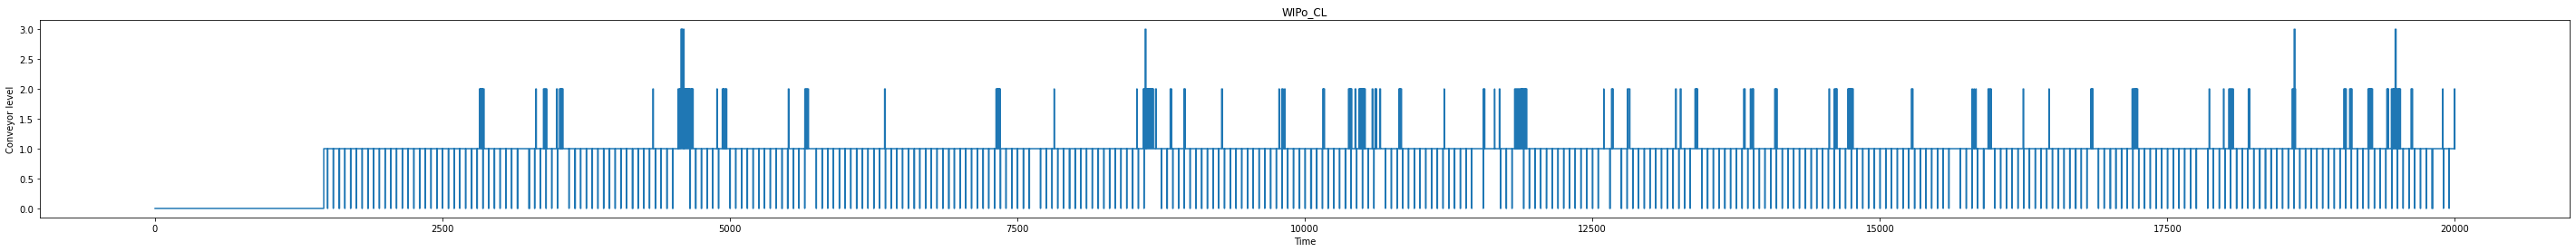

In [21]:

df = pd.DataFrame(finished_goods)
if not df.empty:
    df.sort_values('FinalGoodsTime', inplace=True, ignore_index=True)
    display(df.head())
else:
    print("No units reached finished_goods.")

times = [r['Time'] for r in h.wip_history if r['Node']=='WIPo_CL']
levels= [r['WIP'] for r in h.wip_history if r['Node']=='WIPo_CL']
if times:
    plt.figure(figsize=(50,4))
    plt.step(times, levels, where='post')
    plt.xlabel('Time'); plt.ylabel('Conveyor level'); plt.title('WIPo_CL')
    plt.show()
    
df.to_csv('CL_test', index=False) 

In [24]:
for m in ['P1','P2', 'CL1', 'CL2', 'CL3', 'CL4', 'IH1', 'IH2', 'IH3', 'SB1', 'SAW1', 'SAW2', 'SAW3', 'SAW4']:
    hist = h.status_history.get(m, [])
    print(m, ' first toggles:', hist[:4])

P1  first toggles: [(0, True), (0, True), (55.34887953786026, False), (66.30246900194614, True)]
P2  first toggles: [(0, True), (0, True), (149.5917357021066, False), (154.9772683106908, True)]
CL1  first toggles: [(0, True), (0, True), (191.4603008240227, False), (196.52976147057603, True)]
CL2  first toggles: [(0, True), (0, True), (51.020165693997185, False), (94.31928648585723, True)]
CL3  first toggles: [(0, True), (0, True), (2.6570856172492747, False), (5.8390631945876486, True)]
CL4  first toggles: [(0, True), (0, True), (0.15292139318926287, False), (2.372652749630538, True)]
IH1  first toggles: [(0, True), (0, True), (34.07935067626973, False), (34.79095274795494, True)]
IH2  first toggles: [(0, True), (0, True), (149.89739672790495, False), (151.21803196785908, True)]
IH3  first toggles: [(0, True), (0, True), (15.761641795979427, False), (26.53922112698617, True)]
SB1  first toggles: [(0, True), (0, True), (29.06028793920549, False), (39.768856473092995, True)]
SAW1  first 